# https://keras.io/examples/vision/grad_cam/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.models import load_model
import os

from matplotlib import image

In [2]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img

# Load trained model

In [3]:
model_name = 'Xception_on_DAiSEE_finetune_fc.h5'
ER_model = load_model(model_name)

In [4]:
ER_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [5]:
# y2 is engagement
ER_model.output

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y3')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y4')>]

In [6]:
ER_model.input

<KerasTensor: shape=(None, 299, 299, 3) dtype=float32 (created by layer 'input_2')>

In [7]:
inputs = ER_model.input
outputs = ER_model.output[1]
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

In [9]:
model.output

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'y2')>

In [10]:
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input

#decode_predictions = keras.applications.xception.decode_predictions

# Remove last layer's softmax
model.layers[-1].activation = None

# Run Grad-CAM on selected samples

1/1 [==============================] - 2s 2s/step
GT:  0
Output:  [[-3.3590126  -2.0438154   0.38834935  0.6621391 ]]
Prediciton:  3
1/1 [==============================] - 0s 30ms/step
GT:  0
Output:  [[-1.1459663  -0.8010029   0.24042177 -0.29173473]]
Prediciton:  2
1/1 [==============================] - 0s 30ms/step
GT:  0
Output:  [[-3.1974964  -0.92437327  1.6181111   0.6784    ]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  0
Output:  [[-5.2239814 -2.8095927  1.0316687  1.0221097]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  1
Output:  [[-3.4231493  -2.446786    0.9918191   0.15385701]]
Prediciton:  2
1/1 [==============================] - 0s 30ms/step
GT:  1
Output:  [[-3.4469748  -1.1115091   0.99926454 -0.1943109 ]]
Prediciton:  2
1/1 [==============================] - 0s 28ms/step
GT:  1
Output:  [[-3.090322   -0.9244256   0.95933104  0.509695  ]]
Prediciton:  2
1/1 [==============================] - 0s 28ms/step
GT:  1
Ou

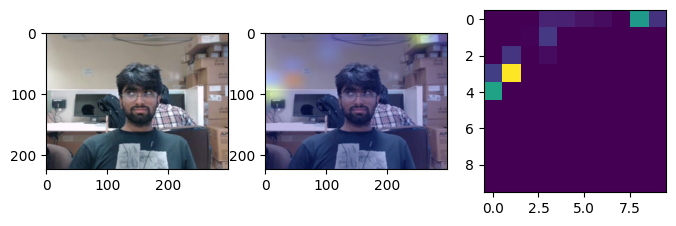

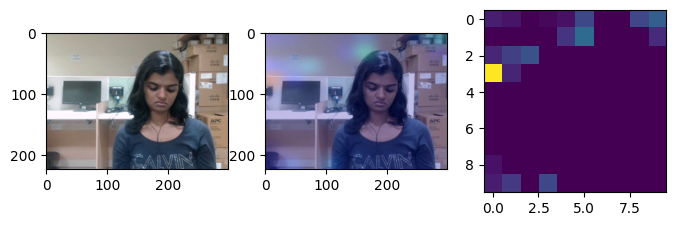

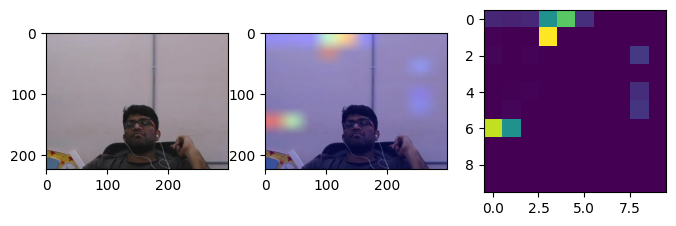

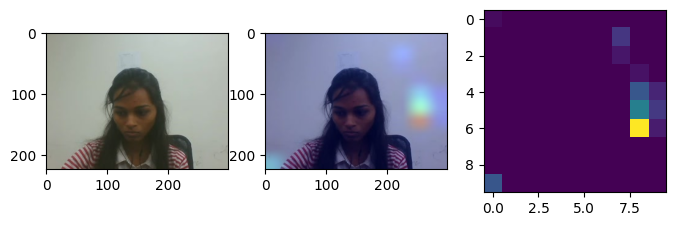

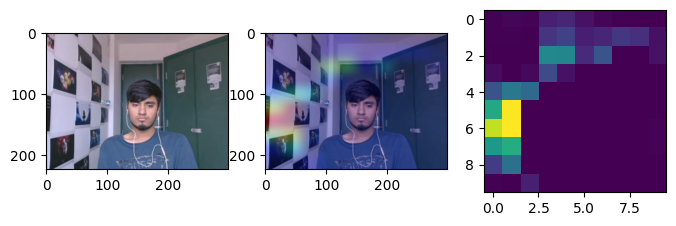

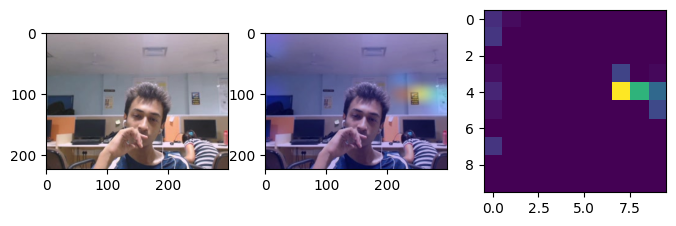

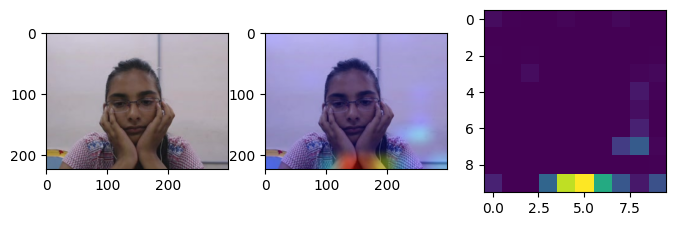

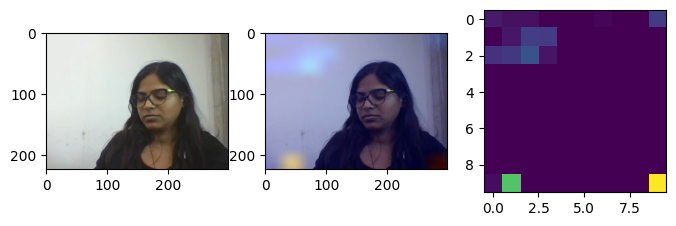

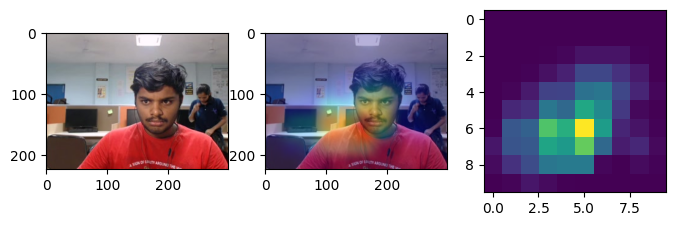

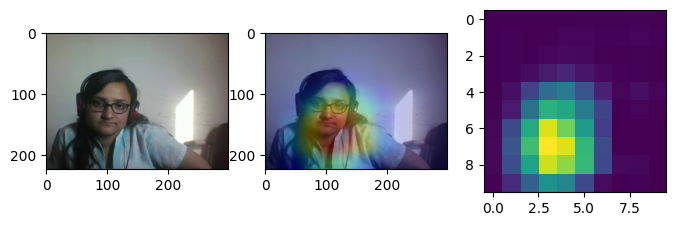

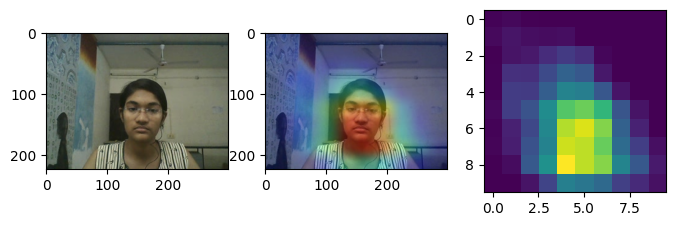

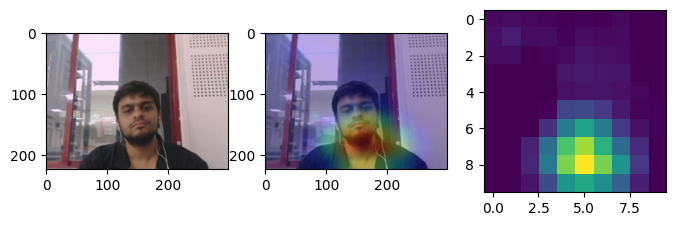

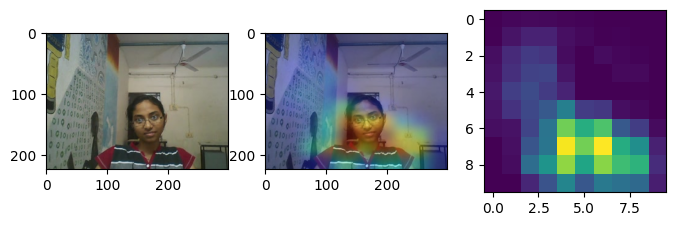

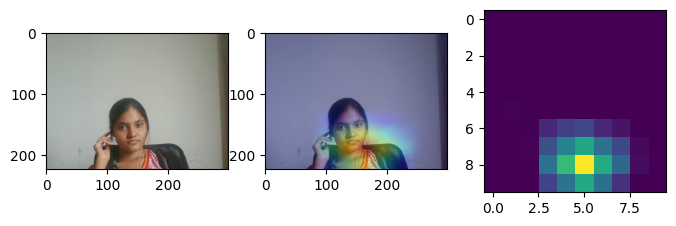

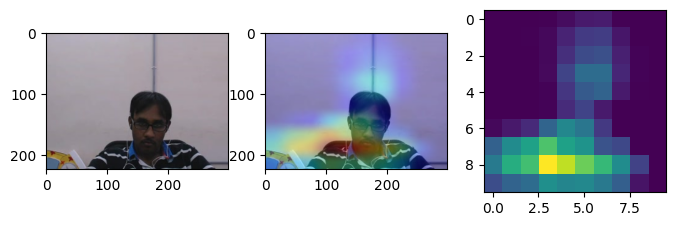

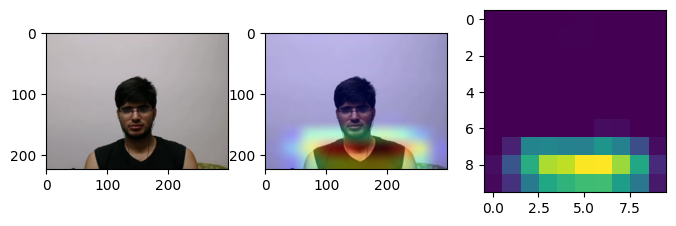

In [11]:
last_conv_layer_name = "block14_sepconv2_act"

samples_folder = 'Samples'
samples_folder_subdirectores = ['Engagement 0', 'Engagement 1', 'Engagement 2', 'Engagement 3']
img_data = []
for subfolder in samples_folder_subdirectores:
    category_pairs = []
    for filename in os.listdir(os.path.join(os.getcwd(), samples_folder, subfolder)):
        img_path = os.path.join(os.getcwd(), samples_folder, subfolder, filename)

        # Prepare image
        img = image.imread(img_path)
        img_array = preprocess_input(get_img_array(img_path, size=img_size))

        # Print what the top predicted class is
        preds = model.predict(img_array)
        #print("Predicted:", decode_predictions(preds, top=1)[0])
        print("GT: ", subfolder[-1])
        print("Output: ", preds)
        print("Prediciton: ", np.argmax(preds[0]))

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=int(subfolder[-1]))
        gradcam = display_gradcam(img_path, heatmap)
        
        
        category_pairs.append((img, gradcam, heatmap))
        
    img_data.append(category_pairs)

for index, category in enumerate(img_data):
    for pair in category:
        
        fig = plt.figure(figsize=(8, 20))
        columns = 3
        rows = 1
        for i in range(0, columns*rows):
            img = pair[i]
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img)
        plt.show()

# Second to last conv layer

1/1 [==============================] - 0s 28ms/step
GT:  0
Output:  [[-3.3590126  -2.0438154   0.38834935  0.6621391 ]]
Prediciton:  3
1/1 [==============================] - 0s 32ms/step
GT:  0
Output:  [[-1.1459663  -0.8010029   0.24042177 -0.29173473]]
Prediciton:  2
1/1 [==============================] - 0s 27ms/step
GT:  0
Output:  [[-3.1974964  -0.92437327  1.6181111   0.6784    ]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  0
Output:  [[-5.2239814 -2.8095927  1.0316687  1.0221097]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  1
Output:  [[-3.4231493  -2.446786    0.9918191   0.15385701]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  1
Output:  [[-3.4469748  -1.1115091   0.99926454 -0.1943109 ]]
Prediciton:  2
1/1 [==============================] - 0s 28ms/step
GT:  1
Output:  [[-3.090322   -0.9244256   0.95933104  0.509695  ]]
Prediciton:  2
1/1 [==============================] - 0s 28ms/step
GT:  1


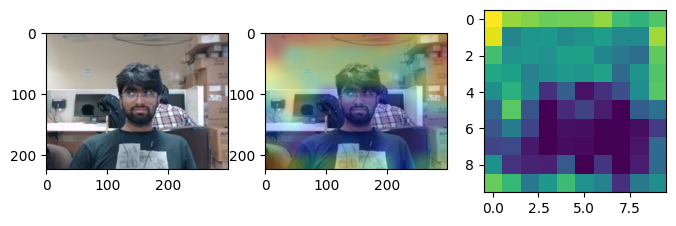

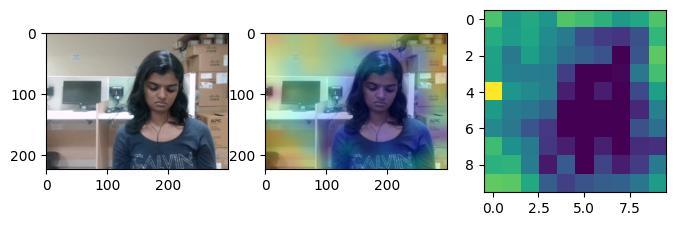

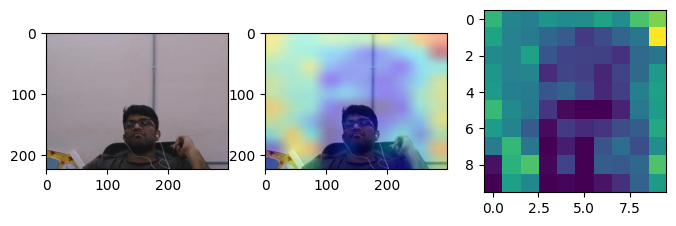

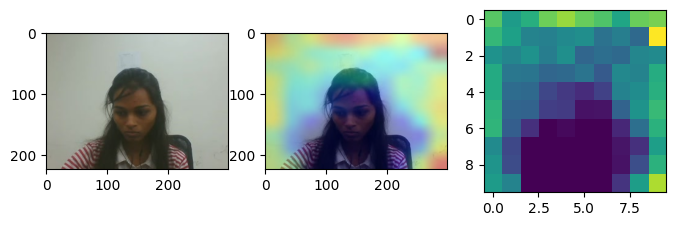

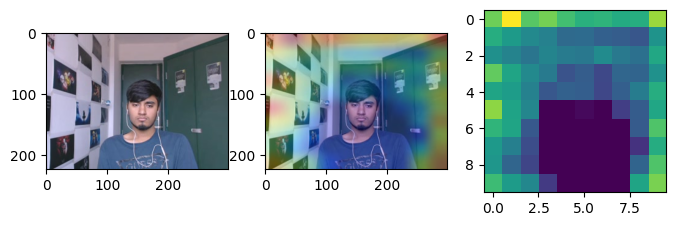

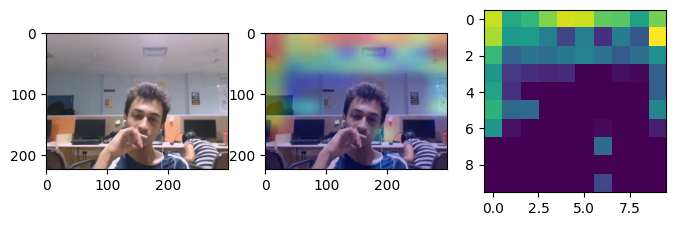

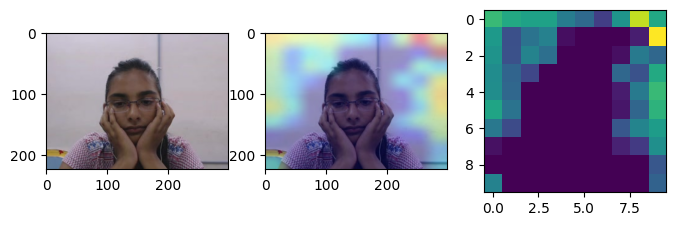

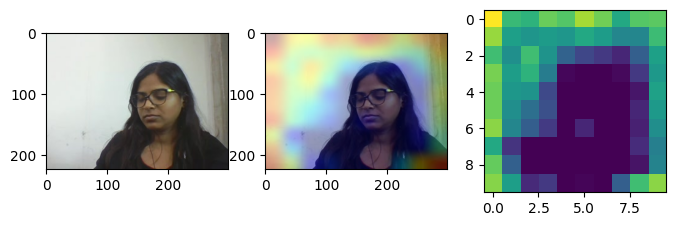

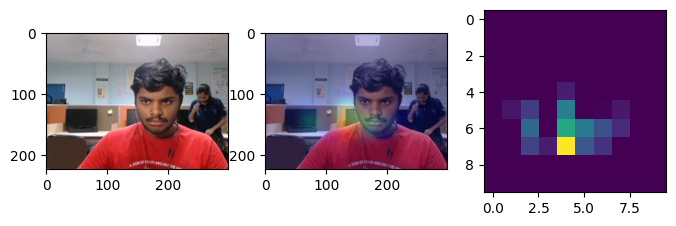

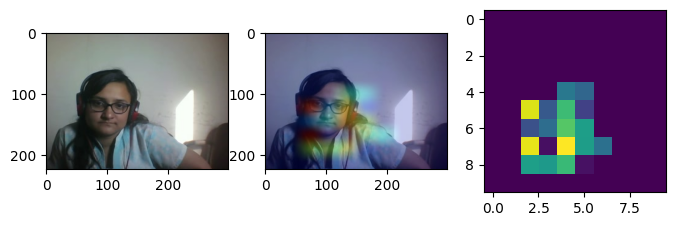

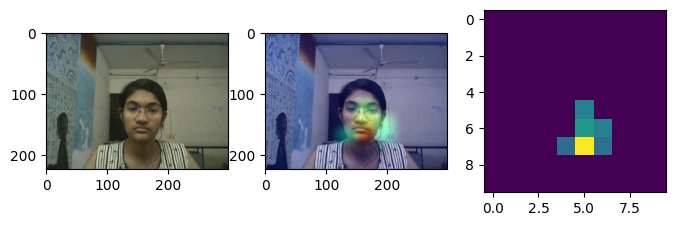

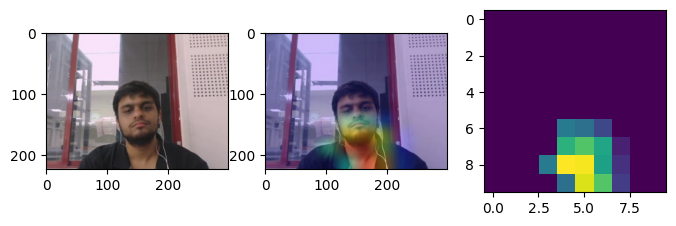

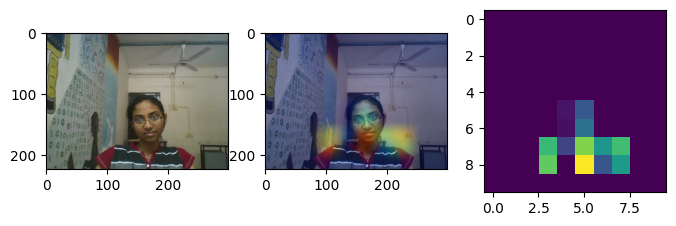

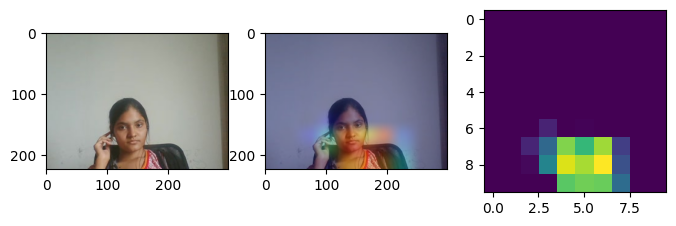

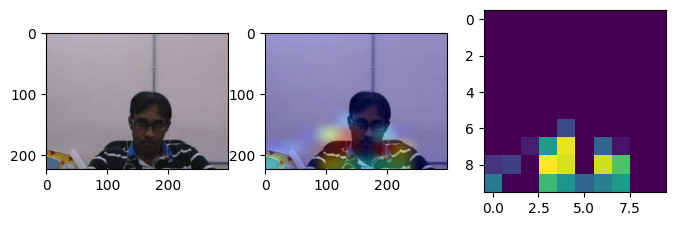

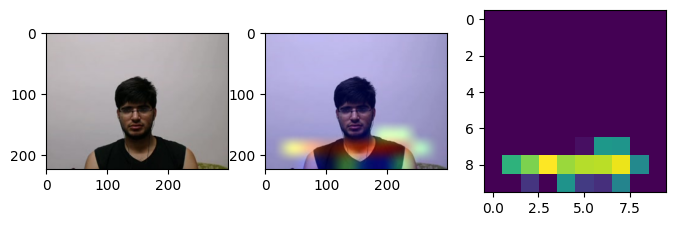

In [12]:
last_conv_layer_name = "block14_sepconv1_act"

samples_folder = 'Samples'
samples_folder_subdirectores = ['Engagement 0', 'Engagement 1', 'Engagement 2', 'Engagement 3']
img_data = []
for subfolder in samples_folder_subdirectores:
    category_pairs = []
    for filename in os.listdir(os.path.join(os.getcwd(), samples_folder, subfolder)):
        img_path = os.path.join(os.getcwd(), samples_folder, subfolder, filename)

        # Prepare image
        img = image.imread(img_path)
        img_array = preprocess_input(get_img_array(img_path, size=img_size))

        # Print what the top predicted class is
        preds = model.predict(img_array)
        #print("Predicted:", decode_predictions(preds, top=1)[0])
        print("GT: ", subfolder[-1])
        print("Output: ", preds)
        print("Prediciton: ", np.argmax(preds[0]))

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=int(subfolder[-1]))
        gradcam = display_gradcam(img_path, heatmap)
        
        
        category_pairs.append((img, gradcam, heatmap))
        
    img_data.append(category_pairs)

for index, category in enumerate(img_data):
    for pair in category:
        
        fig = plt.figure(figsize=(8, 20))
        columns = 3
        rows = 1
        for i in range(0, columns*rows):
            img = pair[i]
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img)
        plt.show()

# Third to last conv layer

1/1 [==============================] - 0s 28ms/step
GT:  0
Output:  [[-3.3590126  -2.0438154   0.38834935  0.6621391 ]]
Prediciton:  3
1/1 [==============================] - 0s 28ms/step
GT:  0
Output:  [[-1.1459663  -0.8010029   0.24042177 -0.29173473]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  0
Output:  [[-3.1974964  -0.92437327  1.6181111   0.6784    ]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  0
Output:  [[-5.2239814 -2.8095927  1.0316687  1.0221097]]
Prediciton:  2
1/1 [==============================] - 0s 34ms/step
GT:  1
Output:  [[-3.4231493  -2.446786    0.9918191   0.15385701]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  1
Output:  [[-3.4469748  -1.1115091   0.99926454 -0.1943109 ]]
Prediciton:  2
1/1 [==============================] - 0s 31ms/step
GT:  1
Output:  [[-3.090322   -0.9244256   0.95933104  0.509695  ]]
Prediciton:  2
1/1 [==============================] - 0s 29ms/step
GT:  1


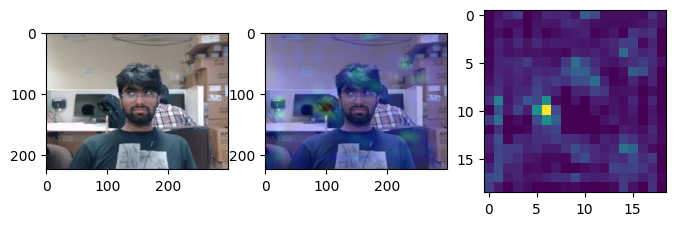

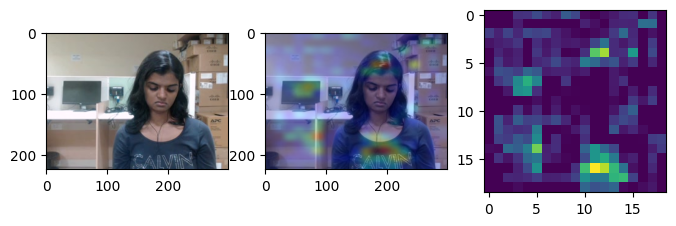

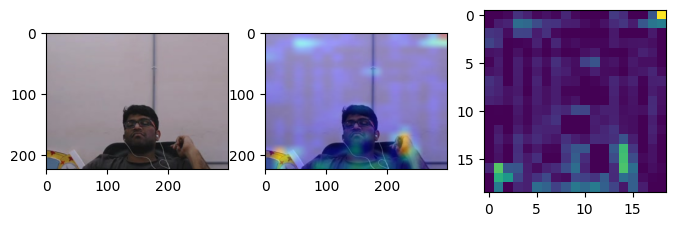

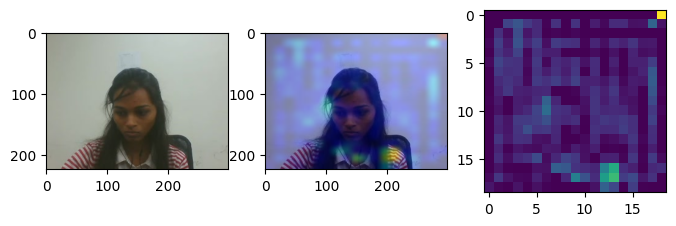

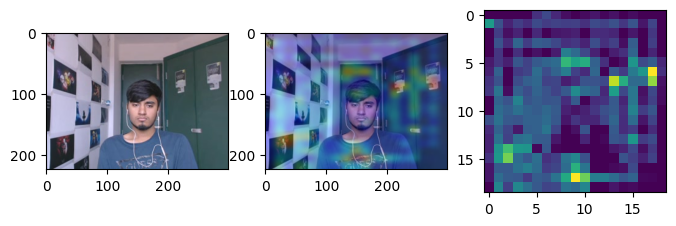

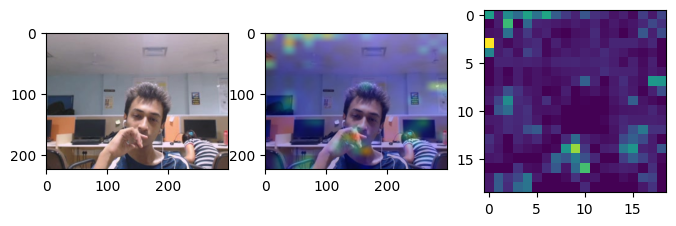

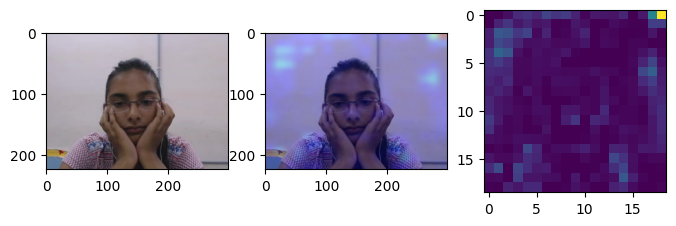

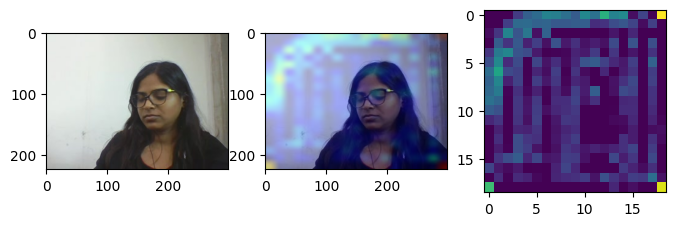

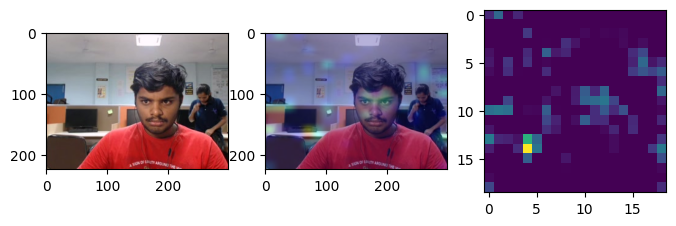

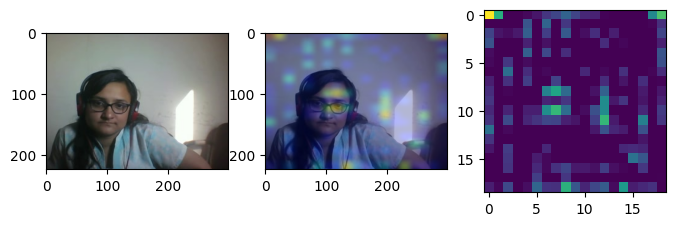

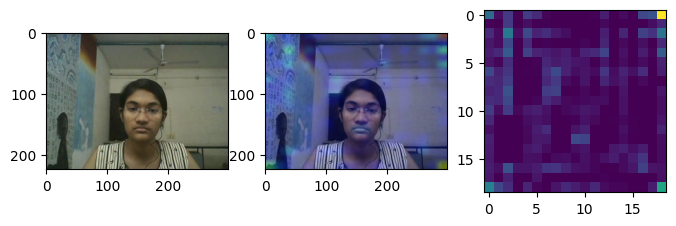

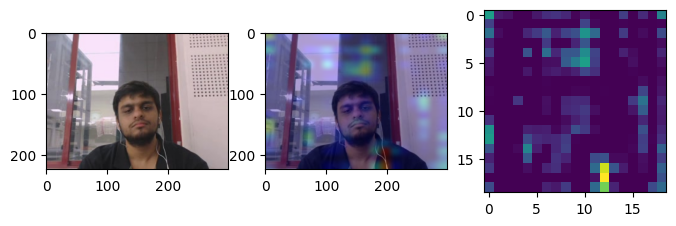

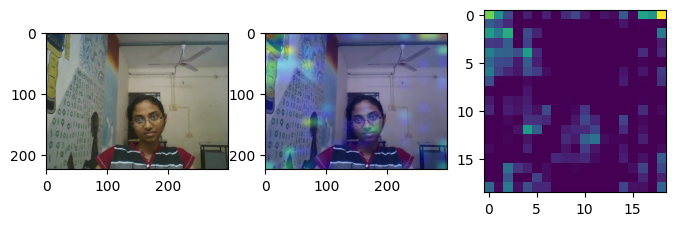

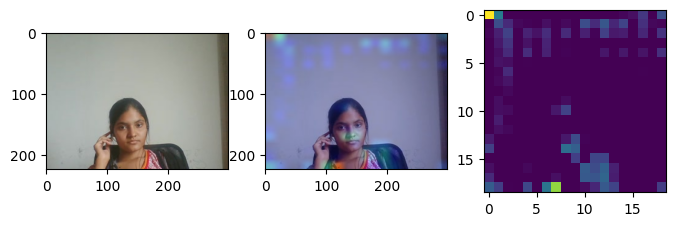

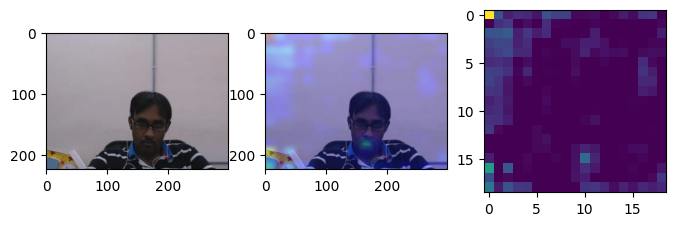

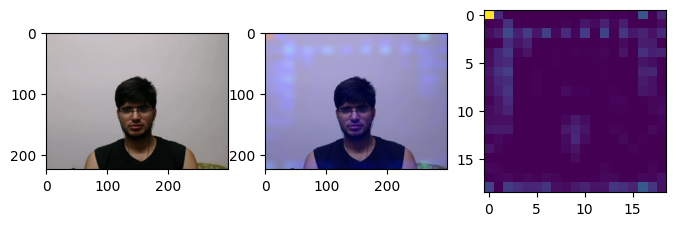

In [13]:
last_conv_layer_name = "block13_sepconv2_act"

samples_folder = 'Samples'
samples_folder_subdirectores = ['Engagement 0', 'Engagement 1', 'Engagement 2', 'Engagement 3']
img_data = []
for subfolder in samples_folder_subdirectores:
    category_pairs = []
    for filename in os.listdir(os.path.join(os.getcwd(), samples_folder, subfolder)):
        img_path = os.path.join(os.getcwd(), samples_folder, subfolder, filename)

        # Prepare image
        img = image.imread(img_path)
        img_array = preprocess_input(get_img_array(img_path, size=img_size))

        # Print what the top predicted class is
        preds = model.predict(img_array)
        #print("Predicted:", decode_predictions(preds, top=1)[0])
        print("GT: ", subfolder[-1])
        print("Output: ", preds)
        print("Prediciton: ", np.argmax(preds[0]))

        # Generate class activation heatmap
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=int(subfolder[-1]))
        gradcam = display_gradcam(img_path, heatmap)
        
        
        category_pairs.append((img, gradcam, heatmap))
        
    img_data.append(category_pairs)

for index, category in enumerate(img_data):
    for pair in category:
        
        fig = plt.figure(figsize=(8, 20))
        columns = 3
        rows = 1
        for i in range(0, columns*rows):
            img = pair[i]
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(img)
        plt.show()

# Section 2: Heatmap analysis

In [14]:
import pandas as pd
from tqdm import tqdm

label_dir = "D:\GitHub Desktop\DAiSEE-train\dataset"

labels = pd.read_csv(os.path.join(label_dir, 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(label_dir, 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(label_dir, 'GenderClips', 'Males'), header=None)

In [15]:
females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

In [16]:
gen_location = "D:\GitHub Desktop\DAiSEE-train\dataset"

sets = ["Train", "Test", "Validation"]


labels['ID_num'] = labels['ClipID'].str[:-4]
folder_path = os.path.join(gen_location, sets[2])

labels['ID_num'] = pd.to_numeric(labels['ID_num'])

max_iter = 50000

stats = []
male_data = []
female_data = []

last_conv_layer_name = "block14_sepconv2_act"

#just look at train set for now
for filename in tqdm(os.listdir(folder_path)):

    img_path = os.path.join(folder_path, filename)

    # Prepare image
    img = image.imread(img_path)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Print what the top predicted class is
    preds = model.predict(img_array)
    #print("Predicted:", decode_predictions(preds, top=1)[0])
    #print("GT: ", subfolder[-1])
    #print("Output: ", preds)
    #print("Prediciton: ", np.argmax(preds[0]))
    
    sample_ID = filename[:filename.index('-')]
    
    label = labels[labels['ID_num']==int(sample_ID)].values.tolist()[0][1:-1]
    engagement = label[1]
    video_name = label = labels[labels['ID_num']==int(sample_ID)].values.tolist()[0][0]

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=int(engagement))
    
    #print("%s is labelled as %d" % (sample_ID, label))
    
    # (GT, prediction)
    stats.append((engagement, np.argmax(preds[0])))

    if video_name in females_list:
        #print("female")
        female_data.append((int(engagement), heatmap))
    elif video_name in males_list:
        #print("males")
        male_data.append((int(engagement), heatmap))
    else:
        print("ERROR")
        
    max_iter -= 1
    if max_iter <= 0:
        break


  0%|                                                                                        | 0/12039 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                                                                | 1/12039 [00:00<46:20,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                                                                | 2/12039 [00:00<46:13,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                                                                | 3/12039 [00:00<46:00,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


  0%|                                                                                | 4/12039 [00:00<47:50,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


  0%|                                                                                | 5/12039 [00:01<48:16,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                                                                | 6/12039 [00:01<48:01,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                                                                | 7/12039 [00:01<47:55,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


  0%|                                                                                | 8/12039 [00:01<48:10,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


  0%|                                                                                | 9/12039 [00:02<47:51,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                                                               | 10/12039 [00:02<47:19,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  0%|                                                                               | 11/12039 [00:02<47:35,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


  0%|                                                                               | 12/12039 [00:02<47:41,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


  0%|                                                                               | 13/12039 [00:03<47:37,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  0%|                                                                               | 14/12039 [00:03<47:53,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                                                               | 15/12039 [00:03<48:33,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                                                               | 16/12039 [00:03<49:50,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                                                               | 17/12039 [00:04<51:14,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


  0%|                                                                               | 18/12039 [00:04<52:04,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


  0%|                                                                               | 19/12039 [00:04<52:21,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


  0%|▏                                                                              | 20/12039 [00:04<55:25,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 21/12039 [00:05<54:17,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▏                                                                              | 22/12039 [00:05<54:35,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▏                                                                              | 23/12039 [00:05<53:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 24/12039 [00:06<53:02,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▏                                                                              | 25/12039 [00:06<52:25,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                                                              | 26/12039 [00:06<52:11,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 27/12039 [00:06<51:25,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 28/12039 [00:07<51:33,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                                                              | 29/12039 [00:07<51:16,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 30/12039 [00:07<50:50,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                                                              | 31/12039 [00:07<50:57,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


  0%|▏                                                                              | 32/12039 [00:08<49:53,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 33/12039 [00:08<49:59,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 34/12039 [00:08<49:59,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                                                              | 35/12039 [00:08<50:50,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▏                                                                              | 36/12039 [00:09<50:06,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                                                              | 37/12039 [00:09<49:45,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▏                                                                              | 38/12039 [00:09<48:26,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 39/12039 [00:09<48:12,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


  0%|▎                                                                              | 40/12039 [00:10<50:35,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▎                                                                              | 41/12039 [00:10<50:28,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 42/12039 [00:10<50:01,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


  0%|▎                                                                              | 43/12039 [00:10<49:49,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 44/12039 [00:11<49:35,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 45/12039 [00:11<48:43,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 46/12039 [00:11<48:08,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 47/12039 [00:11<47:36,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▎                                                                              | 48/12039 [00:12<50:55,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


  0%|▎                                                                              | 49/12039 [00:12<49:18,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▎                                                                              | 50/12039 [00:12<48:00,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▎                                                                              | 51/12039 [00:12<47:23,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 52/12039 [00:12<47:11,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▎                                                                              | 53/12039 [00:13<46:52,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▎                                                                              | 54/12039 [00:13<46:48,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▎                                                                              | 55/12039 [00:13<47:05,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  0%|▎                                                                              | 56/12039 [00:13<47:58,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▎                                                                              | 57/12039 [00:14<48:36,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▍                                                                              | 58/12039 [00:14<49:10,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▍                                                                              | 59/12039 [00:14<49:38,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


  0%|▍                                                                              | 60/12039 [00:14<52:41,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▍                                                                              | 61/12039 [00:15<52:16,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▍                                                                              | 62/12039 [00:15<51:44,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▍                                                                              | 63/12039 [00:15<52:37,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▍                                                                              | 64/12039 [00:16<54:04,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▍                                                                              | 65/12039 [00:16<54:31,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▍                                                                              | 66/12039 [00:16<55:05,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▍                                                                              | 67/12039 [00:16<55:30,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▍                                                                              | 68/12039 [00:17<55:51,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▍                                                                              | 69/12039 [00:17<57:44,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▍                                                                              | 70/12039 [00:17<57:51,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▍                                                                              | 71/12039 [00:18<58:36,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▍                                                                              | 72/12039 [00:18<57:28,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▍                                                                              | 73/12039 [00:18<56:55,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▍                                                                              | 74/12039 [00:18<56:42,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▍                                                                              | 75/12039 [00:19<55:16,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▍                                                                              | 76/12039 [00:19<54:57,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▌                                                                              | 77/12039 [00:19<55:11,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▌                                                                              | 78/12039 [00:20<59:57,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                                                              | 79/12039 [00:20<58:24,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▌                                                                              | 80/12039 [00:20<57:16,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▌                                                                              | 81/12039 [00:20<56:38,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                                                              | 82/12039 [00:21<56:55,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▌                                                                              | 83/12039 [00:21<55:48,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▌                                                                              | 84/12039 [00:21<56:12,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▌                                                                              | 85/12039 [00:21<55:27,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                                                              | 86/12039 [00:22<59:49,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▌                                                                              | 87/12039 [00:22<57:39,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▌                                                                              | 88/12039 [00:22<56:36,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▌                                                                              | 89/12039 [00:23<53:28,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                                                              | 90/12039 [00:23<52:25,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                                                              | 91/12039 [00:23<51:20,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                                                              | 92/12039 [00:23<50:29,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▌                                                                              | 93/12039 [00:24<49:58,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▌                                                                              | 94/12039 [00:24<50:44,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▌                                                                            | 95/12039 [00:24<1:00:25,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▋                                                                              | 96/12039 [00:25<58:53,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▋                                                                              | 97/12039 [00:25<57:45,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▋                                                                              | 98/12039 [00:25<55:21,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▋                                                                              | 99/12039 [00:25<53:54,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▋                                                                             | 100/12039 [00:26<54:54,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▋                                                                             | 101/12039 [00:26<54:04,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▋                                                                             | 102/12039 [00:26<52:53,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▋                                                                             | 103/12039 [00:26<52:53,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▋                                                                             | 104/12039 [00:27<52:14,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▋                                                                             | 105/12039 [00:27<51:25,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▋                                                                             | 106/12039 [00:27<51:12,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▋                                                                             | 107/12039 [00:27<50:56,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▋                                                                             | 108/12039 [00:28<50:30,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▋                                                                             | 109/12039 [00:28<50:15,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▋                                                                             | 110/12039 [00:28<49:56,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▋                                                                             | 111/12039 [00:28<50:14,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▋                                                                             | 112/12039 [00:29<49:32,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▋                                                                             | 113/12039 [00:29<49:17,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▋                                                                             | 114/12039 [00:29<48:30,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▋                                                                             | 115/12039 [00:29<50:29,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▊                                                                             | 116/12039 [00:30<49:19,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▊                                                                             | 117/12039 [00:30<49:46,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▊                                                                             | 118/12039 [00:30<49:15,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▊                                                                             | 119/12039 [00:30<48:50,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▊                                                                             | 120/12039 [00:31<50:02,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▊                                                                             | 121/12039 [00:31<49:51,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▊                                                                             | 122/12039 [00:31<49:55,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▊                                                                             | 123/12039 [00:31<49:35,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▊                                                                             | 124/12039 [00:32<48:38,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▊                                                                             | 125/12039 [00:32<49:03,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▊                                                                             | 126/12039 [00:32<49:20,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▊                                                                             | 127/12039 [00:32<49:40,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▊                                                                             | 128/12039 [00:33<49:14,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▊                                                                             | 129/12039 [00:33<49:17,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▊                                                                             | 130/12039 [00:33<49:12,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▊                                                                             | 131/12039 [00:33<51:17,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▊                                                                             | 132/12039 [00:34<52:20,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▊                                                                             | 133/12039 [00:34<52:53,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▊                                                                             | 134/12039 [00:34<52:18,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▊                                                                             | 135/12039 [00:35<54:34,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▉                                                                             | 136/12039 [00:35<54:57,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▉                                                                             | 137/12039 [00:35<55:29,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▉                                                                             | 138/12039 [00:35<56:05,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▉                                                                             | 139/12039 [00:36<58:14,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▉                                                                             | 140/12039 [00:36<59:37,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                             | 141/12039 [00:36<59:06,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▉                                                                             | 142/12039 [00:37<57:51,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▉                                                                             | 143/12039 [00:37<57:37,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▉                                                                             | 144/12039 [00:37<56:01,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▉                                                                             | 145/12039 [00:37<55:20,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▉                                                                             | 146/12039 [00:38<53:07,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▉                                                                             | 147/12039 [00:38<51:59,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▉                                                                             | 148/12039 [00:38<51:04,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▉                                                                             | 149/12039 [00:38<51:07,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                             | 150/12039 [00:39<50:35,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▉                                                                             | 151/12039 [00:39<49:51,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▉                                                                             | 152/12039 [00:39<49:16,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▉                                                                             | 153/12039 [00:39<51:37,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▉                                                                             | 154/12039 [00:40<50:27,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 155/12039 [00:40<49:06,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█                                                                             | 156/12039 [00:40<48:26,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 157/12039 [00:40<48:13,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█                                                                             | 158/12039 [00:41<49:05,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


  1%|█                                                                             | 159/12039 [00:41<48:22,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 160/12039 [00:41<48:42,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 161/12039 [00:41<49:18,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


  1%|█                                                                             | 162/12039 [00:42<50:13,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 163/12039 [00:42<50:42,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


  1%|█                                                                             | 164/12039 [00:42<49:53,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 165/12039 [00:42<50:36,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█                                                                             | 166/12039 [00:43<50:32,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                             | 167/12039 [00:43<50:48,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


  1%|█                                                                             | 168/12039 [00:43<50:59,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                             | 169/12039 [00:43<50:46,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█                                                                             | 170/12039 [00:44<51:37,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█                                                                             | 171/12039 [00:44<52:50,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█                                                                             | 172/12039 [00:44<53:26,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


  1%|█                                                                             | 173/12039 [00:45<53:56,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█▏                                                                            | 174/12039 [00:45<53:21,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█▏                                                                            | 175/12039 [00:45<53:28,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  1%|█▏                                                                            | 176/12039 [00:45<53:12,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  1%|█▏                                                                            | 177/12039 [00:46<53:33,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  1%|█▏                                                                            | 178/12039 [00:46<52:04,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  1%|█▏                                                                            | 179/12039 [00:46<53:10,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█▏                                                                            | 180/12039 [00:46<53:17,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▏                                                                            | 181/12039 [00:47<52:35,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▏                                                                            | 182/12039 [00:47<54:35,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▏                                                                            | 183/12039 [00:47<54:55,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▏                                                                            | 184/12039 [00:48<53:37,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▏                                                                            | 185/12039 [00:48<54:25,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▏                                                                            | 186/12039 [00:48<52:52,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▏                                                                            | 187/12039 [00:48<52:33,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▏                                                                            | 188/12039 [00:49<51:42,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▏                                                                            | 189/12039 [00:49<52:11,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▏                                                                            | 190/12039 [00:49<51:48,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▏                                                                            | 191/12039 [00:49<53:22,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▏                                                                            | 192/12039 [00:50<52:38,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▎                                                                            | 193/12039 [00:50<51:53,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▎                                                                            | 194/12039 [00:50<50:17,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▎                                                                            | 195/12039 [00:50<49:25,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▎                                                                            | 196/12039 [00:51<49:38,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▎                                                                            | 197/12039 [00:51<48:46,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▎                                                                            | 198/12039 [00:51<50:21,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 199/12039 [00:51<51:13,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▎                                                                            | 200/12039 [00:52<52:07,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▎                                                                            | 201/12039 [00:52<50:44,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 202/12039 [00:52<51:01,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▎                                                                            | 203/12039 [00:52<50:55,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▎                                                                            | 204/12039 [00:53<50:47,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▎                                                                            | 205/12039 [00:53<51:42,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▎                                                                            | 206/12039 [00:53<50:05,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▎                                                                            | 207/12039 [00:53<49:26,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▎                                                                            | 208/12039 [00:54<48:30,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▎                                                                            | 209/12039 [00:54<49:12,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 210/12039 [00:54<50:45,  3.88it/s]

1/1 [==============================] - 0s 60ms/step


  2%|█▎                                                                            | 211/12039 [00:55<54:36,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▎                                                                            | 212/12039 [00:55<53:07,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▍                                                                            | 213/12039 [00:55<52:47,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▍                                                                            | 214/12039 [00:55<54:11,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▍                                                                            | 215/12039 [00:56<53:08,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                            | 216/12039 [00:56<52:47,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                            | 217/12039 [00:56<51:48,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▍                                                                            | 218/12039 [00:56<52:09,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▍                                                                            | 219/12039 [00:57<51:09,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▍                                                                            | 220/12039 [00:57<50:32,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                            | 221/12039 [00:57<58:28,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▍                                                                            | 222/12039 [00:58<56:17,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▍                                                                            | 223/12039 [00:58<56:07,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▍                                                                            | 224/12039 [00:58<55:06,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                            | 225/12039 [00:58<55:07,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▍                                                                            | 226/12039 [00:59<57:39,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▍                                                                            | 227/12039 [00:59<57:27,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                            | 228/12039 [00:59<55:35,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▍                                                                            | 229/12039 [01:00<58:47,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▍                                                                            | 230/12039 [01:00<56:19,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▍                                                                            | 231/12039 [01:00<54:56,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▌                                                                            | 232/12039 [01:00<53:33,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▌                                                                            | 233/12039 [01:01<53:08,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▌                                                                            | 234/12039 [01:01<51:30,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▌                                                                            | 235/12039 [01:01<50:16,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▌                                                                            | 236/12039 [01:01<49:17,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▌                                                                            | 237/12039 [01:02<48:57,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▌                                                                            | 238/12039 [01:02<48:25,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 239/12039 [01:02<47:43,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 240/12039 [01:02<47:51,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 241/12039 [01:03<48:14,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 242/12039 [01:03<47:37,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▌                                                                            | 243/12039 [01:03<47:28,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▌                                                                            | 244/12039 [01:03<48:43,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▌                                                                            | 245/12039 [01:04<48:00,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 246/12039 [01:04<47:27,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▌                                                                            | 247/12039 [01:04<48:08,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 248/12039 [01:04<49:18,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▌                                                                            | 249/12039 [01:05<51:26,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▌                                                                            | 250/12039 [01:05<51:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▋                                                                            | 251/12039 [01:05<50:58,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▋                                                                            | 252/12039 [01:05<51:10,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▋                                                                            | 253/12039 [01:06<52:31,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▋                                                                            | 254/12039 [01:06<51:19,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▋                                                                            | 255/12039 [01:06<50:28,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▋                                                                            | 256/12039 [01:06<51:14,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▋                                                                            | 257/12039 [01:07<50:24,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▋                                                                            | 258/12039 [01:07<50:39,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▋                                                                            | 259/12039 [01:07<52:57,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▋                                                                            | 260/12039 [01:07<53:08,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▋                                                                            | 261/12039 [01:08<53:09,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▋                                                                            | 262/12039 [01:08<54:23,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▋                                                                            | 263/12039 [01:08<55:30,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


  2%|█▋                                                                            | 264/12039 [01:09<55:30,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  2%|█▋                                                                            | 265/12039 [01:09<55:41,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▋                                                                            | 266/12039 [01:09<53:20,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▋                                                                            | 267/12039 [01:09<54:35,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▋                                                                            | 268/12039 [01:10<53:16,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


  2%|█▋                                                                            | 269/12039 [01:10<51:38,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▋                                                                            | 270/12039 [01:10<51:01,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▊                                                                            | 271/12039 [01:10<50:23,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▊                                                                            | 272/12039 [01:11<50:33,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▊                                                                            | 273/12039 [01:11<50:25,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 274/12039 [01:11<49:53,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▊                                                                            | 275/12039 [01:11<49:30,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▊                                                                            | 276/12039 [01:12<49:26,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▊                                                                            | 277/12039 [01:12<49:11,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 278/12039 [01:12<49:11,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 279/12039 [01:13<53:00,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▊                                                                            | 280/12039 [01:13<52:14,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▊                                                                            | 281/12039 [01:13<50:47,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 282/12039 [01:13<50:18,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 283/12039 [01:14<49:43,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 284/12039 [01:14<49:17,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▊                                                                            | 285/12039 [01:14<49:32,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 286/12039 [01:14<51:22,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


  2%|█▊                                                                            | 287/12039 [01:15<52:56,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▊                                                                            | 288/12039 [01:15<52:23,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▊                                                                            | 289/12039 [01:15<52:13,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▉                                                                            | 290/12039 [01:15<52:35,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


  2%|█▉                                                                            | 291/12039 [01:16<53:19,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  2%|█▉                                                                            | 292/12039 [01:16<52:39,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▉                                                                            | 293/12039 [01:16<52:07,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▉                                                                            | 294/12039 [01:16<52:24,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▉                                                                            | 295/12039 [01:17<52:14,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▉                                                                            | 296/12039 [01:17<51:49,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▉                                                                            | 297/12039 [01:17<51:52,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▉                                                                            | 298/12039 [01:18<51:58,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  2%|█▉                                                                            | 299/12039 [01:18<51:30,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  2%|█▉                                                                            | 300/12039 [01:18<51:14,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▉                                                                            | 301/12039 [01:18<51:15,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▉                                                                            | 302/12039 [01:19<51:04,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▉                                                                            | 303/12039 [01:19<50:56,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▉                                                                            | 304/12039 [01:19<50:53,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  3%|█▉                                                                            | 305/12039 [01:19<51:48,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


  3%|█▉                                                                            | 306/12039 [01:20<51:18,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  3%|█▉                                                                            | 307/12039 [01:20<50:20,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  3%|█▉                                                                            | 308/12039 [01:20<49:49,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██                                                                            | 309/12039 [01:20<49:42,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 310/12039 [01:21<50:26,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 311/12039 [01:21<50:33,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██                                                                            | 312/12039 [01:21<49:44,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 313/12039 [01:21<50:09,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 314/12039 [01:22<49:25,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 315/12039 [01:22<49:11,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██                                                                            | 316/12039 [01:22<48:37,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██                                                                            | 317/12039 [01:22<48:48,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██                                                                            | 318/12039 [01:23<48:20,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 319/12039 [01:23<48:25,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██                                                                            | 320/12039 [01:23<49:25,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██                                                                            | 321/12039 [01:23<50:10,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██                                                                            | 322/12039 [01:24<50:43,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 323/12039 [01:24<50:44,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██                                                                            | 324/12039 [01:24<51:40,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


  3%|██                                                                            | 325/12039 [01:25<55:02,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██                                                                            | 326/12039 [01:25<54:55,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██                                                                            | 327/12039 [01:25<53:50,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▏                                                                           | 328/12039 [01:25<53:43,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██▏                                                                           | 329/12039 [01:26<54:07,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▏                                                                           | 330/12039 [01:26<53:24,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 331/12039 [01:26<52:32,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 332/12039 [01:26<52:38,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▏                                                                           | 333/12039 [01:27<52:10,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 334/12039 [01:27<51:33,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▏                                                                           | 335/12039 [01:27<51:11,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                           | 336/12039 [01:27<51:48,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 337/12039 [01:28<51:35,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▏                                                                           | 338/12039 [01:28<51:01,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██▏                                                                           | 339/12039 [01:28<51:06,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 340/12039 [01:28<50:58,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▏                                                                           | 341/12039 [01:29<50:46,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 342/12039 [01:29<50:34,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 343/12039 [01:29<51:12,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▏                                                                           | 344/12039 [01:30<51:49,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 345/12039 [01:30<50:42,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                           | 346/12039 [01:30<52:30,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▏                                                                           | 347/12039 [01:30<58:38,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                           | 348/12039 [01:31<56:01,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▎                                                                           | 349/12039 [01:31<53:55,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▎                                                                           | 350/12039 [01:31<52:06,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                           | 351/12039 [01:31<51:15,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▎                                                                           | 352/12039 [01:32<50:37,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▎                                                                           | 353/12039 [01:32<49:48,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▎                                                                           | 354/12039 [01:32<49:41,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▎                                                                           | 355/12039 [01:33<50:54,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▎                                                                           | 356/12039 [01:33<51:42,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▎                                                                           | 357/12039 [01:33<51:40,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▎                                                                           | 358/12039 [01:33<51:34,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▎                                                                           | 359/12039 [01:34<51:20,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                           | 360/12039 [01:34<51:10,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▎                                                                           | 361/12039 [01:34<50:55,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▎                                                                           | 362/12039 [01:34<53:36,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▎                                                                           | 363/12039 [01:35<53:29,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▎                                                                           | 364/12039 [01:35<53:11,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▎                                                                           | 365/12039 [01:35<52:40,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▎                                                                           | 366/12039 [01:35<52:30,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▍                                                                           | 367/12039 [01:36<52:47,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▍                                                                           | 368/12039 [01:36<51:33,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▍                                                                           | 369/12039 [01:36<51:15,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██▍                                                                           | 370/12039 [01:37<50:57,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██▍                                                                           | 371/12039 [01:37<50:43,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▍                                                                           | 372/12039 [01:37<50:36,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▍                                                                           | 373/12039 [01:37<50:46,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▍                                                                           | 374/12039 [01:38<50:54,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▍                                                                           | 375/12039 [01:38<52:03,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▍                                                                           | 376/12039 [01:38<51:53,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▍                                                                           | 377/12039 [01:38<51:35,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▍                                                                           | 378/12039 [01:39<51:12,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▍                                                                           | 379/12039 [01:39<50:56,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▍                                                                           | 380/12039 [01:39<52:05,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▍                                                                           | 381/12039 [01:39<55:07,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▍                                                                           | 382/12039 [01:40<54:19,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▍                                                                           | 383/12039 [01:40<54:37,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▍                                                                           | 384/12039 [01:40<54:08,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▍                                                                           | 385/12039 [01:41<59:36,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▌                                                                           | 386/12039 [01:41<59:12,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▌                                                                           | 387/12039 [01:41<57:03,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▌                                                                           | 388/12039 [01:42<56:00,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▌                                                                           | 389/12039 [01:42<58:46,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


  3%|██▍                                                                         | 390/12039 [01:42<1:12:14,  2.69it/s]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                         | 391/12039 [01:43<1:17:03,  2.52it/s]

1/1 [==============================] - 0s 45ms/step


  3%|██▍                                                                         | 392/12039 [01:43<1:13:58,  2.62it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▍                                                                         | 393/12039 [01:44<1:12:55,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


  3%|██▍                                                                         | 394/12039 [01:44<1:11:28,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▍                                                                         | 395/12039 [01:44<1:08:37,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


  3%|██▍                                                                         | 396/12039 [01:45<1:08:50,  2.82it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▌                                                                         | 397/12039 [01:45<1:04:56,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▌                                                                         | 398/12039 [01:45<1:02:06,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▌                                                                           | 399/12039 [01:45<58:53,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


  3%|██▌                                                                           | 400/12039 [01:46<57:51,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▌                                                                           | 401/12039 [01:46<55:23,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▌                                                                           | 402/12039 [01:46<54:34,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▌                                                                           | 403/12039 [01:47<53:57,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▌                                                                           | 404/12039 [01:47<52:39,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▌                                                                           | 405/12039 [01:47<51:55,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 406/12039 [01:47<51:49,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 407/12039 [01:48<51:47,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 408/12039 [01:48<52:12,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▋                                                                           | 409/12039 [01:48<52:04,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 410/12039 [01:48<52:02,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 411/12039 [01:49<51:42,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▋                                                                           | 412/12039 [01:49<51:18,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 413/12039 [01:49<50:58,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


  3%|██▋                                                                           | 414/12039 [01:49<52:20,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  3%|██▋                                                                           | 415/12039 [01:50<51:20,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▋                                                                           | 416/12039 [01:50<50:24,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  3%|██▋                                                                           | 417/12039 [01:50<49:52,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▋                                                                           | 418/12039 [01:50<49:58,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▋                                                                           | 419/12039 [01:51<50:09,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 420/12039 [01:51<50:06,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▋                                                                           | 421/12039 [01:51<49:33,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▋                                                                           | 422/12039 [01:51<49:14,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▋                                                                           | 423/12039 [01:52<49:01,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▋                                                                           | 424/12039 [01:52<48:53,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▊                                                                           | 425/12039 [01:52<48:26,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▊                                                                           | 426/12039 [01:52<49:00,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▊                                                                           | 427/12039 [01:53<48:35,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▊                                                                           | 428/12039 [01:53<48:24,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▊                                                                           | 429/12039 [01:53<48:13,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▊                                                                           | 430/12039 [01:53<48:10,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▊                                                                           | 431/12039 [01:54<47:46,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▊                                                                           | 432/12039 [01:54<48:03,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


  4%|██▊                                                                           | 433/12039 [01:54<48:24,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


  4%|██▊                                                                           | 434/12039 [01:55<50:59,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▊                                                                           | 435/12039 [01:55<50:49,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██▊                                                                           | 436/12039 [01:55<52:27,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██▊                                                                           | 437/12039 [01:55<53:42,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██▊                                                                           | 438/12039 [01:56<55:24,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


  4%|██▊                                                                           | 439/12039 [01:56<55:22,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


  4%|██▊                                                                           | 440/12039 [01:56<55:30,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██▊                                                                           | 441/12039 [01:57<55:09,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  4%|██▊                                                                           | 442/12039 [01:57<55:35,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▊                                                                           | 443/12039 [01:57<54:06,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  4%|██▉                                                                           | 444/12039 [01:57<53:59,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 445/12039 [01:58<53:16,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 446/12039 [01:58<52:31,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  4%|██▉                                                                           | 447/12039 [01:58<52:28,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  4%|██▉                                                                           | 448/12039 [01:58<52:26,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 449/12039 [01:59<52:20,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 450/12039 [01:59<51:57,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 451/12039 [01:59<51:40,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██▉                                                                           | 452/12039 [02:00<52:51,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▉                                                                           | 453/12039 [02:00<51:32,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 454/12039 [02:00<50:50,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 455/12039 [02:00<50:04,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▉                                                                           | 456/12039 [02:01<50:25,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 457/12039 [02:01<50:17,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▉                                                                           | 458/12039 [02:01<49:37,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  4%|██▉                                                                           | 459/12039 [02:01<49:40,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  4%|██▉                                                                           | 460/12039 [02:02<49:38,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 461/12039 [02:02<51:07,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 462/12039 [02:02<51:52,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  4%|██▉                                                                           | 463/12039 [02:02<51:04,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


  4%|███                                                                           | 464/12039 [02:03<49:45,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███                                                                           | 465/12039 [02:03<51:08,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███                                                                           | 466/12039 [02:03<51:39,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███                                                                           | 467/12039 [02:03<51:03,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


  4%|███                                                                           | 468/12039 [02:04<50:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███                                                                           | 469/12039 [02:04<49:10,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███                                                                           | 470/12039 [02:04<48:27,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███                                                                           | 471/12039 [02:04<50:12,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███                                                                           | 472/12039 [02:05<50:14,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 473/12039 [02:05<50:32,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 474/12039 [02:05<50:35,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 475/12039 [02:06<51:54,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███                                                                           | 476/12039 [02:06<58:01,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███                                                                           | 477/12039 [02:06<55:30,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 478/12039 [02:06<54:10,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 479/12039 [02:07<53:07,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 480/12039 [02:07<52:19,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███                                                                           | 481/12039 [02:07<52:10,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███                                                                           | 482/12039 [02:07<52:10,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▏                                                                          | 483/12039 [02:08<51:39,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▏                                                                          | 484/12039 [02:08<51:45,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▏                                                                          | 485/12039 [02:08<51:56,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▏                                                                          | 486/12039 [02:09<51:52,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▏                                                                          | 487/12039 [02:09<52:04,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▏                                                                          | 488/12039 [02:09<51:31,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▏                                                                          | 489/12039 [02:09<53:28,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███                                                                         | 490/12039 [02:10<1:00:41,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▏                                                                          | 491/12039 [02:10<57:29,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▏                                                                          | 492/12039 [02:10<56:20,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▏                                                                          | 493/12039 [02:11<57:12,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▏                                                                          | 494/12039 [02:11<56:15,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▏                                                                          | 495/12039 [02:11<55:56,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███▏                                                                          | 496/12039 [02:12<56:38,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▏                                                                          | 497/12039 [02:12<54:50,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███▏                                                                          | 498/12039 [02:12<55:20,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▏                                                                          | 499/12039 [02:12<55:21,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███▏                                                                          | 500/12039 [02:13<54:54,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▏                                                                          | 501/12039 [02:13<54:19,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


  4%|███▎                                                                          | 502/12039 [02:13<53:11,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▎                                                                          | 503/12039 [02:13<52:12,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▎                                                                          | 504/12039 [02:14<51:22,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▎                                                                          | 505/12039 [02:14<50:32,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███▎                                                                          | 506/12039 [02:14<49:07,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


  4%|███▎                                                                          | 507/12039 [02:14<50:22,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                          | 508/12039 [02:15<52:40,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                          | 509/12039 [02:15<57:13,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▎                                                                          | 510/12039 [02:15<59:13,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███▎                                                                          | 511/12039 [02:16<58:09,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▎                                                                          | 512/12039 [02:16<57:19,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                          | 513/12039 [02:16<57:28,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▎                                                                          | 514/12039 [02:17<56:11,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                          | 515/12039 [02:17<54:51,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▎                                                                          | 516/12039 [02:17<54:36,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▎                                                                          | 517/12039 [02:17<53:53,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▎                                                                          | 518/12039 [02:18<53:40,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▎                                                                          | 519/12039 [02:18<54:02,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▎                                                                          | 520/12039 [02:18<53:50,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▍                                                                          | 521/12039 [02:19<53:07,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▍                                                                          | 522/12039 [02:19<53:56,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▍                                                                          | 523/12039 [02:19<53:54,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▍                                                                          | 524/12039 [02:19<56:05,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███▍                                                                          | 525/12039 [02:20<55:01,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▍                                                                          | 526/12039 [02:20<54:14,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▍                                                                          | 527/12039 [02:20<52:40,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▍                                                                          | 528/12039 [02:20<51:58,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▍                                                                          | 529/12039 [02:21<51:38,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███▍                                                                          | 530/12039 [02:21<50:14,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▍                                                                          | 531/12039 [02:21<49:07,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███▍                                                                          | 532/12039 [02:22<49:06,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▍                                                                          | 533/12039 [02:22<49:15,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  4%|███▍                                                                          | 534/12039 [02:22<50:01,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


  4%|███▍                                                                          | 535/12039 [02:22<51:49,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▍                                                                          | 536/12039 [02:23<50:53,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


  4%|███▍                                                                          | 537/12039 [02:23<51:36,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▍                                                                          | 538/12039 [02:23<52:10,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███▍                                                                          | 539/12039 [02:23<52:08,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▍                                                                          | 540/12039 [02:24<51:12,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


  4%|███▌                                                                          | 541/12039 [02:24<49:44,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  5%|███▌                                                                          | 542/12039 [02:24<49:23,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▌                                                                          | 543/12039 [02:24<50:37,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▌                                                                          | 544/12039 [02:25<50:15,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  5%|███▌                                                                          | 545/12039 [02:25<49:28,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▌                                                                          | 546/12039 [02:25<50:46,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▌                                                                          | 547/12039 [02:26<52:12,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▌                                                                          | 548/12039 [02:26<51:33,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▌                                                                          | 549/12039 [02:26<52:41,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


  5%|███▌                                                                          | 550/12039 [02:26<54:03,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▌                                                                          | 551/12039 [02:27<53:28,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▌                                                                          | 552/12039 [02:27<52:59,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▌                                                                          | 553/12039 [02:27<57:34,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▌                                                                          | 554/12039 [02:28<56:31,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▌                                                                          | 555/12039 [02:28<56:27,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


  5%|███▌                                                                          | 556/12039 [02:28<59:00,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


  5%|███▌                                                                        | 557/12039 [02:29<1:04:03,  2.99it/s]

1/1 [==============================] - 0s 57ms/step


  5%|███▌                                                                        | 558/12039 [02:29<1:10:33,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


  5%|███▌                                                                        | 559/12039 [02:29<1:10:49,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▌                                                                        | 560/12039 [02:30<1:06:26,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▌                                                                        | 561/12039 [02:30<1:02:51,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


  5%|███▌                                                                        | 562/12039 [02:30<1:01:40,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▋                                                                          | 563/12039 [02:31<59:21,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▋                                                                          | 564/12039 [02:31<58:32,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▋                                                                          | 565/12039 [02:31<56:58,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▋                                                                          | 566/12039 [02:31<58:14,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                          | 567/12039 [02:32<57:39,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                          | 568/12039 [02:32<59:31,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▋                                                                          | 569/12039 [02:32<59:19,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


  5%|███▋                                                                          | 570/12039 [02:33<59:40,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


  5%|███▋                                                                          | 571/12039 [02:33<59:13,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▌                                                                        | 572/12039 [02:33<1:02:47,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


  5%|███▌                                                                        | 573/12039 [02:34<1:01:29,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▋                                                                          | 574/12039 [02:34<59:05,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▋                                                                          | 575/12039 [02:34<58:27,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


  5%|███▋                                                                          | 576/12039 [02:35<58:42,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▋                                                                          | 577/12039 [02:35<58:33,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▋                                                                        | 578/12039 [02:35<1:00:58,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                        | 579/12039 [02:36<1:04:20,  2.97it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▋                                                                        | 580/12039 [02:36<1:08:00,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


  5%|███▋                                                                        | 581/12039 [02:36<1:11:56,  2.65it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                        | 582/12039 [02:37<1:08:41,  2.78it/s]

1/1 [==============================] - 0s 50ms/step


  5%|███▋                                                                        | 583/12039 [02:37<1:12:21,  2.64it/s]

1/1 [==============================] - 0s 44ms/step


  5%|███▋                                                                        | 584/12039 [02:38<1:10:31,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▋                                                                        | 585/12039 [02:38<1:06:10,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▋                                                                        | 586/12039 [02:38<1:05:23,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                        | 587/12039 [02:38<1:02:43,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▋                                                                        | 588/12039 [02:39<1:00:20,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▊                                                                          | 589/12039 [02:39<57:41,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▋                                                                        | 590/12039 [02:39<1:01:22,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


  5%|███▋                                                                        | 591/12039 [02:40<1:03:25,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▊                                                                          | 592/12039 [02:40<59:26,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▊                                                                          | 593/12039 [02:40<58:01,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                          | 594/12039 [02:41<58:32,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▊                                                                          | 595/12039 [02:41<56:39,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


  5%|███▊                                                                          | 596/12039 [02:41<56:45,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                          | 597/12039 [02:41<57:51,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▊                                                                          | 598/12039 [02:42<56:40,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▉                                                                          | 599/12039 [02:42<57:30,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▉                                                                          | 600/12039 [02:42<57:14,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▉                                                                          | 601/12039 [02:43<56:49,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▉                                                                          | 602/12039 [02:43<57:00,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▉                                                                          | 603/12039 [02:43<58:01,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▉                                                                          | 604/12039 [02:44<58:54,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                        | 605/12039 [02:44<1:09:25,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                        | 606/12039 [02:44<1:10:26,  2.71it/s]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                        | 607/12039 [02:45<1:07:04,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                        | 608/12039 [02:45<1:06:38,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▊                                                                        | 609/12039 [02:45<1:03:34,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                        | 610/12039 [02:46<1:01:54,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▉                                                                          | 611/12039 [02:46<59:15,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


  5%|███▉                                                                          | 612/12039 [02:46<58:02,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▉                                                                          | 613/12039 [02:47<56:17,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▉                                                                          | 614/12039 [02:47<54:32,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▉                                                                          | 615/12039 [02:47<54:37,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


  5%|███▉                                                                          | 616/12039 [02:47<55:05,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


  5%|███▉                                                                          | 617/12039 [02:48<57:10,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████                                                                          | 618/12039 [02:48<57:24,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████                                                                          | 619/12039 [02:48<56:44,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████                                                                          | 620/12039 [02:49<56:41,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████                                                                          | 621/12039 [02:49<56:18,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████                                                                          | 622/12039 [02:49<55:19,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████                                                                          | 623/12039 [02:50<58:03,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████                                                                          | 624/12039 [02:50<57:19,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


  5%|████                                                                          | 625/12039 [02:50<55:08,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


  5%|████                                                                          | 626/12039 [02:50<53:17,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


  5%|████                                                                          | 627/12039 [02:51<53:34,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


  5%|████                                                                          | 628/12039 [02:51<53:11,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  5%|████                                                                          | 629/12039 [02:51<53:09,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


  5%|████                                                                          | 630/12039 [02:52<53:17,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████                                                                          | 631/12039 [02:52<53:18,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████                                                                          | 632/12039 [02:52<53:00,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████                                                                          | 633/12039 [02:52<54:26,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  5%|████                                                                          | 634/12039 [02:53<54:23,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████                                                                          | 635/12039 [02:53<53:41,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████                                                                          | 636/12039 [02:53<53:21,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


  5%|████▏                                                                         | 637/12039 [02:53<54:01,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████▏                                                                         | 638/12039 [02:54<54:58,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▏                                                                         | 639/12039 [02:54<55:00,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


  5%|████▏                                                                         | 640/12039 [02:54<56:06,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


  5%|████▏                                                                         | 641/12039 [02:55<55:15,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████▏                                                                         | 642/12039 [02:55<54:38,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████▏                                                                         | 643/12039 [02:55<55:43,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████▏                                                                         | 644/12039 [02:56<57:32,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████▏                                                                         | 645/12039 [02:56<57:04,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████▏                                                                         | 646/12039 [02:56<57:53,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▏                                                                         | 647/12039 [02:56<57:04,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████▏                                                                         | 648/12039 [02:57<59:43,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


  5%|████▏                                                                         | 649/12039 [02:57<58:12,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████                                                                        | 650/12039 [02:57<1:00:11,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████▏                                                                         | 651/12039 [02:58<59:23,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████▏                                                                         | 652/12039 [02:58<59:19,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


  5%|████                                                                        | 653/12039 [02:58<1:00:46,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████▏                                                                         | 654/12039 [02:59<58:52,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████▏                                                                         | 655/12039 [02:59<57:52,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████▎                                                                         | 656/12039 [02:59<59:32,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


  5%|████▎                                                                         | 657/12039 [03:00<58:43,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████▎                                                                         | 658/12039 [03:00<58:25,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


  5%|████▎                                                                         | 659/12039 [03:00<56:19,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████▎                                                                         | 660/12039 [03:00<54:55,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


  5%|████▎                                                                         | 661/12039 [03:01<55:21,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


  5%|████▎                                                                         | 662/12039 [03:01<54:03,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▎                                                                         | 663/12039 [03:01<53:59,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▎                                                                         | 664/12039 [03:02<54:06,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▎                                                                         | 665/12039 [03:02<53:03,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▎                                                                         | 666/12039 [03:02<54:34,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▎                                                                         | 667/12039 [03:02<53:53,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▎                                                                         | 668/12039 [03:03<52:23,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▎                                                                         | 669/12039 [03:03<51:59,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▎                                                                         | 670/12039 [03:03<51:54,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  6%|████▎                                                                         | 671/12039 [03:04<51:05,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▎                                                                         | 672/12039 [03:04<50:52,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▎                                                                         | 673/12039 [03:04<50:43,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▎                                                                         | 674/12039 [03:04<51:37,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▎                                                                         | 675/12039 [03:05<51:24,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▍                                                                         | 676/12039 [03:05<51:56,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                         | 677/12039 [03:05<52:44,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▍                                                                         | 678/12039 [03:06<56:49,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▍                                                                         | 679/12039 [03:06<57:28,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                         | 680/12039 [03:06<56:09,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                         | 681/12039 [03:06<56:31,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                         | 682/12039 [03:07<57:01,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                         | 683/12039 [03:07<56:58,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▍                                                                         | 684/12039 [03:07<57:42,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▍                                                                         | 685/12039 [03:08<58:51,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▍                                                                         | 686/12039 [03:08<57:45,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▍                                                                         | 687/12039 [03:08<57:44,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▍                                                                         | 688/12039 [03:09<56:55,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▍                                                                         | 689/12039 [03:09<56:01,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▍                                                                         | 690/12039 [03:09<55:36,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▍                                                                         | 691/12039 [03:09<57:32,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                         | 692/12039 [03:10<56:06,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▍                                                                         | 693/12039 [03:10<55:21,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▍                                                                         | 694/12039 [03:10<53:31,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                         | 695/12039 [03:11<52:53,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▌                                                                         | 696/12039 [03:11<52:20,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▌                                                                         | 697/12039 [03:11<53:38,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▌                                                                         | 698/12039 [03:11<54:07,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                         | 699/12039 [03:12<53:32,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                         | 700/12039 [03:12<53:01,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|████▌                                                                         | 701/12039 [03:12<52:05,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▌                                                                         | 702/12039 [03:13<53:03,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▌                                                                         | 703/12039 [03:13<52:37,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                         | 704/12039 [03:13<52:18,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                         | 705/12039 [03:13<52:28,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▌                                                                         | 706/12039 [03:14<52:32,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                         | 707/12039 [03:14<53:04,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▌                                                                         | 708/12039 [03:14<57:36,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▌                                                                         | 709/12039 [03:15<57:41,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▌                                                                         | 710/12039 [03:15<55:19,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


  6%|████▌                                                                         | 711/12039 [03:15<55:36,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▌                                                                         | 712/12039 [03:15<56:27,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


  6%|████▌                                                                         | 713/12039 [03:16<58:30,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▋                                                                         | 714/12039 [03:16<58:11,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▌                                                                       | 715/12039 [03:16<1:00:13,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▋                                                                         | 716/12039 [03:17<58:20,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▋                                                                         | 717/12039 [03:17<57:52,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▋                                                                         | 718/12039 [03:17<57:54,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▋                                                                         | 719/12039 [03:18<56:54,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▋                                                                         | 720/12039 [03:18<56:49,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▋                                                                         | 721/12039 [03:18<56:35,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▌                                                                       | 722/12039 [03:19<1:00:37,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▋                                                                         | 723/12039 [03:19<59:38,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▌                                                                       | 724/12039 [03:19<1:00:40,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


  6%|████▌                                                                       | 725/12039 [03:20<1:04:27,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▌                                                                       | 726/12039 [03:20<1:00:32,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▋                                                                         | 727/12039 [03:20<58:26,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▋                                                                         | 728/12039 [03:20<56:07,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


  6%|████▋                                                                         | 729/12039 [03:21<55:53,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▋                                                                         | 730/12039 [03:21<53:15,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▋                                                                         | 731/12039 [03:21<51:38,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▋                                                                         | 732/12039 [03:22<51:27,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  6%|████▋                                                                         | 733/12039 [03:22<50:12,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▊                                                                         | 734/12039 [03:22<51:05,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▊                                                                         | 735/12039 [03:22<52:49,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▋                                                                       | 736/12039 [03:23<1:00:12,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▋                                                                       | 737/12039 [03:23<1:07:46,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▋                                                                       | 738/12039 [03:23<1:03:12,  2.98it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▊                                                                         | 739/12039 [03:24<59:09,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▊                                                                         | 740/12039 [03:24<54:57,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▊                                                                         | 741/12039 [03:24<55:14,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▊                                                                         | 742/12039 [03:25<54:42,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▊                                                                         | 743/12039 [03:25<53:32,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▊                                                                         | 744/12039 [03:25<52:43,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▊                                                                         | 745/12039 [03:25<56:20,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▊                                                                         | 746/12039 [03:26<56:40,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▊                                                                         | 747/12039 [03:26<56:36,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▊                                                                         | 748/12039 [03:26<57:17,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▊                                                                         | 749/12039 [03:27<56:18,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▊                                                                         | 750/12039 [03:27<56:18,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▊                                                                         | 751/12039 [03:27<57:51,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▊                                                                         | 752/12039 [03:28<56:41,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▉                                                                         | 753/12039 [03:28<57:24,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▉                                                                         | 754/12039 [03:28<58:02,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▉                                                                         | 755/12039 [03:28<56:33,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▉                                                                         | 756/12039 [03:29<55:53,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▉                                                                         | 757/12039 [03:29<56:04,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


  6%|████▉                                                                         | 758/12039 [03:29<57:07,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▉                                                                         | 759/12039 [03:30<57:00,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


  6%|████▉                                                                         | 760/12039 [03:30<55:51,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▉                                                                         | 761/12039 [03:30<55:38,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


  6%|████▉                                                                         | 762/12039 [03:31<55:53,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▉                                                                         | 763/12039 [03:31<54:10,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▉                                                                         | 764/12039 [03:31<53:39,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


  6%|████▉                                                                         | 765/12039 [03:31<56:31,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


  6%|████▉                                                                         | 766/12039 [03:32<54:45,  3.43it/s]

1/1 [==============================] - 0s 50ms/step


  6%|████▉                                                                         | 767/12039 [03:32<54:43,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▉                                                                         | 768/12039 [03:32<53:58,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▉                                                                         | 769/12039 [03:33<55:08,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


  6%|████▉                                                                         | 770/12039 [03:33<54:42,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


  6%|████▉                                                                         | 771/12039 [03:33<52:39,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


  6%|█████                                                                         | 772/12039 [03:33<51:49,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


  6%|█████                                                                         | 773/12039 [03:34<50:58,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  6%|█████                                                                         | 774/12039 [03:34<49:31,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


  6%|█████                                                                         | 775/12039 [03:34<49:07,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


  6%|█████                                                                         | 776/12039 [03:34<52:20,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  6%|█████                                                                         | 777/12039 [03:35<51:22,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


  6%|█████                                                                         | 778/12039 [03:35<50:45,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


  6%|█████                                                                         | 779/12039 [03:35<52:42,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  6%|█████                                                                         | 780/12039 [03:36<53:59,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  6%|█████                                                                         | 781/12039 [03:36<53:43,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  6%|█████                                                                         | 782/12039 [03:36<54:08,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


  7%|█████                                                                         | 783/12039 [03:37<54:32,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████                                                                         | 784/12039 [03:37<55:10,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████                                                                         | 785/12039 [03:37<53:19,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


  7%|█████                                                                         | 786/12039 [03:37<55:09,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████                                                                         | 787/12039 [03:38<54:08,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████                                                                         | 788/12039 [03:38<54:07,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


  7%|█████                                                                         | 789/12039 [03:38<54:30,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████                                                                         | 790/12039 [03:39<54:00,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████                                                                         | 791/12039 [03:39<53:12,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▏                                                                        | 792/12039 [03:39<54:30,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▏                                                                        | 793/12039 [03:39<56:54,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▏                                                                        | 794/12039 [03:40<56:01,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▏                                                                        | 795/12039 [03:40<54:20,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▏                                                                        | 796/12039 [03:40<53:00,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▏                                                                        | 797/12039 [03:41<53:23,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▏                                                                        | 798/12039 [03:41<52:08,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▏                                                                        | 799/12039 [03:41<51:49,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▏                                                                        | 800/12039 [03:41<51:30,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▏                                                                        | 801/12039 [03:42<51:48,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▏                                                                        | 802/12039 [03:42<52:23,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▏                                                                        | 803/12039 [03:42<51:03,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▏                                                                        | 804/12039 [03:42<50:40,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▏                                                                        | 805/12039 [03:43<50:55,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▏                                                                        | 806/12039 [03:43<50:11,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▏                                                                        | 807/12039 [03:43<49:53,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▏                                                                        | 808/12039 [03:44<50:51,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▏                                                                        | 809/12039 [03:44<49:54,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▏                                                                        | 810/12039 [03:44<50:02,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▎                                                                        | 811/12039 [03:44<50:25,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▎                                                                        | 812/12039 [03:45<50:54,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▎                                                                        | 813/12039 [03:45<52:21,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▎                                                                        | 814/12039 [03:45<51:48,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▎                                                                        | 815/12039 [03:46<55:27,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▎                                                                        | 816/12039 [03:46<56:58,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▎                                                                        | 817/12039 [03:46<57:50,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▎                                                                        | 818/12039 [03:46<56:22,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▎                                                                        | 819/12039 [03:47<57:24,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▎                                                                        | 820/12039 [03:47<59:28,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▎                                                                        | 821/12039 [03:47<59:26,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▎                                                                        | 822/12039 [03:48<58:40,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▏                                                                      | 823/12039 [03:48<1:00:01,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▎                                                                        | 824/12039 [03:48<59:34,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▎                                                                        | 825/12039 [03:49<59:16,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▎                                                                        | 826/12039 [03:49<59:22,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▏                                                                      | 827/12039 [03:49<1:00:05,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▏                                                                      | 828/12039 [03:50<1:00:18,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▏                                                                      | 829/12039 [03:50<1:01:30,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▍                                                                        | 830/12039 [03:50<58:54,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▍                                                                        | 831/12039 [03:51<57:25,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▍                                                                        | 832/12039 [03:51<54:42,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▍                                                                        | 833/12039 [03:51<52:34,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 834/12039 [03:51<50:58,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▍                                                                        | 835/12039 [03:52<50:04,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▍                                                                        | 836/12039 [03:52<49:36,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▍                                                                        | 837/12039 [03:52<49:13,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 838/12039 [03:52<49:01,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 839/12039 [03:53<48:28,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 840/12039 [03:53<48:12,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 841/12039 [03:53<47:41,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 842/12039 [03:53<47:18,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▍                                                                        | 843/12039 [03:54<48:02,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▍                                                                        | 844/12039 [03:54<49:15,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 845/12039 [03:54<48:56,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▍                                                                        | 846/12039 [03:54<50:31,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▍                                                                        | 847/12039 [03:55<50:24,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▍                                                                        | 848/12039 [03:55<51:31,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▌                                                                        | 849/12039 [03:55<51:23,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▌                                                                        | 850/12039 [03:56<52:37,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▌                                                                        | 851/12039 [03:56<52:17,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▌                                                                        | 852/12039 [03:56<51:36,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▌                                                                        | 853/12039 [03:56<51:55,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 854/12039 [03:57<51:54,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 855/12039 [03:57<52:29,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▌                                                                        | 856/12039 [03:57<52:20,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 857/12039 [03:58<51:37,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▌                                                                        | 858/12039 [03:58<51:58,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▌                                                                        | 859/12039 [03:58<51:42,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▌                                                                        | 860/12039 [03:58<51:35,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 861/12039 [03:59<51:27,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▌                                                                        | 862/12039 [03:59<51:38,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 863/12039 [03:59<51:32,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▌                                                                        | 864/12039 [04:00<53:08,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                        | 865/12039 [04:00<55:54,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 866/12039 [04:00<54:26,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▌                                                                        | 867/12039 [04:00<55:28,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▌                                                                        | 868/12039 [04:01<54:04,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▋                                                                        | 869/12039 [04:01<59:27,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▋                                                                        | 870/12039 [04:01<56:58,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                        | 871/12039 [04:02<54:03,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▋                                                                        | 872/12039 [04:02<51:27,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                        | 873/12039 [04:02<49:55,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▋                                                                        | 874/12039 [04:02<49:17,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▋                                                                        | 875/12039 [04:03<48:13,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▋                                                                        | 876/12039 [04:03<48:12,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▋                                                                        | 877/12039 [04:03<49:15,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▋                                                                        | 878/12039 [04:03<49:40,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


  7%|█████▋                                                                        | 879/12039 [04:04<49:43,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▋                                                                        | 880/12039 [04:04<50:01,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▋                                                                        | 881/12039 [04:04<50:33,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▋                                                                        | 882/12039 [04:05<52:12,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▋                                                                        | 883/12039 [04:05<52:16,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                        | 884/12039 [04:05<50:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                        | 885/12039 [04:05<49:36,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▋                                                                        | 886/12039 [04:06<50:23,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▋                                                                        | 887/12039 [04:06<50:30,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▊                                                                        | 888/12039 [04:06<50:41,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▊                                                                        | 889/12039 [04:06<51:02,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▊                                                                        | 890/12039 [04:07<50:46,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▊                                                                        | 891/12039 [04:07<50:49,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▊                                                                        | 892/12039 [04:07<50:58,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▊                                                                        | 893/12039 [04:08<50:18,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▊                                                                        | 894/12039 [04:08<50:19,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▊                                                                        | 895/12039 [04:08<51:06,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▊                                                                        | 896/12039 [04:08<51:02,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▊                                                                        | 897/12039 [04:09<51:44,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▊                                                                        | 898/12039 [04:09<52:06,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  7%|█████▊                                                                        | 899/12039 [04:09<51:57,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▊                                                                        | 900/12039 [04:10<54:11,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


  7%|█████▊                                                                        | 901/12039 [04:10<52:56,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


  7%|█████▊                                                                        | 902/12039 [04:10<51:42,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  8%|█████▊                                                                        | 903/12039 [04:10<51:41,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████▊                                                                        | 904/12039 [04:11<52:27,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


  8%|█████▊                                                                        | 905/12039 [04:11<50:25,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


  8%|█████▊                                                                        | 906/12039 [04:11<49:55,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


  8%|█████▉                                                                        | 907/12039 [04:11<49:45,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  8%|█████▉                                                                        | 908/12039 [04:12<51:47,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████▉                                                                        | 909/12039 [04:12<50:34,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  8%|█████▉                                                                        | 910/12039 [04:12<50:22,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  8%|█████▉                                                                        | 911/12039 [04:13<51:26,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  8%|█████▉                                                                        | 912/12039 [04:13<50:28,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████▉                                                                        | 913/12039 [04:13<50:34,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


  8%|█████▉                                                                        | 914/12039 [04:13<49:28,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████▉                                                                        | 915/12039 [04:14<48:44,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  8%|█████▉                                                                        | 916/12039 [04:14<48:31,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


  8%|█████▉                                                                        | 917/12039 [04:14<48:45,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████▉                                                                        | 918/12039 [04:14<50:54,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  8%|█████▉                                                                        | 919/12039 [04:15<51:37,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


  8%|█████▉                                                                        | 920/12039 [04:15<50:15,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  8%|█████▉                                                                        | 921/12039 [04:15<48:44,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  8%|█████▉                                                                        | 922/12039 [04:15<47:51,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  8%|█████▉                                                                        | 923/12039 [04:16<48:57,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  8%|█████▉                                                                        | 924/12039 [04:16<49:37,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


  8%|█████▉                                                                        | 925/12039 [04:16<49:57,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  8%|█████▉                                                                        | 926/12039 [04:17<50:15,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████                                                                        | 927/12039 [04:17<50:27,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████                                                                        | 928/12039 [04:17<51:27,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████                                                                        | 929/12039 [04:17<52:31,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████                                                                        | 930/12039 [04:18<52:08,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


  8%|██████                                                                        | 931/12039 [04:18<54:24,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████                                                                        | 932/12039 [04:18<53:28,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████                                                                        | 933/12039 [04:19<53:23,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████                                                                        | 934/12039 [04:19<53:19,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


  8%|██████                                                                        | 935/12039 [04:19<54:48,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


  8%|██████                                                                        | 936/12039 [04:20<58:55,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████                                                                        | 937/12039 [04:20<58:22,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████                                                                        | 938/12039 [04:20<56:03,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████                                                                        | 939/12039 [04:20<56:25,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


  8%|██████                                                                        | 940/12039 [04:21<57:04,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████                                                                        | 941/12039 [04:21<55:52,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████                                                                        | 942/12039 [04:21<53:40,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████                                                                        | 943/12039 [04:22<52:19,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████                                                                        | 944/12039 [04:22<51:01,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  8%|██████                                                                        | 945/12039 [04:22<49:48,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▏                                                                       | 946/12039 [04:22<49:46,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▏                                                                       | 947/12039 [04:23<49:33,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▏                                                                       | 948/12039 [04:23<49:02,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▏                                                                       | 949/12039 [04:23<49:14,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▏                                                                       | 950/12039 [04:23<49:19,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▏                                                                       | 951/12039 [04:24<48:56,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▏                                                                       | 952/12039 [04:24<48:46,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▏                                                                       | 953/12039 [04:24<48:29,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▏                                                                       | 954/12039 [04:25<51:03,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▏                                                                       | 955/12039 [04:25<49:49,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▏                                                                       | 956/12039 [04:25<48:30,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▏                                                                       | 957/12039 [04:25<48:14,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▏                                                                       | 958/12039 [04:26<48:21,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▏                                                                       | 959/12039 [04:26<48:11,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▏                                                                       | 960/12039 [04:26<49:09,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▏                                                                       | 961/12039 [04:26<54:28,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▏                                                                       | 962/12039 [04:27<53:52,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▏                                                                       | 963/12039 [04:27<53:02,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▏                                                                       | 964/12039 [04:27<53:07,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▎                                                                       | 965/12039 [04:28<52:33,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▎                                                                       | 966/12039 [04:28<52:09,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▎                                                                       | 967/12039 [04:28<53:43,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                       | 968/12039 [04:28<53:22,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▎                                                                       | 969/12039 [04:29<52:37,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                       | 970/12039 [04:29<52:36,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                       | 971/12039 [04:29<52:47,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▎                                                                       | 972/12039 [04:30<53:54,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▎                                                                       | 973/12039 [04:30<53:01,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                       | 974/12039 [04:30<52:42,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                       | 975/12039 [04:30<53:31,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▎                                                                       | 976/12039 [04:31<54:20,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▎                                                                       | 977/12039 [04:31<51:58,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


  8%|██████▎                                                                       | 978/12039 [04:31<50:18,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▎                                                                       | 979/12039 [04:32<49:41,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▎                                                                       | 980/12039 [04:32<48:56,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▎                                                                       | 981/12039 [04:32<49:08,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▎                                                                       | 982/12039 [04:32<49:12,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                       | 983/12039 [04:33<53:00,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                       | 984/12039 [04:33<52:31,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                       | 985/12039 [04:33<51:18,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                       | 986/12039 [04:33<50:19,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▍                                                                       | 987/12039 [04:34<50:13,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                       | 988/12039 [04:34<49:31,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                       | 989/12039 [04:34<49:19,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                       | 990/12039 [04:35<49:59,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                       | 991/12039 [04:35<50:27,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▍                                                                       | 992/12039 [04:35<51:03,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


  8%|██████▍                                                                       | 993/12039 [04:35<53:18,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                       | 994/12039 [04:36<53:37,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▍                                                                       | 995/12039 [04:36<53:24,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


  8%|██████▍                                                                       | 996/12039 [04:36<55:03,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▎                                                                     | 997/12039 [04:37<1:00:52,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


  8%|██████▎                                                                     | 998/12039 [04:37<1:06:51,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                     | 999/12039 [04:37<1:02:48,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                      | 1000/12039 [04:38<59:31,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1001/12039 [04:38<56:31,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                      | 1002/12039 [04:38<55:24,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▍                                                                      | 1003/12039 [04:39<55:20,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                      | 1004/12039 [04:39<54:24,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▍                                                                      | 1005/12039 [04:39<53:15,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1006/12039 [04:39<54:55,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


  8%|██████▍                                                                      | 1007/12039 [04:40<52:44,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1008/12039 [04:40<52:16,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                      | 1009/12039 [04:40<51:55,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                      | 1010/12039 [04:41<52:47,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▍                                                                      | 1011/12039 [04:41<52:34,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▍                                                                      | 1012/12039 [04:41<50:41,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1013/12039 [04:41<50:04,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1014/12039 [04:42<49:12,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1015/12039 [04:42<48:16,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▍                                                                      | 1016/12039 [04:42<47:17,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▌                                                                      | 1017/12039 [04:42<47:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▌                                                                      | 1018/12039 [04:43<46:41,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▌                                                                      | 1019/12039 [04:43<46:14,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▌                                                                      | 1020/12039 [04:43<46:08,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


  8%|██████▌                                                                      | 1021/12039 [04:43<46:04,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


  8%|██████▌                                                                      | 1022/12039 [04:44<46:24,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  8%|██████▌                                                                      | 1023/12039 [04:44<46:28,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▌                                                                      | 1024/12039 [04:44<46:17,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▌                                                                      | 1025/12039 [04:44<48:19,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▌                                                                      | 1026/12039 [04:45<47:48,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


  9%|██████▌                                                                      | 1027/12039 [04:45<47:23,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▌                                                                      | 1028/12039 [04:45<46:49,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▌                                                                      | 1029/12039 [04:45<47:17,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


  9%|██████▌                                                                      | 1030/12039 [04:46<47:35,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▌                                                                      | 1031/12039 [04:46<47:50,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


  9%|██████▌                                                                      | 1032/12039 [04:46<49:58,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▌                                                                      | 1033/12039 [04:47<51:40,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▌                                                                      | 1034/12039 [04:47<50:50,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▌                                                                      | 1035/12039 [04:47<50:31,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▋                                                                      | 1036/12039 [04:47<51:51,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▋                                                                      | 1037/12039 [04:48<51:25,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▋                                                                      | 1038/12039 [04:48<51:13,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▋                                                                      | 1039/12039 [04:48<51:19,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▋                                                                      | 1040/12039 [04:49<51:26,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▋                                                                      | 1041/12039 [04:49<51:27,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▋                                                                      | 1042/12039 [04:49<51:05,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▋                                                                      | 1043/12039 [04:49<53:35,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


  9%|██████▋                                                                      | 1044/12039 [04:50<52:16,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▋                                                                      | 1045/12039 [04:50<51:42,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▋                                                                      | 1046/12039 [04:50<52:02,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


  9%|██████▋                                                                      | 1047/12039 [04:51<52:25,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▋                                                                      | 1048/12039 [04:51<51:37,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▋                                                                      | 1049/12039 [04:51<51:46,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


  9%|██████▋                                                                      | 1050/12039 [04:51<51:55,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


  9%|██████▋                                                                      | 1051/12039 [04:52<51:25,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▋                                                                      | 1052/12039 [04:52<50:03,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


  9%|██████▋                                                                      | 1053/12039 [04:52<49:58,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


  9%|██████▋                                                                      | 1054/12039 [04:52<50:44,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▋                                                                      | 1055/12039 [04:53<50:43,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▊                                                                      | 1056/12039 [04:53<49:30,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▊                                                                      | 1057/12039 [04:53<49:12,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


  9%|██████▊                                                                      | 1058/12039 [04:54<48:09,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▊                                                                      | 1059/12039 [04:54<47:15,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▊                                                                      | 1060/12039 [04:54<46:13,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


  9%|██████▊                                                                      | 1061/12039 [04:54<46:22,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


  9%|██████▊                                                                      | 1062/12039 [04:55<47:56,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▊                                                                      | 1063/12039 [04:55<48:22,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▊                                                                      | 1064/12039 [04:55<48:20,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▊                                                                      | 1065/12039 [04:55<47:59,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▊                                                                      | 1066/12039 [04:56<49:33,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▊                                                                      | 1067/12039 [04:56<50:06,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▊                                                                      | 1068/12039 [04:56<51:12,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▊                                                                      | 1069/12039 [04:56<50:59,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▊                                                                      | 1070/12039 [04:57<50:36,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


  9%|██████▊                                                                      | 1071/12039 [04:57<51:11,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▊                                                                      | 1072/12039 [04:57<52:01,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▊                                                                      | 1073/12039 [04:58<51:58,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▊                                                                      | 1074/12039 [04:58<52:07,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▉                                                                      | 1075/12039 [04:58<52:11,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▉                                                                      | 1076/12039 [04:58<51:48,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▉                                                                      | 1077/12039 [04:59<52:40,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▉                                                                      | 1078/12039 [04:59<52:03,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▉                                                                      | 1079/12039 [04:59<53:14,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


  9%|██████▉                                                                      | 1080/12039 [05:00<53:55,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


  9%|██████▉                                                                      | 1081/12039 [05:00<53:37,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


  9%|██████▉                                                                      | 1082/12039 [05:00<53:23,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


  9%|██████▉                                                                      | 1083/12039 [05:01<54:56,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▉                                                                      | 1084/12039 [05:01<54:39,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


  9%|██████▉                                                                      | 1085/12039 [05:01<54:10,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▉                                                                      | 1086/12039 [05:01<53:51,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▉                                                                      | 1087/12039 [05:02<53:02,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▉                                                                      | 1088/12039 [05:02<51:05,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


  9%|██████▉                                                                      | 1089/12039 [05:02<50:06,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▉                                                                      | 1090/12039 [05:02<49:57,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


  9%|██████▉                                                                      | 1091/12039 [05:03<52:11,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


  9%|██████▉                                                                      | 1092/12039 [05:03<50:18,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  9%|██████▉                                                                      | 1093/12039 [05:03<50:09,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▉                                                                      | 1094/12039 [05:04<48:49,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████                                                                      | 1095/12039 [05:04<48:14,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████                                                                      | 1096/12039 [05:04<47:14,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████                                                                      | 1097/12039 [05:04<51:18,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


  9%|███████                                                                      | 1098/12039 [05:05<50:33,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████                                                                      | 1099/12039 [05:05<49:52,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████                                                                      | 1100/12039 [05:05<49:14,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████                                                                      | 1101/12039 [05:05<48:31,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


  9%|███████                                                                      | 1102/12039 [05:06<48:30,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████                                                                      | 1103/12039 [05:06<47:50,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████                                                                      | 1104/12039 [05:06<49:43,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████                                                                      | 1105/12039 [05:07<50:36,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████                                                                      | 1106/12039 [05:07<50:56,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████                                                                      | 1107/12039 [05:07<52:39,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████                                                                      | 1108/12039 [05:07<52:29,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████                                                                      | 1109/12039 [05:08<51:37,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████                                                                      | 1110/12039 [05:08<51:32,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████                                                                      | 1111/12039 [05:08<56:17,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████                                                                      | 1112/12039 [05:09<55:11,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████                                                                      | 1113/12039 [05:09<54:18,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████▏                                                                     | 1114/12039 [05:09<52:25,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


  9%|███████▏                                                                     | 1115/12039 [05:10<54:25,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███████▏                                                                     | 1116/12039 [05:10<52:23,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████▏                                                                     | 1117/12039 [05:10<51:55,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████▏                                                                     | 1118/12039 [05:10<53:12,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


  9%|███████▏                                                                     | 1119/12039 [05:11<53:18,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████▏                                                                     | 1120/12039 [05:11<54:02,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████▏                                                                     | 1121/12039 [05:11<52:10,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███████▏                                                                     | 1122/12039 [05:12<50:23,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████▏                                                                     | 1123/12039 [05:12<50:12,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▏                                                                     | 1124/12039 [05:12<48:41,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████▏                                                                     | 1125/12039 [05:12<47:53,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███████▏                                                                     | 1126/12039 [05:13<47:09,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███████▏                                                                     | 1127/12039 [05:13<54:36,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████▏                                                                     | 1128/12039 [05:13<52:54,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


  9%|███████▏                                                                     | 1129/12039 [05:13<50:51,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████▏                                                                     | 1130/12039 [05:14<50:01,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████▏                                                                     | 1131/12039 [05:14<48:35,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████▏                                                                     | 1132/12039 [05:14<47:39,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


  9%|███████▏                                                                     | 1133/12039 [05:15<49:06,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███████▎                                                                     | 1134/12039 [05:15<47:47,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████▎                                                                     | 1135/12039 [05:15<47:57,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▎                                                                     | 1136/12039 [05:15<47:40,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▎                                                                     | 1137/12039 [05:16<48:34,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███████▎                                                                     | 1138/12039 [05:16<47:31,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  9%|███████▎                                                                     | 1139/12039 [05:16<46:45,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▎                                                                     | 1140/12039 [05:16<48:02,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


  9%|███████▎                                                                     | 1141/12039 [05:17<49:21,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████▎                                                                     | 1142/12039 [05:17<48:42,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


  9%|███████▎                                                                     | 1143/12039 [05:17<48:04,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▎                                                                     | 1144/12039 [05:17<48:43,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 10%|███████▎                                                                     | 1145/12039 [05:18<49:22,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▎                                                                     | 1146/12039 [05:18<49:14,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▎                                                                     | 1147/12039 [05:18<48:21,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▎                                                                     | 1148/12039 [05:19<49:15,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▎                                                                     | 1149/12039 [05:19<49:14,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▎                                                                     | 1150/12039 [05:19<49:44,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▎                                                                     | 1151/12039 [05:19<53:00,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 10%|███████▎                                                                     | 1152/12039 [05:20<53:14,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▎                                                                     | 1153/12039 [05:20<52:01,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▍                                                                     | 1154/12039 [05:20<51:38,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▍                                                                     | 1155/12039 [05:21<51:31,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▍                                                                     | 1156/12039 [05:21<50:51,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▍                                                                     | 1157/12039 [05:21<49:42,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▍                                                                     | 1158/12039 [05:21<49:11,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▍                                                                     | 1159/12039 [05:22<47:37,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███████▍                                                                     | 1160/12039 [05:22<46:59,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▍                                                                     | 1161/12039 [05:22<47:25,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▍                                                                     | 1162/12039 [05:22<47:42,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▍                                                                     | 1163/12039 [05:23<46:42,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▍                                                                     | 1164/12039 [05:23<46:53,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 10%|███████▍                                                                     | 1165/12039 [05:23<47:36,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▍                                                                     | 1166/12039 [05:23<48:22,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▍                                                                     | 1167/12039 [05:24<48:33,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▍                                                                     | 1168/12039 [05:24<50:27,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▍                                                                     | 1169/12039 [05:24<50:37,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 10%|███████▍                                                                     | 1170/12039 [05:25<52:48,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▍                                                                     | 1171/12039 [05:25<53:02,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▍                                                                     | 1172/12039 [05:25<51:52,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▌                                                                     | 1173/12039 [05:25<50:58,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▌                                                                     | 1174/12039 [05:26<50:28,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▌                                                                     | 1175/12039 [05:26<50:45,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▌                                                                     | 1176/12039 [05:26<49:48,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▌                                                                     | 1177/12039 [05:27<50:50,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▌                                                                     | 1178/12039 [05:27<53:13,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▌                                                                     | 1179/12039 [05:27<53:35,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▌                                                                     | 1180/12039 [05:27<54:07,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▌                                                                     | 1181/12039 [05:28<54:11,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▌                                                                     | 1182/12039 [05:28<53:29,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▌                                                                     | 1183/12039 [05:28<53:40,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▌                                                                     | 1184/12039 [05:29<53:36,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███████▌                                                                     | 1185/12039 [05:29<53:12,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▌                                                                     | 1186/12039 [05:29<53:10,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▌                                                                     | 1187/12039 [05:30<54:59,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▌                                                                     | 1188/12039 [05:30<54:30,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▌                                                                     | 1189/12039 [05:30<54:03,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▌                                                                     | 1190/12039 [05:30<53:32,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▌                                                                     | 1191/12039 [05:31<54:24,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▌                                                                     | 1192/12039 [05:31<53:42,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1193/12039 [05:31<53:57,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▋                                                                     | 1194/12039 [05:32<52:04,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1195/12039 [05:32<51:22,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▋                                                                     | 1196/12039 [05:32<49:56,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███████▋                                                                     | 1197/12039 [05:32<49:58,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▋                                                                     | 1198/12039 [05:33<49:49,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▋                                                                     | 1199/12039 [05:33<48:49,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1200/12039 [05:33<48:41,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▋                                                                     | 1201/12039 [05:33<49:06,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1202/12039 [05:34<48:27,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███████▋                                                                     | 1203/12039 [05:34<50:56,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1204/12039 [05:34<52:41,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 10%|███████▋                                                                     | 1205/12039 [05:35<51:17,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▋                                                                     | 1206/12039 [05:35<49:55,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 10%|███████▋                                                                     | 1207/12039 [05:35<48:45,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1208/12039 [05:35<47:43,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 10%|███████▋                                                                     | 1209/12039 [05:36<47:37,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1210/12039 [05:36<46:45,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▋                                                                     | 1211/12039 [05:36<46:32,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▊                                                                     | 1212/12039 [05:36<47:43,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▊                                                                     | 1213/12039 [05:37<49:43,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▊                                                                     | 1214/12039 [05:37<50:39,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▊                                                                     | 1215/12039 [05:37<51:22,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▊                                                                     | 1216/12039 [05:38<50:58,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▊                                                                     | 1217/12039 [05:38<50:38,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▊                                                                     | 1218/12039 [05:38<50:06,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▊                                                                     | 1219/12039 [05:38<50:24,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▊                                                                     | 1220/12039 [05:39<49:56,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▊                                                                     | 1221/12039 [05:39<50:51,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▊                                                                     | 1222/12039 [05:39<52:34,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▊                                                                     | 1223/12039 [05:40<52:49,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▊                                                                     | 1224/12039 [05:40<52:25,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▊                                                                     | 1225/12039 [05:40<52:24,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 10%|███████▊                                                                     | 1226/12039 [05:41<53:50,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▊                                                                     | 1227/12039 [05:41<55:31,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▊                                                                     | 1228/12039 [05:41<54:28,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▊                                                                     | 1229/12039 [05:41<53:16,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▊                                                                     | 1230/12039 [05:42<51:19,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 10%|███████▊                                                                     | 1231/12039 [05:42<49:43,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▉                                                                     | 1232/12039 [05:42<48:18,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▉                                                                     | 1233/12039 [05:42<48:50,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▉                                                                     | 1234/12039 [05:43<48:46,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▉                                                                     | 1235/12039 [05:43<48:10,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▉                                                                     | 1236/12039 [05:43<47:16,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▉                                                                     | 1237/12039 [05:44<47:21,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▉                                                                     | 1238/12039 [05:44<48:32,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▉                                                                     | 1239/12039 [05:44<48:46,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▉                                                                     | 1240/12039 [05:44<50:55,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▉                                                                     | 1241/12039 [05:45<51:52,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▉                                                                     | 1242/12039 [05:45<51:18,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▉                                                                     | 1243/12039 [05:45<50:39,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▉                                                                     | 1244/12039 [05:45<49:44,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 10%|███████▉                                                                     | 1245/12039 [05:46<49:14,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▉                                                                     | 1246/12039 [05:46<48:26,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 10%|███████▉                                                                     | 1247/12039 [05:46<48:06,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▉                                                                     | 1248/12039 [05:47<48:30,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 10%|███████▉                                                                     | 1249/12039 [05:47<49:08,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▉                                                                     | 1250/12039 [05:47<49:10,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████████                                                                     | 1251/12039 [05:47<49:46,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████████                                                                     | 1252/12039 [05:48<50:35,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████████                                                                     | 1253/12039 [05:48<50:05,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████████                                                                     | 1254/12039 [05:48<49:51,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 10%|████████                                                                     | 1255/12039 [05:49<50:53,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 10%|████████                                                                     | 1256/12039 [05:49<57:50,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 10%|████████                                                                     | 1257/12039 [05:49<55:10,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 10%|████████                                                                     | 1258/12039 [05:50<55:46,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 10%|████████                                                                     | 1259/12039 [05:50<53:58,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 10%|████████                                                                     | 1260/12039 [05:50<55:25,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 10%|████████                                                                     | 1261/12039 [05:50<54:23,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 10%|████████                                                                     | 1262/12039 [05:51<53:35,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 10%|████████                                                                     | 1263/12039 [05:51<53:38,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 10%|████████                                                                     | 1264/12039 [05:51<53:28,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████                                                                     | 1265/12039 [05:52<53:26,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████                                                                     | 1266/12039 [05:52<51:39,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████                                                                     | 1267/12039 [05:52<50:03,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████                                                                     | 1268/12039 [05:52<49:08,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████                                                                     | 1269/12039 [05:53<48:52,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████                                                                     | 1270/12039 [05:53<47:56,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▏                                                                    | 1271/12039 [05:53<47:36,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▏                                                                    | 1272/12039 [05:53<47:06,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████████▏                                                                    | 1273/12039 [05:54<47:11,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▏                                                                    | 1274/12039 [05:54<47:59,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▏                                                                    | 1275/12039 [05:54<48:02,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▏                                                                    | 1276/12039 [05:55<49:34,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▏                                                                    | 1277/12039 [05:55<48:25,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▏                                                                    | 1278/12039 [05:55<48:54,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▏                                                                    | 1279/12039 [05:55<51:39,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▏                                                                    | 1280/12039 [05:56<52:58,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▏                                                                    | 1281/12039 [05:56<52:24,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▏                                                                    | 1282/12039 [05:56<53:44,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▏                                                                    | 1283/12039 [05:57<54:00,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▏                                                                    | 1284/12039 [05:57<54:24,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▏                                                                    | 1285/12039 [05:57<54:03,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▏                                                                    | 1286/12039 [05:58<53:16,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▏                                                                    | 1287/12039 [05:58<52:20,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▏                                                                    | 1288/12039 [05:58<53:27,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 11%|████████▏                                                                    | 1289/12039 [05:58<53:58,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▎                                                                    | 1290/12039 [05:59<53:51,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1291/12039 [05:59<53:01,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1292/12039 [05:59<53:27,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▎                                                                    | 1293/12039 [06:00<54:22,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▎                                                                    | 1294/12039 [06:00<54:56,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1295/12039 [06:00<54:21,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1296/12039 [06:01<54:06,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1297/12039 [06:01<53:48,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1298/12039 [06:01<52:28,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1299/12039 [06:01<51:25,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▎                                                                    | 1300/12039 [06:02<51:18,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1301/12039 [06:02<49:45,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1302/12039 [06:02<49:29,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 11%|████████▎                                                                    | 1303/12039 [06:03<51:50,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1304/12039 [06:03<50:56,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1305/12039 [06:03<52:33,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1306/12039 [06:03<51:45,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▎                                                                    | 1307/12039 [06:04<52:26,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1308/12039 [06:04<50:23,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▎                                                                    | 1309/12039 [06:04<49:51,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▍                                                                    | 1310/12039 [06:05<51:15,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▍                                                                    | 1311/12039 [06:05<50:34,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▍                                                                    | 1312/12039 [06:05<50:05,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▍                                                                    | 1313/12039 [06:05<50:17,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▍                                                                    | 1314/12039 [06:06<51:01,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▍                                                                    | 1315/12039 [06:06<50:47,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▍                                                                    | 1316/12039 [06:06<49:58,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▍                                                                    | 1317/12039 [06:06<49:14,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▍                                                                    | 1318/12039 [06:07<49:20,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▍                                                                    | 1319/12039 [06:07<51:14,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▍                                                                    | 1320/12039 [06:07<50:10,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▍                                                                    | 1321/12039 [06:08<50:39,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▍                                                                    | 1322/12039 [06:08<49:31,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▍                                                                    | 1323/12039 [06:08<48:32,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▍                                                                    | 1324/12039 [06:08<48:51,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▍                                                                    | 1325/12039 [06:09<47:54,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▍                                                                    | 1326/12039 [06:09<48:10,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▍                                                                    | 1327/12039 [06:09<48:05,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 11%|████████▍                                                                    | 1328/12039 [06:09<49:38,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▌                                                                    | 1329/12039 [06:10<50:03,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▌                                                                    | 1330/12039 [06:10<50:56,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▌                                                                    | 1331/12039 [06:10<49:39,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 11%|████████▌                                                                    | 1332/12039 [06:11<53:04,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▌                                                                    | 1333/12039 [06:11<51:47,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▌                                                                    | 1334/12039 [06:11<51:25,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▌                                                                    | 1335/12039 [06:12<54:20,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████████▌                                                                    | 1336/12039 [06:12<53:42,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▌                                                                    | 1337/12039 [06:12<53:42,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▌                                                                    | 1338/12039 [06:12<54:55,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▌                                                                    | 1339/12039 [06:13<54:13,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▌                                                                    | 1340/12039 [06:13<53:24,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▌                                                                    | 1341/12039 [06:13<52:21,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 11%|████████▌                                                                    | 1342/12039 [06:14<51:42,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▌                                                                    | 1343/12039 [06:14<50:18,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▌                                                                    | 1344/12039 [06:14<48:48,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▌                                                                    | 1345/12039 [06:14<50:00,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▌                                                                    | 1346/12039 [06:15<48:37,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▌                                                                    | 1347/12039 [06:15<47:37,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▌                                                                    | 1348/12039 [06:15<47:20,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▋                                                                    | 1349/12039 [06:16<48:10,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▋                                                                    | 1350/12039 [06:16<48:13,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▋                                                                    | 1351/12039 [06:16<47:38,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▋                                                                    | 1352/12039 [06:16<47:26,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▋                                                                    | 1353/12039 [06:17<47:45,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▋                                                                    | 1354/12039 [06:17<47:44,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▋                                                                    | 1355/12039 [06:17<48:45,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 11%|████████▋                                                                    | 1356/12039 [06:17<48:49,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▋                                                                    | 1357/12039 [06:18<48:22,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▋                                                                    | 1358/12039 [06:18<48:03,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▋                                                                    | 1359/12039 [06:18<47:42,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 11%|████████▋                                                                    | 1360/12039 [06:18<49:09,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▋                                                                    | 1361/12039 [06:19<49:16,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▋                                                                    | 1362/12039 [06:19<49:02,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▋                                                                    | 1363/12039 [06:19<51:37,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 11%|████████▋                                                                    | 1364/12039 [06:20<52:18,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▋                                                                    | 1365/12039 [06:20<50:59,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▋                                                                    | 1366/12039 [06:20<52:34,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▋                                                                    | 1367/12039 [06:21<51:56,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▋                                                                    | 1368/12039 [06:21<52:20,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 11%|████████▊                                                                    | 1369/12039 [06:21<52:28,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▊                                                                    | 1370/12039 [06:21<51:09,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▊                                                                    | 1371/12039 [06:22<51:02,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▊                                                                    | 1372/12039 [06:22<50:19,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▊                                                                    | 1373/12039 [06:22<49:28,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▊                                                                    | 1374/12039 [06:23<49:14,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▊                                                                    | 1375/12039 [06:23<48:35,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▊                                                                    | 1376/12039 [06:23<47:52,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▊                                                                    | 1377/12039 [06:23<48:02,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▊                                                                    | 1378/12039 [06:24<47:12,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▊                                                                    | 1379/12039 [06:24<46:57,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 11%|████████▊                                                                    | 1380/12039 [06:24<46:52,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▊                                                                    | 1381/12039 [06:24<47:56,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 11%|████████▊                                                                    | 1382/12039 [06:25<47:38,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▊                                                                    | 1383/12039 [06:25<47:28,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▊                                                                    | 1384/12039 [06:25<47:10,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 12%|████████▊                                                                    | 1385/12039 [06:26<53:39,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▊                                                                    | 1386/12039 [06:26<53:22,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▊                                                                    | 1387/12039 [06:26<50:59,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████████▉                                                                    | 1388/12039 [06:26<49:29,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 12%|████████▉                                                                    | 1389/12039 [06:27<48:25,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████████▉                                                                    | 1390/12039 [06:27<49:29,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████████▉                                                                    | 1391/12039 [06:27<51:09,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 12%|████████▉                                                                    | 1392/12039 [06:28<54:32,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████████▉                                                                    | 1393/12039 [06:28<55:57,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████████▉                                                                    | 1394/12039 [06:28<57:54,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▉                                                                    | 1395/12039 [06:29<57:14,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████████▉                                                                    | 1396/12039 [06:29<58:32,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████████▉                                                                    | 1397/12039 [06:29<57:03,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 12%|████████▉                                                                    | 1398/12039 [06:30<56:36,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████████▉                                                                    | 1399/12039 [06:30<54:55,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 12%|████████▉                                                                    | 1400/12039 [06:30<54:03,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 12%|████████▉                                                                    | 1401/12039 [06:30<55:46,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 12%|████████▉                                                                    | 1402/12039 [06:31<54:31,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 12%|████████▉                                                                    | 1403/12039 [06:31<53:35,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 12%|████████▉                                                                    | 1404/12039 [06:31<53:31,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▉                                                                    | 1405/12039 [06:32<53:08,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▉                                                                    | 1406/12039 [06:32<51:25,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▉                                                                    | 1407/12039 [06:32<50:14,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████████                                                                    | 1408/12039 [06:32<48:36,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████                                                                    | 1409/12039 [06:33<47:12,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████████                                                                    | 1410/12039 [06:33<46:16,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████                                                                    | 1411/12039 [06:33<46:47,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████                                                                    | 1412/12039 [06:33<46:27,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████                                                                    | 1413/12039 [06:34<46:22,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████                                                                    | 1414/12039 [06:34<46:06,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████                                                                    | 1415/12039 [06:34<46:07,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████                                                                    | 1416/12039 [06:35<50:46,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████                                                                    | 1417/12039 [06:35<51:22,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████                                                                    | 1418/12039 [06:35<50:07,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████                                                                    | 1419/12039 [06:36<57:30,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████                                                                    | 1420/12039 [06:36<54:14,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████                                                                    | 1421/12039 [06:36<55:20,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████                                                                    | 1422/12039 [06:36<54:49,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████                                                                    | 1423/12039 [06:37<55:18,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█████████                                                                    | 1424/12039 [06:37<56:07,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█████████                                                                    | 1425/12039 [06:37<59:54,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 12%|████████▉                                                                  | 1426/12039 [06:38<1:04:03,  2.76it/s]

1/1 [==============================] - 0s 29ms/step


 12%|████████▉                                                                  | 1427/12039 [06:38<1:00:53,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 12%|████████▉                                                                  | 1428/12039 [06:39<1:00:55,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████▏                                                                   | 1429/12039 [06:39<58:17,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▏                                                                   | 1430/12039 [06:39<56:31,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▏                                                                   | 1431/12039 [06:39<55:53,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▏                                                                   | 1432/12039 [06:40<53:10,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▏                                                                   | 1433/12039 [06:40<52:41,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▏                                                                   | 1434/12039 [06:40<51:56,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▏                                                                   | 1435/12039 [06:41<52:03,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▏                                                                   | 1436/12039 [06:41<50:00,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▏                                                                   | 1437/12039 [06:41<48:27,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▏                                                                   | 1438/12039 [06:41<48:45,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▏                                                                   | 1439/12039 [06:42<47:34,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▏                                                                   | 1440/12039 [06:42<47:35,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▏                                                                   | 1441/12039 [06:42<46:28,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▏                                                                   | 1442/12039 [06:42<45:27,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▏                                                                   | 1443/12039 [06:43<45:07,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▏                                                                   | 1444/12039 [06:43<44:14,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▏                                                                   | 1445/12039 [06:43<45:03,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▏                                                                   | 1446/12039 [06:43<45:47,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▎                                                                   | 1447/12039 [06:44<46:55,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▎                                                                   | 1448/12039 [06:44<47:53,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▎                                                                   | 1449/12039 [06:44<52:10,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▎                                                                   | 1450/12039 [06:45<56:48,  3.11it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█████████▎                                                                   | 1451/12039 [06:45<59:40,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████▎                                                                   | 1452/12039 [06:45<58:51,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▎                                                                   | 1453/12039 [06:46<58:02,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▎                                                                   | 1454/12039 [06:46<54:18,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▎                                                                   | 1455/12039 [06:46<54:25,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▎                                                                   | 1456/12039 [06:47<53:19,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▎                                                                   | 1457/12039 [06:47<51:10,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████████▎                                                                   | 1458/12039 [06:47<49:45,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▎                                                                   | 1459/12039 [06:47<50:53,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▎                                                                   | 1460/12039 [06:48<50:54,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▎                                                                   | 1461/12039 [06:48<52:13,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████▎                                                                   | 1462/12039 [06:48<55:06,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▎                                                                   | 1463/12039 [06:49<58:26,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▎                                                                   | 1464/12039 [06:49<56:40,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▏                                                                 | 1465/12039 [06:50<1:06:35,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█████████▏                                                                 | 1466/12039 [06:50<1:02:39,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▍                                                                   | 1467/12039 [06:50<59:16,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█████████▍                                                                   | 1468/12039 [06:50<58:04,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▍                                                                   | 1469/12039 [06:51<58:09,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█████████▍                                                                   | 1470/12039 [06:51<56:39,  3.11it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█████████▍                                                                   | 1471/12039 [06:51<53:50,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▍                                                                   | 1472/12039 [06:52<51:19,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▍                                                                   | 1473/12039 [06:52<49:43,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▍                                                                   | 1474/12039 [06:52<48:35,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▍                                                                   | 1475/12039 [06:52<47:15,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▍                                                                   | 1476/12039 [06:53<47:01,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▍                                                                   | 1477/12039 [06:53<46:29,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▍                                                                   | 1478/12039 [06:53<46:19,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█████████▍                                                                   | 1479/12039 [06:53<46:19,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▍                                                                   | 1480/12039 [06:54<45:18,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▍                                                                   | 1481/12039 [06:54<44:22,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▍                                                                   | 1482/12039 [06:54<43:47,  4.02it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█████████▍                                                                   | 1483/12039 [06:54<45:36,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▍                                                                   | 1484/12039 [06:55<44:48,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▍                                                                   | 1485/12039 [06:55<44:36,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▌                                                                   | 1486/12039 [06:55<45:22,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▌                                                                   | 1487/12039 [06:55<45:49,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▌                                                                   | 1488/12039 [06:56<45:31,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▌                                                                   | 1489/12039 [06:56<45:06,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▌                                                                   | 1490/12039 [06:56<44:42,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▌                                                                   | 1491/12039 [06:57<44:54,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▌                                                                   | 1492/12039 [06:57<45:33,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▌                                                                   | 1493/12039 [06:57<45:33,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▌                                                                   | 1494/12039 [06:57<46:39,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▌                                                                   | 1495/12039 [06:58<46:40,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█████████▌                                                                   | 1496/12039 [06:58<46:48,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▌                                                                   | 1497/12039 [06:58<47:07,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▌                                                                   | 1498/12039 [06:58<47:21,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▌                                                                   | 1499/12039 [06:59<47:28,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▌                                                                   | 1500/12039 [06:59<46:56,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▌                                                                   | 1501/12039 [06:59<48:13,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█████████▌                                                                   | 1502/12039 [07:00<49:55,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█████████▌                                                                   | 1503/12039 [07:00<49:43,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▌                                                                   | 1504/12039 [07:00<52:27,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▋                                                                   | 1505/12039 [07:00<51:37,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█████████▋                                                                   | 1506/12039 [07:01<51:19,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█████████▋                                                                   | 1507/12039 [07:01<50:36,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1508/12039 [07:01<48:38,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▋                                                                   | 1509/12039 [07:02<47:53,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▋                                                                   | 1510/12039 [07:02<46:56,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▋                                                                   | 1511/12039 [07:02<46:14,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████████▋                                                                   | 1512/12039 [07:02<45:25,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1513/12039 [07:02<44:00,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▋                                                                   | 1514/12039 [07:03<49:22,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▋                                                                   | 1515/12039 [07:03<46:45,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1516/12039 [07:03<45:53,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1517/12039 [07:04<44:31,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████████▋                                                                   | 1518/12039 [07:04<43:26,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1519/12039 [07:04<43:09,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1520/12039 [07:04<43:30,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▋                                                                   | 1521/12039 [07:05<43:58,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▋                                                                   | 1522/12039 [07:05<43:21,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▋                                                                   | 1523/12039 [07:05<42:51,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▋                                                                   | 1524/12039 [07:05<42:27,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▊                                                                   | 1525/12039 [07:06<44:32,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▊                                                                   | 1526/12039 [07:06<44:31,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▊                                                                   | 1527/12039 [07:06<43:46,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▊                                                                   | 1528/12039 [07:06<43:24,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▊                                                                   | 1529/12039 [07:07<42:53,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▊                                                                   | 1530/12039 [07:07<42:50,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▊                                                                   | 1531/12039 [07:07<42:45,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▊                                                                   | 1532/12039 [07:07<43:00,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▊                                                                   | 1533/12039 [07:08<43:24,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▊                                                                   | 1534/12039 [07:08<43:41,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▊                                                                   | 1535/12039 [07:08<44:24,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▊                                                                   | 1536/12039 [07:08<45:25,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▊                                                                   | 1537/12039 [07:09<44:49,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▊                                                                   | 1538/12039 [07:09<44:10,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▊                                                                   | 1539/12039 [07:09<44:02,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▊                                                                   | 1540/12039 [07:09<45:14,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▊                                                                   | 1541/12039 [07:10<45:53,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█████████▊                                                                   | 1542/12039 [07:10<45:33,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▊                                                                   | 1543/12039 [07:10<45:44,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█████████▉                                                                   | 1544/12039 [07:10<46:43,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█████████▉                                                                   | 1545/12039 [07:11<47:36,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▉                                                                   | 1546/12039 [07:11<46:52,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▉                                                                   | 1547/12039 [07:11<45:37,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▉                                                                   | 1548/12039 [07:11<45:12,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▉                                                                   | 1549/12039 [07:12<45:00,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▉                                                                   | 1550/12039 [07:12<45:57,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█████████▉                                                                   | 1551/12039 [07:12<46:07,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▉                                                                   | 1552/12039 [07:12<45:16,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▉                                                                   | 1553/12039 [07:13<44:20,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█████████▉                                                                   | 1554/12039 [07:13<44:30,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█████████▉                                                                   | 1555/12039 [07:13<44:24,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█████████▉                                                                   | 1556/12039 [07:13<45:41,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▉                                                                   | 1557/12039 [07:14<45:32,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████████▉                                                                   | 1558/12039 [07:14<44:53,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█████████▉                                                                   | 1559/12039 [07:14<44:42,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█████████▉                                                                   | 1560/12039 [07:15<45:47,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█████████▉                                                                   | 1561/12039 [07:15<45:34,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█████████▉                                                                   | 1562/12039 [07:15<45:24,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█████████▉                                                                   | 1563/12039 [07:15<46:36,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████                                                                   | 1564/12039 [07:16<50:24,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████                                                                   | 1565/12039 [07:16<50:50,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 13%|██████████                                                                   | 1566/12039 [07:16<51:24,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1567/12039 [07:17<50:06,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1568/12039 [07:17<50:37,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 13%|██████████                                                                   | 1569/12039 [07:17<49:03,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████                                                                   | 1570/12039 [07:17<48:57,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1571/12039 [07:18<48:58,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1572/12039 [07:18<48:49,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1573/12039 [07:18<48:56,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████                                                                   | 1574/12039 [07:19<49:16,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████                                                                   | 1575/12039 [07:19<48:59,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 13%|██████████                                                                   | 1576/12039 [07:19<50:02,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1577/12039 [07:19<51:08,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████                                                                   | 1578/12039 [07:20<51:11,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1579/12039 [07:20<50:38,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████                                                                   | 1580/12039 [07:20<49:40,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████                                                                   | 1581/12039 [07:21<50:57,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                   | 1582/12039 [07:21<50:24,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████                                                                   | 1583/12039 [07:21<49:52,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▏                                                                  | 1584/12039 [07:21<52:05,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▏                                                                  | 1585/12039 [07:22<51:15,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▏                                                                  | 1586/12039 [07:22<50:19,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████▏                                                                  | 1587/12039 [07:22<50:03,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▏                                                                  | 1588/12039 [07:23<48:52,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▏                                                                  | 1589/12039 [07:23<47:35,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 13%|██████████▏                                                                  | 1590/12039 [07:23<47:59,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▏                                                                  | 1591/12039 [07:23<47:41,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▏                                                                  | 1592/12039 [07:24<48:04,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████▏                                                                  | 1593/12039 [07:24<47:17,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▏                                                                  | 1594/12039 [07:24<47:08,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                  | 1595/12039 [07:24<49:27,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████▏                                                                  | 1596/12039 [07:25<48:48,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▏                                                                  | 1597/12039 [07:25<47:50,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████▏                                                                  | 1598/12039 [07:25<48:09,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████▏                                                                  | 1599/12039 [07:26<47:48,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 13%|██████████▏                                                                  | 1600/12039 [07:26<47:55,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▏                                                                  | 1601/12039 [07:26<47:12,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 13%|██████████▏                                                                  | 1602/12039 [07:26<46:48,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▎                                                                  | 1603/12039 [07:27<47:07,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▎                                                                  | 1604/12039 [07:27<46:10,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████▎                                                                  | 1605/12039 [07:27<47:56,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▎                                                                  | 1606/12039 [07:28<50:12,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▎                                                                  | 1607/12039 [07:28<49:19,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▎                                                                  | 1608/12039 [07:28<51:05,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▎                                                                  | 1609/12039 [07:28<51:10,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▎                                                                  | 1610/12039 [07:29<51:15,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▎                                                                  | 1611/12039 [07:29<51:36,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▎                                                                  | 1612/12039 [07:29<52:46,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████▎                                                                  | 1613/12039 [07:30<53:05,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 13%|██████████▎                                                                  | 1614/12039 [07:30<52:25,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 13%|██████████▎                                                                  | 1615/12039 [07:30<51:18,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 13%|██████████▎                                                                  | 1616/12039 [07:31<51:26,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 13%|██████████▎                                                                  | 1617/12039 [07:31<51:17,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▎                                                                  | 1618/12039 [07:31<51:52,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▎                                                                  | 1619/12039 [07:31<53:25,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████▎                                                                  | 1620/12039 [07:32<54:21,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▎                                                                  | 1621/12039 [07:32<56:16,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▎                                                                  | 1622/12039 [07:32<55:39,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 13%|██████████▍                                                                  | 1623/12039 [07:33<54:00,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▍                                                                  | 1624/12039 [07:33<53:19,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▍                                                                  | 1625/12039 [07:33<52:06,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▍                                                                  | 1626/12039 [07:34<50:13,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 14%|██████████▍                                                                  | 1627/12039 [07:34<48:43,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▍                                                                  | 1628/12039 [07:34<47:31,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 14%|██████████▍                                                                  | 1629/12039 [07:34<49:07,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▍                                                                  | 1630/12039 [07:35<48:12,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▍                                                                  | 1631/12039 [07:35<47:13,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▍                                                                  | 1632/12039 [07:35<47:02,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▍                                                                  | 1633/12039 [07:35<46:24,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▍                                                                  | 1634/12039 [07:36<46:38,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▍                                                                  | 1635/12039 [07:36<45:54,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 14%|██████████▍                                                                  | 1636/12039 [07:36<46:20,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▍                                                                  | 1637/12039 [07:37<46:25,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▍                                                                  | 1638/12039 [07:37<46:57,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▍                                                                  | 1639/12039 [07:37<47:03,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▍                                                                  | 1640/12039 [07:37<46:58,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▍                                                                  | 1641/12039 [07:38<46:49,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▌                                                                  | 1642/12039 [07:38<48:12,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▌                                                                  | 1643/12039 [07:38<55:25,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▌                                                                  | 1644/12039 [07:39<53:41,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▌                                                                  | 1645/12039 [07:39<52:35,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▌                                                                  | 1646/12039 [07:39<52:04,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▌                                                                  | 1647/12039 [07:40<53:26,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▌                                                                  | 1648/12039 [07:40<52:27,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▌                                                                  | 1649/12039 [07:40<51:19,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▌                                                                  | 1650/12039 [07:40<51:53,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▌                                                                  | 1651/12039 [07:41<51:36,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▌                                                                  | 1652/12039 [07:41<52:45,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▌                                                                  | 1653/12039 [07:41<52:24,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 14%|██████████▌                                                                  | 1654/12039 [07:42<52:37,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▌                                                                  | 1655/12039 [07:42<51:25,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▌                                                                  | 1656/12039 [07:42<50:15,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▌                                                                  | 1657/12039 [07:42<51:53,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 14%|██████████▌                                                                  | 1658/12039 [07:43<50:26,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▌                                                                  | 1659/12039 [07:43<48:20,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▌                                                                  | 1660/12039 [07:43<47:19,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▌                                                                  | 1661/12039 [07:44<46:37,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▋                                                                  | 1662/12039 [07:44<46:41,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 14%|██████████▋                                                                  | 1663/12039 [07:44<46:56,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▋                                                                  | 1664/12039 [07:44<47:53,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 14%|██████████▋                                                                  | 1665/12039 [07:45<47:23,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▋                                                                  | 1666/12039 [07:45<46:51,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▋                                                                  | 1667/12039 [07:45<45:46,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▋                                                                  | 1668/12039 [07:45<46:51,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 14%|██████████▋                                                                  | 1669/12039 [07:46<47:26,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▋                                                                  | 1670/12039 [07:46<47:00,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▋                                                                  | 1671/12039 [07:46<46:01,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▋                                                                  | 1672/12039 [07:46<45:57,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▋                                                                  | 1673/12039 [07:47<44:54,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▋                                                                  | 1674/12039 [07:47<45:37,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▋                                                                  | 1675/12039 [07:47<47:56,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▋                                                                  | 1676/12039 [07:48<48:28,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▋                                                                  | 1677/12039 [07:48<50:21,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▋                                                                  | 1678/12039 [07:48<53:35,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▋                                                                  | 1679/12039 [07:49<52:56,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▋                                                                  | 1680/12039 [07:49<53:47,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▊                                                                  | 1681/12039 [07:49<53:32,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 14%|██████████▊                                                                  | 1682/12039 [07:50<53:25,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▊                                                                  | 1683/12039 [07:50<51:50,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▊                                                                  | 1684/12039 [07:50<51:45,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 14%|██████████▊                                                                  | 1685/12039 [07:50<51:45,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 14%|██████████▊                                                                  | 1686/12039 [07:51<52:01,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▊                                                                  | 1687/12039 [07:51<51:45,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▊                                                                  | 1688/12039 [07:51<51:26,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▊                                                                  | 1689/12039 [07:52<49:58,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▊                                                                  | 1690/12039 [07:52<50:19,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▊                                                                  | 1691/12039 [07:52<50:06,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▊                                                                  | 1692/12039 [07:52<53:13,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▊                                                                  | 1693/12039 [07:53<52:03,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▊                                                                  | 1694/12039 [07:53<50:26,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▊                                                                  | 1695/12039 [07:53<48:54,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▊                                                                  | 1696/12039 [07:54<48:47,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 14%|██████████▊                                                                  | 1697/12039 [07:54<48:54,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▊                                                                  | 1698/12039 [07:54<47:34,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▊                                                                  | 1699/12039 [07:54<48:34,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▊                                                                  | 1700/12039 [07:55<47:35,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▉                                                                  | 1701/12039 [07:55<47:06,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▉                                                                  | 1702/12039 [07:55<47:08,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▉                                                                  | 1703/12039 [07:56<47:56,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▉                                                                  | 1704/12039 [07:56<47:27,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▉                                                                  | 1705/12039 [07:56<46:38,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▉                                                                  | 1706/12039 [07:56<46:34,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▉                                                                  | 1707/12039 [07:57<46:01,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▉                                                                  | 1708/12039 [07:57<45:43,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 14%|██████████▉                                                                  | 1709/12039 [07:57<45:48,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▉                                                                  | 1710/12039 [07:57<46:55,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▉                                                                  | 1711/12039 [07:58<46:35,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 14%|██████████▉                                                                  | 1712/12039 [07:58<47:04,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▉                                                                  | 1713/12039 [07:58<47:12,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 14%|██████████▉                                                                  | 1714/12039 [07:59<48:51,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▉                                                                  | 1715/12039 [07:59<48:47,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 14%|██████████▉                                                                  | 1716/12039 [07:59<48:55,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▉                                                                  | 1717/12039 [07:59<51:55,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 14%|██████████▉                                                                  | 1718/12039 [08:00<50:50,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 14%|██████████▉                                                                  | 1719/12039 [08:00<51:06,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 14%|███████████                                                                  | 1720/12039 [08:00<52:20,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████                                                                  | 1721/12039 [08:01<52:17,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                  | 1722/12039 [08:01<51:45,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 14%|███████████                                                                  | 1723/12039 [08:01<52:45,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                  | 1724/12039 [08:02<52:01,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████                                                                  | 1725/12039 [08:02<50:50,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████                                                                  | 1726/12039 [08:02<51:14,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                  | 1727/12039 [08:02<51:55,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████                                                                  | 1728/12039 [08:03<51:08,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████                                                                  | 1729/12039 [08:03<49:55,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████                                                                  | 1730/12039 [08:03<49:56,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████                                                                  | 1731/12039 [08:04<48:30,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 14%|███████████                                                                  | 1732/12039 [08:04<48:46,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 14%|███████████                                                                  | 1733/12039 [08:04<48:46,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                  | 1734/12039 [08:04<51:36,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████                                                                  | 1735/12039 [08:05<50:45,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 14%|███████████                                                                  | 1736/12039 [08:05<48:58,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████                                                                  | 1737/12039 [08:05<48:13,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████                                                                  | 1738/12039 [08:06<48:39,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████                                                                  | 1739/12039 [08:06<49:53,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████▏                                                                 | 1740/12039 [08:06<49:05,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████▏                                                                 | 1741/12039 [08:06<48:27,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████▏                                                                 | 1742/12039 [08:07<46:50,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 14%|███████████▏                                                                 | 1743/12039 [08:07<46:22,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 14%|███████████▏                                                                 | 1744/12039 [08:07<46:06,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████▏                                                                 | 1745/12039 [08:07<45:39,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▏                                                                 | 1746/12039 [08:08<45:20,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 15%|███████████▏                                                                 | 1747/12039 [08:08<46:36,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▏                                                                 | 1748/12039 [08:08<47:18,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▏                                                                 | 1749/12039 [08:09<48:44,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▏                                                                 | 1750/12039 [08:09<49:08,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▏                                                                 | 1751/12039 [08:09<49:35,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 15%|███████████▏                                                                 | 1752/12039 [08:10<51:29,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▏                                                                 | 1753/12039 [08:10<50:33,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▏                                                                 | 1754/12039 [08:10<49:00,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▏                                                                 | 1755/12039 [08:10<48:33,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▏                                                                 | 1756/12039 [08:11<49:32,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 15%|███████████▏                                                                 | 1757/12039 [08:11<48:27,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▏                                                                 | 1758/12039 [08:11<48:27,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 15%|███████████▎                                                                 | 1759/12039 [08:11<48:38,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1760/12039 [08:12<47:34,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1761/12039 [08:12<47:13,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1762/12039 [08:12<47:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▎                                                                 | 1763/12039 [08:13<46:38,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▎                                                                 | 1764/12039 [08:13<46:31,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1765/12039 [08:13<45:55,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1766/12039 [08:13<45:11,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▎                                                                 | 1767/12039 [08:14<44:08,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1768/12039 [08:14<43:37,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▎                                                                 | 1769/12039 [08:14<43:47,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▎                                                                 | 1770/12039 [08:14<46:11,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1771/12039 [08:15<46:18,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1772/12039 [08:15<51:05,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▎                                                                 | 1773/12039 [08:15<49:22,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1774/12039 [08:16<49:05,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1775/12039 [08:16<47:05,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▎                                                                 | 1776/12039 [08:16<46:34,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▎                                                                 | 1777/12039 [08:16<46:02,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▎                                                                 | 1778/12039 [08:17<44:44,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▍                                                                 | 1779/12039 [08:17<44:05,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▍                                                                 | 1780/12039 [08:17<43:41,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▍                                                                 | 1781/12039 [08:17<44:07,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▍                                                                 | 1782/12039 [08:18<43:42,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▍                                                                 | 1783/12039 [08:18<43:09,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▍                                                                 | 1784/12039 [08:18<44:48,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▍                                                                 | 1785/12039 [08:18<46:24,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▍                                                                 | 1786/12039 [08:19<47:40,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▍                                                                 | 1787/12039 [08:19<48:44,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 15%|███████████▍                                                                 | 1788/12039 [08:19<51:59,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▍                                                                 | 1789/12039 [08:20<52:38,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 15%|███████████▍                                                                 | 1790/12039 [08:20<52:13,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 15%|███████████▍                                                                 | 1791/12039 [08:20<54:15,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 15%|███████████▍                                                                 | 1792/12039 [08:21<55:12,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 15%|███████████▍                                                                 | 1793/12039 [08:21<54:05,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▍                                                                 | 1794/12039 [08:21<52:15,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▍                                                                 | 1795/12039 [08:22<51:57,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▍                                                                 | 1796/12039 [08:22<52:35,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▍                                                                 | 1797/12039 [08:22<51:28,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▍                                                                 | 1798/12039 [08:22<51:14,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▌                                                                 | 1799/12039 [08:23<50:34,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▌                                                                 | 1800/12039 [08:23<50:14,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▌                                                                 | 1801/12039 [08:23<48:53,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▌                                                                 | 1802/12039 [08:24<46:57,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▌                                                                 | 1803/12039 [08:24<45:48,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▌                                                                 | 1804/12039 [08:24<45:03,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▌                                                                 | 1805/12039 [08:24<46:27,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▌                                                                 | 1806/12039 [08:25<46:14,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▌                                                                 | 1807/12039 [08:25<46:01,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▌                                                                 | 1808/12039 [08:25<45:24,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▌                                                                 | 1809/12039 [08:25<45:05,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▌                                                                 | 1810/12039 [08:26<45:53,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▌                                                                 | 1811/12039 [08:26<46:06,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▌                                                                 | 1812/12039 [08:26<45:21,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▌                                                                 | 1813/12039 [08:27<45:51,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▌                                                                 | 1814/12039 [08:27<45:11,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▌                                                                 | 1815/12039 [08:27<45:01,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▌                                                                 | 1816/12039 [08:27<44:51,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 15%|███████████▌                                                                 | 1817/12039 [08:28<47:20,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▋                                                                 | 1818/12039 [08:28<47:02,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▋                                                                 | 1819/12039 [08:28<46:59,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▋                                                                 | 1820/12039 [08:28<47:20,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▋                                                                 | 1821/12039 [08:29<47:31,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▋                                                                 | 1822/12039 [08:29<47:13,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▋                                                                 | 1823/12039 [08:29<47:44,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 15%|███████████▋                                                                 | 1824/12039 [08:30<48:48,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▋                                                                 | 1825/12039 [08:30<49:02,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▋                                                                 | 1826/12039 [08:30<51:15,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                 | 1827/12039 [08:31<52:33,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▋                                                                 | 1828/12039 [08:31<50:59,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▋                                                                 | 1829/12039 [08:31<50:05,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▋                                                                 | 1830/12039 [08:31<50:09,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▋                                                                 | 1831/12039 [08:32<49:09,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▋                                                                 | 1832/12039 [08:32<48:52,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▋                                                                 | 1833/12039 [08:32<51:25,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 15%|███████████▋                                                                 | 1834/12039 [08:33<51:26,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▋                                                                 | 1835/12039 [08:33<50:27,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▋                                                                 | 1836/12039 [08:33<50:10,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▋                                                                 | 1837/12039 [08:33<49:51,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 15%|███████████▊                                                                 | 1838/12039 [08:34<48:49,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▊                                                                 | 1839/12039 [08:34<49:14,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▊                                                                 | 1840/12039 [08:34<49:16,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▊                                                                 | 1841/12039 [08:35<50:15,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▊                                                                 | 1842/12039 [08:35<48:44,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▊                                                                 | 1843/12039 [08:35<48:56,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▊                                                                 | 1844/12039 [08:35<50:18,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 15%|███████████▊                                                                 | 1845/12039 [08:36<51:01,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▊                                                                 | 1846/12039 [08:36<52:37,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 15%|███████████▊                                                                 | 1847/12039 [08:36<52:25,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▊                                                                 | 1848/12039 [08:37<51:09,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▊                                                                 | 1849/12039 [08:37<50:29,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▊                                                                 | 1850/12039 [08:37<49:39,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▊                                                                 | 1851/12039 [08:38<48:51,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▊                                                                 | 1852/12039 [08:38<47:57,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 15%|███████████▊                                                                 | 1853/12039 [08:38<48:04,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▊                                                                 | 1854/12039 [08:38<50:50,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 15%|███████████▊                                                                 | 1855/12039 [08:39<50:44,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 15%|███████████▊                                                                 | 1856/12039 [08:39<49:49,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▉                                                                 | 1857/12039 [08:39<52:10,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▉                                                                 | 1858/12039 [08:40<51:37,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 15%|███████████▉                                                                 | 1859/12039 [08:40<50:55,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▉                                                                 | 1860/12039 [08:40<50:12,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 15%|███████████▉                                                                 | 1861/12039 [08:41<51:52,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▉                                                                 | 1862/12039 [08:41<51:07,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▉                                                                 | 1863/12039 [08:41<51:21,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 15%|███████████▉                                                                 | 1864/12039 [08:41<50:59,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▉                                                                 | 1865/12039 [08:42<50:29,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▉                                                                 | 1866/12039 [08:42<50:11,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 16%|███████████▉                                                                 | 1867/12039 [08:42<50:28,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 16%|███████████▉                                                                 | 1868/12039 [08:43<49:37,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 16%|███████████▉                                                                 | 1869/12039 [08:43<48:40,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 16%|███████████▉                                                                 | 1870/12039 [08:43<48:12,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 16%|███████████▉                                                                 | 1871/12039 [08:43<46:55,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 16%|███████████▉                                                                 | 1872/12039 [08:44<46:19,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 16%|███████████▉                                                                 | 1873/12039 [08:44<45:26,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 16%|███████████▉                                                                 | 1874/12039 [08:44<44:32,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 16%|███████████▉                                                                 | 1875/12039 [08:45<47:54,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 16%|███████████▉                                                                 | 1876/12039 [08:45<47:21,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████                                                                 | 1877/12039 [08:45<45:54,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████                                                                 | 1878/12039 [08:45<45:53,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████                                                                 | 1879/12039 [08:46<47:14,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████                                                                 | 1880/12039 [08:46<46:56,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████                                                                 | 1881/12039 [08:46<46:55,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████                                                                 | 1882/12039 [08:46<46:10,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 16%|████████████                                                                 | 1883/12039 [08:47<51:36,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████                                                                 | 1884/12039 [08:47<51:36,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████                                                                 | 1885/12039 [08:47<50:23,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████                                                                 | 1886/12039 [08:48<48:09,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████                                                                 | 1887/12039 [08:48<46:51,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 16%|████████████                                                                 | 1888/12039 [08:48<45:44,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████                                                                 | 1889/12039 [08:48<46:24,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████                                                                 | 1890/12039 [08:49<46:38,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████                                                                 | 1891/12039 [08:49<47:03,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████                                                                 | 1892/12039 [08:49<47:16,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████                                                                 | 1893/12039 [08:50<49:01,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████                                                                 | 1894/12039 [08:50<49:53,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████                                                                 | 1895/12039 [08:50<49:17,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▏                                                                | 1896/12039 [08:51<49:27,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▏                                                                | 1897/12039 [08:51<49:53,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▏                                                                | 1898/12039 [08:51<50:45,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████▏                                                                | 1899/12039 [08:51<51:04,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▏                                                                | 1900/12039 [08:52<51:43,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▏                                                                | 1901/12039 [08:52<51:18,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▏                                                                | 1902/12039 [08:52<52:01,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▏                                                                | 1903/12039 [08:53<51:41,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▏                                                                | 1904/12039 [08:53<57:16,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▏                                                                | 1905/12039 [08:53<54:05,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▏                                                                | 1906/12039 [08:54<51:42,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▏                                                                | 1907/12039 [08:54<49:30,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▏                                                                | 1908/12039 [08:54<47:46,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▏                                                                | 1909/12039 [08:54<49:03,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▏                                                                | 1910/12039 [08:55<47:15,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▏                                                                | 1911/12039 [08:55<46:56,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 16%|████████████▏                                                                | 1912/12039 [08:55<46:16,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████▏                                                                | 1913/12039 [08:56<47:40,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▏                                                                | 1914/12039 [08:56<47:14,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▏                                                                | 1915/12039 [08:56<47:02,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▎                                                                | 1916/12039 [08:56<46:07,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▎                                                                | 1917/12039 [08:57<45:20,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▎                                                                | 1918/12039 [08:57<45:16,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▎                                                                | 1919/12039 [08:57<44:34,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 16%|████████████▎                                                                | 1920/12039 [08:57<45:16,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▎                                                                | 1921/12039 [08:58<44:50,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▎                                                                | 1922/12039 [08:58<44:32,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▎                                                                | 1923/12039 [08:58<44:49,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▎                                                                | 1924/12039 [08:59<46:34,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▎                                                                | 1925/12039 [08:59<46:49,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▎                                                                | 1926/12039 [08:59<47:14,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▎                                                                | 1927/12039 [08:59<49:37,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▎                                                                | 1928/12039 [09:00<49:02,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▎                                                                | 1929/12039 [09:00<48:37,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▎                                                                | 1930/12039 [09:00<49:13,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▎                                                                | 1931/12039 [09:01<50:35,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▎                                                                | 1932/12039 [09:01<49:59,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▎                                                                | 1933/12039 [09:01<49:51,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▎                                                                | 1934/12039 [09:01<49:42,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▍                                                                | 1935/12039 [09:02<48:47,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▍                                                                | 1936/12039 [09:02<49:58,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▍                                                                | 1937/12039 [09:02<50:14,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▍                                                                | 1938/12039 [09:03<49:41,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▍                                                                | 1939/12039 [09:03<49:23,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▍                                                                | 1940/12039 [09:03<49:24,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▍                                                                | 1941/12039 [09:04<48:25,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▍                                                                | 1942/12039 [09:04<46:55,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▍                                                                | 1943/12039 [09:04<45:42,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▍                                                                | 1944/12039 [09:04<46:03,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▍                                                                | 1945/12039 [09:05<46:26,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 16%|████████████▍                                                                | 1946/12039 [09:05<45:19,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▍                                                                | 1947/12039 [09:05<45:02,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▍                                                                | 1948/12039 [09:05<44:44,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▍                                                                | 1949/12039 [09:06<46:09,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▍                                                                | 1950/12039 [09:06<45:13,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▍                                                                | 1951/12039 [09:06<44:15,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▍                                                                | 1952/12039 [09:06<44:26,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▍                                                                | 1953/12039 [09:07<45:20,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▍                                                                | 1954/12039 [09:07<46:54,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▌                                                                | 1955/12039 [09:07<48:36,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▌                                                                | 1956/12039 [09:08<48:56,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▌                                                                | 1957/12039 [09:08<47:55,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▌                                                                | 1958/12039 [09:08<48:03,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▌                                                                | 1959/12039 [09:08<48:38,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▌                                                                | 1960/12039 [09:09<49:58,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▌                                                                | 1961/12039 [09:09<48:51,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                | 1962/12039 [09:09<51:41,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▌                                                                | 1963/12039 [09:10<50:57,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▌                                                                | 1964/12039 [09:10<49:36,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▌                                                                | 1965/12039 [09:10<49:03,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▌                                                                | 1966/12039 [09:11<50:39,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                | 1967/12039 [09:11<49:52,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▌                                                                | 1968/12039 [09:11<49:12,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▌                                                                | 1969/12039 [09:11<48:46,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▌                                                                | 1970/12039 [09:12<48:11,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                | 1971/12039 [09:12<48:27,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▌                                                                | 1972/12039 [09:12<49:10,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▌                                                                | 1973/12039 [09:13<49:40,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 16%|████████████▋                                                                | 1974/12039 [09:13<50:12,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▋                                                                | 1975/12039 [09:13<49:53,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▋                                                                | 1976/12039 [09:14<49:15,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▋                                                                | 1977/12039 [09:14<48:12,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▋                                                                | 1978/12039 [09:14<46:55,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▋                                                                | 1979/12039 [09:14<47:05,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████▋                                                                | 1980/12039 [09:15<47:01,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████▋                                                                | 1981/12039 [09:15<46:38,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 16%|████████████▋                                                                | 1982/12039 [09:15<46:04,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▋                                                                | 1983/12039 [09:15<46:14,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▋                                                                | 1984/12039 [09:16<47:58,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▋                                                                | 1985/12039 [09:16<46:45,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 16%|████████████▋                                                                | 1986/12039 [09:16<46:20,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▋                                                                | 1987/12039 [09:17<45:48,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▋                                                                | 1988/12039 [09:17<45:46,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▋                                                                | 1989/12039 [09:17<45:36,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 17%|████████████▋                                                                | 1990/12039 [09:17<45:41,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 17%|████████████▋                                                                | 1991/12039 [09:18<44:33,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▋                                                                | 1992/12039 [09:18<44:26,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▋                                                                | 1993/12039 [09:18<45:58,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 1994/12039 [09:18<48:27,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 17%|████████████▊                                                                | 1995/12039 [09:19<48:15,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 1996/12039 [09:19<48:59,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 17%|████████████▊                                                                | 1997/12039 [09:19<51:37,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▊                                                                | 1998/12039 [09:20<50:37,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 1999/12039 [09:20<49:47,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 2000/12039 [09:20<49:45,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 17%|████████████▊                                                                | 2001/12039 [09:21<50:15,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▊                                                                | 2002/12039 [09:21<49:48,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▊                                                                | 2003/12039 [09:21<49:17,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 17%|████████████▊                                                                | 2004/12039 [09:21<50:14,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▊                                                                | 2005/12039 [09:22<49:49,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▊                                                                | 2006/12039 [09:22<49:27,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 2007/12039 [09:22<49:25,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 2008/12039 [09:23<49:26,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 17%|████████████▊                                                                | 2009/12039 [09:23<48:33,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 17%|████████████▊                                                                | 2010/12039 [09:23<49:29,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 17%|████████████▊                                                                | 2011/12039 [09:24<49:32,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▊                                                                | 2012/12039 [09:24<47:53,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▊                                                                | 2013/12039 [09:24<47:57,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▉                                                                | 2014/12039 [09:24<50:30,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 17%|████████████▉                                                                | 2015/12039 [09:25<49:33,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 17%|████████████▉                                                                | 2016/12039 [09:25<48:15,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 17%|████████████▉                                                                | 2017/12039 [09:25<46:40,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 17%|████████████▉                                                                | 2018/12039 [09:26<46:37,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▉                                                                | 2019/12039 [09:26<46:02,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▉                                                                | 2020/12039 [09:26<44:54,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▉                                                                | 2021/12039 [09:26<44:26,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 17%|████████████▉                                                                | 2022/12039 [09:27<43:53,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▉                                                                | 2023/12039 [09:27<43:05,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▉                                                                | 2024/12039 [09:27<43:52,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 17%|████████████▉                                                                | 2025/12039 [09:27<43:53,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▉                                                                | 2026/12039 [09:28<43:20,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 17%|████████████▉                                                                | 2027/12039 [09:28<42:38,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 17%|████████████▉                                                                | 2028/12039 [09:28<43:18,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 17%|████████████▉                                                                | 2029/12039 [09:28<44:10,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 17%|████████████▉                                                                | 2030/12039 [09:29<46:25,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 17%|████████████▉                                                                | 2031/12039 [09:29<46:45,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 17%|████████████▉                                                                | 2032/12039 [09:29<48:30,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████                                                                | 2033/12039 [09:30<55:41,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████                                                                | 2034/12039 [09:30<54:41,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████                                                                | 2035/12039 [09:30<52:03,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█████████████                                                                | 2036/12039 [09:31<52:05,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████                                                                | 2037/12039 [09:31<50:39,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████                                                                | 2038/12039 [09:31<50:15,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████                                                                | 2039/12039 [09:32<49:55,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████                                                                | 2040/12039 [09:32<48:49,  3.41it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█████████████                                                                | 2041/12039 [09:32<49:39,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█████████████                                                                | 2042/12039 [09:32<48:29,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████                                                                | 2043/12039 [09:33<48:44,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████                                                                | 2044/12039 [09:33<48:36,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████                                                                | 2045/12039 [09:33<48:28,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████                                                                | 2046/12039 [09:34<48:15,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████                                                                | 2047/12039 [09:34<47:27,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████                                                                | 2048/12039 [09:34<45:36,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█████████████                                                                | 2049/12039 [09:34<46:14,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████                                                                | 2050/12039 [09:35<45:36,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████                                                                | 2051/12039 [09:35<44:33,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████                                                                | 2052/12039 [09:35<43:25,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2053/12039 [09:35<43:10,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2054/12039 [09:36<43:41,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2055/12039 [09:36<43:21,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2056/12039 [09:36<43:10,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2057/12039 [09:36<43:22,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2058/12039 [09:37<43:14,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2059/12039 [09:37<43:11,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2060/12039 [09:37<42:29,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2061/12039 [09:37<42:21,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2062/12039 [09:38<41:58,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▏                                                               | 2063/12039 [09:38<41:53,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2064/12039 [09:38<41:53,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▏                                                               | 2065/12039 [09:38<41:59,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2066/12039 [09:39<42:12,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2067/12039 [09:39<43:23,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████▏                                                               | 2068/12039 [09:39<47:03,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█████████████▏                                                               | 2069/12039 [09:40<48:01,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▏                                                               | 2070/12039 [09:40<47:31,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████▏                                                               | 2071/12039 [09:40<48:03,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████▎                                                               | 2072/12039 [09:40<48:41,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█████████████▎                                                               | 2073/12039 [09:41<50:07,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2074/12039 [09:41<49:09,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2075/12039 [09:41<48:15,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▎                                                               | 2076/12039 [09:42<47:51,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▎                                                               | 2077/12039 [09:42<47:18,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████▎                                                               | 2078/12039 [09:42<47:54,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████▎                                                               | 2079/12039 [09:43<48:26,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▎                                                               | 2080/12039 [09:43<48:43,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████▎                                                               | 2081/12039 [09:43<47:27,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2082/12039 [09:43<47:37,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▎                                                               | 2083/12039 [09:44<47:10,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2084/12039 [09:44<45:12,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2085/12039 [09:44<44:14,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█████████████▎                                                               | 2086/12039 [09:44<46:07,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2087/12039 [09:45<45:10,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████▎                                                               | 2088/12039 [09:45<44:39,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2089/12039 [09:45<43:53,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▎                                                               | 2090/12039 [09:46<44:17,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▎                                                               | 2091/12039 [09:46<43:58,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▍                                                               | 2092/12039 [09:46<43:27,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█████████████▍                                                               | 2093/12039 [09:46<43:08,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▍                                                               | 2094/12039 [09:47<42:52,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2095/12039 [09:47<42:47,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▍                                                               | 2096/12039 [09:47<42:19,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█████████████▍                                                               | 2097/12039 [09:47<42:24,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2098/12039 [09:48<42:12,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█████████████▍                                                               | 2099/12039 [09:48<42:18,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2100/12039 [09:48<42:26,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2101/12039 [09:48<42:22,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2102/12039 [09:49<41:53,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▍                                                               | 2103/12039 [09:49<42:56,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2104/12039 [09:49<44:10,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█████████████▍                                                               | 2105/12039 [09:49<46:48,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█████████████▍                                                               | 2106/12039 [09:50<46:31,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▍                                                               | 2107/12039 [09:50<46:55,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▍                                                               | 2108/12039 [09:50<46:25,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▍                                                               | 2109/12039 [09:51<47:41,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▍                                                               | 2110/12039 [09:51<47:35,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▌                                                               | 2111/12039 [09:51<47:09,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▌                                                               | 2112/12039 [09:51<47:12,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█████████████▌                                                               | 2113/12039 [09:52<47:59,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▌                                                               | 2114/12039 [09:52<48:27,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▌                                                               | 2115/12039 [09:52<48:43,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█████████████▌                                                               | 2116/12039 [09:53<48:58,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█████████████▌                                                               | 2117/12039 [09:53<49:02,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████▌                                                               | 2118/12039 [09:53<49:27,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█████████████▌                                                               | 2119/12039 [09:54<49:26,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█████████████▌                                                               | 2120/12039 [09:54<49:28,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█████████████▌                                                               | 2121/12039 [09:54<51:10,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█████████████▌                                                               | 2122/12039 [09:54<51:08,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▌                                                               | 2123/12039 [09:55<49:08,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▌                                                               | 2124/12039 [09:55<47:59,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████▌                                                               | 2125/12039 [09:55<49:00,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█████████████▌                                                               | 2126/12039 [09:56<49:27,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▌                                                               | 2127/12039 [09:56<47:33,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████▌                                                               | 2128/12039 [09:56<48:12,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█████████████▌                                                               | 2129/12039 [09:56<47:30,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█████████████▌                                                               | 2130/12039 [09:57<48:01,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█████████████▋                                                               | 2131/12039 [09:57<47:14,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▋                                                               | 2132/12039 [09:57<46:05,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▋                                                               | 2133/12039 [09:58<44:17,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█████████████▋                                                               | 2134/12039 [09:58<44:43,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▋                                                               | 2135/12039 [09:58<44:10,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▋                                                               | 2136/12039 [09:58<43:38,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▋                                                               | 2137/12039 [09:59<43:37,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▋                                                               | 2138/12039 [09:59<43:41,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▋                                                               | 2139/12039 [09:59<44:49,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█████████████▋                                                               | 2140/12039 [09:59<46:07,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▋                                                               | 2141/12039 [10:00<46:02,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▋                                                               | 2142/12039 [10:00<45:37,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█████████████▋                                                               | 2143/12039 [10:00<47:12,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▋                                                               | 2144/12039 [10:01<47:31,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▋                                                               | 2145/12039 [10:01<46:24,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▋                                                               | 2146/12039 [10:01<45:56,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▋                                                               | 2147/12039 [10:01<44:56,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▋                                                               | 2148/12039 [10:02<45:45,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▋                                                               | 2149/12039 [10:02<45:17,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▊                                                               | 2150/12039 [10:02<45:32,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▊                                                               | 2151/12039 [10:03<44:58,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▊                                                               | 2152/12039 [10:03<44:31,  3.70it/s]

1/1 [==============================] - 0s 68ms/step


 18%|█████████████▊                                                               | 2153/12039 [10:03<46:13,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▊                                                               | 2154/12039 [10:03<46:19,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▊                                                               | 2155/12039 [10:04<46:12,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▊                                                               | 2156/12039 [10:04<44:56,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▊                                                               | 2157/12039 [10:04<43:45,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▊                                                               | 2158/12039 [10:04<44:44,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▊                                                               | 2159/12039 [10:05<43:17,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▊                                                               | 2160/12039 [10:05<42:18,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▊                                                               | 2161/12039 [10:05<41:45,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▊                                                               | 2162/12039 [10:06<48:44,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▊                                                               | 2163/12039 [10:06<46:24,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▊                                                               | 2164/12039 [10:06<44:58,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▊                                                               | 2165/12039 [10:06<44:09,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▊                                                               | 2166/12039 [10:07<44:17,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▊                                                               | 2167/12039 [10:07<44:34,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▊                                                               | 2168/12039 [10:07<44:19,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▊                                                               | 2169/12039 [10:07<43:45,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▉                                                               | 2170/12039 [10:08<44:05,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█████████████▉                                                               | 2171/12039 [10:08<43:33,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█████████████▉                                                               | 2172/12039 [10:08<43:04,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▉                                                               | 2173/12039 [10:08<43:19,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▉                                                               | 2174/12039 [10:09<43:58,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▉                                                               | 2175/12039 [10:09<43:15,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▉                                                               | 2176/12039 [10:09<43:37,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█████████████▉                                                               | 2177/12039 [10:10<44:54,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█████████████▉                                                               | 2178/12039 [10:10<44:46,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▉                                                               | 2179/12039 [10:10<44:57,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▉                                                               | 2180/12039 [10:10<44:49,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████▉                                                               | 2181/12039 [10:11<46:11,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▉                                                               | 2182/12039 [10:11<46:20,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█████████████▉                                                               | 2183/12039 [10:11<46:46,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█████████████▉                                                               | 2184/12039 [10:12<47:45,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█████████████▉                                                               | 2185/12039 [10:12<48:05,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█████████████▉                                                               | 2186/12039 [10:12<48:16,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█████████████▉                                                               | 2187/12039 [10:12<48:47,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█████████████▉                                                               | 2188/12039 [10:13<50:02,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████                                                               | 2189/12039 [10:13<47:56,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████                                                               | 2190/12039 [10:13<47:08,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 18%|██████████████                                                               | 2191/12039 [10:14<46:37,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2192/12039 [10:14<46:31,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████                                                               | 2193/12039 [10:14<47:01,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████                                                               | 2194/12039 [10:14<47:17,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████                                                               | 2195/12039 [10:15<45:11,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2196/12039 [10:15<43:59,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 18%|██████████████                                                               | 2197/12039 [10:15<42:44,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2198/12039 [10:15<42:11,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████                                                               | 2199/12039 [10:16<42:07,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2200/12039 [10:16<41:35,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2201/12039 [10:16<41:21,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2202/12039 [10:16<41:08,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████                                                               | 2203/12039 [10:17<41:02,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████                                                               | 2204/12039 [10:17<40:49,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████                                                               | 2205/12039 [10:17<41:00,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████                                                               | 2206/12039 [10:17<41:08,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████                                                               | 2207/12039 [10:18<41:05,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 18%|██████████████                                                               | 2208/12039 [10:18<40:59,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████▏                                                              | 2209/12039 [10:18<41:01,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▏                                                              | 2210/12039 [10:18<41:09,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████▏                                                              | 2211/12039 [10:19<41:14,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 18%|██████████████▏                                                              | 2212/12039 [10:19<41:07,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▏                                                              | 2213/12039 [10:19<42:37,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▏                                                              | 2214/12039 [10:20<44:31,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 18%|██████████████▏                                                              | 2215/12039 [10:20<44:55,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▏                                                              | 2216/12039 [10:20<45:03,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▏                                                              | 2217/12039 [10:20<46:01,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▏                                                              | 2218/12039 [10:21<47:36,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▏                                                              | 2219/12039 [10:21<46:49,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▏                                                              | 2220/12039 [10:21<47:20,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 18%|██████████████▏                                                              | 2221/12039 [10:22<48:05,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▏                                                              | 2222/12039 [10:22<47:24,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 18%|██████████████▏                                                              | 2223/12039 [10:22<47:35,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▏                                                              | 2224/12039 [10:22<48:04,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▏                                                              | 2225/12039 [10:23<47:05,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▏                                                              | 2226/12039 [10:23<46:39,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▏                                                              | 2227/12039 [10:23<46:39,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▎                                                              | 2228/12039 [10:24<46:28,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▎                                                              | 2229/12039 [10:24<46:57,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 19%|██████████████▎                                                              | 2230/12039 [10:24<46:18,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▎                                                              | 2231/12039 [10:24<47:52,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▎                                                              | 2232/12039 [10:25<46:09,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▎                                                              | 2233/12039 [10:25<45:26,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▎                                                              | 2234/12039 [10:25<44:36,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▎                                                              | 2235/12039 [10:26<46:31,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▎                                                              | 2236/12039 [10:26<46:08,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▎                                                              | 2237/12039 [10:26<45:58,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▎                                                              | 2238/12039 [10:26<44:43,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▎                                                              | 2239/12039 [10:27<44:05,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▎                                                              | 2240/12039 [10:27<44:22,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 19%|██████████████▎                                                              | 2241/12039 [10:27<46:42,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 19%|██████████████▎                                                              | 2242/12039 [10:28<48:01,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▎                                                              | 2243/12039 [10:28<47:19,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▎                                                              | 2244/12039 [10:28<47:46,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▎                                                              | 2245/12039 [10:28<47:58,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▎                                                              | 2246/12039 [10:29<48:04,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▎                                                              | 2247/12039 [10:29<47:33,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▍                                                              | 2248/12039 [10:29<47:13,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 19%|██████████████▍                                                              | 2249/12039 [10:30<49:02,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▍                                                              | 2250/12039 [10:30<48:13,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▍                                                              | 2251/12039 [10:30<46:44,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▍                                                              | 2252/12039 [10:30<46:36,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 19%|██████████████▍                                                              | 2253/12039 [10:31<48:53,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▍                                                              | 2254/12039 [10:31<48:01,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▍                                                              | 2255/12039 [10:31<47:42,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▍                                                              | 2256/12039 [10:32<47:49,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▍                                                              | 2257/12039 [10:32<47:44,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▍                                                              | 2258/12039 [10:32<46:25,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▍                                                              | 2259/12039 [10:32<46:49,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▍                                                              | 2260/12039 [10:33<46:39,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▍                                                              | 2261/12039 [10:33<46:16,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▍                                                              | 2262/12039 [10:33<45:59,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▍                                                              | 2263/12039 [10:34<45:47,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▍                                                              | 2264/12039 [10:34<45:11,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▍                                                              | 2265/12039 [10:34<44:31,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▍                                                              | 2266/12039 [10:34<45:16,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▍                                                              | 2267/12039 [10:35<43:39,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▌                                                              | 2268/12039 [10:35<42:51,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▌                                                              | 2269/12039 [10:35<42:08,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2270/12039 [10:35<41:49,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▌                                                              | 2271/12039 [10:36<41:58,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2272/12039 [10:36<41:31,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▌                                                              | 2273/12039 [10:36<41:07,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2274/12039 [10:36<41:15,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2275/12039 [10:37<41:45,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▌                                                              | 2276/12039 [10:37<41:43,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2277/12039 [10:37<41:42,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▌                                                              | 2278/12039 [10:37<41:43,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▌                                                              | 2279/12039 [10:38<41:09,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2280/12039 [10:38<41:27,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▌                                                              | 2281/12039 [10:38<41:24,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▌                                                              | 2282/12039 [10:38<41:16,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▌                                                              | 2283/12039 [10:39<41:16,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▌                                                              | 2284/12039 [10:39<41:40,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▌                                                              | 2285/12039 [10:39<42:07,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 19%|██████████████▌                                                              | 2286/12039 [10:40<43:33,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2287/12039 [10:40<44:22,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2288/12039 [10:40<43:59,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▋                                                              | 2289/12039 [10:40<45:01,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 19%|██████████████▋                                                              | 2290/12039 [10:41<47:14,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▋                                                              | 2291/12039 [10:41<53:38,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2292/12039 [10:41<51:34,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2293/12039 [10:42<50:00,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▋                                                              | 2294/12039 [10:42<49:31,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▋                                                              | 2295/12039 [10:42<48:46,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▋                                                              | 2296/12039 [10:43<48:20,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2297/12039 [10:43<47:49,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████▋                                                              | 2298/12039 [10:43<48:01,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▋                                                              | 2299/12039 [10:43<48:51,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2300/12039 [10:44<48:04,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▋                                                              | 2301/12039 [10:44<48:38,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▋                                                              | 2302/12039 [10:44<50:03,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▋                                                              | 2303/12039 [10:45<49:12,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▋                                                              | 2304/12039 [10:45<47:52,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▋                                                              | 2305/12039 [10:45<46:43,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▋                                                              | 2306/12039 [10:46<45:48,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▊                                                              | 2307/12039 [10:46<45:05,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▊                                                              | 2308/12039 [10:46<43:32,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▊                                                              | 2309/12039 [10:46<42:17,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▊                                                              | 2310/12039 [10:47<42:06,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▊                                                              | 2311/12039 [10:47<41:28,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▊                                                              | 2312/12039 [10:47<41:06,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▊                                                              | 2313/12039 [10:47<41:54,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▊                                                              | 2314/12039 [10:48<42:22,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▊                                                              | 2315/12039 [10:48<42:12,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▊                                                              | 2316/12039 [10:48<41:50,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▊                                                              | 2317/12039 [10:48<42:27,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▊                                                              | 2318/12039 [10:49<43:37,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▊                                                              | 2319/12039 [10:49<43:47,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 19%|██████████████▊                                                              | 2320/12039 [10:49<44:15,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▊                                                              | 2321/12039 [10:49<45:27,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▊                                                              | 2322/12039 [10:50<45:33,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 19%|██████████████▊                                                              | 2323/12039 [10:50<45:56,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▊                                                              | 2324/12039 [10:50<46:06,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▊                                                              | 2325/12039 [10:51<46:16,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▉                                                              | 2326/12039 [10:51<45:33,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2327/12039 [10:51<44:54,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▉                                                              | 2328/12039 [10:51<45:13,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▉                                                              | 2329/12039 [10:52<45:17,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▉                                                              | 2330/12039 [10:52<45:14,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▉                                                              | 2331/12039 [10:52<45:33,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 19%|██████████████▉                                                              | 2332/12039 [10:53<45:13,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2333/12039 [10:53<45:03,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▉                                                              | 2334/12039 [10:53<45:38,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▉                                                              | 2335/12039 [10:53<45:49,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▉                                                              | 2336/12039 [10:54<46:44,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2337/12039 [10:54<46:42,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2338/12039 [10:54<48:02,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2339/12039 [10:55<45:59,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 19%|██████████████▉                                                              | 2340/12039 [10:55<44:24,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▉                                                              | 2341/12039 [10:55<43:29,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▉                                                              | 2342/12039 [10:55<43:25,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2343/12039 [10:56<43:27,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 19%|██████████████▉                                                              | 2344/12039 [10:56<43:04,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 19%|██████████████▉                                                              | 2345/12039 [10:56<42:44,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 19%|███████████████                                                              | 2346/12039 [10:56<42:47,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 19%|███████████████                                                              | 2347/12039 [10:57<42:21,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████████████                                                              | 2348/12039 [10:57<42:11,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████                                                              | 2349/12039 [10:57<42:04,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████                                                              | 2350/12039 [10:57<42:08,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████                                                              | 2351/12039 [10:58<43:47,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████                                                              | 2352/12039 [10:58<43:23,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████                                                              | 2353/12039 [10:58<42:42,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████                                                              | 2354/12039 [10:59<42:14,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████                                                              | 2355/12039 [10:59<41:57,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████                                                              | 2356/12039 [10:59<42:09,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████████████                                                              | 2357/12039 [10:59<44:03,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 20%|███████████████                                                              | 2358/12039 [11:00<46:28,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████                                                              | 2359/12039 [11:00<46:33,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████                                                              | 2360/12039 [11:00<47:34,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████                                                              | 2361/12039 [11:01<49:03,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████                                                              | 2362/12039 [11:01<50:44,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████                                                              | 2363/12039 [11:01<49:21,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████                                                              | 2364/12039 [11:01<48:22,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▏                                                             | 2365/12039 [11:02<47:49,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▏                                                             | 2366/12039 [11:02<46:52,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▏                                                             | 2367/12039 [11:02<47:11,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▏                                                             | 2368/12039 [11:03<46:46,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▏                                                             | 2369/12039 [11:03<45:51,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▏                                                             | 2370/12039 [11:03<46:27,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▏                                                             | 2371/12039 [11:04<46:57,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▏                                                             | 2372/12039 [11:04<46:34,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▏                                                             | 2373/12039 [11:04<46:28,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▏                                                             | 2374/12039 [11:04<47:45,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▏                                                             | 2375/12039 [11:05<45:49,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▏                                                             | 2376/12039 [11:05<44:32,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▏                                                             | 2377/12039 [11:05<43:17,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▏                                                             | 2378/12039 [11:05<42:37,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▏                                                             | 2379/12039 [11:06<42:41,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▏                                                             | 2380/12039 [11:06<42:32,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▏                                                             | 2381/12039 [11:06<41:56,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▏                                                             | 2382/12039 [11:06<41:45,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▏                                                             | 2383/12039 [11:07<41:35,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▏                                                             | 2384/12039 [11:07<41:42,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▎                                                             | 2385/12039 [11:07<42:13,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2386/12039 [11:07<41:51,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2387/12039 [11:08<41:13,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▎                                                             | 2388/12039 [11:08<41:06,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2389/12039 [11:08<41:07,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▎                                                             | 2390/12039 [11:09<41:05,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2391/12039 [11:09<40:31,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▎                                                             | 2392/12039 [11:09<40:19,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2393/12039 [11:09<40:03,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 20%|███████████████▎                                                             | 2394/12039 [11:10<42:31,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2395/12039 [11:10<43:26,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2396/12039 [11:10<44:06,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▎                                                             | 2397/12039 [11:10<44:27,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████████████▎                                                             | 2398/12039 [11:11<46:11,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2399/12039 [11:11<45:33,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▎                                                             | 2400/12039 [11:11<45:35,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▎                                                             | 2401/12039 [11:12<45:27,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▎                                                             | 2402/12039 [11:12<44:44,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▎                                                             | 2403/12039 [11:12<44:43,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▍                                                             | 2404/12039 [11:12<45:45,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▍                                                             | 2405/12039 [11:13<44:53,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▍                                                             | 2406/12039 [11:13<44:42,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▍                                                             | 2407/12039 [11:13<44:43,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████▍                                                             | 2408/12039 [11:13<44:34,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▍                                                             | 2409/12039 [11:14<44:23,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▍                                                             | 2410/12039 [11:14<44:33,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▍                                                             | 2411/12039 [11:14<45:20,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████▍                                                             | 2412/12039 [11:15<44:46,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▍                                                             | 2413/12039 [11:15<43:30,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████▍                                                             | 2414/12039 [11:15<43:12,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▍                                                             | 2415/12039 [11:15<43:54,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▍                                                             | 2416/12039 [11:16<44:26,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▍                                                             | 2417/12039 [11:16<44:08,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▍                                                             | 2418/12039 [11:16<45:01,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████▍                                                             | 2419/12039 [11:17<45:19,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▍                                                             | 2420/12039 [11:17<50:43,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▍                                                             | 2421/12039 [11:17<47:48,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▍                                                             | 2422/12039 [11:17<45:55,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▍                                                             | 2423/12039 [11:18<44:00,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▌                                                             | 2424/12039 [11:18<43:15,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▌                                                             | 2425/12039 [11:18<42:32,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▌                                                             | 2426/12039 [11:18<41:58,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▌                                                             | 2427/12039 [11:19<41:26,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▌                                                             | 2428/12039 [11:19<41:30,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▌                                                             | 2429/12039 [11:19<41:27,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▌                                                             | 2430/12039 [11:20<42:30,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▌                                                             | 2431/12039 [11:20<42:46,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▌                                                             | 2432/12039 [11:20<43:21,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▌                                                             | 2433/12039 [11:20<43:27,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▌                                                             | 2434/12039 [11:21<45:32,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████▌                                                             | 2435/12039 [11:21<45:35,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▌                                                             | 2436/12039 [11:21<46:00,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 20%|███████████████▌                                                             | 2437/12039 [11:22<47:46,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▌                                                             | 2438/12039 [11:22<46:28,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▌                                                             | 2439/12039 [11:22<46:03,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▌                                                             | 2440/12039 [11:22<47:18,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▌                                                             | 2441/12039 [11:23<47:10,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▌                                                             | 2442/12039 [11:23<46:45,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████▋                                                             | 2443/12039 [11:23<46:30,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▋                                                             | 2444/12039 [11:24<45:53,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▋                                                             | 2445/12039 [11:24<44:57,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████▋                                                             | 2446/12039 [11:24<45:45,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▋                                                             | 2447/12039 [11:24<47:22,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▋                                                             | 2448/12039 [11:25<45:42,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▋                                                             | 2449/12039 [11:25<44:36,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 20%|███████████████▋                                                             | 2450/12039 [11:25<43:47,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▋                                                             | 2451/12039 [11:26<44:13,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 20%|███████████████▋                                                             | 2452/12039 [11:26<44:14,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▋                                                             | 2453/12039 [11:26<42:59,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▋                                                             | 2454/12039 [11:26<43:04,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▋                                                             | 2455/12039 [11:27<42:39,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▋                                                             | 2456/12039 [11:27<41:33,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 20%|███████████████▋                                                             | 2457/12039 [11:27<41:00,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▋                                                             | 2458/12039 [11:27<40:58,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▋                                                             | 2459/12039 [11:28<40:27,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▋                                                             | 2460/12039 [11:28<40:37,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▋                                                             | 2461/12039 [11:28<40:47,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▋                                                             | 2462/12039 [11:28<41:02,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 20%|███████████████▊                                                             | 2463/12039 [11:29<41:02,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 20%|███████████████▊                                                             | 2464/12039 [11:29<40:41,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▊                                                             | 2465/12039 [11:29<40:38,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▊                                                             | 2466/12039 [11:29<42:37,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 20%|███████████████▊                                                             | 2467/12039 [11:30<42:52,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 21%|███████████████▊                                                             | 2468/12039 [11:30<42:50,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▊                                                             | 2469/12039 [11:30<43:27,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▊                                                             | 2470/12039 [11:31<44:50,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 21%|███████████████▊                                                             | 2471/12039 [11:31<44:05,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▊                                                             | 2472/12039 [11:31<45:09,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 21%|███████████████▊                                                             | 2473/12039 [11:31<46:55,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▊                                                             | 2474/12039 [11:32<46:14,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 21%|███████████████▊                                                             | 2475/12039 [11:32<46:48,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 21%|███████████████▊                                                             | 2476/12039 [11:32<48:22,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 21%|███████████████▊                                                             | 2477/12039 [11:33<48:05,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▊                                                             | 2478/12039 [11:33<48:13,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▊                                                             | 2479/12039 [11:33<47:17,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 21%|███████████████▊                                                             | 2480/12039 [11:34<46:53,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▊                                                             | 2481/12039 [11:34<46:52,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▊                                                             | 2482/12039 [11:34<46:20,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 21%|███████████████▉                                                             | 2483/12039 [11:34<48:01,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▉                                                             | 2484/12039 [11:35<46:46,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 21%|███████████████▉                                                             | 2485/12039 [11:35<45:41,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▉                                                             | 2486/12039 [11:35<44:38,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 21%|███████████████▉                                                             | 2487/12039 [11:36<46:52,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▉                                                             | 2488/12039 [11:36<45:39,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▉                                                             | 2489/12039 [11:36<44:39,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 21%|███████████████▉                                                             | 2490/12039 [11:36<44:30,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▉                                                             | 2491/12039 [11:37<43:14,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▉                                                             | 2492/12039 [11:37<43:47,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 21%|███████████████▉                                                             | 2493/12039 [11:37<43:00,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▉                                                             | 2494/12039 [11:37<44:31,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 21%|███████████████▉                                                             | 2495/12039 [11:38<44:11,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 21%|███████████████▉                                                             | 2496/12039 [11:38<45:32,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 21%|███████████████▉                                                             | 2497/12039 [11:38<45:11,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 21%|███████████████▉                                                             | 2498/12039 [11:39<44:33,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 21%|███████████████▉                                                             | 2499/12039 [11:39<43:58,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 21%|███████████████▉                                                             | 2500/12039 [11:39<44:57,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 21%|███████████████▉                                                             | 2501/12039 [11:39<45:35,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████                                                             | 2502/12039 [11:40<44:44,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 21%|████████████████                                                             | 2503/12039 [11:40<45:01,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████                                                             | 2504/12039 [11:40<48:29,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████                                                             | 2505/12039 [11:41<49:35,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████                                                             | 2506/12039 [11:41<49:32,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████                                                             | 2507/12039 [11:41<49:35,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████                                                             | 2508/12039 [11:42<47:51,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████                                                             | 2509/12039 [11:42<46:42,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████                                                             | 2510/12039 [11:42<46:17,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████                                                             | 2511/12039 [11:42<47:24,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████                                                             | 2512/12039 [11:43<46:22,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████                                                             | 2513/12039 [11:43<45:20,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████                                                             | 2514/12039 [11:43<44:52,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████                                                             | 2515/12039 [11:44<44:53,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████                                                             | 2516/12039 [11:44<45:24,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████████████                                                             | 2517/12039 [11:44<44:49,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████                                                             | 2518/12039 [11:44<47:23,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████                                                             | 2519/12039 [11:45<47:13,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████                                                             | 2520/12039 [11:45<46:16,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████                                                             | 2521/12039 [11:45<44:57,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▏                                                            | 2522/12039 [11:46<46:16,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▏                                                            | 2523/12039 [11:46<45:34,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████████████▏                                                            | 2524/12039 [11:46<45:01,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▏                                                            | 2525/12039 [11:46<44:07,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▏                                                            | 2526/12039 [11:47<43:32,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▏                                                            | 2527/12039 [11:47<43:15,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▏                                                            | 2528/12039 [11:47<44:07,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▏                                                            | 2529/12039 [11:48<44:14,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▏                                                            | 2530/12039 [11:48<44:02,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▏                                                            | 2531/12039 [11:48<43:44,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▏                                                            | 2532/12039 [11:48<44:15,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▏                                                            | 2533/12039 [11:49<45:36,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▏                                                            | 2534/12039 [11:49<45:03,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▏                                                            | 2535/12039 [11:49<44:14,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████▏                                                            | 2536/12039 [11:50<48:52,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▏                                                            | 2537/12039 [11:50<47:02,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▏                                                            | 2538/12039 [11:50<47:08,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▏                                                            | 2539/12039 [11:50<47:18,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 21%|████████████████▏                                                            | 2540/12039 [11:51<47:20,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▎                                                            | 2541/12039 [11:51<46:33,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▎                                                            | 2542/12039 [11:51<46:17,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▎                                                            | 2543/12039 [11:52<46:27,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▎                                                            | 2544/12039 [11:52<46:40,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▎                                                            | 2545/12039 [11:52<46:22,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████▎                                                            | 2546/12039 [11:53<47:20,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 21%|████████████████▎                                                            | 2547/12039 [11:53<48:06,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▎                                                            | 2548/12039 [11:53<47:17,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▎                                                            | 2549/12039 [11:54<53:44,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▎                                                            | 2550/12039 [11:54<52:22,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▎                                                            | 2551/12039 [11:54<50:20,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████▎                                                            | 2552/12039 [11:55<52:10,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▎                                                            | 2553/12039 [11:55<50:14,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▎                                                            | 2554/12039 [11:55<48:38,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▎                                                            | 2555/12039 [11:55<47:10,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▎                                                            | 2556/12039 [11:56<46:42,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▎                                                            | 2557/12039 [11:56<46:12,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▎                                                            | 2558/12039 [11:56<46:07,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▎                                                            | 2559/12039 [11:57<45:25,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 21%|████████████████▎                                                            | 2560/12039 [11:57<43:33,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████████████▍                                                            | 2561/12039 [11:57<43:50,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▍                                                            | 2562/12039 [11:57<43:54,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▍                                                            | 2563/12039 [11:58<43:11,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▍                                                            | 2564/12039 [11:58<42:15,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 21%|████████████████▍                                                            | 2565/12039 [11:58<41:34,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▍                                                            | 2566/12039 [11:58<41:36,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 21%|████████████████▍                                                            | 2567/12039 [11:59<43:08,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▍                                                            | 2568/12039 [11:59<43:07,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 21%|████████████████▍                                                            | 2569/12039 [11:59<43:06,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▍                                                            | 2570/12039 [12:00<44:08,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▍                                                            | 2571/12039 [12:00<43:12,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▍                                                            | 2572/12039 [12:00<43:54,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▍                                                            | 2573/12039 [12:00<45:59,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 21%|████████████████▍                                                            | 2574/12039 [12:01<46:27,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▍                                                            | 2575/12039 [12:01<47:58,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▍                                                            | 2576/12039 [12:01<46:58,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▍                                                            | 2577/12039 [12:02<46:53,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▍                                                            | 2578/12039 [12:02<46:26,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▍                                                            | 2579/12039 [12:02<45:48,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▌                                                            | 2580/12039 [12:02<45:28,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 21%|████████████████▌                                                            | 2581/12039 [12:03<45:24,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▌                                                            | 2582/12039 [12:03<45:44,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▌                                                            | 2583/12039 [12:03<47:34,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▌                                                            | 2584/12039 [12:04<47:31,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 21%|████████████████▌                                                            | 2585/12039 [12:04<47:43,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▌                                                            | 2586/12039 [12:04<50:53,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 21%|████████████████▌                                                            | 2587/12039 [12:05<50:32,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▌                                                            | 2588/12039 [12:05<48:31,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▌                                                            | 2589/12039 [12:05<46:20,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 22%|████████████████▌                                                            | 2590/12039 [12:05<44:13,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 22%|████████████████▌                                                            | 2591/12039 [12:06<43:04,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▌                                                            | 2592/12039 [12:06<41:43,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▌                                                            | 2593/12039 [12:06<40:39,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▌                                                            | 2594/12039 [12:06<40:15,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▌                                                            | 2595/12039 [12:07<39:24,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▌                                                            | 2596/12039 [12:07<39:37,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▌                                                            | 2597/12039 [12:07<39:00,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▌                                                            | 2598/12039 [12:07<39:12,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▌                                                            | 2599/12039 [12:08<39:08,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▋                                                            | 2600/12039 [12:08<39:11,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 22%|████████████████▋                                                            | 2601/12039 [12:08<39:56,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▋                                                            | 2602/12039 [12:08<40:02,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████▋                                                            | 2603/12039 [12:09<41:25,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▋                                                            | 2604/12039 [12:09<41:12,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▋                                                            | 2605/12039 [12:09<40:25,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████▋                                                            | 2606/12039 [12:10<41:16,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▋                                                            | 2607/12039 [12:10<40:12,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▋                                                            | 2608/12039 [12:10<39:58,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▋                                                            | 2609/12039 [12:10<40:45,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▋                                                            | 2610/12039 [12:11<42:41,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▋                                                            | 2611/12039 [12:11<43:04,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▋                                                            | 2612/12039 [12:11<43:12,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▋                                                            | 2613/12039 [12:11<43:23,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▋                                                            | 2614/12039 [12:12<42:49,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▋                                                            | 2615/12039 [12:12<43:23,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▋                                                            | 2616/12039 [12:12<42:32,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▋                                                            | 2617/12039 [12:13<43:15,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▋                                                            | 2618/12039 [12:13<42:31,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▊                                                            | 2619/12039 [12:13<42:51,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▊                                                            | 2620/12039 [12:13<42:37,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▊                                                            | 2621/12039 [12:14<42:25,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▊                                                            | 2622/12039 [12:14<42:15,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 22%|████████████████▊                                                            | 2623/12039 [12:14<43:23,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▊                                                            | 2624/12039 [12:14<44:33,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▊                                                            | 2625/12039 [12:15<42:59,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 22%|████████████████▊                                                            | 2626/12039 [12:15<42:57,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▊                                                            | 2627/12039 [12:15<42:18,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▊                                                            | 2628/12039 [12:15<42:02,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▊                                                            | 2629/12039 [12:16<42:39,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▊                                                            | 2630/12039 [12:16<41:53,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▊                                                            | 2631/12039 [12:16<41:37,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▊                                                            | 2632/12039 [12:17<41:13,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▊                                                            | 2633/12039 [12:17<40:53,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▊                                                            | 2634/12039 [12:17<41:13,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▊                                                            | 2635/12039 [12:17<41:18,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▊                                                            | 2636/12039 [12:18<40:45,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▊                                                            | 2637/12039 [12:18<40:39,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▊                                                            | 2638/12039 [12:18<40:26,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▉                                                            | 2639/12039 [12:18<40:28,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2640/12039 [12:19<40:38,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▉                                                            | 2641/12039 [12:19<40:28,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▉                                                            | 2642/12039 [12:19<40:49,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████▉                                                            | 2643/12039 [12:19<44:49,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2644/12039 [12:20<43:51,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▉                                                            | 2645/12039 [12:20<42:52,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2646/12039 [12:20<44:59,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2647/12039 [12:21<46:19,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2648/12039 [12:21<46:08,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▉                                                            | 2649/12039 [12:21<45:16,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 22%|████████████████▉                                                            | 2650/12039 [12:21<44:53,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 22%|████████████████▉                                                            | 2651/12039 [12:22<43:57,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2652/12039 [12:22<44:03,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 22%|████████████████▉                                                            | 2653/12039 [12:22<44:06,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 22%|████████████████▉                                                            | 2654/12039 [12:23<44:03,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 22%|████████████████▉                                                            | 2655/12039 [12:23<44:10,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▉                                                            | 2656/12039 [12:23<43:31,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 22%|████████████████▉                                                            | 2657/12039 [12:23<43:50,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████                                                            | 2658/12039 [12:24<45:41,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████                                                            | 2659/12039 [12:24<44:45,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 22%|█████████████████                                                            | 2660/12039 [12:24<45:19,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████                                                            | 2661/12039 [12:25<44:19,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████████████                                                            | 2662/12039 [12:25<43:27,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 22%|█████████████████                                                            | 2663/12039 [12:25<42:59,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████                                                            | 2664/12039 [12:25<42:31,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████                                                            | 2665/12039 [12:26<42:15,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████                                                            | 2666/12039 [12:26<41:09,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████                                                            | 2667/12039 [12:26<40:42,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████████████                                                            | 2668/12039 [12:26<40:46,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████                                                            | 2669/12039 [12:27<40:17,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 22%|█████████████████                                                            | 2670/12039 [12:27<40:08,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████                                                            | 2671/12039 [12:27<40:22,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████                                                            | 2672/12039 [12:27<40:09,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████                                                            | 2673/12039 [12:28<39:26,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████                                                            | 2674/12039 [12:28<40:26,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 22%|█████████████████                                                            | 2675/12039 [12:28<41:35,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████                                                            | 2676/12039 [12:29<41:50,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████                                                            | 2677/12039 [12:29<42:01,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 22%|█████████████████▏                                                           | 2678/12039 [12:29<48:09,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▏                                                           | 2679/12039 [12:30<48:33,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▏                                                           | 2680/12039 [12:30<47:11,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▏                                                           | 2681/12039 [12:30<46:21,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▏                                                           | 2682/12039 [12:30<46:09,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▏                                                           | 2683/12039 [12:31<48:14,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▏                                                           | 2684/12039 [12:31<46:40,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▏                                                           | 2685/12039 [12:31<47:13,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▏                                                           | 2686/12039 [12:32<47:49,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▏                                                           | 2687/12039 [12:32<46:48,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▏                                                           | 2688/12039 [12:32<47:45,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▏                                                           | 2689/12039 [12:33<46:42,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 22%|█████████████████▏                                                           | 2690/12039 [12:33<46:16,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▏                                                           | 2691/12039 [12:33<46:10,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▏                                                           | 2692/12039 [12:33<46:12,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 22%|█████████████████▏                                                           | 2693/12039 [12:34<45:33,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▏                                                           | 2694/12039 [12:34<45:02,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▏                                                           | 2695/12039 [12:34<45:54,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▏                                                           | 2696/12039 [12:35<45:47,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 22%|█████████████████▏                                                           | 2697/12039 [12:35<46:12,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▎                                                           | 2698/12039 [12:35<47:48,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 22%|█████████████████▎                                                           | 2699/12039 [12:36<48:47,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▎                                                           | 2700/12039 [12:36<47:39,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 22%|█████████████████▎                                                           | 2701/12039 [12:36<46:28,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 22%|█████████████████▎                                                           | 2702/12039 [12:36<45:41,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 22%|█████████████████▎                                                           | 2703/12039 [12:37<44:46,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▎                                                           | 2704/12039 [12:37<45:12,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▎                                                           | 2705/12039 [12:37<44:00,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▎                                                           | 2706/12039 [12:38<45:29,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▎                                                           | 2707/12039 [12:38<44:23,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 22%|█████████████████▎                                                           | 2708/12039 [12:38<43:17,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▎                                                           | 2709/12039 [12:38<44:23,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████▎                                                           | 2710/12039 [12:39<44:02,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▎                                                           | 2711/12039 [12:39<45:18,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████▎                                                           | 2712/12039 [12:39<44:03,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 23%|█████████████████▎                                                           | 2713/12039 [12:40<45:31,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▎                                                           | 2714/12039 [12:40<43:45,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▎                                                           | 2715/12039 [12:40<42:44,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▎                                                           | 2716/12039 [12:40<43:14,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 23%|█████████████████▍                                                           | 2717/12039 [12:41<45:49,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▍                                                           | 2718/12039 [12:41<46:36,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 23%|█████████████████▍                                                           | 2719/12039 [12:41<48:08,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████▍                                                           | 2720/12039 [12:42<47:58,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▍                                                           | 2721/12039 [12:42<48:20,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▍                                                           | 2722/12039 [12:42<48:11,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▍                                                           | 2723/12039 [12:43<48:21,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 23%|█████████████████▍                                                           | 2724/12039 [12:43<48:53,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▍                                                           | 2725/12039 [12:43<48:56,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 23%|█████████████████▍                                                           | 2726/12039 [12:43<47:09,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▍                                                           | 2727/12039 [12:44<46:24,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▍                                                           | 2728/12039 [12:44<45:39,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▍                                                           | 2729/12039 [12:44<45:56,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 23%|█████████████████▍                                                           | 2730/12039 [12:45<46:12,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▍                                                           | 2731/12039 [12:45<46:02,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▍                                                           | 2732/12039 [12:45<45:21,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████▍                                                           | 2733/12039 [12:45<44:41,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▍                                                           | 2734/12039 [12:46<43:39,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▍                                                           | 2735/12039 [12:46<42:00,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▍                                                           | 2736/12039 [12:46<41:03,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▌                                                           | 2737/12039 [12:47<40:30,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2738/12039 [12:47<39:47,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2739/12039 [12:47<39:45,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▌                                                           | 2740/12039 [12:47<39:21,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2741/12039 [12:48<38:53,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2742/12039 [12:48<38:58,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▌                                                           | 2743/12039 [12:48<39:16,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▌                                                           | 2744/12039 [12:48<39:59,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2745/12039 [12:49<40:46,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▌                                                           | 2746/12039 [12:49<40:42,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▌                                                           | 2747/12039 [12:49<40:32,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▌                                                           | 2748/12039 [12:49<42:34,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2749/12039 [12:50<42:12,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▌                                                           | 2750/12039 [12:50<41:51,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▌                                                           | 2751/12039 [12:50<41:57,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▌                                                           | 2752/12039 [12:50<42:00,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▌                                                           | 2753/12039 [12:51<46:03,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▌                                                           | 2754/12039 [12:51<47:44,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████▌                                                           | 2755/12039 [12:51<47:55,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▋                                                           | 2756/12039 [12:52<47:39,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▋                                                           | 2757/12039 [12:52<47:28,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▋                                                           | 2758/12039 [12:52<47:20,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▋                                                           | 2759/12039 [12:53<46:46,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 23%|█████████████████▋                                                           | 2760/12039 [12:53<46:50,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▋                                                           | 2761/12039 [12:53<45:47,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▋                                                           | 2762/12039 [12:54<45:05,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▋                                                           | 2763/12039 [12:54<44:51,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▋                                                           | 2764/12039 [12:54<44:33,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▋                                                           | 2765/12039 [12:54<46:19,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▋                                                           | 2766/12039 [12:55<45:42,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████████████▋                                                           | 2767/12039 [12:55<45:08,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 23%|█████████████████▋                                                           | 2768/12039 [12:55<44:31,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▋                                                           | 2769/12039 [12:56<44:58,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 23%|█████████████████▋                                                           | 2770/12039 [12:56<43:51,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▋                                                           | 2771/12039 [12:56<42:30,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▋                                                           | 2772/12039 [12:56<42:07,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▋                                                           | 2773/12039 [12:57<41:20,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▋                                                           | 2774/12039 [12:57<40:35,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▋                                                           | 2775/12039 [12:57<40:13,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▊                                                           | 2776/12039 [12:57<40:18,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████████████▊                                                           | 2777/12039 [12:58<39:41,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▊                                                           | 2778/12039 [12:58<39:35,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▊                                                           | 2779/12039 [12:58<40:12,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▊                                                           | 2780/12039 [12:58<40:35,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▊                                                           | 2781/12039 [12:59<40:40,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2782/12039 [12:59<40:48,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2783/12039 [12:59<40:24,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|█████████████████▊                                                           | 2784/12039 [13:00<41:28,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▊                                                           | 2785/12039 [13:00<40:52,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▊                                                           | 2786/12039 [13:00<40:00,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2787/12039 [13:00<39:43,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2788/12039 [13:01<40:58,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▊                                                           | 2789/12039 [13:01<41:23,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▊                                                           | 2790/12039 [13:01<41:58,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2791/12039 [13:01<42:25,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2792/12039 [13:02<42:32,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▊                                                           | 2793/12039 [13:02<42:18,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▊                                                           | 2794/12039 [13:02<43:25,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▉                                                           | 2795/12039 [13:03<43:07,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▉                                                           | 2796/12039 [13:03<42:48,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▉                                                           | 2797/12039 [13:03<42:33,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▉                                                           | 2798/12039 [13:03<43:19,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▉                                                           | 2799/12039 [13:04<43:26,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▉                                                           | 2800/12039 [13:04<43:31,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 23%|█████████████████▉                                                           | 2801/12039 [13:04<44:51,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 23%|█████████████████▉                                                           | 2802/12039 [13:05<45:41,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 23%|█████████████████▉                                                           | 2803/12039 [13:05<45:18,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▉                                                           | 2804/12039 [13:05<44:12,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▉                                                           | 2805/12039 [13:05<44:10,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 23%|█████████████████▉                                                           | 2806/12039 [13:06<44:17,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▉                                                           | 2807/12039 [13:06<42:35,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 23%|█████████████████▉                                                           | 2808/12039 [13:06<41:15,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▉                                                           | 2809/12039 [13:06<41:00,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▉                                                           | 2810/12039 [13:07<46:45,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 23%|█████████████████▉                                                           | 2811/12039 [13:07<45:18,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 23%|█████████████████▉                                                           | 2812/12039 [13:07<44:23,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 23%|█████████████████▉                                                           | 2813/12039 [13:08<43:26,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 23%|█████████████████▉                                                           | 2814/12039 [13:08<42:45,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██████████████████                                                           | 2815/12039 [13:08<43:19,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████                                                           | 2816/12039 [13:08<42:59,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██████████████████                                                           | 2817/12039 [13:09<42:32,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██████████████████                                                           | 2818/12039 [13:09<41:26,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██████████████████                                                           | 2819/12039 [13:09<40:57,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██████████████████                                                           | 2820/12039 [13:10<42:10,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████                                                           | 2821/12039 [13:10<42:44,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██████████████████                                                           | 2822/12039 [13:10<41:31,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██████████████████                                                           | 2823/12039 [13:10<41:38,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████                                                           | 2824/12039 [13:11<42:14,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██████████████████                                                           | 2825/12039 [13:11<42:14,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██████████████████                                                           | 2826/12039 [13:11<42:24,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████                                                           | 2827/12039 [13:11<42:54,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██████████████████                                                           | 2828/12039 [13:12<43:23,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██████████████████                                                           | 2829/12039 [13:12<43:17,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████                                                           | 2830/12039 [13:12<43:45,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██████████████████                                                           | 2831/12039 [13:13<44:25,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████                                                           | 2832/12039 [13:13<43:45,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████                                                           | 2833/12039 [13:13<43:28,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▏                                                          | 2834/12039 [13:13<43:18,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▏                                                          | 2835/12039 [13:14<43:10,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▏                                                          | 2836/12039 [13:14<43:05,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▏                                                          | 2837/12039 [13:14<43:46,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████▏                                                          | 2838/12039 [13:15<43:37,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▏                                                          | 2839/12039 [13:15<43:22,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▏                                                          | 2840/12039 [13:15<43:12,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██████████████████▏                                                          | 2841/12039 [13:15<43:26,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████▏                                                          | 2842/12039 [13:16<43:12,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▏                                                          | 2843/12039 [13:16<41:44,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▏                                                          | 2844/12039 [13:16<40:59,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▏                                                          | 2845/12039 [13:17<40:35,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▏                                                          | 2846/12039 [13:17<39:43,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▏                                                          | 2847/12039 [13:17<39:35,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▏                                                          | 2848/12039 [13:17<39:53,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▏                                                          | 2849/12039 [13:18<39:24,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▏                                                          | 2850/12039 [13:18<39:01,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▏                                                          | 2851/12039 [13:18<38:53,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▏                                                          | 2852/12039 [13:18<38:38,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▏                                                          | 2853/12039 [13:19<38:39,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▎                                                          | 2854/12039 [13:19<38:29,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▎                                                          | 2855/12039 [13:19<38:25,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▎                                                          | 2856/12039 [13:19<39:20,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▎                                                          | 2857/12039 [13:20<40:21,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▎                                                          | 2858/12039 [13:20<39:45,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▎                                                          | 2859/12039 [13:20<39:54,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▎                                                          | 2860/12039 [13:20<39:54,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▎                                                          | 2861/12039 [13:21<39:56,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▎                                                          | 2862/12039 [13:21<40:39,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▎                                                          | 2863/12039 [13:21<41:44,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▎                                                          | 2864/12039 [13:21<42:13,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▎                                                          | 2865/12039 [13:22<42:30,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▎                                                          | 2866/12039 [13:22<42:40,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▎                                                          | 2867/12039 [13:22<42:53,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▎                                                          | 2868/12039 [13:23<42:10,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▎                                                          | 2869/12039 [13:23<42:18,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▎                                                          | 2870/12039 [13:23<43:31,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▎                                                          | 2871/12039 [13:23<44:40,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▎                                                          | 2872/12039 [13:24<44:43,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▍                                                          | 2873/12039 [13:24<45:31,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▍                                                          | 2874/12039 [13:24<47:45,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▍                                                          | 2875/12039 [13:25<47:34,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▍                                                          | 2876/12039 [13:25<46:48,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▍                                                          | 2877/12039 [13:25<46:05,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▍                                                          | 2878/12039 [13:26<46:48,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▍                                                          | 2879/12039 [13:26<44:54,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██████████████████▍                                                          | 2880/12039 [13:26<43:20,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▍                                                          | 2881/12039 [13:26<42:19,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████▍                                                          | 2882/12039 [13:27<42:46,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▍                                                          | 2883/12039 [13:27<42:09,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▍                                                          | 2884/12039 [13:27<42:35,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▍                                                          | 2885/12039 [13:28<41:37,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▍                                                          | 2886/12039 [13:28<42:38,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▍                                                          | 2887/12039 [13:28<42:41,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▍                                                          | 2888/12039 [13:28<41:58,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▍                                                          | 2889/12039 [13:29<41:40,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▍                                                          | 2890/12039 [13:29<41:34,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▍                                                          | 2891/12039 [13:29<41:04,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▍                                                          | 2892/12039 [13:29<42:25,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2893/12039 [13:30<42:24,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▌                                                          | 2894/12039 [13:30<41:12,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2895/12039 [13:30<40:43,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▌                                                          | 2896/12039 [13:31<41:15,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2897/12039 [13:31<40:57,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▌                                                          | 2898/12039 [13:31<41:46,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2899/12039 [13:31<43:11,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▌                                                          | 2900/12039 [13:32<43:09,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▌                                                          | 2901/12039 [13:32<43:38,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2902/12039 [13:32<43:40,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▌                                                          | 2903/12039 [13:33<44:08,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2904/12039 [13:33<44:22,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▌                                                          | 2905/12039 [13:33<44:40,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▌                                                          | 2906/12039 [13:33<44:42,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▌                                                          | 2907/12039 [13:34<44:18,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▌                                                          | 2908/12039 [13:34<44:11,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▌                                                          | 2909/12039 [13:34<44:50,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▌                                                          | 2910/12039 [13:35<45:03,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▌                                                          | 2911/12039 [13:35<45:31,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▌                                                          | 2912/12039 [13:35<44:42,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██████████████████▋                                                          | 2913/12039 [13:36<45:56,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▋                                                          | 2914/12039 [13:36<45:53,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▋                                                          | 2915/12039 [13:36<44:26,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▋                                                          | 2916/12039 [13:36<43:27,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▋                                                          | 2917/12039 [13:37<42:38,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▋                                                          | 2918/12039 [13:37<42:04,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████▋                                                          | 2919/12039 [13:37<42:18,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██████████████████▋                                                          | 2920/12039 [13:37<42:33,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▋                                                          | 2921/12039 [13:38<41:22,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▋                                                          | 2922/12039 [13:38<41:13,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▋                                                          | 2923/12039 [13:38<40:52,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▋                                                          | 2924/12039 [13:39<41:06,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▋                                                          | 2925/12039 [13:39<41:00,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▋                                                          | 2926/12039 [13:39<41:32,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▋                                                          | 2927/12039 [13:39<44:13,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██████████████████▋                                                          | 2928/12039 [13:40<43:23,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▋                                                          | 2929/12039 [13:40<42:39,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██████████████████▋                                                          | 2930/12039 [13:40<42:42,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██████████████████▋                                                          | 2931/12039 [13:41<44:40,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▊                                                          | 2932/12039 [13:41<44:06,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▊                                                          | 2933/12039 [13:41<43:32,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▊                                                          | 2934/12039 [13:41<43:59,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▊                                                          | 2935/12039 [13:42<44:02,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                          | 2936/12039 [13:42<43:48,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▊                                                          | 2937/12039 [13:42<43:32,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▊                                                          | 2938/12039 [13:43<43:34,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                          | 2939/12039 [13:43<48:56,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██████████████████▊                                                          | 2940/12039 [13:43<46:55,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                          | 2941/12039 [13:44<45:45,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██████████████████▊                                                          | 2942/12039 [13:44<45:32,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▊                                                          | 2943/12039 [13:44<45:27,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▊                                                          | 2944/12039 [13:44<47:20,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▊                                                          | 2945/12039 [13:45<45:59,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██████████████████▊                                                          | 2946/12039 [13:45<45:31,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▊                                                          | 2947/12039 [13:45<46:08,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██████████████████▊                                                          | 2948/12039 [13:46<46:19,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▊                                                          | 2949/12039 [13:46<45:41,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████████████▊                                                          | 2950/12039 [13:46<43:57,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▊                                                          | 2951/12039 [13:46<42:37,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██████████████████▉                                                          | 2952/12039 [13:47<41:50,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2953/12039 [13:47<40:54,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2954/12039 [13:47<40:29,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2955/12039 [13:48<40:17,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████████████▉                                                          | 2956/12039 [13:48<40:05,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████████████▉                                                          | 2957/12039 [13:48<39:33,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2958/12039 [13:48<39:43,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2959/12039 [13:49<39:25,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2960/12039 [13:49<38:56,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2961/12039 [13:49<38:44,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██████████████████▉                                                          | 2962/12039 [13:49<40:13,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████████████▉                                                          | 2963/12039 [13:50<40:08,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██████████████████▉                                                          | 2964/12039 [13:50<39:56,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██████████████████▉                                                          | 2965/12039 [13:50<39:23,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████████████▉                                                          | 2966/12039 [13:50<39:35,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██████████████████▉                                                          | 2967/12039 [13:51<39:57,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████████████▉                                                          | 2968/12039 [13:51<39:40,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██████████████████▉                                                          | 2969/12039 [13:51<40:17,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██████████████████▉                                                          | 2970/12039 [13:51<41:22,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████                                                          | 2971/12039 [13:52<42:01,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████                                                          | 2972/12039 [13:52<42:25,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████                                                          | 2973/12039 [13:52<43:12,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████                                                          | 2974/12039 [13:53<43:44,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████                                                          | 2975/12039 [13:53<44:07,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████                                                          | 2976/12039 [13:53<44:34,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████                                                          | 2977/12039 [13:54<44:42,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████                                                          | 2978/12039 [13:54<45:32,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████                                                          | 2979/12039 [13:54<46:59,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 25%|███████████████████                                                          | 2980/12039 [13:55<48:00,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████                                                          | 2981/12039 [13:55<46:32,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████                                                          | 2982/12039 [13:55<47:06,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 25%|███████████████████                                                          | 2983/12039 [13:55<47:12,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████                                                          | 2984/12039 [13:56<46:44,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████                                                          | 2985/12039 [13:56<45:26,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████                                                          | 2986/12039 [13:56<45:31,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 25%|███████████████████                                                          | 2987/12039 [13:57<45:02,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████                                                          | 2988/12039 [13:57<43:46,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████                                                          | 2989/12039 [13:57<42:24,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████                                                          | 2990/12039 [13:57<41:42,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▏                                                         | 2991/12039 [13:58<40:33,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▏                                                         | 2992/12039 [13:58<39:57,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▏                                                         | 2993/12039 [13:58<39:16,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▏                                                         | 2994/12039 [13:58<38:58,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▏                                                         | 2995/12039 [13:59<38:37,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▏                                                         | 2996/12039 [13:59<38:31,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▏                                                         | 2997/12039 [13:59<38:25,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▏                                                         | 2998/12039 [14:00<40:19,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 25%|███████████████████▏                                                         | 2999/12039 [14:00<39:55,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▏                                                         | 3000/12039 [14:00<39:30,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▏                                                         | 3001/12039 [14:00<39:21,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▏                                                         | 3002/12039 [14:01<40:02,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▏                                                         | 3003/12039 [14:01<39:51,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▏                                                         | 3004/12039 [14:01<39:34,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▏                                                         | 3005/12039 [14:01<40:50,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▏                                                         | 3006/12039 [14:02<41:16,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▏                                                         | 3007/12039 [14:02<42:20,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▏                                                         | 3008/12039 [14:02<42:20,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▏                                                         | 3009/12039 [14:03<42:47,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▎                                                         | 3010/12039 [14:03<42:48,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▎                                                         | 3011/12039 [14:03<43:22,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▎                                                         | 3012/12039 [14:03<43:57,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▎                                                         | 3013/12039 [14:04<43:35,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▎                                                         | 3014/12039 [14:04<43:05,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▎                                                         | 3015/12039 [14:04<43:15,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 25%|███████████████████▎                                                         | 3016/12039 [14:05<43:52,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▎                                                         | 3017/12039 [14:05<43:06,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▎                                                         | 3018/12039 [14:05<42:48,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▎                                                         | 3019/12039 [14:05<43:23,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▎                                                         | 3020/12039 [14:06<44:13,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▎                                                         | 3021/12039 [14:06<43:31,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▎                                                         | 3022/12039 [14:06<43:03,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▎                                                         | 3023/12039 [14:07<42:02,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▎                                                         | 3024/12039 [14:07<40:52,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▎                                                         | 3025/12039 [14:07<40:08,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▎                                                         | 3026/12039 [14:07<39:48,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▎                                                         | 3027/12039 [14:08<39:29,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▎                                                         | 3028/12039 [14:08<39:10,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▎                                                         | 3029/12039 [14:08<38:40,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▍                                                         | 3030/12039 [14:08<38:47,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▍                                                         | 3031/12039 [14:09<38:26,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▍                                                         | 3032/12039 [14:09<38:20,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▍                                                         | 3033/12039 [14:09<38:19,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▍                                                         | 3034/12039 [14:09<40:18,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▍                                                         | 3035/12039 [14:10<39:53,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▍                                                         | 3036/12039 [14:10<39:32,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▍                                                         | 3037/12039 [14:10<39:14,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▍                                                         | 3038/12039 [14:10<39:09,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▍                                                         | 3039/12039 [14:11<39:45,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▍                                                         | 3040/12039 [14:11<39:39,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▍                                                         | 3041/12039 [14:11<40:40,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▍                                                         | 3042/12039 [14:12<41:44,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▍                                                         | 3043/12039 [14:12<43:09,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▍                                                         | 3044/12039 [14:12<43:18,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▍                                                         | 3045/12039 [14:12<44:02,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▍                                                         | 3046/12039 [14:13<45:12,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▍                                                         | 3047/12039 [14:13<43:52,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▍                                                         | 3048/12039 [14:13<43:39,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▌                                                         | 3049/12039 [14:14<44:39,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▌                                                         | 3050/12039 [14:14<43:10,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▌                                                         | 3051/12039 [14:14<42:53,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 25%|███████████████████▌                                                         | 3052/12039 [14:15<44:31,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▌                                                         | 3053/12039 [14:15<43:25,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▌                                                         | 3054/12039 [14:15<42:52,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▌                                                         | 3055/12039 [14:15<42:57,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 25%|███████████████████▌                                                         | 3056/12039 [14:16<42:34,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▌                                                         | 3057/12039 [14:16<42:22,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▌                                                         | 3058/12039 [14:16<42:19,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▌                                                         | 3059/12039 [14:16<41:27,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▌                                                         | 3060/12039 [14:17<40:17,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▌                                                         | 3061/12039 [14:17<39:01,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▌                                                         | 3062/12039 [14:17<38:18,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▌                                                         | 3063/12039 [14:17<38:10,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 25%|███████████████████▌                                                         | 3064/12039 [14:18<38:09,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▌                                                         | 3065/12039 [14:18<37:55,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▌                                                         | 3066/12039 [14:18<38:01,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 25%|███████████████████▌                                                         | 3067/12039 [14:18<38:54,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▌                                                         | 3068/12039 [14:19<43:47,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▋                                                         | 3069/12039 [14:19<41:35,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▋                                                         | 3070/12039 [14:19<42:33,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████████████▋                                                         | 3071/12039 [14:20<41:38,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▋                                                         | 3072/12039 [14:20<40:59,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████████████▋                                                         | 3073/12039 [14:20<40:34,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▋                                                         | 3074/12039 [14:20<40:24,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▋                                                         | 3075/12039 [14:21<40:12,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▋                                                         | 3076/12039 [14:21<40:22,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▋                                                         | 3077/12039 [14:21<40:10,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████████████▋                                                         | 3078/12039 [14:22<40:15,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▋                                                         | 3079/12039 [14:22<41:59,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▋                                                         | 3080/12039 [14:22<41:33,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 26%|███████████████████▋                                                         | 3081/12039 [14:22<43:12,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▋                                                         | 3082/12039 [14:23<42:54,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▋                                                         | 3083/12039 [14:23<42:10,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▋                                                         | 3084/12039 [14:23<42:01,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▋                                                         | 3085/12039 [14:24<41:53,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▋                                                         | 3086/12039 [14:24<41:36,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▋                                                         | 3087/12039 [14:24<41:52,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▊                                                         | 3088/12039 [14:24<44:15,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▊                                                         | 3089/12039 [14:25<43:52,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▊                                                         | 3090/12039 [14:25<43:34,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▊                                                         | 3091/12039 [14:25<43:31,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▊                                                         | 3092/12039 [14:26<44:11,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▊                                                         | 3093/12039 [14:26<43:40,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▊                                                         | 3094/12039 [14:26<43:12,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 26%|███████████████████▊                                                         | 3095/12039 [14:26<42:32,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▊                                                         | 3096/12039 [14:27<41:58,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▊                                                         | 3097/12039 [14:27<42:15,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 26%|███████████████████▊                                                         | 3098/12039 [14:27<42:24,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▊                                                         | 3099/12039 [14:28<42:01,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 26%|███████████████████▊                                                         | 3100/12039 [14:28<42:54,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▊                                                         | 3101/12039 [14:28<43:23,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▊                                                         | 3102/12039 [14:28<43:19,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▊                                                         | 3103/12039 [14:29<43:17,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▊                                                         | 3104/12039 [14:29<42:00,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▊                                                         | 3105/12039 [14:29<41:54,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▊                                                         | 3106/12039 [14:30<41:52,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████████████▊                                                         | 3107/12039 [14:30<40:49,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▉                                                         | 3108/12039 [14:30<40:21,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▉                                                         | 3109/12039 [14:30<40:31,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 26%|███████████████████▉                                                         | 3110/12039 [14:31<40:47,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▉                                                         | 3111/12039 [14:31<40:39,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▉                                                         | 3112/12039 [14:31<39:58,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▉                                                         | 3113/12039 [14:31<40:48,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▉                                                         | 3114/12039 [14:32<41:41,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▉                                                         | 3115/12039 [14:32<42:09,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▉                                                         | 3116/12039 [14:32<42:18,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 26%|███████████████████▉                                                         | 3117/12039 [14:33<42:36,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████████████▉                                                         | 3118/12039 [14:33<42:28,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 26%|███████████████████▉                                                         | 3119/12039 [14:33<41:51,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 26%|███████████████████▉                                                         | 3120/12039 [14:33<42:03,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▉                                                         | 3121/12039 [14:34<42:00,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 26%|███████████████████▉                                                         | 3122/12039 [14:34<42:06,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 26%|███████████████████▉                                                         | 3123/12039 [14:34<43:00,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 26%|███████████████████▉                                                         | 3124/12039 [14:35<42:51,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 26%|███████████████████▉                                                         | 3125/12039 [14:35<42:28,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 26%|███████████████████▉                                                         | 3126/12039 [14:35<42:18,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 26%|███████████████████▉                                                         | 3127/12039 [14:36<45:54,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████                                                         | 3128/12039 [14:36<44:04,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3129/12039 [14:36<43:37,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 26%|████████████████████                                                         | 3130/12039 [14:36<43:24,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3131/12039 [14:37<41:20,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████                                                         | 3132/12039 [14:37<40:01,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 26%|████████████████████                                                         | 3133/12039 [14:37<39:15,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3134/12039 [14:37<39:09,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3135/12039 [14:38<38:53,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3136/12039 [14:38<38:37,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3137/12039 [14:38<38:06,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████                                                         | 3138/12039 [14:38<38:04,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████                                                         | 3139/12039 [14:39<37:46,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████                                                         | 3140/12039 [14:39<37:33,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3141/12039 [14:39<37:32,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 26%|████████████████████                                                         | 3142/12039 [14:39<39:29,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████                                                         | 3143/12039 [14:40<38:48,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 26%|████████████████████                                                         | 3144/12039 [14:40<38:16,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████                                                         | 3145/12039 [14:40<37:56,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████                                                         | 3146/12039 [14:41<38:10,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▏                                                        | 3147/12039 [14:41<38:44,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 26%|████████████████████▏                                                        | 3148/12039 [14:41<38:30,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▏                                                        | 3149/12039 [14:41<38:06,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▏                                                        | 3150/12039 [14:42<38:43,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▏                                                        | 3151/12039 [14:42<39:48,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▏                                                        | 3152/12039 [14:42<40:23,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▏                                                        | 3153/12039 [14:42<41:31,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▏                                                        | 3154/12039 [14:43<41:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▏                                                        | 3155/12039 [14:43<41:10,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 26%|████████████████████▏                                                        | 3156/12039 [14:43<42:22,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▏                                                        | 3157/12039 [14:44<42:49,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 26%|████████████████████▏                                                        | 3158/12039 [14:44<42:53,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 26%|████████████████████▏                                                        | 3159/12039 [14:44<43:37,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▏                                                        | 3160/12039 [14:45<45:32,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 26%|████████████████████▏                                                        | 3161/12039 [14:45<45:40,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 26%|████████████████████▏                                                        | 3162/12039 [14:45<44:03,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▏                                                        | 3163/12039 [14:45<43:26,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▏                                                        | 3164/12039 [14:46<42:50,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▏                                                        | 3165/12039 [14:46<41:37,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▏                                                        | 3166/12039 [14:46<41:12,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 26%|████████████████████▎                                                        | 3167/12039 [14:46<41:13,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▎                                                        | 3168/12039 [14:47<40:23,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▎                                                        | 3169/12039 [14:47<39:36,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 26%|████████████████████▎                                                        | 3170/12039 [14:47<39:06,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▎                                                        | 3171/12039 [14:47<38:40,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▎                                                        | 3172/12039 [14:48<38:14,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▎                                                        | 3173/12039 [14:48<37:40,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▎                                                        | 3174/12039 [14:48<37:53,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▎                                                        | 3175/12039 [14:49<37:41,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▎                                                        | 3176/12039 [14:49<37:22,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 26%|████████████████████▎                                                        | 3177/12039 [14:49<37:00,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▎                                                        | 3178/12039 [14:49<37:12,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 26%|████████████████████▎                                                        | 3179/12039 [14:50<38:36,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▎                                                        | 3180/12039 [14:50<38:05,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▎                                                        | 3181/12039 [14:50<37:43,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▎                                                        | 3182/12039 [14:50<37:28,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▎                                                        | 3183/12039 [14:51<38:19,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▎                                                        | 3184/12039 [14:51<38:12,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▎                                                        | 3185/12039 [14:51<37:40,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 26%|████████████████████▍                                                        | 3186/12039 [14:51<37:41,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▍                                                        | 3187/12039 [14:52<38:04,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▍                                                        | 3188/12039 [14:52<38:27,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 26%|████████████████████▍                                                        | 3189/12039 [14:52<39:05,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 26%|████████████████████▍                                                        | 3190/12039 [14:52<40:10,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 27%|████████████████████▍                                                        | 3191/12039 [14:53<42:01,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▍                                                        | 3192/12039 [14:53<42:23,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████▍                                                        | 3193/12039 [14:53<43:18,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▍                                                        | 3194/12039 [14:54<42:50,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▍                                                        | 3195/12039 [14:54<42:44,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▍                                                        | 3196/12039 [14:54<42:26,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████▍                                                        | 3197/12039 [14:55<48:52,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▍                                                        | 3198/12039 [14:55<45:59,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▍                                                        | 3199/12039 [14:55<45:37,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████▍                                                        | 3200/12039 [14:56<45:35,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▍                                                        | 3201/12039 [14:56<45:28,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▍                                                        | 3202/12039 [14:56<47:36,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▍                                                        | 3203/12039 [14:56<46:11,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▍                                                        | 3204/12039 [14:57<44:52,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▍                                                        | 3205/12039 [14:57<43:49,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▌                                                        | 3206/12039 [14:57<43:02,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▌                                                        | 3207/12039 [14:58<42:58,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▌                                                        | 3208/12039 [14:58<42:42,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 27%|████████████████████▌                                                        | 3209/12039 [14:58<42:51,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████▌                                                        | 3210/12039 [14:58<42:45,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▌                                                        | 3211/12039 [14:59<42:14,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▌                                                        | 3212/12039 [14:59<42:45,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▌                                                        | 3213/12039 [14:59<44:42,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 27%|████████████████████▌                                                        | 3214/12039 [15:00<44:13,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▌                                                        | 3215/12039 [15:00<43:50,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▌                                                        | 3216/12039 [15:00<44:19,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▌                                                        | 3217/12039 [15:01<45:37,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▌                                                        | 3218/12039 [15:01<45:25,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▌                                                        | 3219/12039 [15:01<46:32,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▌                                                        | 3220/12039 [15:02<46:27,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▌                                                        | 3221/12039 [15:02<46:42,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▌                                                        | 3222/12039 [15:02<46:20,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 27%|████████████████████▌                                                        | 3223/12039 [15:03<46:22,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▌                                                        | 3224/12039 [15:03<45:56,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▋                                                        | 3225/12039 [15:03<46:13,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▋                                                        | 3226/12039 [15:03<47:43,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 27%|████████████████████▋                                                        | 3227/12039 [15:04<46:34,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▋                                                        | 3228/12039 [15:04<46:44,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▋                                                        | 3229/12039 [15:04<48:34,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 27%|████████████████████▋                                                        | 3230/12039 [15:05<47:50,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▋                                                        | 3231/12039 [15:05<47:13,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▋                                                        | 3232/12039 [15:05<47:40,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 27%|████████████████████▋                                                        | 3233/12039 [15:06<49:10,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▋                                                        | 3234/12039 [15:06<49:04,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▋                                                        | 3235/12039 [15:06<48:50,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▋                                                        | 3236/12039 [15:07<47:15,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▋                                                        | 3237/12039 [15:07<45:50,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▋                                                        | 3238/12039 [15:07<45:01,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▋                                                        | 3239/12039 [15:08<44:10,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▋                                                        | 3240/12039 [15:08<43:11,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▋                                                        | 3241/12039 [15:08<42:17,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▋                                                        | 3242/12039 [15:08<41:41,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▋                                                        | 3243/12039 [15:09<41:40,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▋                                                        | 3244/12039 [15:09<42:21,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▊                                                        | 3245/12039 [15:09<43:18,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▊                                                        | 3246/12039 [15:10<44:07,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 27%|████████████████████▊                                                        | 3247/12039 [15:10<47:56,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▊                                                        | 3248/12039 [15:10<45:10,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▊                                                        | 3249/12039 [15:11<45:16,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


 27%|████████████████████▊                                                        | 3250/12039 [15:11<43:56,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▊                                                        | 3251/12039 [15:11<42:08,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▊                                                        | 3252/12039 [15:11<41:53,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▊                                                        | 3253/12039 [15:12<40:41,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▊                                                        | 3254/12039 [15:12<40:31,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▊                                                        | 3255/12039 [15:12<40:37,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▊                                                        | 3256/12039 [15:13<41:07,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▊                                                        | 3257/12039 [15:13<40:57,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▊                                                        | 3258/12039 [15:13<40:57,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 27%|████████████████████▊                                                        | 3259/12039 [15:13<42:56,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▊                                                        | 3260/12039 [15:14<42:48,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▊                                                        | 3261/12039 [15:14<42:37,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▊                                                        | 3262/12039 [15:14<42:19,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 27%|████████████████████▊                                                        | 3263/12039 [15:15<42:42,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 27%|████████████████████▉                                                        | 3264/12039 [15:15<43:25,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 27%|████████████████████▉                                                        | 3265/12039 [15:15<44:47,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████▉                                                        | 3266/12039 [15:16<45:12,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▉                                                        | 3267/12039 [15:16<45:18,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 27%|████████████████████▉                                                        | 3268/12039 [15:16<45:45,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 27%|████████████████████▉                                                        | 3269/12039 [15:16<45:21,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 27%|████████████████████▉                                                        | 3270/12039 [15:17<45:20,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▉                                                        | 3271/12039 [15:17<43:28,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 27%|████████████████████▉                                                        | 3272/12039 [15:17<43:29,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 27%|████████████████████▉                                                        | 3273/12039 [15:18<41:39,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 27%|████████████████████▉                                                        | 3274/12039 [15:18<40:28,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 27%|████████████████████▉                                                        | 3275/12039 [15:18<39:37,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▉                                                        | 3276/12039 [15:18<40:07,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 27%|████████████████████▉                                                        | 3277/12039 [15:19<39:33,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 27%|████████████████████▉                                                        | 3278/12039 [15:19<38:53,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 27%|████████████████████▉                                                        | 3279/12039 [15:19<38:34,  3.79it/s]

1/1 [==============================] - 0s 51ms/step


 27%|████████████████████▉                                                        | 3280/12039 [15:20<42:13,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▉                                                        | 3281/12039 [15:20<41:29,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 27%|████████████████████▉                                                        | 3282/12039 [15:20<42:11,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 27%|████████████████████▉                                                        | 3283/12039 [15:20<42:14,  3.45it/s]

1/1 [==============================] - 0s 56ms/step


 27%|█████████████████████                                                        | 3284/12039 [15:21<46:23,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


 27%|█████████████████████                                                        | 3285/12039 [15:21<43:53,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 27%|█████████████████████                                                        | 3286/12039 [15:21<41:54,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████                                                        | 3287/12039 [15:22<40:32,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 27%|█████████████████████                                                        | 3288/12039 [15:22<39:29,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████                                                        | 3289/12039 [15:22<40:41,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 27%|█████████████████████                                                        | 3290/12039 [15:22<41:30,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████                                                        | 3291/12039 [15:23<42:20,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████                                                        | 3292/12039 [15:23<43:14,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████                                                        | 3293/12039 [15:23<42:32,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████                                                        | 3294/12039 [15:24<41:57,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 27%|█████████████████████                                                        | 3295/12039 [15:24<42:47,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████                                                        | 3296/12039 [15:24<43:19,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████                                                        | 3297/12039 [15:25<45:02,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████                                                        | 3298/12039 [15:25<43:43,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 27%|█████████████████████                                                        | 3299/12039 [15:25<41:51,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 27%|█████████████████████                                                        | 3300/12039 [15:25<41:24,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████                                                        | 3301/12039 [15:26<42:00,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 27%|█████████████████████                                                        | 3302/12039 [15:26<40:43,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 27%|█████████████████████▏                                                       | 3303/12039 [15:26<39:48,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 27%|█████████████████████▏                                                       | 3304/12039 [15:26<40:00,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████▏                                                       | 3305/12039 [15:27<39:43,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▏                                                       | 3306/12039 [15:27<39:26,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▏                                                       | 3307/12039 [15:27<38:31,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 27%|█████████████████████▏                                                       | 3308/12039 [15:27<38:17,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▏                                                       | 3309/12039 [15:28<40:50,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 27%|█████████████████████▏                                                       | 3310/12039 [15:28<41:01,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▏                                                       | 3311/12039 [15:28<40:42,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▏                                                       | 3312/12039 [15:29<39:43,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▏                                                       | 3313/12039 [15:29<41:35,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▏                                                       | 3314/12039 [15:29<40:34,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 28%|█████████████████████▏                                                       | 3315/12039 [15:29<41:39,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▏                                                       | 3316/12039 [15:30<40:37,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▏                                                       | 3317/12039 [15:30<39:36,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▏                                                       | 3318/12039 [15:30<39:20,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▏                                                       | 3319/12039 [15:31<42:07,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▏                                                       | 3320/12039 [15:31<41:00,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████▏                                                       | 3321/12039 [15:31<42:05,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████▏                                                       | 3322/12039 [15:31<42:24,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▎                                                       | 3323/12039 [15:32<41:39,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▎                                                       | 3324/12039 [15:32<42:38,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 28%|█████████████████████▎                                                       | 3325/12039 [15:32<43:30,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 28%|█████████████████████▎                                                       | 3326/12039 [15:33<54:29,  2.67it/s]

1/1 [==============================] - 0s 39ms/step


 28%|█████████████████████▎                                                       | 3327/12039 [15:33<53:54,  2.69it/s]

1/1 [==============================] - 0s 36ms/step


 28%|█████████████████████▎                                                       | 3328/12039 [15:34<53:25,  2.72it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████▎                                                       | 3329/12039 [15:34<51:45,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▎                                                       | 3330/12039 [15:34<50:33,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 28%|█████████████████████▎                                                       | 3331/12039 [15:35<50:43,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▎                                                       | 3332/12039 [15:35<48:22,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▎                                                       | 3333/12039 [15:35<46:37,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▎                                                       | 3334/12039 [15:36<45:48,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 28%|█████████████████████▎                                                       | 3335/12039 [15:36<44:54,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▎                                                       | 3336/12039 [15:36<43:29,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▎                                                       | 3337/12039 [15:36<43:50,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▎                                                       | 3338/12039 [15:37<44:36,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▎                                                       | 3339/12039 [15:37<43:48,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▎                                                       | 3340/12039 [15:37<42:01,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▎                                                       | 3341/12039 [15:38<40:30,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████▍                                                       | 3342/12039 [15:38<40:47,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3343/12039 [15:38<39:27,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▍                                                       | 3344/12039 [15:38<38:49,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▍                                                       | 3345/12039 [15:39<38:54,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▍                                                       | 3346/12039 [15:39<38:06,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▍                                                       | 3347/12039 [15:39<37:26,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3348/12039 [15:39<38:49,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▍                                                       | 3349/12039 [15:40<38:27,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3350/12039 [15:40<37:28,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▍                                                       | 3351/12039 [15:40<37:13,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▍                                                       | 3352/12039 [15:40<37:21,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▍                                                       | 3353/12039 [15:41<38:12,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3354/12039 [15:41<38:15,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3355/12039 [15:41<38:05,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3356/12039 [15:41<37:24,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▍                                                       | 3357/12039 [15:42<37:15,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▍                                                       | 3358/12039 [15:42<37:03,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▍                                                       | 3359/12039 [15:42<37:36,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 28%|█████████████████████▍                                                       | 3360/12039 [15:43<38:52,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▍                                                       | 3361/12039 [15:43<39:31,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▌                                                       | 3362/12039 [15:43<39:06,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3363/12039 [15:43<40:49,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 28%|█████████████████████▌                                                       | 3364/12039 [15:44<43:15,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▌                                                       | 3365/12039 [15:44<41:59,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▌                                                       | 3366/12039 [15:44<42:22,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 28%|█████████████████████▌                                                       | 3367/12039 [15:45<45:20,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3368/12039 [15:45<44:00,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▌                                                       | 3369/12039 [15:45<43:01,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3370/12039 [15:46<42:54,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 28%|█████████████████████▌                                                       | 3371/12039 [15:46<42:10,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▌                                                       | 3372/12039 [15:46<41:00,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3373/12039 [15:46<41:08,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▌                                                       | 3374/12039 [15:47<40:19,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3375/12039 [15:47<41:49,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 28%|█████████████████████▌                                                       | 3376/12039 [15:47<42:57,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 28%|█████████████████████▌                                                       | 3377/12039 [15:48<41:38,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3378/12039 [15:48<41:47,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▌                                                       | 3379/12039 [15:48<41:53,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▌                                                       | 3380/12039 [15:48<42:08,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▌                                                       | 3381/12039 [15:49<41:31,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████▋                                                       | 3382/12039 [15:49<40:47,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▋                                                       | 3383/12039 [15:49<38:56,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 28%|█████████████████████▋                                                       | 3384/12039 [15:50<41:16,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3385/12039 [15:50<39:29,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▋                                                       | 3386/12039 [15:50<38:29,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3387/12039 [15:50<37:22,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▋                                                       | 3388/12039 [15:51<37:08,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3389/12039 [15:51<36:41,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3390/12039 [15:51<36:55,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3391/12039 [15:51<36:40,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▋                                                       | 3392/12039 [15:52<37:38,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▋                                                       | 3393/12039 [15:52<38:14,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3394/12039 [15:52<38:05,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▋                                                       | 3395/12039 [15:52<39:15,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▋                                                       | 3396/12039 [15:53<39:05,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▋                                                       | 3397/12039 [15:53<39:39,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▋                                                       | 3398/12039 [15:53<39:22,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▋                                                       | 3399/12039 [15:53<39:39,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▋                                                       | 3400/12039 [15:54<40:07,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3401/12039 [15:54<39:30,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3402/12039 [15:54<40:43,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▊                                                       | 3403/12039 [15:55<40:44,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 28%|█████████████████████▊                                                       | 3404/12039 [15:55<40:41,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▊                                                       | 3405/12039 [15:55<40:19,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▊                                                       | 3406/12039 [15:55<40:10,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 28%|█████████████████████▊                                                       | 3407/12039 [15:56<40:49,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3408/12039 [15:56<40:43,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3409/12039 [15:56<40:22,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3410/12039 [15:57<40:21,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3411/12039 [15:57<39:49,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3412/12039 [15:57<39:54,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3413/12039 [15:57<39:01,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3414/12039 [15:58<38:15,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3415/12039 [15:58<37:49,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3416/12039 [15:58<37:35,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3417/12039 [15:58<37:54,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3418/12039 [15:59<37:52,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▊                                                       | 3419/12039 [15:59<38:02,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▊                                                       | 3420/12039 [15:59<37:47,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 28%|█████████████████████▉                                                       | 3421/12039 [16:00<39:26,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▉                                                       | 3422/12039 [16:00<38:42,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 28%|█████████████████████▉                                                       | 3423/12039 [16:00<38:30,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▉                                                       | 3424/12039 [16:00<39:42,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▉                                                       | 3425/12039 [16:01<40:56,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▉                                                       | 3426/12039 [16:01<40:47,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 28%|█████████████████████▉                                                       | 3427/12039 [16:01<40:10,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 28%|█████████████████████▉                                                       | 3428/12039 [16:01<39:38,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▉                                                       | 3429/12039 [16:02<39:45,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 28%|█████████████████████▉                                                       | 3430/12039 [16:02<38:58,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 28%|█████████████████████▉                                                       | 3431/12039 [16:02<39:21,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 29%|█████████████████████▉                                                       | 3432/12039 [16:03<40:35,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 29%|█████████████████████▉                                                       | 3433/12039 [16:03<41:51,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 29%|█████████████████████▉                                                       | 3434/12039 [16:03<42:16,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 29%|█████████████████████▉                                                       | 3435/12039 [16:04<43:13,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 29%|█████████████████████▉                                                       | 3436/12039 [16:04<43:04,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 29%|█████████████████████▉                                                       | 3437/12039 [16:04<43:00,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 29%|█████████████████████▉                                                       | 3438/12039 [16:04<45:16,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 29%|█████████████████████▉                                                       | 3439/12039 [16:05<44:45,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████                                                       | 3440/12039 [16:05<43:24,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████                                                       | 3441/12039 [16:05<43:19,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████                                                       | 3442/12039 [16:06<43:55,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████                                                       | 3443/12039 [16:06<42:46,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████                                                       | 3444/12039 [16:06<42:03,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████                                                       | 3445/12039 [16:07<41:53,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████                                                       | 3446/12039 [16:07<41:45,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████                                                       | 3447/12039 [16:07<41:38,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████                                                       | 3448/12039 [16:07<41:13,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████                                                       | 3449/12039 [16:08<40:05,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████                                                       | 3450/12039 [16:08<39:31,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████                                                       | 3451/12039 [16:08<38:57,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████                                                       | 3452/12039 [16:08<38:43,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████                                                       | 3453/12039 [16:09<38:05,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████                                                       | 3454/12039 [16:09<38:48,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████                                                       | 3455/12039 [16:09<47:12,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████                                                       | 3456/12039 [16:10<44:09,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████                                                       | 3457/12039 [16:10<41:53,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████                                                       | 3458/12039 [16:10<40:00,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████                                                       | 3459/12039 [16:10<39:08,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████▏                                                      | 3460/12039 [16:11<39:21,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▏                                                      | 3461/12039 [16:11<38:24,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▏                                                      | 3462/12039 [16:11<38:15,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▏                                                      | 3463/12039 [16:12<37:50,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▏                                                      | 3464/12039 [16:12<37:19,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▏                                                      | 3465/12039 [16:12<37:13,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▏                                                      | 3466/12039 [16:12<38:20,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▏                                                      | 3467/12039 [16:13<38:54,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▏                                                      | 3468/12039 [16:13<38:52,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▏                                                      | 3469/12039 [16:13<39:40,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▏                                                      | 3470/12039 [16:13<40:39,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▏                                                      | 3471/12039 [16:14<40:59,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▏                                                      | 3472/12039 [16:14<41:36,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████▏                                                      | 3473/12039 [16:14<42:58,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████▏                                                      | 3474/12039 [16:15<42:35,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▏                                                      | 3475/12039 [16:15<42:16,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▏                                                      | 3476/12039 [16:15<42:18,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▏                                                      | 3477/12039 [16:16<42:03,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▏                                                      | 3478/12039 [16:16<42:03,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▎                                                      | 3479/12039 [16:16<43:24,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▎                                                      | 3480/12039 [16:16<43:30,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▎                                                      | 3481/12039 [16:17<42:28,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▎                                                      | 3482/12039 [16:17<41:22,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▎                                                      | 3483/12039 [16:17<42:41,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▎                                                      | 3484/12039 [16:18<41:17,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▎                                                      | 3485/12039 [16:18<40:32,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▎                                                      | 3486/12039 [16:18<40:08,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▎                                                      | 3487/12039 [16:18<39:50,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▎                                                      | 3488/12039 [16:19<38:50,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▎                                                      | 3489/12039 [16:19<39:19,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▎                                                      | 3490/12039 [16:19<39:55,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██████████████████████▎                                                      | 3491/12039 [16:20<41:04,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████▎                                                      | 3492/12039 [16:20<41:18,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████▎                                                      | 3493/12039 [16:20<42:04,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▎                                                      | 3494/12039 [16:20<41:51,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▎                                                      | 3495/12039 [16:21<42:09,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▎                                                      | 3496/12039 [16:21<41:51,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▎                                                      | 3497/12039 [16:21<40:31,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▎                                                      | 3498/12039 [16:22<39:40,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▍                                                      | 3499/12039 [16:22<39:07,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▍                                                      | 3500/12039 [16:22<37:53,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▍                                                      | 3501/12039 [16:22<37:34,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▍                                                      | 3502/12039 [16:23<37:44,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▍                                                      | 3503/12039 [16:23<38:40,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▍                                                      | 3504/12039 [16:23<39:08,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████▍                                                      | 3505/12039 [16:23<40:04,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████▍                                                      | 3506/12039 [16:24<40:14,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▍                                                      | 3507/12039 [16:24<40:13,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▍                                                      | 3508/12039 [16:24<41:47,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▍                                                      | 3509/12039 [16:25<41:40,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▍                                                      | 3510/12039 [16:25<41:38,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▍                                                      | 3511/12039 [16:25<41:23,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▍                                                      | 3512/12039 [16:26<41:24,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▍                                                      | 3513/12039 [16:26<40:58,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▍                                                      | 3514/12039 [16:26<41:10,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▍                                                      | 3515/12039 [16:26<40:42,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▍                                                      | 3516/12039 [16:27<40:46,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▍                                                      | 3517/12039 [16:27<40:26,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████▌                                                      | 3518/12039 [16:27<40:39,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▌                                                      | 3519/12039 [16:28<40:46,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                      | 3520/12039 [16:28<39:35,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▌                                                      | 3521/12039 [16:28<38:55,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                      | 3522/12039 [16:28<38:25,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                      | 3523/12039 [16:29<38:00,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▌                                                      | 3524/12039 [16:29<37:18,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▌                                                      | 3525/12039 [16:29<37:18,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▌                                                      | 3526/12039 [16:29<39:36,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                      | 3527/12039 [16:30<39:05,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                      | 3528/12039 [16:30<38:12,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▌                                                      | 3529/12039 [16:30<37:49,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▌                                                      | 3530/12039 [16:30<37:40,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██████████████████████▌                                                      | 3531/12039 [16:31<38:31,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▌                                                      | 3532/12039 [16:31<38:14,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▌                                                      | 3533/12039 [16:31<37:33,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▌                                                      | 3534/12039 [16:32<37:08,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██████████████████████▌                                                      | 3535/12039 [16:32<36:44,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▌                                                      | 3536/12039 [16:32<36:15,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██████████████████████▌                                                      | 3537/12039 [16:32<36:18,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▋                                                      | 3538/12039 [16:33<37:31,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██████████████████████▋                                                      | 3539/12039 [16:33<37:49,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▋                                                      | 3540/12039 [16:33<39:18,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▋                                                      | 3541/12039 [16:33<40:51,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██████████████████████▋                                                      | 3542/12039 [16:34<41:23,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▋                                                      | 3543/12039 [16:34<41:45,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▋                                                      | 3544/12039 [16:34<42:34,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▋                                                      | 3545/12039 [16:35<41:35,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██████████████████████▋                                                      | 3546/12039 [16:35<42:08,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██████████████████████▋                                                      | 3547/12039 [16:35<42:44,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██████████████████████▋                                                      | 3548/12039 [16:36<44:23,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▋                                                      | 3549/12039 [16:36<44:23,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██████████████████████▋                                                      | 3550/12039 [16:36<45:04,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▋                                                      | 3551/12039 [16:37<44:16,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██████████████████████▋                                                      | 3552/12039 [16:37<45:17,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▋                                                      | 3553/12039 [16:37<43:52,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▋                                                      | 3554/12039 [16:37<42:42,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▋                                                      | 3555/12039 [16:38<42:26,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▋                                                      | 3556/12039 [16:38<41:12,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▊                                                      | 3557/12039 [16:38<40:04,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██████████████████████▊                                                      | 3558/12039 [16:39<39:12,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██████████████████████▊                                                      | 3559/12039 [16:39<38:40,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▊                                                      | 3560/12039 [16:39<38:20,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▊                                                      | 3561/12039 [16:39<39:36,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▊                                                      | 3562/12039 [16:40<38:50,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██████████████████████▊                                                      | 3563/12039 [16:40<37:46,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▊                                                      | 3564/12039 [16:40<37:27,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▊                                                      | 3565/12039 [16:40<37:57,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██████████████████████▊                                                      | 3566/12039 [16:41<37:48,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▊                                                      | 3567/12039 [16:41<37:55,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▊                                                      | 3568/12039 [16:41<37:48,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██████████████████████▊                                                      | 3569/12039 [16:42<37:54,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▊                                                      | 3570/12039 [16:42<37:29,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▊                                                      | 3571/12039 [16:42<37:12,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██████████████████████▊                                                      | 3572/12039 [16:42<37:22,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▊                                                      | 3573/12039 [16:43<37:00,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▊                                                      | 3574/12039 [16:43<37:54,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▊                                                      | 3575/12039 [16:43<38:23,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██████████████████████▊                                                      | 3576/12039 [16:43<39:18,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██████████████████████▉                                                      | 3577/12039 [16:44<42:25,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▉                                                      | 3578/12039 [16:44<41:19,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▉                                                      | 3579/12039 [16:44<41:48,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██████████████████████▉                                                      | 3580/12039 [16:45<41:52,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▉                                                      | 3581/12039 [16:45<41:16,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██████████████████████▉                                                      | 3582/12039 [16:45<41:54,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██████████████████████▉                                                      | 3583/12039 [16:46<43:21,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▉                                                      | 3584/12039 [16:46<47:40,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██████████████████████▉                                                      | 3585/12039 [16:46<46:12,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██████████████████████▉                                                      | 3586/12039 [16:47<46:01,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██████████████████████▉                                                      | 3587/12039 [16:47<46:08,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▉                                                      | 3588/12039 [16:47<44:18,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██████████████████████▉                                                      | 3589/12039 [16:48<43:24,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██████████████████████▉                                                      | 3590/12039 [16:48<42:12,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▉                                                      | 3591/12039 [16:48<40:46,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▉                                                      | 3592/12039 [16:48<39:48,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██████████████████████▉                                                      | 3593/12039 [16:49<38:50,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▉                                                      | 3594/12039 [16:49<38:27,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██████████████████████▉                                                      | 3595/12039 [16:49<37:36,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██████████████████████▉                                                      | 3596/12039 [16:49<39:05,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████                                                      | 3597/12039 [16:50<38:31,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████                                                      | 3598/12039 [16:50<38:35,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████                                                      | 3599/12039 [16:50<37:55,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████                                                      | 3600/12039 [16:50<37:19,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███████████████████████                                                      | 3601/12039 [16:51<37:26,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████                                                      | 3602/12039 [16:51<38:21,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████                                                      | 3603/12039 [16:51<39:25,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███████████████████████                                                      | 3604/12039 [16:52<41:17,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████                                                      | 3605/12039 [16:52<40:17,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████                                                      | 3606/12039 [16:52<40:43,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 30%|███████████████████████                                                      | 3607/12039 [16:53<41:26,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████                                                      | 3608/12039 [16:53<41:34,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████                                                      | 3609/12039 [16:53<41:36,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████                                                      | 3610/12039 [16:53<41:57,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████                                                      | 3611/12039 [16:54<40:39,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████                                                      | 3612/12039 [16:54<40:27,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████                                                      | 3613/12039 [16:54<40:50,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███████████████████████                                                      | 3614/12039 [16:55<42:16,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███████████████████████                                                      | 3615/12039 [16:55<44:32,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▏                                                     | 3616/12039 [16:55<43:43,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▏                                                     | 3617/12039 [16:56<44:13,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▏                                                     | 3618/12039 [16:56<42:49,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▏                                                     | 3619/12039 [16:56<42:32,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▏                                                     | 3620/12039 [16:56<42:20,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▏                                                     | 3621/12039 [16:57<42:23,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███████████████████████▏                                                     | 3622/12039 [16:57<41:55,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████▏                                                     | 3623/12039 [16:57<42:04,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████▏                                                     | 3624/12039 [16:58<41:13,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▏                                                     | 3625/12039 [16:58<40:10,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▏                                                     | 3626/12039 [16:58<38:55,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▏                                                     | 3627/12039 [16:58<38:36,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▏                                                     | 3628/12039 [16:59<37:42,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▏                                                     | 3629/12039 [16:59<36:56,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▏                                                     | 3630/12039 [16:59<36:34,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████▏                                                     | 3631/12039 [16:59<37:34,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▏                                                     | 3632/12039 [17:00<37:11,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▏                                                     | 3633/12039 [17:00<36:38,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▏                                                     | 3634/12039 [17:00<36:13,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▏                                                     | 3635/12039 [17:00<36:54,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▎                                                     | 3636/12039 [17:01<37:24,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▎                                                     | 3637/12039 [17:01<37:28,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▎                                                     | 3638/12039 [17:01<36:58,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▎                                                     | 3639/12039 [17:02<36:55,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▎                                                     | 3640/12039 [17:02<36:38,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▎                                                     | 3641/12039 [17:02<36:26,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▎                                                     | 3642/12039 [17:02<36:59,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▎                                                     | 3643/12039 [17:03<37:03,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▎                                                     | 3644/12039 [17:03<38:23,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▎                                                     | 3645/12039 [17:03<39:21,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▎                                                     | 3646/12039 [17:03<38:50,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▎                                                     | 3647/12039 [17:04<38:58,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▎                                                     | 3648/12039 [17:04<38:14,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▎                                                     | 3649/12039 [17:04<39:29,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▎                                                     | 3650/12039 [17:05<40:06,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▎                                                     | 3651/12039 [17:05<39:02,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▎                                                     | 3652/12039 [17:05<38:17,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▎                                                     | 3653/12039 [17:05<39:21,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███████████████████████▎                                                     | 3654/12039 [17:06<39:15,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███████████████████████▍                                                     | 3655/12039 [17:06<38:22,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▍                                                     | 3656/12039 [17:06<37:39,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▍                                                     | 3657/12039 [17:07<38:18,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▍                                                     | 3658/12039 [17:07<38:45,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▍                                                     | 3659/12039 [17:07<39:39,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███████████████████████▍                                                     | 3660/12039 [17:07<41:25,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▍                                                     | 3661/12039 [17:08<41:12,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▍                                                     | 3662/12039 [17:08<40:14,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▍                                                     | 3663/12039 [17:08<39:43,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▍                                                     | 3664/12039 [17:09<38:21,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███████████████████████▍                                                     | 3665/12039 [17:09<38:24,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▍                                                     | 3666/12039 [17:09<37:10,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███████████████████████▍                                                     | 3667/12039 [17:09<36:54,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███████████████████████▍                                                     | 3668/12039 [17:10<37:19,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███████████████████████▍                                                     | 3669/12039 [17:10<36:15,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▍                                                     | 3670/12039 [17:10<35:35,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▍                                                     | 3671/12039 [17:10<34:50,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▍                                                     | 3672/12039 [17:11<35:34,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▍                                                     | 3673/12039 [17:11<35:09,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▍                                                     | 3674/12039 [17:11<34:28,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▌                                                     | 3675/12039 [17:11<35:25,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▌                                                     | 3676/12039 [17:12<36:27,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▌                                                     | 3677/12039 [17:12<35:48,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▌                                                     | 3678/12039 [17:12<35:33,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▌                                                     | 3679/12039 [17:12<36:03,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▌                                                     | 3680/12039 [17:13<36:04,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▌                                                     | 3681/12039 [17:13<36:37,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▌                                                     | 3682/12039 [17:13<36:55,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███████████████████████▌                                                     | 3683/12039 [17:13<37:12,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▌                                                     | 3684/12039 [17:14<37:19,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███████████████████████▌                                                     | 3685/12039 [17:14<37:36,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▌                                                     | 3686/12039 [17:14<37:55,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███████████████████████▌                                                     | 3687/12039 [17:15<38:36,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▌                                                     | 3688/12039 [17:15<38:27,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▌                                                     | 3689/12039 [17:15<38:36,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▌                                                     | 3690/12039 [17:15<38:15,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▌                                                     | 3691/12039 [17:16<39:18,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████▌                                                     | 3692/12039 [17:16<40:08,  3.47it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███████████████████████▌                                                     | 3693/12039 [17:16<42:45,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▋                                                     | 3694/12039 [17:17<42:24,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███████████████████████▋                                                     | 3695/12039 [17:17<42:51,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████▋                                                     | 3696/12039 [17:17<43:13,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▋                                                     | 3697/12039 [17:18<42:38,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▋                                                     | 3698/12039 [17:18<41:39,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▋                                                     | 3699/12039 [17:18<40:11,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▋                                                     | 3700/12039 [17:18<39:25,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████▋                                                     | 3701/12039 [17:19<38:23,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▋                                                     | 3702/12039 [17:19<38:02,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▋                                                     | 3703/12039 [17:19<37:50,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███████████████████████▋                                                     | 3704/12039 [17:19<39:02,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▋                                                     | 3705/12039 [17:20<38:50,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▋                                                     | 3706/12039 [17:20<38:16,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▋                                                     | 3707/12039 [17:20<38:19,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▋                                                     | 3708/12039 [17:21<38:30,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▋                                                     | 3709/12039 [17:21<38:37,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▋                                                     | 3710/12039 [17:21<38:14,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▋                                                     | 3711/12039 [17:21<39:13,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▋                                                     | 3712/12039 [17:22<39:21,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▋                                                     | 3713/12039 [17:22<45:32,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▊                                                     | 3714/12039 [17:22<43:24,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████▊                                                     | 3715/12039 [17:23<41:59,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███████████████████████▊                                                     | 3716/12039 [17:23<42:05,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▊                                                     | 3717/12039 [17:23<43:23,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███████████████████████▊                                                     | 3718/12039 [17:24<45:06,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▊                                                     | 3719/12039 [17:24<44:40,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████▊                                                     | 3720/12039 [17:24<44:16,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▊                                                     | 3721/12039 [17:25<43:01,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▊                                                     | 3722/12039 [17:25<41:52,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▊                                                     | 3723/12039 [17:25<42:29,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▊                                                     | 3724/12039 [17:25<41:39,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███████████████████████▊                                                     | 3725/12039 [17:26<40:32,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▊                                                     | 3726/12039 [17:26<39:18,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▊                                                     | 3727/12039 [17:26<38:51,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▊                                                     | 3728/12039 [17:27<39:54,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▊                                                     | 3729/12039 [17:27<38:56,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███████████████████████▊                                                     | 3730/12039 [17:27<38:31,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▊                                                     | 3731/12039 [17:27<38:30,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▊                                                     | 3732/12039 [17:28<38:27,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▉                                                     | 3733/12039 [17:28<38:16,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▉                                                     | 3734/12039 [17:28<36:57,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▉                                                     | 3735/12039 [17:28<36:37,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▉                                                     | 3736/12039 [17:29<36:20,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▉                                                     | 3737/12039 [17:29<35:28,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▉                                                     | 3738/12039 [17:29<35:00,  3.95it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███████████████████████▉                                                     | 3739/12039 [17:30<37:10,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▉                                                     | 3740/12039 [17:30<36:11,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▉                                                     | 3741/12039 [17:30<35:09,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▉                                                     | 3742/12039 [17:30<34:48,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▉                                                     | 3743/12039 [17:31<35:31,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███████████████████████▉                                                     | 3744/12039 [17:31<35:47,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▉                                                     | 3745/12039 [17:31<35:00,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▉                                                     | 3746/12039 [17:31<35:21,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▉                                                     | 3747/12039 [17:32<35:31,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▉                                                     | 3748/12039 [17:32<35:08,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███████████████████████▉                                                     | 3749/12039 [17:32<35:15,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███████████████████████▉                                                     | 3750/12039 [17:32<35:17,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███████████████████████▉                                                     | 3751/12039 [17:33<34:46,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███████████████████████▉                                                     | 3752/12039 [17:33<34:29,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████                                                     | 3753/12039 [17:33<34:17,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████                                                     | 3754/12039 [17:33<35:30,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 31%|████████████████████████                                                     | 3755/12039 [17:34<35:37,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████████████████                                                     | 3756/12039 [17:34<36:43,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████                                                     | 3757/12039 [17:34<36:50,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████████████████                                                     | 3758/12039 [17:34<39:02,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████                                                     | 3759/12039 [17:35<38:15,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████                                                     | 3760/12039 [17:35<38:04,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████                                                     | 3761/12039 [17:35<38:04,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████████████████                                                     | 3762/12039 [17:36<39:10,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 31%|████████████████████████                                                     | 3763/12039 [17:36<39:01,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████                                                     | 3764/12039 [17:36<38:26,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████                                                     | 3765/12039 [17:36<38:33,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████                                                     | 3766/12039 [17:37<38:41,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████                                                     | 3767/12039 [17:37<38:15,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████                                                     | 3768/12039 [17:37<37:53,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████                                                     | 3769/12039 [17:37<37:56,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████                                                     | 3770/12039 [17:38<38:26,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████                                                     | 3771/12039 [17:38<38:11,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████▏                                                    | 3772/12039 [17:38<37:16,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████▏                                                    | 3773/12039 [17:39<36:19,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████▏                                                    | 3774/12039 [17:39<35:30,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▏                                                    | 3775/12039 [17:39<35:28,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████▏                                                    | 3776/12039 [17:39<36:44,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████▏                                                    | 3777/12039 [17:40<36:40,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████████████████▏                                                    | 3778/12039 [17:40<35:59,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████▏                                                    | 3779/12039 [17:40<36:05,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▏                                                    | 3780/12039 [17:40<36:24,  3.78it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▏                                                    | 3781/12039 [17:41<38:26,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████████████████▏                                                    | 3782/12039 [17:41<36:56,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▏                                                    | 3783/12039 [17:41<35:55,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▏                                                    | 3784/12039 [17:41<35:27,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████▏                                                    | 3785/12039 [17:42<34:53,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████▏                                                    | 3786/12039 [17:42<34:54,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████▏                                                    | 3787/12039 [17:42<34:38,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 31%|████████████████████████▏                                                    | 3788/12039 [17:42<35:25,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████████████████▏                                                    | 3789/12039 [17:43<35:04,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 31%|████████████████████████▏                                                    | 3790/12039 [17:43<35:45,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████▏                                                    | 3791/12039 [17:43<36:39,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 31%|████████████████████████▎                                                    | 3792/12039 [17:44<36:55,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▎                                                    | 3793/12039 [17:44<37:42,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▎                                                    | 3794/12039 [17:44<37:35,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▎                                                    | 3795/12039 [17:44<40:14,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▎                                                    | 3796/12039 [17:45<39:18,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▎                                                    | 3797/12039 [17:45<38:15,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▎                                                    | 3798/12039 [17:45<37:49,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▎                                                    | 3799/12039 [17:46<38:46,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▎                                                    | 3800/12039 [17:46<38:09,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████████████████▎                                                    | 3801/12039 [17:46<37:26,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▎                                                    | 3802/12039 [17:46<38:57,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▎                                                    | 3803/12039 [17:47<38:04,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▎                                                    | 3804/12039 [17:47<38:31,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▎                                                    | 3805/12039 [17:47<38:09,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▎                                                    | 3806/12039 [17:47<37:46,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████████████████▎                                                    | 3807/12039 [17:48<38:32,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▎                                                    | 3808/12039 [17:48<38:48,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▎                                                    | 3809/12039 [17:48<39:22,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 32%|████████████████████████▎                                                    | 3810/12039 [17:49<39:47,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▎                                                    | 3811/12039 [17:49<39:31,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▍                                                    | 3812/12039 [17:49<40:15,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▍                                                    | 3813/12039 [17:50<41:04,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▍                                                    | 3814/12039 [17:50<41:10,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▍                                                    | 3815/12039 [17:50<40:07,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▍                                                    | 3816/12039 [17:50<39:50,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▍                                                    | 3817/12039 [17:51<39:40,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▍                                                    | 3818/12039 [17:51<39:53,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▍                                                    | 3819/12039 [17:51<39:03,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▍                                                    | 3820/12039 [17:52<39:57,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▍                                                    | 3821/12039 [17:52<40:02,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 32%|████████████████████████▍                                                    | 3822/12039 [17:52<40:20,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████████████████▍                                                    | 3823/12039 [17:52<40:07,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████████████████▍                                                    | 3824/12039 [17:53<39:32,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▍                                                    | 3825/12039 [17:53<39:37,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▍                                                    | 3826/12039 [17:53<40:38,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▍                                                    | 3827/12039 [17:54<41:20,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▍                                                    | 3828/12039 [17:54<42:09,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▍                                                    | 3829/12039 [17:54<45:02,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▍                                                    | 3830/12039 [17:55<43:31,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▌                                                    | 3831/12039 [17:55<42:58,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▌                                                    | 3832/12039 [17:55<43:11,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 32%|████████████████████████▌                                                    | 3833/12039 [17:56<44:42,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▌                                                    | 3834/12039 [17:56<44:00,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▌                                                    | 3835/12039 [17:56<43:15,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▌                                                    | 3836/12039 [17:57<43:11,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▌                                                    | 3837/12039 [17:57<43:11,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▌                                                    | 3838/12039 [17:57<42:28,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████████████████▌                                                    | 3839/12039 [17:57<41:51,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▌                                                    | 3840/12039 [17:58<41:39,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▌                                                    | 3841/12039 [17:58<41:24,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 32%|████████████████████████▌                                                    | 3842/12039 [17:58<46:01,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▌                                                    | 3843/12039 [17:59<43:38,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▌                                                    | 3844/12039 [17:59<41:54,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████████████████▌                                                    | 3845/12039 [17:59<41:30,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████████████████▌                                                    | 3846/12039 [18:00<40:34,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▌                                                    | 3847/12039 [18:00<39:22,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▌                                                    | 3848/12039 [18:00<38:29,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▌                                                    | 3849/12039 [18:00<38:02,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████████████████▌                                                    | 3850/12039 [18:01<38:11,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3851/12039 [18:01<37:54,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▋                                                    | 3852/12039 [18:01<38:07,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▋                                                    | 3853/12039 [18:02<37:34,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3854/12039 [18:02<37:35,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3855/12039 [18:02<37:48,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▋                                                    | 3856/12039 [18:02<37:44,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3857/12039 [18:03<37:05,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▋                                                    | 3858/12039 [18:03<37:29,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▋                                                    | 3859/12039 [18:03<37:22,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3860/12039 [18:03<37:38,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▋                                                    | 3861/12039 [18:04<38:05,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▋                                                    | 3862/12039 [18:04<38:45,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████████████████▋                                                    | 3863/12039 [18:04<40:06,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▋                                                    | 3864/12039 [18:05<40:10,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▋                                                    | 3865/12039 [18:05<39:55,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▋                                                    | 3866/12039 [18:05<39:47,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▋                                                    | 3867/12039 [18:06<40:28,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3868/12039 [18:06<41:12,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▋                                                    | 3869/12039 [18:06<40:26,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▊                                                    | 3870/12039 [18:06<41:52,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▊                                                    | 3871/12039 [18:07<41:35,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▊                                                    | 3872/12039 [18:07<41:24,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▊                                                    | 3873/12039 [18:07<41:20,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▊                                                    | 3874/12039 [18:08<40:26,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▊                                                    | 3875/12039 [18:08<39:46,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▊                                                    | 3876/12039 [18:08<40:15,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 32%|████████████████████████▊                                                    | 3877/12039 [18:09<39:33,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▊                                                    | 3878/12039 [18:09<38:27,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▊                                                    | 3879/12039 [18:09<37:43,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▊                                                    | 3880/12039 [18:09<38:05,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▊                                                    | 3881/12039 [18:10<37:52,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▊                                                    | 3882/12039 [18:10<38:39,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▊                                                    | 3883/12039 [18:10<38:13,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 32%|████████████████████████▊                                                    | 3884/12039 [18:10<39:28,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▊                                                    | 3885/12039 [18:11<39:24,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▊                                                    | 3886/12039 [18:11<39:41,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 32%|████████████████████████▊                                                    | 3887/12039 [18:11<40:54,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▊                                                    | 3888/12039 [18:12<40:51,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 32%|████████████████████████▊                                                    | 3889/12039 [18:12<40:15,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▉                                                    | 3890/12039 [18:12<41:59,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▉                                                    | 3891/12039 [18:13<41:14,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▉                                                    | 3892/12039 [18:13<41:39,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 32%|████████████████████████▉                                                    | 3893/12039 [18:13<40:33,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 32%|████████████████████████▉                                                    | 3894/12039 [18:14<40:19,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▉                                                    | 3895/12039 [18:14<40:33,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 32%|████████████████████████▉                                                    | 3896/12039 [18:14<40:54,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 32%|████████████████████████▉                                                    | 3897/12039 [18:14<42:48,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▉                                                    | 3898/12039 [18:15<42:10,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▉                                                    | 3899/12039 [18:15<43:29,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 32%|████████████████████████▉                                                    | 3900/12039 [18:15<43:13,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 32%|████████████████████████▉                                                    | 3901/12039 [18:16<43:56,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 32%|████████████████████████▉                                                    | 3902/12039 [18:16<42:09,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▉                                                    | 3903/12039 [18:16<41:33,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 32%|████████████████████████▉                                                    | 3904/12039 [18:17<40:48,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▉                                                    | 3905/12039 [18:17<40:14,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 32%|████████████████████████▉                                                    | 3906/12039 [18:17<40:49,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 32%|████████████████████████▉                                                    | 3907/12039 [18:18<41:24,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 32%|████████████████████████▉                                                    | 3908/12039 [18:18<41:59,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 32%|█████████████████████████                                                    | 3909/12039 [18:18<41:44,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████                                                    | 3910/12039 [18:18<41:51,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 32%|█████████████████████████                                                    | 3911/12039 [18:19<41:17,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████                                                    | 3912/12039 [18:19<40:07,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████                                                    | 3913/12039 [18:19<40:39,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 33%|█████████████████████████                                                    | 3914/12039 [18:20<39:42,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████                                                    | 3915/12039 [18:20<38:45,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████                                                    | 3916/12039 [18:20<38:17,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████                                                    | 3917/12039 [18:20<37:45,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 33%|█████████████████████████                                                    | 3918/12039 [18:21<38:55,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████                                                    | 3919/12039 [18:21<38:46,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████                                                    | 3920/12039 [18:21<38:23,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████                                                    | 3921/12039 [18:22<37:59,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████                                                    | 3922/12039 [18:22<37:37,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████                                                    | 3923/12039 [18:22<37:02,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████                                                    | 3924/12039 [18:22<38:19,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 33%|█████████████████████████                                                    | 3925/12039 [18:23<38:11,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████                                                    | 3926/12039 [18:23<38:24,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████                                                    | 3927/12039 [18:23<38:43,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████                                                    | 3928/12039 [18:24<38:32,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 33%|█████████████████████████▏                                                   | 3929/12039 [18:24<39:10,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▏                                                   | 3930/12039 [18:24<39:12,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 33%|█████████████████████████▏                                                   | 3931/12039 [18:24<41:00,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▏                                                   | 3932/12039 [18:25<40:20,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▏                                                   | 3933/12039 [18:25<40:03,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 33%|█████████████████████████▏                                                   | 3934/12039 [18:25<40:32,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▏                                                   | 3935/12039 [18:26<40:27,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▏                                                   | 3936/12039 [18:26<40:09,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▏                                                   | 3937/12039 [18:26<40:03,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▏                                                   | 3938/12039 [18:27<40:54,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▏                                                   | 3939/12039 [18:27<40:48,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 33%|█████████████████████████▏                                                   | 3940/12039 [18:27<41:26,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 33%|█████████████████████████▏                                                   | 3941/12039 [18:28<41:46,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▏                                                   | 3942/12039 [18:28<41:17,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 33%|█████████████████████████▏                                                   | 3943/12039 [18:28<41:47,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▏                                                   | 3944/12039 [18:28<41:23,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▏                                                   | 3945/12039 [18:29<40:47,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 33%|█████████████████████████▏                                                   | 3946/12039 [18:29<41:05,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▏                                                   | 3947/12039 [18:29<41:20,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 33%|█████████████████████████▎                                                   | 3948/12039 [18:30<41:04,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▎                                                   | 3949/12039 [18:30<40:50,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▎                                                   | 3950/12039 [18:30<40:30,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▎                                                   | 3951/12039 [18:31<40:39,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▎                                                   | 3952/12039 [18:31<40:03,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▎                                                   | 3953/12039 [18:31<39:21,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▎                                                   | 3954/12039 [18:31<39:50,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▎                                                   | 3955/12039 [18:32<38:30,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▎                                                   | 3956/12039 [18:32<37:07,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▎                                                   | 3957/12039 [18:32<36:17,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 33%|█████████████████████████▎                                                   | 3958/12039 [18:32<35:36,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▎                                                   | 3959/12039 [18:33<34:56,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▎                                                   | 3960/12039 [18:33<34:08,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▎                                                   | 3961/12039 [18:33<35:19,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▎                                                   | 3962/12039 [18:33<35:04,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▎                                                   | 3963/12039 [18:34<35:19,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 33%|█████████████████████████▎                                                   | 3964/12039 [18:34<36:15,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▎                                                   | 3965/12039 [18:34<37:21,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▎                                                   | 3966/12039 [18:35<37:41,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▎                                                   | 3967/12039 [18:35<37:40,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▍                                                   | 3968/12039 [18:35<37:23,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▍                                                   | 3969/12039 [18:35<37:32,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▍                                                   | 3970/12039 [18:36<38:18,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▍                                                   | 3971/12039 [18:36<37:38,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▍                                                   | 3972/12039 [18:36<37:38,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 33%|█████████████████████████▍                                                   | 3973/12039 [18:37<37:39,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▍                                                   | 3974/12039 [18:37<42:27,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▍                                                   | 3975/12039 [18:37<40:12,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▍                                                   | 3976/12039 [18:37<39:15,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▍                                                   | 3977/12039 [18:38<38:11,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▍                                                   | 3978/12039 [18:38<37:21,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▍                                                   | 3979/12039 [18:38<37:26,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▍                                                   | 3980/12039 [18:39<36:41,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▍                                                   | 3981/12039 [18:39<35:31,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▍                                                   | 3982/12039 [18:39<34:54,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▍                                                   | 3983/12039 [18:39<35:23,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▍                                                   | 3984/12039 [18:40<35:28,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▍                                                   | 3985/12039 [18:40<35:06,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▍                                                   | 3986/12039 [18:40<35:08,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▌                                                   | 3987/12039 [18:40<35:30,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 33%|█████████████████████████▌                                                   | 3988/12039 [18:41<35:53,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▌                                                   | 3989/12039 [18:41<35:35,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▌                                                   | 3990/12039 [18:41<35:52,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▌                                                   | 3991/12039 [18:41<36:25,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▌                                                   | 3992/12039 [18:42<35:40,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▌                                                   | 3993/12039 [18:42<35:03,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▌                                                   | 3994/12039 [18:42<34:42,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▌                                                   | 3995/12039 [18:42<34:32,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 33%|█████████████████████████▌                                                   | 3996/12039 [18:43<34:30,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▌                                                   | 3997/12039 [18:43<35:32,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▌                                                   | 3998/12039 [18:43<36:22,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▌                                                   | 3999/12039 [18:44<36:40,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▌                                                   | 4000/12039 [18:44<37:43,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▌                                                   | 4001/12039 [18:44<38:29,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 33%|█████████████████████████▌                                                   | 4002/12039 [18:45<40:43,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 33%|█████████████████████████▌                                                   | 4003/12039 [18:45<42:22,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▌                                                   | 4004/12039 [18:45<40:59,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▌                                                   | 4005/12039 [18:45<39:41,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▌                                                   | 4006/12039 [18:46<39:16,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▋                                                   | 4007/12039 [18:46<38:43,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▋                                                   | 4008/12039 [18:46<38:17,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▋                                                   | 4009/12039 [18:47<37:40,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4010/12039 [18:47<37:02,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▋                                                   | 4011/12039 [18:47<36:38,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▋                                                   | 4012/12039 [18:47<36:50,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▋                                                   | 4013/12039 [18:48<36:31,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 33%|█████████████████████████▋                                                   | 4014/12039 [18:48<37:03,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▋                                                   | 4015/12039 [18:48<39:11,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4016/12039 [18:49<38:37,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4017/12039 [18:49<37:39,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4018/12039 [18:49<36:37,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▋                                                   | 4019/12039 [18:49<36:41,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4020/12039 [18:50<36:07,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▋                                                   | 4021/12039 [18:50<35:37,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4022/12039 [18:50<35:06,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▋                                                   | 4023/12039 [18:50<35:11,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▋                                                   | 4024/12039 [18:51<35:19,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████████████████▋                                                   | 4025/12039 [18:51<34:52,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▋                                                   | 4026/12039 [18:51<34:44,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▊                                                   | 4027/12039 [18:51<34:44,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 33%|█████████████████████████▊                                                   | 4028/12039 [18:52<34:39,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 33%|█████████████████████████▊                                                   | 4029/12039 [18:52<35:30,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▊                                                   | 4030/12039 [18:52<35:35,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 33%|█████████████████████████▊                                                   | 4031/12039 [18:52<35:16,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 33%|█████████████████████████▊                                                   | 4032/12039 [18:53<34:46,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 33%|█████████████████████████▊                                                   | 4033/12039 [18:53<35:13,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▊                                                   | 4034/12039 [18:53<34:54,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 34%|█████████████████████████▊                                                   | 4035/12039 [18:54<35:21,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▊                                                   | 4036/12039 [18:54<35:30,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▊                                                   | 4037/12039 [18:54<35:56,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 34%|█████████████████████████▊                                                   | 4038/12039 [18:54<37:12,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 34%|█████████████████████████▊                                                   | 4039/12039 [18:55<37:19,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████████████████▊                                                   | 4040/12039 [18:55<36:48,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████████████████▊                                                   | 4041/12039 [18:55<36:44,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 34%|█████████████████████████▊                                                   | 4042/12039 [18:55<37:18,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████████████████▊                                                   | 4043/12039 [18:56<36:53,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 34%|█████████████████████████▊                                                   | 4044/12039 [18:56<37:11,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▊                                                   | 4045/12039 [18:56<37:26,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4046/12039 [18:57<39:31,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 34%|█████████████████████████▉                                                   | 4047/12039 [18:57<40:05,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 34%|█████████████████████████▉                                                   | 4048/12039 [18:57<40:16,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4049/12039 [18:58<41:07,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 34%|█████████████████████████▉                                                   | 4050/12039 [18:58<41:35,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████████████████▉                                                   | 4051/12039 [18:58<41:05,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 34%|█████████████████████████▉                                                   | 4052/12039 [18:58<40:01,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4053/12039 [18:59<38:57,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████████████████▉                                                   | 4054/12039 [18:59<38:55,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4055/12039 [18:59<39:08,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 34%|█████████████████████████▉                                                   | 4056/12039 [19:00<38:45,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████████████████▉                                                   | 4057/12039 [19:00<38:23,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4058/12039 [19:00<38:21,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 34%|█████████████████████████▉                                                   | 4059/12039 [19:01<38:59,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 34%|█████████████████████████▉                                                   | 4060/12039 [19:01<38:54,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 34%|█████████████████████████▉                                                   | 4061/12039 [19:01<37:52,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 34%|█████████████████████████▉                                                   | 4062/12039 [19:01<37:08,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4063/12039 [19:02<36:37,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 34%|█████████████████████████▉                                                   | 4064/12039 [19:02<35:50,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 34%|█████████████████████████▉                                                   | 4065/12039 [19:02<36:47,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████                                                   | 4066/12039 [19:02<37:48,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████                                                   | 4067/12039 [19:03<37:54,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████                                                   | 4068/12039 [19:03<38:19,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████                                                   | 4069/12039 [19:03<38:19,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████                                                   | 4070/12039 [19:04<38:13,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████                                                   | 4071/12039 [19:04<38:15,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████                                                   | 4072/12039 [19:04<38:43,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████                                                   | 4073/12039 [19:05<40:37,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████                                                   | 4074/12039 [19:05<41:15,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 34%|██████████████████████████                                                   | 4075/12039 [19:05<40:49,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████                                                   | 4076/12039 [19:05<40:55,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████                                                   | 4077/12039 [19:06<41:56,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████                                                   | 4078/12039 [19:06<41:27,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████                                                   | 4079/12039 [19:06<41:14,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████                                                   | 4080/12039 [19:07<41:01,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████                                                   | 4081/12039 [19:07<41:27,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████                                                   | 4082/12039 [19:07<41:40,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████                                                   | 4083/12039 [19:08<41:34,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████                                                   | 4084/12039 [19:08<41:54,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▏                                                  | 4085/12039 [19:08<41:51,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▏                                                  | 4086/12039 [19:09<41:15,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▏                                                  | 4087/12039 [19:09<41:25,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▏                                                  | 4088/12039 [19:09<40:06,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▏                                                  | 4089/12039 [19:10<40:40,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▏                                                  | 4090/12039 [19:10<39:45,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 34%|██████████████████████████▏                                                  | 4091/12039 [19:10<39:11,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▏                                                  | 4092/12039 [19:10<38:19,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▏                                                  | 4093/12039 [19:11<38:21,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████▏                                                  | 4094/12039 [19:11<37:20,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▏                                                  | 4095/12039 [19:11<36:34,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▏                                                  | 4096/12039 [19:11<36:24,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▏                                                  | 4097/12039 [19:12<36:04,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████▏                                                  | 4098/12039 [19:12<35:48,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 34%|██████████████████████████▏                                                  | 4099/12039 [19:12<35:50,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▏                                                  | 4100/12039 [19:13<35:55,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▏                                                  | 4101/12039 [19:13<35:44,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▏                                                  | 4102/12039 [19:13<36:45,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 34%|██████████████████████████▏                                                  | 4103/12039 [19:14<42:40,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▏                                                  | 4104/12039 [19:14<41:29,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▎                                                  | 4105/12039 [19:14<40:28,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▎                                                  | 4106/12039 [19:14<41:46,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▎                                                  | 4107/12039 [19:15<41:09,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▎                                                  | 4108/12039 [19:15<41:32,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▎                                                  | 4109/12039 [19:15<41:50,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▎                                                  | 4110/12039 [19:16<43:26,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▎                                                  | 4111/12039 [19:16<42:46,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 34%|██████████████████████████▎                                                  | 4112/12039 [19:16<45:11,  2.92it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▎                                                  | 4113/12039 [19:17<45:16,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▎                                                  | 4114/12039 [19:17<45:14,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▎                                                  | 4115/12039 [19:17<43:57,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▎                                                  | 4116/12039 [19:18<43:12,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▎                                                  | 4117/12039 [19:18<42:54,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 34%|██████████████████████████▎                                                  | 4118/12039 [19:18<42:40,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 34%|██████████████████████████▎                                                  | 4119/12039 [19:19<42:13,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▎                                                  | 4120/12039 [19:19<41:59,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▎                                                  | 4121/12039 [19:19<41:35,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▎                                                  | 4122/12039 [19:20<41:13,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▎                                                  | 4123/12039 [19:20<39:53,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▍                                                  | 4124/12039 [19:20<38:46,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 34%|██████████████████████████▍                                                  | 4125/12039 [19:20<38:25,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▍                                                  | 4126/12039 [19:21<39:01,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▍                                                  | 4127/12039 [19:21<38:28,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▍                                                  | 4128/12039 [19:21<38:07,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 34%|██████████████████████████▍                                                  | 4129/12039 [19:22<37:48,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▍                                                  | 4130/12039 [19:22<37:22,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▍                                                  | 4131/12039 [19:22<37:18,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▍                                                  | 4132/12039 [19:22<37:31,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▍                                                  | 4133/12039 [19:23<37:17,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▍                                                  | 4134/12039 [19:23<37:00,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▍                                                  | 4135/12039 [19:23<37:41,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▍                                                  | 4136/12039 [19:24<37:35,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 34%|██████████████████████████▍                                                  | 4137/12039 [19:24<37:55,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 34%|██████████████████████████▍                                                  | 4138/12039 [19:24<38:29,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 34%|██████████████████████████▍                                                  | 4139/12039 [19:25<42:16,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▍                                                  | 4140/12039 [19:25<42:10,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▍                                                  | 4141/12039 [19:25<41:51,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▍                                                  | 4142/12039 [19:26<41:48,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 34%|██████████████████████████▍                                                  | 4143/12039 [19:26<41:45,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▌                                                  | 4144/12039 [19:26<41:05,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 34%|██████████████████████████▌                                                  | 4145/12039 [19:26<41:09,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 34%|██████████████████████████▌                                                  | 4146/12039 [19:27<40:26,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▌                                                  | 4147/12039 [19:27<40:54,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▌                                                  | 4148/12039 [19:27<41:17,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▌                                                  | 4149/12039 [19:28<40:41,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▌                                                  | 4150/12039 [19:28<41:04,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 34%|██████████████████████████▌                                                  | 4151/12039 [19:28<40:55,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 34%|██████████████████████████▌                                                  | 4152/12039 [19:29<40:52,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▌                                                  | 4153/12039 [19:29<40:55,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▌                                                  | 4154/12039 [19:29<39:59,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 35%|██████████████████████████▌                                                  | 4155/12039 [19:30<39:31,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 35%|██████████████████████████▌                                                  | 4156/12039 [19:30<39:41,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▌                                                  | 4157/12039 [19:30<39:00,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 35%|██████████████████████████▌                                                  | 4158/12039 [19:30<39:33,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▌                                                  | 4159/12039 [19:31<39:23,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▌                                                  | 4160/12039 [19:31<40:11,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▌                                                  | 4161/12039 [19:31<41:00,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▌                                                  | 4162/12039 [19:32<40:44,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▋                                                  | 4163/12039 [19:32<40:50,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 35%|██████████████████████████▋                                                  | 4164/12039 [19:32<41:54,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▋                                                  | 4165/12039 [19:33<41:13,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 35%|██████████████████████████▋                                                  | 4166/12039 [19:33<40:58,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▋                                                  | 4167/12039 [19:33<40:12,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▋                                                  | 4168/12039 [19:34<41:21,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▋                                                  | 4169/12039 [19:34<40:40,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▋                                                  | 4170/12039 [19:34<40:16,  3.26it/s]

1/1 [==============================] - 0s 50ms/step


 35%|██████████████████████████▋                                                  | 4171/12039 [19:35<44:29,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▋                                                  | 4172/12039 [19:35<43:06,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▋                                                  | 4173/12039 [19:35<43:25,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


 35%|██████████████████████████▋                                                  | 4174/12039 [19:36<42:54,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▋                                                  | 4175/12039 [19:36<42:57,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▋                                                  | 4176/12039 [19:36<42:17,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▋                                                  | 4177/12039 [19:37<42:27,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▋                                                  | 4178/12039 [19:37<41:51,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▋                                                  | 4179/12039 [19:37<42:12,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▋                                                  | 4180/12039 [19:37<41:49,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 35%|██████████████████████████▋                                                  | 4181/12039 [19:38<41:14,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 35%|██████████████████████████▋                                                  | 4182/12039 [19:38<40:51,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▊                                                  | 4183/12039 [19:38<41:10,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▊                                                  | 4184/12039 [19:39<40:26,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▊                                                  | 4185/12039 [19:39<40:13,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▊                                                  | 4186/12039 [19:39<40:43,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▊                                                  | 4187/12039 [19:40<39:52,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▊                                                  | 4188/12039 [19:40<39:53,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▊                                                  | 4189/12039 [19:40<39:04,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▊                                                  | 4190/12039 [19:41<39:06,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▊                                                  | 4191/12039 [19:41<38:47,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▊                                                  | 4192/12039 [19:41<38:15,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▊                                                  | 4193/12039 [19:41<38:09,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▊                                                  | 4194/12039 [19:42<38:06,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 35%|██████████████████████████▊                                                  | 4195/12039 [19:42<38:03,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▊                                                  | 4196/12039 [19:42<37:36,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 35%|██████████████████████████▊                                                  | 4197/12039 [19:43<38:42,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▊                                                  | 4198/12039 [19:43<38:11,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 35%|██████████████████████████▊                                                  | 4199/12039 [19:43<37:28,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▊                                                  | 4200/12039 [19:43<37:40,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▊                                                  | 4201/12039 [19:44<37:39,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▉                                                  | 4202/12039 [19:44<37:26,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▉                                                  | 4203/12039 [19:44<37:00,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 35%|██████████████████████████▉                                                  | 4204/12039 [19:45<39:22,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▉                                                  | 4205/12039 [19:45<39:05,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▉                                                  | 4206/12039 [19:45<40:08,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 35%|██████████████████████████▉                                                  | 4207/12039 [19:46<40:16,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▉                                                  | 4208/12039 [19:46<39:56,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▉                                                  | 4209/12039 [19:46<40:03,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▉                                                  | 4210/12039 [19:46<40:53,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▉                                                  | 4211/12039 [19:47<40:28,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▉                                                  | 4212/12039 [19:47<41:13,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 35%|██████████████████████████▉                                                  | 4213/12039 [19:47<41:53,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 35%|██████████████████████████▉                                                  | 4214/12039 [19:48<42:23,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 35%|██████████████████████████▉                                                  | 4215/12039 [19:48<42:29,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▉                                                  | 4216/12039 [19:48<43:28,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▉                                                  | 4217/12039 [19:49<43:35,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 35%|██████████████████████████▉                                                  | 4218/12039 [19:49<42:39,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 35%|██████████████████████████▉                                                  | 4219/12039 [19:49<43:03,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 35%|██████████████████████████▉                                                  | 4220/12039 [19:50<40:56,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 35%|██████████████████████████▉                                                  | 4221/12039 [19:50<39:55,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███████████████████████████                                                  | 4222/12039 [19:50<39:51,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4223/12039 [19:51<39:31,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4224/12039 [19:51<38:49,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████                                                  | 4225/12039 [19:51<38:37,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████                                                  | 4226/12039 [19:51<37:32,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███████████████████████████                                                  | 4227/12039 [19:52<37:57,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████████████████                                                  | 4228/12039 [19:52<37:41,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4229/12039 [19:52<37:23,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████                                                  | 4230/12039 [19:53<37:47,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████                                                  | 4231/12039 [19:53<37:27,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████                                                  | 4232/12039 [19:53<36:52,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4233/12039 [19:53<37:00,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4234/12039 [19:54<37:15,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████                                                  | 4235/12039 [19:54<41:38,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4236/12039 [19:54<42:14,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████                                                  | 4237/12039 [19:55<41:16,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███████████████████████████                                                  | 4238/12039 [19:55<41:12,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████                                                  | 4239/12039 [19:55<42:11,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████                                                  | 4240/12039 [19:56<42:51,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███████████████████████████                                                  | 4241/12039 [19:56<42:56,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▏                                                 | 4242/12039 [19:56<42:36,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▏                                                 | 4243/12039 [19:57<42:06,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████▏                                                 | 4244/12039 [19:57<41:14,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▏                                                 | 4245/12039 [19:57<41:45,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▏                                                 | 4246/12039 [19:58<41:43,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████████████████▏                                                 | 4247/12039 [19:58<41:32,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▏                                                 | 4248/12039 [19:58<40:50,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▏                                                 | 4249/12039 [19:59<40:40,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▏                                                 | 4250/12039 [19:59<40:44,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▏                                                 | 4251/12039 [19:59<41:41,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███████████████████████████▏                                                 | 4252/12039 [20:00<41:12,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████▏                                                 | 4253/12039 [20:00<39:39,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▏                                                 | 4254/12039 [20:00<38:41,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▏                                                 | 4255/12039 [20:00<38:43,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▏                                                 | 4256/12039 [20:01<38:17,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▏                                                 | 4257/12039 [20:01<37:22,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████▏                                                 | 4258/12039 [20:01<37:22,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▏                                                 | 4259/12039 [20:02<36:54,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▏                                                 | 4260/12039 [20:02<36:29,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▎                                                 | 4261/12039 [20:02<36:20,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▎                                                 | 4262/12039 [20:02<36:12,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███████████████████████████▎                                                 | 4263/12039 [20:03<36:34,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▎                                                 | 4264/12039 [20:03<36:45,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▎                                                 | 4265/12039 [20:03<37:15,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▎                                                 | 4266/12039 [20:04<37:21,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███████████████████████████▎                                                 | 4267/12039 [20:04<38:13,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▎                                                 | 4268/12039 [20:04<37:54,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▎                                                 | 4269/12039 [20:05<40:50,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███████████████████████████▎                                                 | 4270/12039 [20:05<41:23,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▎                                                 | 4271/12039 [20:05<40:47,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███████████████████████████▎                                                 | 4272/12039 [20:05<41:02,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▎                                                 | 4273/12039 [20:06<41:17,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▎                                                 | 4274/12039 [20:06<40:31,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▎                                                 | 4275/12039 [20:06<41:00,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▎                                                 | 4276/12039 [20:07<40:40,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▎                                                 | 4277/12039 [20:07<40:50,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▎                                                 | 4278/12039 [20:07<40:58,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▎                                                 | 4279/12039 [20:08<40:42,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▎                                                 | 4280/12039 [20:08<39:55,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▍                                                 | 4281/12039 [20:08<40:46,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▍                                                 | 4282/12039 [20:09<40:46,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▍                                                 | 4283/12039 [20:09<41:01,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▍                                                 | 4284/12039 [20:09<45:20,  2.85it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███████████████████████████▍                                                 | 4285/12039 [20:10<50:15,  2.57it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████▍                                                 | 4286/12039 [20:10<46:11,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▍                                                 | 4287/12039 [20:10<44:49,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▍                                                 | 4288/12039 [20:11<43:39,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████▍                                                 | 4289/12039 [20:11<41:05,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▍                                                 | 4290/12039 [20:11<40:13,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▍                                                 | 4291/12039 [20:12<39:18,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▍                                                 | 4292/12039 [20:12<39:48,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▍                                                 | 4293/12039 [20:12<39:37,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▍                                                 | 4294/12039 [20:13<42:47,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███████████████████████████▍                                                 | 4295/12039 [20:13<45:07,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▍                                                 | 4296/12039 [20:13<43:43,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▍                                                 | 4297/12039 [20:14<43:52,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███████████████████████████▍                                                 | 4298/12039 [20:14<43:19,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███████████████████████████▍                                                 | 4299/12039 [20:14<45:25,  2.84it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███████████████████████████▌                                                 | 4300/12039 [20:15<43:58,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███████████████████████████▌                                                 | 4301/12039 [20:15<43:37,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▌                                                 | 4302/12039 [20:15<42:57,  3.00it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▌                                                 | 4303/12039 [20:16<42:43,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▌                                                 | 4304/12039 [20:16<42:24,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▌                                                 | 4305/12039 [20:16<41:34,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▌                                                 | 4306/12039 [20:17<44:29,  2.90it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▌                                                 | 4307/12039 [20:17<44:12,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▌                                                 | 4308/12039 [20:17<42:04,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▌                                                 | 4309/12039 [20:18<41:23,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▌                                                 | 4310/12039 [20:18<41:50,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████▌                                                 | 4311/12039 [20:18<40:47,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▌                                                 | 4312/12039 [20:19<39:50,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▌                                                 | 4313/12039 [20:19<38:55,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▌                                                 | 4314/12039 [20:19<39:40,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███████████████████████████▌                                                 | 4315/12039 [20:20<43:43,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▌                                                 | 4316/12039 [20:20<42:57,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███████████████████████████▌                                                 | 4317/12039 [20:20<43:07,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▌                                                 | 4318/12039 [20:21<42:04,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▌                                                 | 4319/12039 [20:21<41:25,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▋                                                 | 4320/12039 [20:21<39:50,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▋                                                 | 4321/12039 [20:21<38:56,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████▋                                                 | 4322/12039 [20:22<38:10,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▋                                                 | 4323/12039 [20:22<37:38,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▋                                                 | 4324/12039 [20:22<39:10,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▋                                                 | 4325/12039 [20:23<38:47,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▋                                                 | 4326/12039 [20:23<37:43,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▋                                                 | 4327/12039 [20:23<37:02,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▋                                                 | 4328/12039 [20:23<36:54,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▋                                                 | 4329/12039 [20:24<36:28,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▋                                                 | 4330/12039 [20:24<36:19,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▋                                                 | 4331/12039 [20:24<38:25,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▋                                                 | 4332/12039 [20:25<37:32,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███████████████████████████▋                                                 | 4333/12039 [20:25<37:22,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▋                                                 | 4334/12039 [20:25<38:11,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▋                                                 | 4335/12039 [20:26<39:15,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▋                                                 | 4336/12039 [20:26<39:57,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▋                                                 | 4337/12039 [20:26<40:53,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███████████████████████████▋                                                 | 4338/12039 [20:27<41:27,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▊                                                 | 4339/12039 [20:27<41:59,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▊                                                 | 4340/12039 [20:27<44:25,  2.89it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▊                                                 | 4341/12039 [20:28<45:16,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███████████████████████████▊                                                 | 4342/12039 [20:28<49:19,  2.60it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▊                                                 | 4343/12039 [20:28<47:02,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▊                                                 | 4344/12039 [20:29<45:33,  2.82it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███████████████████████████▊                                                 | 4345/12039 [20:29<44:38,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▊                                                 | 4346/12039 [20:29<45:35,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███████████████████████████▊                                                 | 4347/12039 [20:30<43:41,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▊                                                 | 4348/12039 [20:30<42:46,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▊                                                 | 4349/12039 [20:31<45:21,  2.83it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███████████████████████████▊                                                 | 4350/12039 [20:31<45:13,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▊                                                 | 4351/12039 [20:31<43:33,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▊                                                 | 4352/12039 [20:31<42:39,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███████████████████████████▊                                                 | 4353/12039 [20:32<42:28,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▊                                                 | 4354/12039 [20:32<42:39,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███████████████████████████▊                                                 | 4355/12039 [20:32<41:38,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▊                                                 | 4356/12039 [20:33<40:21,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▊                                                 | 4357/12039 [20:33<41:41,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███████████████████████████▊                                                 | 4358/12039 [20:33<41:25,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▉                                                 | 4359/12039 [20:34<41:35,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███████████████████████████▉                                                 | 4360/12039 [20:34<41:37,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▉                                                 | 4361/12039 [20:34<42:10,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▉                                                 | 4362/12039 [20:35<41:31,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▉                                                 | 4363/12039 [20:35<42:29,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███████████████████████████▉                                                 | 4364/12039 [20:35<43:50,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▉                                                 | 4365/12039 [20:36<46:01,  2.78it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▉                                                 | 4366/12039 [20:36<44:46,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███████████████████████████▉                                                 | 4367/12039 [20:37<50:36,  2.53it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███████████████████████████▉                                                 | 4368/12039 [20:37<48:02,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███████████████████████████▉                                                 | 4369/12039 [20:37<46:55,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▉                                                 | 4370/12039 [20:38<43:59,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███████████████████████████▉                                                 | 4371/12039 [20:38<42:07,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███████████████████████████▉                                                 | 4372/12039 [20:38<41:07,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▉                                                 | 4373/12039 [20:39<42:15,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███████████████████████████▉                                                 | 4374/12039 [20:39<42:47,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███████████████████████████▉                                                 | 4375/12039 [20:39<42:37,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███████████████████████████▉                                                 | 4376/12039 [20:40<42:08,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███████████████████████████▉                                                 | 4377/12039 [20:40<40:57,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████                                                 | 4378/12039 [20:40<39:37,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████                                                 | 4379/12039 [20:40<38:47,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 36%|████████████████████████████                                                 | 4380/12039 [20:41<38:09,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████                                                 | 4381/12039 [20:41<37:20,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████                                                 | 4382/12039 [20:41<37:00,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████                                                 | 4383/12039 [20:42<36:07,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 36%|████████████████████████████                                                 | 4384/12039 [20:42<35:48,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 36%|████████████████████████████                                                 | 4385/12039 [20:42<35:26,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 36%|████████████████████████████                                                 | 4386/12039 [20:42<35:12,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 36%|████████████████████████████                                                 | 4387/12039 [20:43<35:32,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 36%|████████████████████████████                                                 | 4388/12039 [20:43<35:23,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 36%|████████████████████████████                                                 | 4389/12039 [20:43<35:08,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████                                                 | 4390/12039 [20:43<35:16,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 36%|████████████████████████████                                                 | 4391/12039 [20:44<35:21,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 36%|████████████████████████████                                                 | 4392/12039 [20:44<35:10,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 36%|████████████████████████████                                                 | 4393/12039 [20:44<36:22,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 36%|████████████████████████████                                                 | 4394/12039 [20:45<36:11,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████                                                 | 4395/12039 [20:45<35:57,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████                                                 | 4396/12039 [20:45<36:14,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████                                                 | 4397/12039 [20:46<37:12,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▏                                                | 4398/12039 [20:46<37:35,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▏                                                | 4399/12039 [20:46<37:50,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▏                                                | 4400/12039 [20:46<38:13,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▏                                                | 4401/12039 [20:47<38:30,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▏                                                | 4402/12039 [20:47<38:16,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▏                                                | 4403/12039 [20:47<38:47,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▏                                                | 4404/12039 [20:48<38:32,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▏                                                | 4405/12039 [20:48<38:24,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 37%|████████████████████████████▏                                                | 4406/12039 [20:48<38:31,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▏                                                | 4407/12039 [20:49<38:57,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 37%|████████████████████████████▏                                                | 4408/12039 [20:49<38:34,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▏                                                | 4409/12039 [20:49<38:33,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 37%|████████████████████████████▏                                                | 4410/12039 [20:50<40:13,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▏                                                | 4411/12039 [20:50<39:55,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▏                                                | 4412/12039 [20:50<39:15,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▏                                                | 4413/12039 [20:50<38:18,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▏                                                | 4414/12039 [20:51<37:24,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▏                                                | 4415/12039 [20:51<36:57,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▏                                                | 4416/12039 [20:51<37:22,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 37%|████████████████████████████▎                                                | 4417/12039 [20:52<37:05,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▎                                                | 4418/12039 [20:52<37:56,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▎                                                | 4419/12039 [20:52<38:41,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▎                                                | 4420/12039 [20:52<38:29,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▎                                                | 4421/12039 [20:53<39:37,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▎                                                | 4422/12039 [20:53<39:39,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▎                                                | 4423/12039 [20:53<38:31,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▎                                                | 4424/12039 [20:54<37:21,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▎                                                | 4425/12039 [20:54<37:22,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▎                                                | 4426/12039 [20:54<38:14,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▎                                                | 4427/12039 [20:55<38:15,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▎                                                | 4428/12039 [20:55<37:16,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▎                                                | 4429/12039 [20:55<36:37,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▎                                                | 4430/12039 [20:55<37:31,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▎                                                | 4431/12039 [20:56<37:44,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▎                                                | 4432/12039 [20:56<37:50,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▎                                                | 4433/12039 [20:56<37:26,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▎                                                | 4434/12039 [20:57<37:31,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▎                                                | 4435/12039 [20:57<37:35,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▎                                                | 4436/12039 [20:57<37:49,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▍                                                | 4437/12039 [20:58<38:08,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▍                                                | 4438/12039 [20:58<38:50,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▍                                                | 4439/12039 [20:58<39:48,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▍                                                | 4440/12039 [20:59<39:24,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▍                                                | 4441/12039 [20:59<41:02,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▍                                                | 4442/12039 [20:59<40:23,  3.14it/s]

1/1 [==============================] - 0s 45ms/step


 37%|████████████████████████████▍                                                | 4443/12039 [21:00<41:54,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▍                                                | 4444/12039 [21:00<41:11,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▍                                                | 4445/12039 [21:00<40:07,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▍                                                | 4446/12039 [21:00<39:18,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▍                                                | 4447/12039 [21:01<39:02,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▍                                                | 4448/12039 [21:01<38:02,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▍                                                | 4449/12039 [21:01<37:35,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▍                                                | 4450/12039 [21:02<36:53,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▍                                                | 4451/12039 [21:02<36:17,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▍                                                | 4452/12039 [21:02<35:50,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▍                                                | 4453/12039 [21:02<36:06,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▍                                                | 4454/12039 [21:03<36:02,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▍                                                | 4455/12039 [21:03<37:06,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▌                                                | 4456/12039 [21:03<37:18,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▌                                                | 4457/12039 [21:04<36:52,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▌                                                | 4458/12039 [21:04<36:14,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▌                                                | 4459/12039 [21:04<35:49,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 37%|████████████████████████████▌                                                | 4460/12039 [21:04<37:23,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▌                                                | 4461/12039 [21:05<37:13,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▌                                                | 4462/12039 [21:05<37:56,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▌                                                | 4463/12039 [21:05<38:27,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▌                                                | 4464/12039 [21:06<41:32,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 37%|████████████████████████████▌                                                | 4465/12039 [21:06<41:06,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▌                                                | 4466/12039 [21:06<42:31,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▌                                                | 4467/12039 [21:07<42:00,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 37%|████████████████████████████▌                                                | 4468/12039 [21:07<53:54,  2.34it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▌                                                | 4469/12039 [21:08<52:07,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 37%|████████████████████████████▌                                                | 4470/12039 [21:08<50:30,  2.50it/s]

1/1 [==============================] - 0s 43ms/step


 37%|████████████████████████████▌                                                | 4471/12039 [21:09<49:18,  2.56it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▌                                                | 4472/12039 [21:09<47:17,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


 37%|████████████████████████████▌                                                | 4473/12039 [21:09<44:42,  2.82it/s]

1/1 [==============================] - 0s 49ms/step


 37%|████████████████████████████▌                                                | 4474/12039 [21:10<45:43,  2.76it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▌                                                | 4475/12039 [21:10<43:00,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▋                                                | 4476/12039 [21:10<41:10,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 37%|████████████████████████████▋                                                | 4477/12039 [21:11<42:50,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


 37%|████████████████████████████▋                                                | 4478/12039 [21:11<44:47,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


 37%|████████████████████████████▋                                                | 4479/12039 [21:11<48:14,  2.61it/s]

1/1 [==============================] - 0s 52ms/step


 37%|████████████████████████████▋                                                | 4480/12039 [21:12<48:16,  2.61it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▋                                                | 4481/12039 [21:12<45:21,  2.78it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▋                                                | 4482/12039 [21:12<43:16,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▋                                                | 4483/12039 [21:13<41:14,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▋                                                | 4484/12039 [21:13<39:01,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▋                                                | 4485/12039 [21:13<37:58,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▋                                                | 4486/12039 [21:14<37:27,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▋                                                | 4487/12039 [21:14<36:19,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▋                                                | 4488/12039 [21:14<36:13,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▋                                                | 4489/12039 [21:14<37:03,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▋                                                | 4490/12039 [21:15<36:27,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▋                                                | 4491/12039 [21:15<36:59,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▋                                                | 4492/12039 [21:15<36:33,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▋                                                | 4493/12039 [21:16<37:44,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▋                                                | 4494/12039 [21:16<37:57,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▋                                                | 4495/12039 [21:16<38:03,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▊                                                | 4496/12039 [21:16<38:09,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▊                                                | 4497/12039 [21:17<40:10,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 37%|████████████████████████████▊                                                | 4498/12039 [21:17<41:03,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▊                                                | 4499/12039 [21:18<46:45,  2.69it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▊                                                | 4500/12039 [21:18<43:10,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 37%|████████████████████████████▊                                                | 4501/12039 [21:18<42:32,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▊                                                | 4502/12039 [21:19<41:09,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▊                                                | 4503/12039 [21:19<40:15,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▊                                                | 4504/12039 [21:19<39:18,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 37%|████████████████████████████▊                                                | 4505/12039 [21:20<40:40,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▊                                                | 4506/12039 [21:20<39:09,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▊                                                | 4507/12039 [21:20<38:00,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▊                                                | 4508/12039 [21:20<37:22,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 37%|████████████████████████████▊                                                | 4509/12039 [21:21<36:45,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 37%|████████████████████████████▊                                                | 4510/12039 [21:21<35:39,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 37%|████████████████████████████▊                                                | 4511/12039 [21:21<35:09,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 37%|████████████████████████████▊                                                | 4512/12039 [21:21<34:51,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 37%|████████████████████████████▊                                                | 4513/12039 [21:22<34:16,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 37%|████████████████████████████▊                                                | 4514/12039 [21:22<34:55,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 38%|████████████████████████████▉                                                | 4515/12039 [21:22<34:49,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 38%|████████████████████████████▉                                                | 4516/12039 [21:23<34:25,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 38%|████████████████████████████▉                                                | 4517/12039 [21:23<33:47,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 38%|████████████████████████████▉                                                | 4518/12039 [21:23<36:05,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 38%|████████████████████████████▉                                                | 4519/12039 [21:24<38:49,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 38%|████████████████████████████▉                                                | 4520/12039 [21:24<39:59,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 38%|████████████████████████████▉                                                | 4521/12039 [21:24<40:50,  3.07it/s]

1/1 [==============================] - 0s 54ms/step


 38%|████████████████████████████▉                                                | 4522/12039 [21:25<42:22,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 38%|████████████████████████████▉                                                | 4523/12039 [21:25<44:11,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 38%|████████████████████████████▉                                                | 4524/12039 [21:25<43:42,  2.87it/s]

1/1 [==============================] - 0s 42ms/step


 38%|████████████████████████████▉                                                | 4525/12039 [21:26<43:19,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 38%|████████████████████████████▉                                                | 4526/12039 [21:26<41:10,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 38%|████████████████████████████▉                                                | 4527/12039 [21:26<40:50,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 38%|████████████████████████████▉                                                | 4528/12039 [21:27<40:53,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 38%|████████████████████████████▉                                                | 4529/12039 [21:27<40:59,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 38%|████████████████████████████▉                                                | 4530/12039 [21:27<39:51,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 38%|████████████████████████████▉                                                | 4531/12039 [21:27<39:42,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 38%|████████████████████████████▉                                                | 4532/12039 [21:28<38:31,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 38%|████████████████████████████▉                                                | 4533/12039 [21:28<38:15,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 38%|████████████████████████████▉                                                | 4534/12039 [21:28<38:46,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████                                                | 4535/12039 [21:29<38:16,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████                                                | 4536/12039 [21:29<37:44,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


 38%|█████████████████████████████                                                | 4537/12039 [21:30<47:12,  2.65it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████                                                | 4538/12039 [21:30<45:02,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████                                                | 4539/12039 [21:30<44:08,  2.83it/s]

1/1 [==============================] - 0s 50ms/step


 38%|█████████████████████████████                                                | 4540/12039 [21:31<46:26,  2.69it/s]

1/1 [==============================] - 0s 62ms/step


 38%|█████████████████████████████                                                | 4541/12039 [21:31<53:21,  2.34it/s]

1/1 [==============================] - 0s 73ms/step


 38%|█████████████████████████████                                                | 4542/12039 [21:32<55:48,  2.24it/s]

1/1 [==============================] - 0s 55ms/step


 38%|█████████████████████████████                                                | 4543/12039 [21:32<54:17,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████                                                | 4544/12039 [21:32<51:18,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████                                                | 4545/12039 [21:33<46:21,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████                                                | 4546/12039 [21:33<43:01,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 38%|█████████████████████████████                                                | 4547/12039 [21:33<40:26,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████                                                | 4548/12039 [21:34<38:25,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████                                                | 4549/12039 [21:34<37:02,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████                                                | 4550/12039 [21:34<36:08,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████                                                | 4551/12039 [21:34<37:08,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 38%|█████████████████████████████                                                | 4552/12039 [21:35<36:33,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████                                                | 4553/12039 [21:35<35:42,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▏                                               | 4554/12039 [21:35<35:03,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▏                                               | 4555/12039 [21:35<35:07,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▏                                               | 4556/12039 [21:36<34:57,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 38%|█████████████████████████████▏                                               | 4557/12039 [21:36<35:20,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▏                                               | 4558/12039 [21:36<35:31,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▏                                               | 4559/12039 [21:37<35:27,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▏                                               | 4560/12039 [21:37<35:37,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▏                                               | 4561/12039 [21:37<37:09,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▏                                               | 4562/12039 [21:38<37:16,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▏                                               | 4563/12039 [21:38<37:47,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▏                                               | 4564/12039 [21:38<38:01,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▏                                               | 4565/12039 [21:38<38:09,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▏                                               | 4566/12039 [21:39<38:18,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▏                                               | 4567/12039 [21:39<39:57,  3.12it/s]

1/1 [==============================] - 0s 50ms/step


 38%|█████████████████████████████▏                                               | 4568/12039 [21:40<43:35,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▏                                               | 4569/12039 [21:40<41:00,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▏                                               | 4570/12039 [21:40<40:43,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


 38%|█████████████████████████████▏                                               | 4571/12039 [21:41<42:55,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▏                                               | 4572/12039 [21:41<41:13,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▏                                               | 4573/12039 [21:41<40:05,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▎                                               | 4574/12039 [21:41<40:08,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▎                                               | 4575/12039 [21:42<38:30,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▎                                               | 4576/12039 [21:42<37:39,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▎                                               | 4577/12039 [21:42<37:09,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▎                                               | 4578/12039 [21:43<36:18,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▎                                               | 4579/12039 [21:43<35:40,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▎                                               | 4580/12039 [21:43<34:48,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▎                                               | 4581/12039 [21:43<34:37,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▎                                               | 4582/12039 [21:44<34:02,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▎                                               | 4583/12039 [21:44<33:33,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 38%|█████████████████████████████▎                                               | 4584/12039 [21:44<33:20,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▎                                               | 4585/12039 [21:45<35:04,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▎                                               | 4586/12039 [21:45<34:38,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▎                                               | 4587/12039 [21:45<34:29,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▎                                               | 4588/12039 [21:45<34:13,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▎                                               | 4589/12039 [21:46<34:34,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▎                                               | 4590/12039 [21:46<34:35,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▎                                               | 4591/12039 [21:46<34:44,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▎                                               | 4592/12039 [21:46<35:15,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▍                                               | 4593/12039 [21:47<36:21,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▍                                               | 4594/12039 [21:47<36:02,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▍                                               | 4595/12039 [21:47<36:54,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▍                                               | 4596/12039 [21:48<38:04,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▍                                               | 4597/12039 [21:48<38:37,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▍                                               | 4598/12039 [21:48<39:48,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▍                                               | 4599/12039 [21:49<38:56,  3.18it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▍                                               | 4600/12039 [21:49<39:05,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▍                                               | 4601/12039 [21:49<40:15,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 38%|█████████████████████████████▍                                               | 4602/12039 [21:50<40:03,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▍                                               | 4603/12039 [21:50<39:18,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▍                                               | 4604/12039 [21:50<38:50,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▍                                               | 4605/12039 [21:51<39:33,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▍                                               | 4606/12039 [21:51<38:21,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▍                                               | 4607/12039 [21:51<37:01,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▍                                               | 4608/12039 [21:51<36:21,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 38%|█████████████████████████████▍                                               | 4609/12039 [21:52<36:02,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 38%|█████████████████████████████▍                                               | 4610/12039 [21:52<35:42,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▍                                               | 4611/12039 [21:52<35:41,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▍                                               | 4612/12039 [21:53<35:44,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▌                                               | 4613/12039 [21:53<35:42,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▌                                               | 4614/12039 [21:53<35:16,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▌                                               | 4615/12039 [21:53<35:27,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▌                                               | 4616/12039 [21:54<34:47,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▌                                               | 4617/12039 [21:54<34:44,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▌                                               | 4618/12039 [21:54<35:16,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 38%|█████████████████████████████▌                                               | 4619/12039 [21:55<35:24,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 38%|█████████████████████████████▌                                               | 4620/12039 [21:55<34:34,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 38%|█████████████████████████████▌                                               | 4621/12039 [21:55<34:49,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▌                                               | 4622/12039 [21:55<34:58,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▌                                               | 4623/12039 [21:56<35:06,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▌                                               | 4624/12039 [21:56<35:52,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▌                                               | 4625/12039 [21:56<36:36,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▌                                               | 4626/12039 [21:57<37:15,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 38%|█████████████████████████████▌                                               | 4627/12039 [21:57<37:27,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▌                                               | 4628/12039 [21:57<41:33,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 38%|█████████████████████████████▌                                               | 4629/12039 [21:58<39:18,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 38%|█████████████████████████████▌                                               | 4630/12039 [21:58<38:13,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▌                                               | 4631/12039 [21:58<37:14,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 38%|█████████████████████████████▋                                               | 4632/12039 [21:59<37:14,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 38%|█████████████████████████████▋                                               | 4633/12039 [21:59<37:06,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 38%|█████████████████████████████▋                                               | 4634/12039 [21:59<36:24,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 38%|█████████████████████████████▋                                               | 4635/12039 [21:59<37:28,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▋                                               | 4636/12039 [22:00<36:34,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▋                                               | 4637/12039 [22:00<35:57,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▋                                               | 4638/12039 [22:00<35:43,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▋                                               | 4639/12039 [22:01<36:41,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▋                                               | 4640/12039 [22:01<35:41,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▋                                               | 4641/12039 [22:01<34:44,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 39%|█████████████████████████████▋                                               | 4642/12039 [22:01<34:29,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▋                                               | 4643/12039 [22:02<33:47,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 39%|█████████████████████████████▋                                               | 4644/12039 [22:02<33:22,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▋                                               | 4645/12039 [22:02<33:15,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 39%|█████████████████████████████▋                                               | 4646/12039 [22:02<33:12,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▋                                               | 4647/12039 [22:03<33:06,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▋                                               | 4648/12039 [22:03<33:24,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▋                                               | 4649/12039 [22:03<33:30,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 39%|█████████████████████████████▋                                               | 4650/12039 [22:04<33:47,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▋                                               | 4651/12039 [22:04<34:08,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▊                                               | 4652/12039 [22:04<33:43,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▊                                               | 4653/12039 [22:04<35:19,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 39%|█████████████████████████████▊                                               | 4654/12039 [22:05<34:52,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▊                                               | 4655/12039 [22:05<36:28,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 39%|█████████████████████████████▊                                               | 4656/12039 [22:05<37:33,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▊                                               | 4657/12039 [22:06<38:09,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▊                                               | 4658/12039 [22:06<37:20,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▊                                               | 4659/12039 [22:06<38:13,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▊                                               | 4660/12039 [22:07<38:33,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▊                                               | 4661/12039 [22:07<38:40,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▊                                               | 4662/12039 [22:07<38:49,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▊                                               | 4663/12039 [22:08<38:41,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▊                                               | 4664/12039 [22:08<38:17,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▊                                               | 4665/12039 [22:08<39:20,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 39%|█████████████████████████████▊                                               | 4666/12039 [22:09<39:20,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▊                                               | 4667/12039 [22:09<39:19,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████▊                                               | 4668/12039 [22:09<39:17,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 39%|█████████████████████████████▊                                               | 4669/12039 [22:10<42:09,  2.91it/s]

1/1 [==============================] - 0s 28ms/step


 39%|█████████████████████████████▊                                               | 4670/12039 [22:10<40:37,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▉                                               | 4671/12039 [22:10<40:28,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


 39%|█████████████████████████████▉                                               | 4672/12039 [22:10<39:57,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


 39%|█████████████████████████████▉                                               | 4673/12039 [22:11<39:53,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▉                                               | 4674/12039 [22:11<39:57,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 39%|█████████████████████████████▉                                               | 4675/12039 [22:11<39:58,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 39%|█████████████████████████████▉                                               | 4676/12039 [22:12<38:36,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4677/12039 [22:12<38:19,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4678/12039 [22:12<38:17,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4679/12039 [22:13<39:24,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4680/12039 [22:13<39:23,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▉                                               | 4681/12039 [22:13<39:22,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 39%|█████████████████████████████▉                                               | 4682/12039 [22:14<38:49,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 39%|█████████████████████████████▉                                               | 4683/12039 [22:14<38:54,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4684/12039 [22:14<39:50,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████▉                                               | 4685/12039 [22:15<39:09,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▉                                               | 4686/12039 [22:15<38:28,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 39%|█████████████████████████████▉                                               | 4687/12039 [22:15<39:25,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4688/12039 [22:16<39:48,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 39%|█████████████████████████████▉                                               | 4689/12039 [22:16<39:00,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 39%|█████████████████████████████▉                                               | 4690/12039 [22:16<39:42,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████                                               | 4691/12039 [22:17<39:57,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 39%|██████████████████████████████                                               | 4692/12039 [22:17<40:16,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 39%|██████████████████████████████                                               | 4693/12039 [22:17<40:54,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████                                               | 4694/12039 [22:18<39:16,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████                                               | 4695/12039 [22:18<38:37,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████                                               | 4696/12039 [22:18<39:02,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████                                               | 4697/12039 [22:18<38:52,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████                                               | 4698/12039 [22:19<38:40,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████                                               | 4699/12039 [22:19<38:08,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████                                               | 4700/12039 [22:19<38:35,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████                                               | 4701/12039 [22:20<38:23,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████                                               | 4702/12039 [22:20<37:48,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████                                               | 4703/12039 [22:20<36:57,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████                                               | 4704/12039 [22:21<36:54,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████                                               | 4705/12039 [22:21<36:16,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████                                               | 4706/12039 [22:21<34:29,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████                                               | 4707/12039 [22:21<33:35,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████                                               | 4708/12039 [22:22<33:04,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████                                               | 4709/12039 [22:22<32:36,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████                                               | 4710/12039 [22:22<32:27,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▏                                              | 4711/12039 [22:22<32:51,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▏                                              | 4712/12039 [22:23<32:18,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████▏                                              | 4713/12039 [22:23<31:48,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 39%|██████████████████████████████▏                                              | 4714/12039 [22:23<31:27,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▏                                              | 4715/12039 [22:23<31:27,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▏                                              | 4716/12039 [22:24<31:22,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 39%|██████████████████████████████▏                                              | 4717/12039 [22:24<31:02,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▏                                              | 4718/12039 [22:24<30:46,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████▏                                              | 4719/12039 [22:25<31:48,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▏                                              | 4720/12039 [22:25<31:59,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▏                                              | 4721/12039 [22:25<31:45,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▏                                              | 4722/12039 [22:25<31:59,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▏                                              | 4723/12039 [22:26<32:37,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████▏                                              | 4724/12039 [22:26<32:29,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▏                                              | 4725/12039 [22:26<32:40,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████▏                                              | 4726/12039 [22:26<33:56,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▏                                              | 4727/12039 [22:27<33:57,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████▏                                              | 4728/12039 [22:27<35:20,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▏                                              | 4729/12039 [22:27<36:22,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▎                                              | 4730/12039 [22:28<36:23,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▎                                              | 4731/12039 [22:28<36:33,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████▎                                              | 4732/12039 [22:28<37:43,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▎                                              | 4733/12039 [22:29<38:26,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 39%|██████████████████████████████▎                                              | 4734/12039 [22:29<39:19,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████▎                                              | 4735/12039 [22:29<41:07,  2.96it/s]

1/1 [==============================] - 0s 47ms/step


 39%|██████████████████████████████▎                                              | 4736/12039 [22:30<41:05,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▎                                              | 4737/12039 [22:30<40:07,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▎                                              | 4738/12039 [22:30<39:44,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████▎                                              | 4739/12039 [22:31<39:30,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▎                                              | 4740/12039 [22:31<39:34,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████▎                                              | 4741/12039 [22:31<38:29,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████▎                                              | 4742/12039 [22:32<37:50,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 39%|██████████████████████████████▎                                              | 4743/12039 [22:32<36:39,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▎                                              | 4744/12039 [22:32<35:52,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████▎                                              | 4745/12039 [22:32<35:29,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 39%|██████████████████████████████▎                                              | 4746/12039 [22:33<34:47,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▎                                              | 4747/12039 [22:33<34:44,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 39%|██████████████████████████████▎                                              | 4748/12039 [22:33<34:20,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 39%|██████████████████████████████▎                                              | 4749/12039 [22:34<35:46,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████▍                                              | 4750/12039 [22:34<35:25,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▍                                              | 4751/12039 [22:34<35:04,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▍                                              | 4752/12039 [22:34<36:04,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 39%|██████████████████████████████▍                                              | 4753/12039 [22:35<35:36,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▍                                              | 4754/12039 [22:35<34:58,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 39%|██████████████████████████████▍                                              | 4755/12039 [22:35<34:39,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▍                                              | 4756/12039 [22:36<34:41,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▍                                              | 4757/12039 [22:36<34:33,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▍                                              | 4758/12039 [22:36<34:29,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████▍                                              | 4759/12039 [22:36<35:48,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▍                                              | 4760/12039 [22:37<40:11,  3.02it/s]

1/1 [==============================] - 0s 45ms/step


 40%|██████████████████████████████▍                                              | 4761/12039 [22:37<39:39,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▍                                              | 4762/12039 [22:37<39:24,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▍                                              | 4763/12039 [22:38<38:58,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▍                                              | 4764/12039 [22:38<38:12,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▍                                              | 4765/12039 [22:38<37:41,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████▍                                              | 4766/12039 [22:39<37:19,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▍                                              | 4767/12039 [22:39<37:21,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████▍                                              | 4768/12039 [22:39<38:38,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


 40%|██████████████████████████████▌                                              | 4769/12039 [22:40<39:11,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████▌                                              | 4770/12039 [22:40<38:34,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████▌                                              | 4771/12039 [22:40<38:43,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████▌                                              | 4772/12039 [22:41<39:21,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████▌                                              | 4773/12039 [22:41<38:21,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▌                                              | 4774/12039 [22:41<37:58,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▌                                              | 4775/12039 [22:42<37:31,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▌                                              | 4776/12039 [22:42<36:25,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▌                                              | 4777/12039 [22:42<36:03,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▌                                              | 4778/12039 [22:42<35:56,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▌                                              | 4779/12039 [22:43<35:01,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▌                                              | 4780/12039 [22:43<35:46,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▌                                              | 4781/12039 [22:43<35:07,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▌                                              | 4782/12039 [22:44<34:57,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████▌                                              | 4783/12039 [22:44<35:55,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▌                                              | 4784/12039 [22:44<35:20,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 40%|██████████████████████████████▌                                              | 4785/12039 [22:44<36:26,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▌                                              | 4786/12039 [22:45<35:41,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▌                                              | 4787/12039 [22:45<34:13,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 40%|██████████████████████████████▌                                              | 4788/12039 [22:45<33:33,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▋                                              | 4789/12039 [22:46<33:29,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▋                                              | 4790/12039 [22:46<33:11,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▋                                              | 4791/12039 [22:46<33:50,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▋                                              | 4792/12039 [22:46<35:32,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▋                                              | 4793/12039 [22:47<34:50,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▋                                              | 4794/12039 [22:47<34:10,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▋                                              | 4795/12039 [22:47<34:11,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▋                                              | 4796/12039 [22:48<34:01,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▋                                              | 4797/12039 [22:48<33:41,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▋                                              | 4798/12039 [22:48<33:54,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▋                                              | 4799/12039 [22:48<33:49,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▋                                              | 4800/12039 [22:49<33:46,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▋                                              | 4801/12039 [22:49<33:45,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▋                                              | 4802/12039 [22:49<33:39,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 40%|██████████████████████████████▋                                              | 4803/12039 [22:50<35:22,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▋                                              | 4804/12039 [22:50<34:56,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▋                                              | 4805/12039 [22:50<34:24,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▋                                              | 4806/12039 [22:50<34:48,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 40%|██████████████████████████████▋                                              | 4807/12039 [22:51<35:13,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▊                                              | 4808/12039 [22:51<34:54,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4809/12039 [22:51<34:28,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▊                                              | 4810/12039 [22:52<34:39,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4811/12039 [22:52<33:41,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4812/12039 [22:52<32:51,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▊                                              | 4813/12039 [22:52<33:09,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4814/12039 [22:53<32:21,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4815/12039 [22:53<31:40,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▊                                              | 4816/12039 [22:53<31:39,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▊                                              | 4817/12039 [22:53<32:38,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4818/12039 [22:54<32:15,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 40%|██████████████████████████████▊                                              | 4819/12039 [22:54<31:56,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 40%|██████████████████████████████▊                                              | 4820/12039 [22:54<31:41,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


 40%|██████████████████████████████▊                                              | 4821/12039 [22:55<33:39,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▊                                              | 4822/12039 [22:55<33:22,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▊                                              | 4823/12039 [22:55<32:50,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▊                                              | 4824/12039 [22:55<32:34,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 40%|██████████████████████████████▊                                              | 4825/12039 [22:56<32:44,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▊                                              | 4826/12039 [22:56<32:02,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▊                                              | 4827/12039 [22:56<32:05,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 40%|██████████████████████████████▉                                              | 4828/12039 [22:56<32:31,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▉                                              | 4829/12039 [22:57<32:38,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▉                                              | 4830/12039 [22:57<32:54,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▉                                              | 4831/12039 [22:57<33:56,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 40%|██████████████████████████████▉                                              | 4832/12039 [22:58<34:35,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▉                                              | 4833/12039 [22:58<35:10,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▉                                              | 4834/12039 [22:58<35:38,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▉                                              | 4835/12039 [22:58<35:48,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▉                                              | 4836/12039 [22:59<35:39,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▉                                              | 4837/12039 [22:59<35:44,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▉                                              | 4838/12039 [22:59<36:54,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▉                                              | 4839/12039 [23:00<36:52,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 40%|██████████████████████████████▉                                              | 4840/12039 [23:00<36:28,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 40%|██████████████████████████████▉                                              | 4841/12039 [23:00<36:09,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████▉                                              | 4842/12039 [23:01<39:47,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 40%|██████████████████████████████▉                                              | 4843/12039 [23:01<40:47,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 40%|██████████████████████████████▉                                              | 4844/12039 [23:01<39:59,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


 40%|██████████████████████████████▉                                              | 4845/12039 [23:02<38:24,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 40%|██████████████████████████████▉                                              | 4846/12039 [23:02<37:59,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████                                              | 4847/12039 [23:02<36:13,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████                                              | 4848/12039 [23:02<34:57,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████                                              | 4849/12039 [23:03<35:23,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███████████████████████████████                                              | 4850/12039 [23:03<35:33,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████                                              | 4851/12039 [23:03<34:41,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████                                              | 4852/12039 [23:04<33:33,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████                                              | 4853/12039 [23:04<32:45,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████████████████████                                              | 4854/12039 [23:04<32:46,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███████████████████████████████                                              | 4855/12039 [23:04<33:14,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███████████████████████████████                                              | 4856/12039 [23:05<33:23,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████                                              | 4857/12039 [23:05<33:32,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████                                              | 4858/12039 [23:05<33:24,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████                                              | 4859/12039 [23:06<33:24,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███████████████████████████████                                              | 4860/12039 [23:06<32:34,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████                                              | 4861/12039 [23:06<32:15,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████                                              | 4862/12039 [23:06<32:18,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████                                              | 4863/12039 [23:07<33:20,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███████████████████████████████                                              | 4864/12039 [23:07<33:38,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████                                              | 4865/12039 [23:07<33:41,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████                                              | 4866/12039 [23:08<34:08,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████▏                                             | 4867/12039 [23:08<34:09,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████▏                                             | 4868/12039 [23:08<34:02,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████▏                                             | 4869/12039 [23:08<34:32,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████▏                                             | 4870/12039 [23:09<36:09,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███████████████████████████████▏                                             | 4871/12039 [23:09<35:41,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███████████████████████████████▏                                             | 4872/12039 [23:09<37:09,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████▏                                             | 4873/12039 [23:10<36:27,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███████████████████████████████▏                                             | 4874/12039 [23:10<35:50,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████▏                                             | 4875/12039 [23:10<36:00,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▏                                             | 4876/12039 [23:11<36:35,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▏                                             | 4877/12039 [23:11<37:02,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▏                                             | 4878/12039 [23:11<36:36,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▏                                             | 4879/12039 [23:11<35:49,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▏                                             | 4880/12039 [23:12<34:09,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 41%|███████████████████████████████▏                                             | 4881/12039 [23:12<34:40,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▏                                             | 4882/12039 [23:12<34:08,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▏                                             | 4883/12039 [23:13<33:52,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▏                                             | 4884/12039 [23:13<33:52,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▏                                             | 4885/12039 [23:13<33:11,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▎                                             | 4886/12039 [23:13<34:12,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▎                                             | 4887/12039 [23:14<33:50,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▎                                             | 4888/12039 [23:14<32:50,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▎                                             | 4889/12039 [23:14<38:54,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▎                                             | 4890/12039 [23:15<36:46,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▎                                             | 4891/12039 [23:15<35:33,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▎                                             | 4892/12039 [23:15<35:13,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▎                                             | 4893/12039 [23:16<36:07,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▎                                             | 4894/12039 [23:16<35:36,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 41%|███████████████████████████████▎                                             | 4895/12039 [23:16<35:01,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▎                                             | 4896/12039 [23:16<35:03,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████▎                                             | 4897/12039 [23:17<36:23,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▎                                             | 4898/12039 [23:17<36:08,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▎                                             | 4899/12039 [23:17<35:42,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▎                                             | 4900/12039 [23:18<35:34,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▎                                             | 4901/12039 [23:18<34:52,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▎                                             | 4902/12039 [23:18<35:13,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▎                                             | 4903/12039 [23:19<35:32,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▎                                             | 4904/12039 [23:19<35:04,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▎                                             | 4905/12039 [23:19<35:10,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4906/12039 [23:19<36:37,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4907/12039 [23:20<35:23,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4908/12039 [23:20<34:37,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▍                                             | 4909/12039 [23:20<35:01,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▍                                             | 4910/12039 [23:21<35:25,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4911/12039 [23:21<34:51,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4912/12039 [23:21<34:24,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 41%|███████████████████████████████▍                                             | 4913/12039 [23:21<34:51,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4914/12039 [23:22<34:02,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▍                                             | 4915/12039 [23:22<32:57,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4916/12039 [23:22<32:15,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▍                                             | 4917/12039 [23:23<31:53,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▍                                             | 4918/12039 [23:23<31:43,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▍                                             | 4919/12039 [23:23<31:10,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▍                                             | 4920/12039 [23:23<31:51,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▍                                             | 4921/12039 [23:24<31:44,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▍                                             | 4922/12039 [23:24<31:13,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▍                                             | 4923/12039 [23:24<30:53,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▍                                             | 4924/12039 [23:24<31:51,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▍                                             | 4925/12039 [23:25<31:13,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▌                                             | 4926/12039 [23:25<30:55,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▌                                             | 4927/12039 [23:25<30:43,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▌                                             | 4928/12039 [23:25<30:37,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▌                                             | 4929/12039 [23:26<31:16,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▌                                             | 4930/12039 [23:26<31:14,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▌                                             | 4931/12039 [23:26<31:38,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▌                                             | 4932/12039 [23:27<32:12,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▌                                             | 4933/12039 [23:27<32:57,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▌                                             | 4934/12039 [23:27<33:13,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████▌                                             | 4935/12039 [23:27<34:00,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▌                                             | 4936/12039 [23:28<34:14,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▌                                             | 4937/12039 [23:28<33:54,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 41%|███████████████████████████████▌                                             | 4938/12039 [23:28<34:29,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▌                                             | 4939/12039 [23:29<34:12,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▌                                             | 4940/12039 [23:29<33:38,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▌                                             | 4941/12039 [23:29<33:36,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▌                                             | 4942/12039 [23:29<35:07,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▌                                             | 4943/12039 [23:30<34:27,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▌                                             | 4944/12039 [23:30<34:10,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▋                                             | 4945/12039 [23:30<34:16,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▋                                             | 4946/12039 [23:31<34:45,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▋                                             | 4947/12039 [23:31<34:38,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████▋                                             | 4948/12039 [23:31<36:45,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▋                                             | 4949/12039 [23:32<37:29,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▋                                             | 4950/12039 [23:32<36:27,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▋                                             | 4951/12039 [23:32<36:29,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▋                                             | 4952/12039 [23:32<35:38,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▋                                             | 4953/12039 [23:33<34:58,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████▋                                             | 4954/12039 [23:33<34:19,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▋                                             | 4955/12039 [23:33<33:33,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▋                                             | 4956/12039 [23:34<32:58,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▋                                             | 4957/12039 [23:34<32:08,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▋                                             | 4958/12039 [23:34<31:46,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 41%|███████████████████████████████▋                                             | 4959/12039 [23:34<34:09,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 41%|███████████████████████████████▋                                             | 4960/12039 [23:35<33:36,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▋                                             | 4961/12039 [23:35<32:32,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▋                                             | 4962/12039 [23:35<31:59,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▋                                             | 4963/12039 [23:35<31:31,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████▋                                             | 4964/12039 [23:36<31:29,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▊                                             | 4965/12039 [23:36<31:14,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▊                                             | 4966/12039 [23:36<31:05,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▊                                             | 4967/12039 [23:36<31:03,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▊                                             | 4968/12039 [23:37<31:24,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▊                                             | 4969/12039 [23:37<31:56,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▊                                             | 4970/12039 [23:37<32:44,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▊                                             | 4971/12039 [23:38<33:03,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▊                                             | 4972/12039 [23:38<33:38,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▊                                             | 4973/12039 [23:38<33:50,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 41%|███████████████████████████████▊                                             | 4974/12039 [23:39<34:09,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▊                                             | 4975/12039 [23:39<34:30,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▊                                             | 4976/12039 [23:39<34:31,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▊                                             | 4977/12039 [23:39<35:46,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▊                                             | 4978/12039 [23:40<37:04,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▊                                             | 4979/12039 [23:40<36:06,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▊                                             | 4980/12039 [23:40<35:49,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 41%|███████████████████████████████▊                                             | 4981/12039 [23:41<36:03,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 41%|███████████████████████████████▊                                             | 4982/12039 [23:41<35:58,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▊                                             | 4983/12039 [23:41<35:48,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▉                                             | 4984/12039 [23:42<35:38,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▉                                             | 4985/12039 [23:42<34:38,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▉                                             | 4986/12039 [23:42<33:23,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▉                                             | 4987/12039 [23:42<33:25,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 41%|███████████████████████████████▉                                             | 4988/12039 [23:43<32:24,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▉                                             | 4989/12039 [23:43<31:51,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▉                                             | 4990/12039 [23:43<31:31,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 41%|███████████████████████████████▉                                             | 4991/12039 [23:43<31:32,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▉                                             | 4992/12039 [23:44<31:39,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 41%|███████████████████████████████▉                                             | 4993/12039 [23:44<31:38,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 41%|███████████████████████████████▉                                             | 4994/12039 [23:44<31:53,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 41%|███████████████████████████████▉                                             | 4995/12039 [23:45<32:37,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 41%|███████████████████████████████▉                                             | 4996/12039 [23:45<32:24,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 42%|███████████████████████████████▉                                             | 4997/12039 [23:45<31:52,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 42%|███████████████████████████████▉                                             | 4998/12039 [23:45<32:00,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 42%|███████████████████████████████▉                                             | 4999/12039 [23:46<32:28,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████████████████████▉                                             | 5000/12039 [23:46<31:38,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 42%|███████████████████████████████▉                                             | 5001/12039 [23:46<31:32,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 42%|███████████████████████████████▉                                             | 5002/12039 [23:46<31:38,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 42%|███████████████████████████████▉                                             | 5003/12039 [23:47<31:13,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████                                             | 5004/12039 [23:47<32:02,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████                                             | 5005/12039 [23:47<33:24,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████                                             | 5006/12039 [23:48<33:44,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████                                             | 5007/12039 [23:48<34:14,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████                                             | 5008/12039 [23:48<34:50,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████████████████████████████████                                             | 5009/12039 [23:49<34:56,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████                                             | 5010/12039 [23:49<35:42,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████████████████████████████████                                             | 5011/12039 [23:49<36:54,  3.17it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████████████████████████████████                                             | 5012/12039 [23:50<39:38,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████                                             | 5013/12039 [23:50<40:09,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████████████████████████████████                                             | 5014/12039 [23:50<40:27,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████                                             | 5015/12039 [23:51<38:40,  3.03it/s]

1/1 [==============================] - 0s 65ms/step


 42%|████████████████████████████████                                             | 5016/12039 [23:51<40:38,  2.88it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████████████████████████████████                                             | 5017/12039 [23:51<42:17,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████                                             | 5018/12039 [23:52<41:16,  2.84it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████                                             | 5019/12039 [23:52<41:55,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████                                             | 5020/12039 [23:52<39:08,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████                                             | 5021/12039 [23:53<41:27,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████                                             | 5022/12039 [23:53<39:30,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▏                                            | 5023/12039 [23:53<37:03,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▏                                            | 5024/12039 [23:54<34:50,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▏                                            | 5025/12039 [23:54<35:11,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▏                                            | 5026/12039 [23:54<33:38,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▏                                            | 5027/12039 [23:54<35:19,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▏                                            | 5028/12039 [23:55<34:27,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▏                                            | 5029/12039 [23:55<34:38,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▏                                            | 5030/12039 [23:55<33:43,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▏                                            | 5031/12039 [23:56<33:16,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▏                                            | 5032/12039 [23:56<33:34,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▏                                            | 5033/12039 [23:56<32:46,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▏                                            | 5034/12039 [23:56<33:13,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▏                                            | 5035/12039 [23:57<32:29,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▏                                            | 5036/12039 [23:57<33:34,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▏                                            | 5037/12039 [23:57<35:09,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▏                                            | 5038/12039 [23:58<35:36,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▏                                            | 5039/12039 [23:58<35:15,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▏                                            | 5040/12039 [23:58<37:17,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▏                                            | 5041/12039 [23:59<36:05,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▏                                            | 5042/12039 [23:59<34:46,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▎                                            | 5043/12039 [23:59<36:01,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▎                                            | 5044/12039 [24:00<36:51,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▎                                            | 5045/12039 [24:00<36:17,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▎                                            | 5046/12039 [24:00<37:13,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▎                                            | 5047/12039 [24:00<36:14,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████▎                                            | 5048/12039 [24:01<35:36,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▎                                            | 5049/12039 [24:01<34:55,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▎                                            | 5050/12039 [24:01<34:47,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▎                                            | 5051/12039 [24:02<34:22,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▎                                            | 5052/12039 [24:02<33:52,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▎                                            | 5053/12039 [24:02<33:14,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▎                                            | 5054/12039 [24:02<32:46,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▎                                            | 5055/12039 [24:03<32:31,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▎                                            | 5056/12039 [24:03<32:01,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▎                                            | 5057/12039 [24:03<32:59,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▎                                            | 5058/12039 [24:04<33:08,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████████████████████████████████▎                                            | 5059/12039 [24:04<34:21,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▎                                            | 5060/12039 [24:04<34:30,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████████████████████████████████▎                                            | 5061/12039 [24:05<35:10,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▍                                            | 5062/12039 [24:05<34:25,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▍                                            | 5063/12039 [24:05<32:59,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▍                                            | 5064/12039 [24:05<32:13,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▍                                            | 5065/12039 [24:06<32:22,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▍                                            | 5066/12039 [24:06<32:40,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▍                                            | 5067/12039 [24:06<32:54,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▍                                            | 5068/12039 [24:06<33:06,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▍                                            | 5069/12039 [24:07<32:28,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▍                                            | 5070/12039 [24:07<33:55,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▍                                            | 5071/12039 [24:07<34:15,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▍                                            | 5072/12039 [24:08<33:48,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▍                                            | 5073/12039 [24:08<33:30,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▍                                            | 5074/12039 [24:08<33:47,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▍                                            | 5075/12039 [24:09<34:22,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▍                                            | 5076/12039 [24:09<34:25,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▍                                            | 5077/12039 [24:09<34:25,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▍                                            | 5078/12039 [24:09<35:42,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▍                                            | 5079/12039 [24:10<36:28,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▍                                            | 5080/12039 [24:10<35:37,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▍                                            | 5081/12039 [24:10<35:13,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████████████████████████████████▌                                            | 5082/12039 [24:11<37:23,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████▌                                            | 5083/12039 [24:11<36:40,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▌                                            | 5084/12039 [24:11<36:05,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████████████████████████████████▌                                            | 5085/12039 [24:12<36:09,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▌                                            | 5086/12039 [24:12<36:11,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▌                                            | 5087/12039 [24:12<34:28,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▌                                            | 5088/12039 [24:13<35:17,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▌                                            | 5089/12039 [24:13<33:54,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▌                                            | 5090/12039 [24:13<32:41,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████████████████████████████████▌                                            | 5091/12039 [24:13<31:56,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▌                                            | 5092/12039 [24:14<31:50,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▌                                            | 5093/12039 [24:14<31:31,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▌                                            | 5094/12039 [24:14<31:05,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▌                                            | 5095/12039 [24:14<32:25,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▌                                            | 5096/12039 [24:15<32:22,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▌                                            | 5097/12039 [24:15<32:20,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▌                                            | 5098/12039 [24:15<32:27,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▌                                            | 5099/12039 [24:16<32:31,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▌                                            | 5100/12039 [24:16<31:57,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████████████████████████████████▋                                            | 5101/12039 [24:16<31:31,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▋                                            | 5102/12039 [24:16<31:45,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▋                                            | 5103/12039 [24:17<31:31,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▋                                            | 5104/12039 [24:17<31:21,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▋                                            | 5105/12039 [24:17<31:45,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████████████████████████████████▋                                            | 5106/12039 [24:17<32:35,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████▋                                            | 5107/12039 [24:18<35:21,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████████████████████████████████▋                                            | 5108/12039 [24:18<34:40,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▋                                            | 5109/12039 [24:18<34:44,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████████████████████████████████▋                                            | 5110/12039 [24:19<35:11,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████████████████████████████████▋                                            | 5111/12039 [24:19<35:01,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████████████████████████████████▋                                            | 5112/12039 [24:19<36:31,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▋                                            | 5113/12039 [24:20<35:56,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████████████████████████████████▋                                            | 5114/12039 [24:20<35:37,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████████████████████████████████▋                                            | 5115/12039 [24:20<36:06,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████████████████████████████████▋                                            | 5116/12039 [24:21<36:30,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▋                                            | 5117/12039 [24:21<35:55,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████████████████████████████████▋                                            | 5118/12039 [24:21<34:56,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████▋                                            | 5119/12039 [24:22<34:56,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████████████████████████████████▋                                            | 5120/12039 [24:22<34:00,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▊                                            | 5121/12039 [24:22<33:19,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████████████████████████████████▊                                            | 5122/12039 [24:22<32:04,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████████████████████████████████▊                                            | 5123/12039 [24:23<31:07,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▊                                            | 5124/12039 [24:23<31:01,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▊                                            | 5125/12039 [24:23<31:04,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████████████████████████████████▊                                            | 5126/12039 [24:23<31:25,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████████████████████████████████▊                                            | 5127/12039 [24:24<31:05,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████████████████████████████████▊                                            | 5128/12039 [24:24<31:28,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████▊                                            | 5129/12039 [24:24<32:04,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████████████████████████████████▊                                            | 5130/12039 [24:25<32:00,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████████████████████████████████▊                                            | 5131/12039 [24:25<31:53,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████████████████████████████████▊                                            | 5132/12039 [24:25<32:28,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████▊                                            | 5133/12039 [24:25<33:42,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████▊                                            | 5134/12039 [24:26<34:39,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████████████████████████████████▊                                            | 5135/12039 [24:26<34:57,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▊                                            | 5136/12039 [24:26<35:47,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████▊                                            | 5137/12039 [24:27<36:19,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▊                                            | 5138/12039 [24:27<35:40,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████████████████████████████████▊                                            | 5139/12039 [24:27<35:46,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████▊                                            | 5140/12039 [24:28<36:32,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████████████████████████████████▉                                            | 5141/12039 [24:28<36:25,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████████████████████████████████▉                                            | 5142/12039 [24:28<36:39,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████▉                                            | 5143/12039 [24:29<37:29,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████▉                                            | 5144/12039 [24:29<37:27,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▉                                            | 5145/12039 [24:29<37:32,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████████████████████████████████▉                                            | 5146/12039 [24:30<38:36,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████████████████████████████████▉                                            | 5147/12039 [24:30<37:47,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████▉                                            | 5148/12039 [24:30<37:18,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████▉                                            | 5149/12039 [24:31<38:02,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████████████████████████████████▉                                            | 5150/12039 [24:31<38:05,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████▉                                            | 5151/12039 [24:31<37:29,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████████████████████████████████▉                                            | 5152/12039 [24:32<37:31,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████████████████████████████████▉                                            | 5153/12039 [24:32<42:24,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████████████████████████████████▉                                            | 5154/12039 [24:32<41:21,  2.77it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████████████████████████████████▉                                            | 5155/12039 [24:33<38:45,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████████████████████████████████▉                                            | 5156/12039 [24:33<37:13,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████████████████████████████████▉                                            | 5157/12039 [24:33<37:59,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████▉                                            | 5158/12039 [24:34<36:44,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████████████████████████████████▉                                            | 5159/12039 [24:34<35:37,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████                                            | 5160/12039 [24:34<35:13,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 43%|█████████████████████████████████                                            | 5161/12039 [24:35<36:54,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████                                            | 5162/12039 [24:35<36:04,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████                                            | 5163/12039 [24:35<36:00,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████                                            | 5164/12039 [24:35<36:16,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████                                            | 5165/12039 [24:36<36:10,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 43%|█████████████████████████████████                                            | 5166/12039 [24:36<36:18,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████                                            | 5167/12039 [24:36<36:30,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████                                            | 5168/12039 [24:37<36:08,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████                                            | 5169/12039 [24:37<35:40,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 43%|█████████████████████████████████                                            | 5170/12039 [24:37<35:55,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████                                            | 5171/12039 [24:38<36:08,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████                                            | 5172/12039 [24:38<36:33,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 43%|█████████████████████████████████                                            | 5173/12039 [24:38<38:31,  2.97it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████                                            | 5174/12039 [24:39<37:53,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████                                            | 5175/12039 [24:39<38:58,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████                                            | 5176/12039 [24:39<41:28,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████                                            | 5177/12039 [24:40<39:49,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


 43%|█████████████████████████████████                                            | 5178/12039 [24:40<39:13,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████                                            | 5179/12039 [24:41<40:16,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▏                                           | 5180/12039 [24:41<39:50,  2.87it/s]

1/1 [==============================] - 0s 39ms/step


 43%|█████████████████████████████████▏                                           | 5181/12039 [24:41<39:32,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 43%|█████████████████████████████████▏                                           | 5182/12039 [24:42<38:54,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▏                                           | 5183/12039 [24:42<38:43,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▏                                           | 5184/12039 [24:42<38:31,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 43%|█████████████████████████████████▏                                           | 5185/12039 [24:42<37:47,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 43%|█████████████████████████████████▏                                           | 5186/12039 [24:43<36:42,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▏                                           | 5187/12039 [24:43<36:02,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▏                                           | 5188/12039 [24:43<35:42,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▏                                           | 5189/12039 [24:44<35:28,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▏                                           | 5190/12039 [24:44<35:07,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▏                                           | 5191/12039 [24:44<35:58,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▏                                           | 5192/12039 [24:45<36:12,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▏                                           | 5193/12039 [24:45<36:13,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 43%|█████████████████████████████████▏                                           | 5194/12039 [24:45<36:19,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▏                                           | 5195/12039 [24:46<36:07,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▏                                           | 5196/12039 [24:46<35:36,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▏                                           | 5197/12039 [24:46<35:23,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▏                                           | 5198/12039 [24:47<34:36,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 43%|█████████████████████████████████▎                                           | 5199/12039 [24:47<34:16,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▎                                           | 5200/12039 [24:47<33:52,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▎                                           | 5201/12039 [24:47<34:14,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▎                                           | 5202/12039 [24:48<35:16,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▎                                           | 5203/12039 [24:48<36:25,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▎                                           | 5204/12039 [24:48<36:35,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▎                                           | 5205/12039 [24:49<36:37,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▎                                           | 5206/12039 [24:49<37:27,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 43%|█████████████████████████████████▎                                           | 5207/12039 [24:49<39:42,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▎                                           | 5208/12039 [24:50<39:05,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▎                                           | 5209/12039 [24:50<38:57,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████▎                                           | 5210/12039 [24:50<38:26,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 43%|█████████████████████████████████▎                                           | 5211/12039 [24:51<38:54,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▎                                           | 5212/12039 [24:51<38:58,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 43%|█████████████████████████████████▎                                           | 5213/12039 [24:51<38:53,  2.93it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▎                                           | 5214/12039 [24:52<38:35,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


 43%|█████████████████████████████████▎                                           | 5215/12039 [24:52<38:56,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 43%|█████████████████████████████████▎                                           | 5216/12039 [24:53<38:29,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▎                                           | 5217/12039 [24:53<38:04,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▎                                           | 5218/12039 [24:53<37:35,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


 43%|█████████████████████████████████▍                                           | 5219/12039 [24:53<36:18,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▍                                           | 5220/12039 [24:54<35:48,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▍                                           | 5221/12039 [24:54<35:17,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▍                                           | 5222/12039 [24:54<36:08,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▍                                           | 5223/12039 [24:55<36:08,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▍                                           | 5224/12039 [24:55<35:31,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▍                                           | 5225/12039 [24:55<35:23,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▍                                           | 5226/12039 [24:56<35:34,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▍                                           | 5227/12039 [24:56<34:56,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▍                                           | 5228/12039 [24:56<34:34,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▍                                           | 5229/12039 [24:57<34:13,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▍                                           | 5230/12039 [24:57<34:16,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 43%|█████████████████████████████████▍                                           | 5231/12039 [24:57<34:31,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 43%|█████████████████████████████████▍                                           | 5232/12039 [24:57<34:38,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 43%|█████████████████████████████████▍                                           | 5233/12039 [24:58<35:53,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 43%|█████████████████████████████████▍                                           | 5234/12039 [24:58<36:18,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▍                                           | 5235/12039 [24:58<36:59,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 43%|█████████████████████████████████▍                                           | 5236/12039 [24:59<37:35,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▍                                           | 5237/12039 [24:59<37:11,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5238/12039 [24:59<38:54,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5239/12039 [25:00<38:08,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▌                                           | 5240/12039 [25:00<37:30,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5241/12039 [25:00<36:55,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████████████████████▌                                           | 5242/12039 [25:01<37:48,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▌                                           | 5243/12039 [25:01<37:01,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▌                                           | 5244/12039 [25:01<36:47,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▌                                           | 5245/12039 [25:02<36:35,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▌                                           | 5246/12039 [25:02<36:36,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▌                                           | 5247/12039 [25:02<36:25,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████████████████████▌                                           | 5248/12039 [25:03<39:46,  2.85it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▌                                           | 5249/12039 [25:03<38:05,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5250/12039 [25:03<38:16,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▌                                           | 5251/12039 [25:04<37:10,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5252/12039 [25:04<36:30,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5253/12039 [25:04<36:19,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▌                                           | 5254/12039 [25:05<35:29,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▌                                           | 5255/12039 [25:05<34:40,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▌                                           | 5256/12039 [25:05<34:23,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▌                                           | 5257/12039 [25:06<34:28,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▋                                           | 5258/12039 [25:06<34:01,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████████████████████▋                                           | 5259/12039 [25:06<33:38,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▋                                           | 5260/12039 [25:06<33:48,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████▋                                           | 5261/12039 [25:07<33:39,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 44%|█████████████████████████████████▋                                           | 5262/12039 [25:07<33:47,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▋                                           | 5263/12039 [25:07<34:13,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▋                                           | 5264/12039 [25:08<34:51,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▋                                           | 5265/12039 [25:08<35:16,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▋                                           | 5266/12039 [25:08<36:28,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▋                                           | 5267/12039 [25:09<36:16,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▋                                           | 5268/12039 [25:09<36:50,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▋                                           | 5269/12039 [25:09<37:49,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▋                                           | 5270/12039 [25:10<36:45,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▋                                           | 5271/12039 [25:10<36:14,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▋                                           | 5272/12039 [25:10<37:16,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▋                                           | 5273/12039 [25:11<37:27,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▋                                           | 5274/12039 [25:11<36:46,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 44%|█████████████████████████████████▋                                           | 5275/12039 [25:11<37:12,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████████████████████▋                                           | 5276/12039 [25:12<37:06,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████████████████████▊                                           | 5277/12039 [25:12<36:59,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▊                                           | 5278/12039 [25:12<36:54,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▊                                           | 5279/12039 [25:13<35:56,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▊                                           | 5280/12039 [25:13<35:05,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████████████████████▊                                           | 5281/12039 [25:13<34:14,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▊                                           | 5282/12039 [25:13<34:13,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▊                                           | 5283/12039 [25:14<33:55,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▊                                           | 5284/12039 [25:14<33:30,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▊                                           | 5285/12039 [25:15<38:33,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▊                                           | 5286/12039 [25:15<37:03,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 44%|█████████████████████████████████▊                                           | 5287/12039 [25:15<35:29,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 44%|█████████████████████████████████▊                                           | 5288/12039 [25:15<34:48,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 44%|█████████████████████████████████▊                                           | 5289/12039 [25:16<34:43,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▊                                           | 5290/12039 [25:16<34:21,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████▊                                           | 5291/12039 [25:16<33:35,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▊                                           | 5292/12039 [25:17<33:28,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▊                                           | 5293/12039 [25:17<33:02,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▊                                           | 5294/12039 [25:17<32:41,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▊                                           | 5295/12039 [25:17<32:41,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████▊                                           | 5296/12039 [25:18<33:06,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 44%|█████████████████████████████████▉                                           | 5297/12039 [25:18<33:14,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▉                                           | 5298/12039 [25:18<34:11,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▉                                           | 5299/12039 [25:19<34:22,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████▉                                           | 5300/12039 [25:19<34:12,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▉                                           | 5301/12039 [25:19<37:21,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


 44%|█████████████████████████████████▉                                           | 5302/12039 [25:20<36:50,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▉                                           | 5303/12039 [25:20<36:12,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▉                                           | 5304/12039 [25:20<35:30,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▉                                           | 5305/12039 [25:21<36:04,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████████████████████▉                                           | 5306/12039 [25:21<35:29,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▉                                           | 5307/12039 [25:21<34:56,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▉                                           | 5308/12039 [25:22<35:29,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 44%|█████████████████████████████████▉                                           | 5309/12039 [25:22<35:38,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 44%|█████████████████████████████████▉                                           | 5310/12039 [25:22<36:04,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 44%|█████████████████████████████████▉                                           | 5311/12039 [25:23<35:56,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 44%|█████████████████████████████████▉                                           | 5312/12039 [25:23<35:04,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 44%|█████████████████████████████████▉                                           | 5313/12039 [25:23<34:58,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 44%|█████████████████████████████████▉                                           | 5314/12039 [25:23<35:08,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 44%|█████████████████████████████████▉                                           | 5315/12039 [25:24<33:54,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████                                           | 5316/12039 [25:24<33:40,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████                                           | 5317/12039 [25:24<35:11,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████                                           | 5318/12039 [25:25<34:32,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 44%|██████████████████████████████████                                           | 5319/12039 [25:25<34:01,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 44%|██████████████████████████████████                                           | 5320/12039 [25:25<33:26,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████                                           | 5321/12039 [25:26<33:09,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 44%|██████████████████████████████████                                           | 5322/12039 [25:26<32:34,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████                                           | 5323/12039 [25:26<32:38,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 44%|██████████████████████████████████                                           | 5324/12039 [25:26<32:22,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████                                           | 5325/12039 [25:27<32:46,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 44%|██████████████████████████████████                                           | 5326/12039 [25:27<33:06,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████                                           | 5327/12039 [25:27<32:33,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████                                           | 5328/12039 [25:28<32:29,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████                                           | 5329/12039 [25:28<33:14,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████                                           | 5330/12039 [25:28<33:23,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 44%|██████████████████████████████████                                           | 5331/12039 [25:29<34:06,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████                                           | 5332/12039 [25:29<34:24,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████                                           | 5333/12039 [25:29<34:00,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████                                           | 5334/12039 [25:29<35:41,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████                                           | 5335/12039 [25:30<34:34,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▏                                          | 5336/12039 [25:30<33:53,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▏                                          | 5337/12039 [25:30<34:30,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 44%|██████████████████████████████████▏                                          | 5338/12039 [25:31<34:47,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 44%|██████████████████████████████████▏                                          | 5339/12039 [25:31<34:29,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▏                                          | 5340/12039 [25:31<34:19,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████▏                                          | 5341/12039 [25:32<34:28,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▏                                          | 5342/12039 [25:32<34:37,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 44%|██████████████████████████████████▏                                          | 5343/12039 [25:32<34:52,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 44%|██████████████████████████████████▏                                          | 5344/12039 [25:33<35:04,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▏                                          | 5345/12039 [25:33<34:57,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████▏                                          | 5346/12039 [25:33<33:23,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 44%|██████████████████████████████████▏                                          | 5347/12039 [25:33<33:10,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▏                                          | 5348/12039 [25:34<34:21,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████▏                                          | 5349/12039 [25:34<33:24,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 44%|██████████████████████████████████▏                                          | 5350/12039 [25:34<33:56,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▏                                          | 5351/12039 [25:35<33:56,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▏                                          | 5352/12039 [25:35<33:32,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▏                                          | 5353/12039 [25:35<33:12,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▏                                          | 5354/12039 [25:36<33:39,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 44%|██████████████████████████████████▏                                          | 5355/12039 [25:36<32:59,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 44%|██████████████████████████████████▎                                          | 5356/12039 [25:36<34:14,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 44%|██████████████████████████████████▎                                          | 5357/12039 [25:36<33:55,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████▎                                          | 5358/12039 [25:37<34:15,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▎                                          | 5359/12039 [25:37<33:01,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████▎                                          | 5360/12039 [25:37<32:50,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▎                                          | 5361/12039 [25:38<32:39,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▎                                          | 5362/12039 [25:38<32:44,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▎                                          | 5363/12039 [25:38<32:59,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████▎                                          | 5364/12039 [25:39<32:53,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████▎                                          | 5365/12039 [25:39<33:08,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 45%|██████████████████████████████████▎                                          | 5366/12039 [25:39<34:09,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 45%|██████████████████████████████████▎                                          | 5367/12039 [25:40<37:09,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▎                                          | 5368/12039 [25:40<36:58,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████▎                                          | 5369/12039 [25:40<36:11,  3.07it/s]

1/1 [==============================] - 0s 42ms/step


 45%|██████████████████████████████████▎                                          | 5370/12039 [25:41<37:33,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▎                                          | 5371/12039 [25:41<37:56,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▎                                          | 5372/12039 [25:41<37:20,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████▎                                          | 5373/12039 [25:42<36:53,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▎                                          | 5374/12039 [25:42<36:23,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████▍                                          | 5375/12039 [25:42<35:47,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 45%|██████████████████████████████████▍                                          | 5376/12039 [25:43<35:56,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▍                                          | 5377/12039 [25:43<35:35,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▍                                          | 5378/12039 [25:43<34:22,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████▍                                          | 5379/12039 [25:43<34:38,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▍                                          | 5380/12039 [25:44<33:54,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▍                                          | 5381/12039 [25:44<32:25,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▍                                          | 5382/12039 [25:44<32:15,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 45%|██████████████████████████████████▍                                          | 5383/12039 [25:45<32:29,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▍                                          | 5384/12039 [25:45<31:15,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▍                                          | 5385/12039 [25:45<31:13,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▍                                          | 5386/12039 [25:45<30:35,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████▍                                          | 5387/12039 [25:46<31:01,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▍                                          | 5388/12039 [25:46<30:15,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▍                                          | 5389/12039 [25:46<29:31,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▍                                          | 5390/12039 [25:46<28:58,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▍                                          | 5391/12039 [25:47<28:43,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▍                                          | 5392/12039 [25:47<29:08,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▍                                          | 5393/12039 [25:47<29:04,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▍                                          | 5394/12039 [25:47<29:10,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▌                                          | 5395/12039 [25:48<29:16,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▌                                          | 5396/12039 [25:48<29:14,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▌                                          | 5397/12039 [25:48<29:55,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████▌                                          | 5398/12039 [25:49<31:18,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████▌                                          | 5399/12039 [25:49<31:32,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▌                                          | 5400/12039 [25:49<31:46,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 45%|██████████████████████████████████▌                                          | 5401/12039 [25:50<33:09,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▌                                          | 5402/12039 [25:50<32:46,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 45%|██████████████████████████████████▌                                          | 5403/12039 [25:50<32:43,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▌                                          | 5404/12039 [25:50<32:46,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████▌                                          | 5405/12039 [25:51<32:35,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▌                                          | 5406/12039 [25:51<32:39,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▌                                          | 5407/12039 [25:51<32:41,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▌                                          | 5408/12039 [25:52<32:31,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▌                                          | 5409/12039 [25:52<32:34,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▌                                          | 5410/12039 [25:52<32:08,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▌                                          | 5411/12039 [25:52<32:02,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▌                                          | 5412/12039 [25:53<31:45,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▌                                          | 5413/12039 [25:53<31:22,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▋                                          | 5414/12039 [25:53<30:30,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▋                                          | 5415/12039 [25:54<30:05,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▋                                          | 5416/12039 [25:54<29:50,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▋                                          | 5417/12039 [25:54<33:43,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▋                                          | 5418/12039 [25:54<33:02,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▋                                          | 5419/12039 [25:55<31:40,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▋                                          | 5420/12039 [25:55<31:06,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 45%|██████████████████████████████████▋                                          | 5421/12039 [25:55<32:27,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▋                                          | 5422/12039 [25:56<33:32,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▋                                          | 5423/12039 [25:56<35:00,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▋                                          | 5424/12039 [25:56<34:24,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▋                                          | 5425/12039 [25:57<33:36,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 45%|██████████████████████████████████▋                                          | 5426/12039 [25:57<33:16,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▋                                          | 5427/12039 [25:57<32:22,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▋                                          | 5428/12039 [25:57<32:48,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▋                                          | 5429/12039 [25:58<31:41,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▋                                          | 5430/12039 [25:58<31:21,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▋                                          | 5431/12039 [25:58<31:48,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▋                                          | 5432/12039 [25:59<32:04,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▋                                          | 5433/12039 [25:59<31:45,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▊                                          | 5434/12039 [25:59<31:28,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▊                                          | 5435/12039 [25:59<32:36,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▊                                          | 5436/12039 [26:00<32:06,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▊                                          | 5437/12039 [26:00<33:04,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▊                                          | 5438/12039 [26:00<33:33,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▊                                          | 5439/12039 [26:01<33:27,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 45%|██████████████████████████████████▊                                          | 5440/12039 [26:01<33:20,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▊                                          | 5441/12039 [26:01<32:40,  3.37it/s]

1/1 [==============================] - 0s 76ms/step


 45%|██████████████████████████████████▊                                          | 5442/12039 [26:02<33:45,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▊                                          | 5443/12039 [26:02<33:00,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▊                                          | 5444/12039 [26:02<32:15,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▊                                          | 5445/12039 [26:02<31:56,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▊                                          | 5446/12039 [26:03<31:55,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▊                                          | 5447/12039 [26:03<31:47,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▊                                          | 5448/12039 [26:03<30:40,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▊                                          | 5449/12039 [26:04<29:50,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▊                                          | 5450/12039 [26:04<29:18,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▊                                          | 5451/12039 [26:04<29:30,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▊                                          | 5452/12039 [26:04<30:10,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▉                                          | 5453/12039 [26:05<29:35,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▉                                          | 5454/12039 [26:05<29:31,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5455/12039 [26:05<29:31,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5456/12039 [26:05<29:14,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 45%|██████████████████████████████████▉                                          | 5457/12039 [26:06<29:41,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▉                                          | 5458/12039 [26:06<30:43,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▉                                          | 5459/12039 [26:06<30:39,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5460/12039 [26:07<29:58,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▉                                          | 5461/12039 [26:07<29:37,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5462/12039 [26:07<30:00,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▉                                          | 5463/12039 [26:07<30:02,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5464/12039 [26:08<29:22,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 45%|██████████████████████████████████▉                                          | 5465/12039 [26:08<28:39,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5466/12039 [26:08<28:20,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 45%|██████████████████████████████████▉                                          | 5467/12039 [26:08<30:27,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 45%|██████████████████████████████████▉                                          | 5468/12039 [26:09<30:34,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▉                                          | 5469/12039 [26:09<31:08,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 45%|██████████████████████████████████▉                                          | 5470/12039 [26:09<31:14,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 45%|██████████████████████████████████▉                                          | 5471/12039 [26:10<31:42,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 45%|██████████████████████████████████▉                                          | 5472/12039 [26:10<32:06,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████                                          | 5473/12039 [26:10<32:13,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████                                          | 5474/12039 [26:10<32:23,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████                                          | 5475/12039 [26:11<32:34,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 45%|███████████████████████████████████                                          | 5476/12039 [26:11<33:01,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 45%|███████████████████████████████████                                          | 5477/12039 [26:11<32:59,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 46%|███████████████████████████████████                                          | 5478/12039 [26:12<33:02,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████                                          | 5479/12039 [26:12<32:57,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████                                          | 5480/12039 [26:12<33:21,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 46%|███████████████████████████████████                                          | 5481/12039 [26:13<33:00,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 46%|███████████████████████████████████                                          | 5482/12039 [26:13<33:13,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████                                          | 5483/12039 [26:13<32:02,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████                                          | 5484/12039 [26:13<31:00,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████                                          | 5485/12039 [26:14<30:46,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████                                          | 5486/12039 [26:14<30:06,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████                                          | 5487/12039 [26:14<29:46,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████                                          | 5488/12039 [26:15<30:20,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████                                          | 5489/12039 [26:15<30:20,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████                                          | 5490/12039 [26:15<29:58,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████                                          | 5491/12039 [26:15<29:50,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▏                                         | 5492/12039 [26:16<30:09,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▏                                         | 5493/12039 [26:16<30:16,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████▏                                         | 5494/12039 [26:16<30:54,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▏                                         | 5495/12039 [26:16<30:01,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████▏                                         | 5496/12039 [26:17<30:32,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▏                                         | 5497/12039 [26:17<30:35,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▏                                         | 5498/12039 [26:17<29:45,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▏                                         | 5499/12039 [26:18<29:37,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▏                                         | 5500/12039 [26:18<29:37,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▏                                         | 5501/12039 [26:18<29:27,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▏                                         | 5502/12039 [26:18<30:13,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████▏                                         | 5503/12039 [26:19<30:44,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▏                                         | 5504/12039 [26:19<31:21,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 46%|███████████████████████████████████▏                                         | 5505/12039 [26:19<32:11,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████▏                                         | 5506/12039 [26:20<33:09,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▏                                         | 5507/12039 [26:20<32:22,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████▏                                         | 5508/12039 [26:20<32:25,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▏                                         | 5509/12039 [26:21<32:41,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▏                                         | 5510/12039 [26:21<32:12,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▏                                         | 5511/12039 [26:21<31:53,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▎                                         | 5512/12039 [26:21<31:29,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▎                                         | 5513/12039 [26:22<31:22,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▎                                         | 5514/12039 [26:22<31:38,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▎                                         | 5515/12039 [26:22<32:03,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▎                                         | 5516/12039 [26:23<31:48,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▎                                         | 5517/12039 [26:23<31:42,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▎                                         | 5518/12039 [26:23<31:46,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▎                                         | 5519/12039 [26:23<30:56,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▎                                         | 5520/12039 [26:24<30:29,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▎                                         | 5521/12039 [26:24<30:26,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▎                                         | 5522/12039 [26:24<29:20,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▎                                         | 5523/12039 [26:24<30:14,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▎                                         | 5524/12039 [26:25<29:36,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▎                                         | 5525/12039 [26:25<29:51,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▎                                         | 5526/12039 [26:25<29:55,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▎                                         | 5527/12039 [26:26<30:52,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


 46%|███████████████████████████████████▎                                         | 5528/12039 [26:26<30:16,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▎                                         | 5529/12039 [26:26<30:00,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▎                                         | 5530/12039 [26:26<29:37,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 46%|███████████████████████████████████▍                                         | 5531/12039 [26:27<29:54,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▍                                         | 5532/12039 [26:27<30:14,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▍                                         | 5533/12039 [26:27<31:46,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▍                                         | 5534/12039 [26:28<31:43,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▍                                         | 5535/12039 [26:28<31:36,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████▍                                         | 5536/12039 [26:28<31:23,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▍                                         | 5537/12039 [26:28<31:27,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▍                                         | 5538/12039 [26:29<32:43,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▍                                         | 5539/12039 [26:29<32:11,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 46%|███████████████████████████████████▍                                         | 5540/12039 [26:29<33:20,  3.25it/s]

1/1 [==============================] - 0s 46ms/step


 46%|███████████████████████████████████▍                                         | 5541/12039 [26:30<34:42,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▍                                         | 5542/12039 [26:30<34:27,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▍                                         | 5543/12039 [26:30<34:48,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 46%|███████████████████████████████████▍                                         | 5544/12039 [26:31<34:48,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▍                                         | 5545/12039 [26:31<33:53,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▍                                         | 5546/12039 [26:31<33:20,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 46%|███████████████████████████████████▍                                         | 5547/12039 [26:32<32:43,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▍                                         | 5548/12039 [26:32<32:10,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▍                                         | 5549/12039 [26:32<35:30,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▍                                         | 5550/12039 [26:33<33:49,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▌                                         | 5551/12039 [26:33<32:34,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5552/12039 [26:33<31:47,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▌                                         | 5553/12039 [26:33<31:09,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▌                                         | 5554/12039 [26:34<30:16,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▌                                         | 5555/12039 [26:34<29:25,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5556/12039 [26:34<29:05,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████▌                                         | 5557/12039 [26:34<29:32,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▌                                         | 5558/12039 [26:35<28:41,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▌                                         | 5559/12039 [26:35<28:51,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5560/12039 [26:35<28:27,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▌                                         | 5561/12039 [26:35<28:34,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5562/12039 [26:36<28:28,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5563/12039 [26:36<28:09,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5564/12039 [26:36<27:59,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5565/12039 [26:37<28:28,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▌                                         | 5566/12039 [26:37<29:42,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▌                                         | 5567/12039 [26:37<29:39,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▌                                         | 5568/12039 [26:37<29:41,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▌                                         | 5569/12039 [26:38<29:13,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▋                                         | 5570/12039 [26:38<28:40,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▋                                         | 5571/12039 [26:38<28:14,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▋                                         | 5572/12039 [26:38<28:29,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▋                                         | 5573/12039 [26:39<28:49,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▋                                         | 5574/12039 [26:39<29:02,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▋                                         | 5575/12039 [26:39<29:37,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 46%|███████████████████████████████████▋                                         | 5576/12039 [26:40<30:22,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▋                                         | 5577/12039 [26:40<30:34,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▋                                         | 5578/12039 [26:40<31:06,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▋                                         | 5579/12039 [26:40<31:13,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 46%|███████████████████████████████████▋                                         | 5580/12039 [26:41<31:11,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▋                                         | 5581/12039 [26:41<31:04,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 46%|███████████████████████████████████▋                                         | 5582/12039 [26:41<31:19,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▋                                         | 5583/12039 [26:42<30:58,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▋                                         | 5584/12039 [26:42<30:47,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▋                                         | 5585/12039 [26:42<30:39,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▋                                         | 5586/12039 [26:42<30:42,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 46%|███████████████████████████████████▋                                         | 5587/12039 [26:43<30:43,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▋                                         | 5588/12039 [26:43<31:34,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▋                                         | 5589/12039 [26:43<32:27,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▊                                         | 5590/12039 [26:44<31:23,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 46%|███████████████████████████████████▊                                         | 5591/12039 [26:44<30:38,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 46%|███████████████████████████████████▊                                         | 5592/12039 [26:44<30:28,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


 46%|███████████████████████████████████▊                                         | 5593/12039 [26:45<31:55,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 46%|███████████████████████████████████▊                                         | 5594/12039 [26:45<31:38,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 46%|███████████████████████████████████▊                                         | 5595/12039 [26:45<30:25,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▊                                         | 5596/12039 [26:45<29:34,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 46%|███████████████████████████████████▊                                         | 5597/12039 [26:46<29:25,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 46%|███████████████████████████████████▊                                         | 5598/12039 [26:46<28:32,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 47%|███████████████████████████████████▊                                         | 5599/12039 [26:46<28:07,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████████████████████▊                                         | 5600/12039 [26:46<30:12,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████████████████████▊                                         | 5601/12039 [26:47<29:44,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 47%|███████████████████████████████████▊                                         | 5602/12039 [26:47<28:59,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████████████████████▊                                         | 5603/12039 [26:47<28:18,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████▊                                         | 5604/12039 [26:47<28:12,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████████████████████▊                                         | 5605/12039 [26:48<27:57,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▊                                         | 5606/12039 [26:48<27:45,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████████████████████▊                                         | 5607/12039 [26:48<27:45,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▊                                         | 5608/12039 [26:48<28:05,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▊                                         | 5609/12039 [26:49<28:53,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▉                                         | 5610/12039 [26:49<29:45,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 47%|███████████████████████████████████▉                                         | 5611/12039 [26:49<31:34,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████▉                                         | 5612/12039 [26:50<31:47,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 47%|███████████████████████████████████▉                                         | 5613/12039 [26:50<31:30,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▉                                         | 5614/12039 [26:50<31:29,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 47%|███████████████████████████████████▉                                         | 5615/12039 [26:51<32:16,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 47%|███████████████████████████████████▉                                         | 5616/12039 [26:51<31:51,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▉                                         | 5617/12039 [26:51<31:45,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 47%|███████████████████████████████████▉                                         | 5618/12039 [26:51<31:55,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████▉                                         | 5619/12039 [26:52<31:48,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 47%|███████████████████████████████████▉                                         | 5620/12039 [26:52<31:58,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 47%|███████████████████████████████████▉                                         | 5621/12039 [26:52<31:57,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 47%|███████████████████████████████████▉                                         | 5622/12039 [26:53<32:16,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 47%|███████████████████████████████████▉                                         | 5623/12039 [26:53<31:59,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████▉                                         | 5624/12039 [26:53<31:56,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 47%|███████████████████████████████████▉                                         | 5625/12039 [26:54<31:16,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 47%|███████████████████████████████████▉                                         | 5626/12039 [26:54<31:07,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 47%|███████████████████████████████████▉                                         | 5627/12039 [26:54<30:39,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 47%|███████████████████████████████████▉                                         | 5628/12039 [26:54<32:05,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████                                         | 5629/12039 [26:55<31:15,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████                                         | 5630/12039 [26:55<30:33,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████                                         | 5631/12039 [26:55<30:29,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████                                         | 5632/12039 [26:56<31:05,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████                                         | 5633/12039 [26:56<30:30,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████                                         | 5634/12039 [26:56<30:19,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████                                         | 5635/12039 [26:56<30:01,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████                                         | 5636/12039 [26:57<29:52,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████                                         | 5637/12039 [26:57<29:39,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████                                         | 5638/12039 [26:57<29:56,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████                                         | 5639/12039 [26:58<29:41,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████                                         | 5640/12039 [26:58<29:40,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████                                         | 5641/12039 [26:58<29:41,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████                                         | 5642/12039 [26:58<29:48,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████████████████████████████████████                                         | 5643/12039 [26:59<30:56,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████                                         | 5644/12039 [26:59<31:55,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████                                         | 5645/12039 [26:59<32:58,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████████████████████████████████████                                         | 5646/12039 [27:00<33:33,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████                                         | 5647/12039 [27:00<33:16,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████████████████████████████████████                                         | 5648/12039 [27:00<33:32,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████▏                                        | 5649/12039 [27:01<34:12,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████████████████████████████████████▏                                        | 5650/12039 [27:01<33:43,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▏                                        | 5651/12039 [27:01<32:36,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████▏                                        | 5652/12039 [27:02<33:13,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████▏                                        | 5653/12039 [27:02<33:05,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▏                                        | 5654/12039 [27:02<33:26,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▏                                        | 5655/12039 [27:02<32:33,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████▏                                        | 5656/12039 [27:03<33:00,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▏                                        | 5657/12039 [27:03<32:21,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████▏                                        | 5658/12039 [27:03<32:25,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▏                                        | 5659/12039 [27:04<31:42,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▏                                        | 5660/12039 [27:04<30:40,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▏                                        | 5661/12039 [27:04<29:48,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████▏                                        | 5662/12039 [27:05<31:22,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████████████████████████████████████▏                                        | 5663/12039 [27:05<31:41,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████████████████████████████████████▏                                        | 5664/12039 [27:05<31:00,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▏                                        | 5665/12039 [27:05<30:43,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████████████████████████████████████▏                                        | 5666/12039 [27:06<30:43,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▏                                        | 5667/12039 [27:06<29:57,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▎                                        | 5668/12039 [27:06<29:03,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▎                                        | 5669/12039 [27:06<28:28,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▎                                        | 5670/12039 [27:07<28:01,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▎                                        | 5671/12039 [27:07<27:45,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▎                                        | 5672/12039 [27:07<27:38,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▎                                        | 5673/12039 [27:07<27:42,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▎                                        | 5674/12039 [27:08<27:26,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▎                                        | 5675/12039 [27:08<27:09,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▎                                        | 5676/12039 [27:08<27:01,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▎                                        | 5677/12039 [27:08<27:09,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▎                                        | 5678/12039 [27:09<31:30,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▎                                        | 5679/12039 [27:09<30:36,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▎                                        | 5680/12039 [27:09<31:23,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▎                                        | 5681/12039 [27:10<30:37,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▎                                        | 5682/12039 [27:10<30:26,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▎                                        | 5683/12039 [27:10<30:42,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████████████████████████████████████▎                                        | 5684/12039 [27:11<30:47,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▎                                        | 5685/12039 [27:11<30:21,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▎                                        | 5686/12039 [27:11<30:11,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▎                                        | 5687/12039 [27:11<30:08,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▍                                        | 5688/12039 [27:12<29:52,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▍                                        | 5689/12039 [27:12<29:57,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▍                                        | 5690/12039 [27:12<29:51,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▍                                        | 5691/12039 [27:13<29:44,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▍                                        | 5692/12039 [27:13<30:38,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▍                                        | 5693/12039 [27:13<29:57,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▍                                        | 5694/12039 [27:13<29:56,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████████████████████████████████████▍                                        | 5695/12039 [27:14<29:54,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▍                                        | 5696/12039 [27:14<28:59,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▍                                        | 5697/12039 [27:14<29:06,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████████████████████████████████████▍                                        | 5698/12039 [27:15<29:11,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▍                                        | 5699/12039 [27:15<28:31,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▍                                        | 5700/12039 [27:15<28:48,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▍                                        | 5701/12039 [27:15<29:49,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████████████████████████████████████▍                                        | 5702/12039 [27:16<31:14,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████████████████████████████████████▍                                        | 5703/12039 [27:16<31:27,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████████████████████████████████████▍                                        | 5704/12039 [27:16<31:48,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▍                                        | 5705/12039 [27:17<31:11,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▍                                        | 5706/12039 [27:17<31:19,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▌                                        | 5707/12039 [27:17<30:47,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▌                                        | 5708/12039 [27:17<30:17,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▌                                        | 5709/12039 [27:18<29:50,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▌                                        | 5710/12039 [27:18<29:27,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▌                                        | 5711/12039 [27:18<30:10,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▌                                        | 5712/12039 [27:19<30:00,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████████████████████████████████████▌                                        | 5713/12039 [27:19<29:49,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▌                                        | 5714/12039 [27:19<29:57,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▌                                        | 5715/12039 [27:19<31:40,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████████████████████████████████████▌                                        | 5716/12039 [27:20<31:42,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████████████████████████████████████▌                                        | 5717/12039 [27:20<31:32,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████████████████████████████████████▌                                        | 5718/12039 [27:20<31:47,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████▌                                        | 5719/12039 [27:21<32:05,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████▌                                        | 5720/12039 [27:21<31:43,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████▌                                        | 5721/12039 [27:21<31:17,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▌                                        | 5722/12039 [27:22<31:10,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▌                                        | 5723/12039 [27:22<30:33,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▌                                        | 5724/12039 [27:22<30:26,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▌                                        | 5725/12039 [27:22<30:28,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████▌                                        | 5726/12039 [27:23<30:10,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5727/12039 [27:23<30:04,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▋                                        | 5728/12039 [27:23<29:41,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5729/12039 [27:24<29:56,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████▋                                        | 5730/12039 [27:24<29:49,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5731/12039 [27:24<29:21,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5732/12039 [27:24<30:03,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▋                                        | 5733/12039 [27:25<29:10,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5734/12039 [27:25<28:54,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▋                                        | 5735/12039 [27:25<28:36,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████▋                                        | 5736/12039 [27:25<28:17,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▋                                        | 5737/12039 [27:26<28:13,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████████████████████▋                                        | 5738/12039 [27:26<27:59,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5739/12039 [27:26<27:40,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████████████████████▋                                        | 5740/12039 [27:27<27:33,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▋                                        | 5741/12039 [27:27<27:15,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▋                                        | 5742/12039 [27:27<27:17,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▋                                        | 5743/12039 [27:27<27:50,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▋                                        | 5744/12039 [27:28<27:42,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████████████████████▋                                        | 5745/12039 [27:28<27:36,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▊                                        | 5746/12039 [27:28<27:32,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▊                                        | 5747/12039 [27:28<28:12,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▊                                        | 5748/12039 [27:29<28:25,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▊                                        | 5749/12039 [27:29<28:21,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████▊                                        | 5750/12039 [27:29<28:18,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████████████████████████████████████▊                                        | 5751/12039 [27:29<29:48,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████▊                                        | 5752/12039 [27:30<30:27,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▊                                        | 5753/12039 [27:30<30:04,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▊                                        | 5754/12039 [27:30<30:57,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████████████████████████████████████▊                                        | 5755/12039 [27:31<31:59,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▊                                        | 5756/12039 [27:31<31:47,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▊                                        | 5757/12039 [27:31<32:06,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▊                                        | 5758/12039 [27:32<32:57,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████████████████████████████████████▊                                        | 5759/12039 [27:32<33:25,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████████████████████████████████████▊                                        | 5760/12039 [27:32<34:11,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▊                                        | 5761/12039 [27:33<34:08,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▊                                        | 5762/12039 [27:33<33:30,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▊                                        | 5763/12039 [27:33<33:22,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████████████████████████████████████▊                                        | 5764/12039 [27:34<33:10,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████████████████████████████████████▊                                        | 5765/12039 [27:34<32:02,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▉                                        | 5766/12039 [27:34<31:08,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████████████████████████████████████▉                                        | 5767/12039 [27:34<31:04,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▉                                        | 5768/12039 [27:35<30:08,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████████████████████████████████████▉                                        | 5769/12039 [27:35<29:50,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5770/12039 [27:35<29:07,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5771/12039 [27:36<28:50,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5772/12039 [27:36<28:23,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▉                                        | 5773/12039 [27:36<28:14,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5774/12039 [27:36<27:48,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5775/12039 [27:37<27:36,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▉                                        | 5776/12039 [27:37<27:56,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████████████████████████████████████▉                                        | 5777/12039 [27:37<27:45,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5778/12039 [27:37<27:40,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████████████████████▉                                        | 5779/12039 [27:38<27:13,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5780/12039 [27:38<27:06,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████████████████████████████████████▉                                        | 5781/12039 [27:38<26:53,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▉                                        | 5782/12039 [27:38<27:00,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████████████████████████████████████▉                                        | 5783/12039 [27:39<26:58,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████████████████████████████████████▉                                        | 5784/12039 [27:39<27:19,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████                                        | 5785/12039 [27:39<27:59,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████                                        | 5786/12039 [27:40<29:30,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 48%|█████████████████████████████████████                                        | 5787/12039 [27:40<29:56,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████                                        | 5788/12039 [27:40<30:18,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████                                        | 5789/12039 [27:40<30:10,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████                                        | 5790/12039 [27:41<31:01,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████                                        | 5791/12039 [27:41<30:47,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████                                        | 5792/12039 [27:41<30:45,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████                                        | 5793/12039 [27:42<30:50,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████                                        | 5794/12039 [27:42<31:17,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 48%|█████████████████████████████████████                                        | 5795/12039 [27:42<30:56,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 48%|█████████████████████████████████████                                        | 5796/12039 [27:43<32:00,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 48%|█████████████████████████████████████                                        | 5797/12039 [27:43<31:13,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████                                        | 5798/12039 [27:43<30:29,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████                                        | 5799/12039 [27:43<30:56,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████                                        | 5800/12039 [27:44<32:01,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████                                        | 5801/12039 [27:44<30:46,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████                                        | 5802/12039 [27:44<30:53,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 48%|█████████████████████████████████████                                        | 5803/12039 [27:45<30:53,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████                                        | 5804/12039 [27:45<30:41,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████▏                                       | 5805/12039 [27:45<30:06,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████▏                                       | 5806/12039 [27:46<30:49,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████▏                                       | 5807/12039 [27:46<29:47,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████▏                                       | 5808/12039 [27:46<30:19,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████▏                                       | 5809/12039 [27:46<29:24,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████▏                                       | 5810/12039 [27:47<33:17,  3.12it/s]

1/1 [==============================] - 0s 66ms/step


 48%|█████████████████████████████████████▏                                       | 5811/12039 [27:47<39:20,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████▏                                       | 5812/12039 [27:48<37:05,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████▏                                       | 5813/12039 [27:48<34:45,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


 48%|█████████████████████████████████████▏                                       | 5814/12039 [27:48<32:55,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████▏                                       | 5815/12039 [27:48<32:15,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 48%|█████████████████████████████████████▏                                       | 5816/12039 [27:49<31:13,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████▏                                       | 5817/12039 [27:49<30:33,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 48%|█████████████████████████████████████▏                                       | 5818/12039 [27:49<30:16,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████▏                                       | 5819/12039 [27:50<30:22,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 48%|█████████████████████████████████████▏                                       | 5820/12039 [27:50<29:59,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████▏                                       | 5821/12039 [27:50<29:21,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 48%|█████████████████████████████████████▏                                       | 5822/12039 [27:50<29:20,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 48%|█████████████████████████████████████▏                                       | 5823/12039 [27:51<30:26,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████▏                                       | 5824/12039 [27:51<30:45,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 48%|█████████████████████████████████████▎                                       | 5825/12039 [27:51<31:46,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 48%|█████████████████████████████████████▎                                       | 5826/12039 [27:52<31:42,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████▎                                       | 5827/12039 [27:52<32:23,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████▎                                       | 5828/12039 [27:52<31:53,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████▎                                       | 5829/12039 [27:53<32:16,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 48%|█████████████████████████████████████▎                                       | 5830/12039 [27:53<33:17,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


 48%|█████████████████████████████████████▎                                       | 5831/12039 [27:53<33:20,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 48%|█████████████████████████████████████▎                                       | 5832/12039 [27:54<33:57,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 48%|█████████████████████████████████████▎                                       | 5833/12039 [27:54<35:19,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 48%|█████████████████████████████████████▎                                       | 5834/12039 [27:54<33:45,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


 48%|█████████████████████████████████████▎                                       | 5835/12039 [27:55<33:10,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 48%|█████████████████████████████████████▎                                       | 5836/12039 [27:55<31:55,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 48%|█████████████████████████████████████▎                                       | 5837/12039 [27:55<31:55,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 48%|█████████████████████████████████████▎                                       | 5838/12039 [27:55<32:00,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 49%|█████████████████████████████████████▎                                       | 5839/12039 [27:56<32:23,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▎                                       | 5840/12039 [27:56<31:51,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 49%|█████████████████████████████████████▎                                       | 5841/12039 [27:56<31:54,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▎                                       | 5842/12039 [27:57<31:36,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 49%|█████████████████████████████████████▎                                       | 5843/12039 [27:57<31:34,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5844/12039 [27:57<31:56,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▍                                       | 5845/12039 [27:58<30:56,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5846/12039 [27:58<31:15,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▍                                       | 5847/12039 [27:58<30:58,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5848/12039 [27:59<30:49,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▍                                       | 5849/12039 [27:59<30:49,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▍                                       | 5850/12039 [27:59<31:01,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▍                                       | 5851/12039 [27:59<32:28,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5852/12039 [28:00<32:07,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▍                                       | 5853/12039 [28:00<31:51,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▍                                       | 5854/12039 [28:00<32:09,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


 49%|█████████████████████████████████████▍                                       | 5855/12039 [28:01<31:57,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5856/12039 [28:01<32:03,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 49%|█████████████████████████████████████▍                                       | 5857/12039 [28:01<32:24,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▍                                       | 5858/12039 [28:02<32:08,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▍                                       | 5859/12039 [28:02<31:47,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 49%|█████████████████████████████████████▍                                       | 5860/12039 [28:02<33:17,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5861/12039 [28:03<33:06,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▍                                       | 5862/12039 [28:03<32:56,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▍                                       | 5863/12039 [28:03<33:29,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▌                                       | 5864/12039 [28:04<33:07,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▌                                       | 5865/12039 [28:04<33:03,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 49%|█████████████████████████████████████▌                                       | 5866/12039 [28:04<34:56,  2.94it/s]

1/1 [==============================] - 0s 52ms/step


 49%|█████████████████████████████████████▌                                       | 5867/12039 [28:05<35:27,  2.90it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▌                                       | 5868/12039 [28:05<34:20,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▌                                       | 5869/12039 [28:05<33:25,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▌                                       | 5870/12039 [28:06<32:28,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▌                                       | 5871/12039 [28:06<31:37,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▌                                       | 5872/12039 [28:06<30:55,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▌                                       | 5873/12039 [28:06<30:36,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▌                                       | 5874/12039 [28:07<30:12,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▌                                       | 5875/12039 [28:07<30:03,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▌                                       | 5876/12039 [28:07<30:12,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▌                                       | 5877/12039 [28:08<29:53,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▌                                       | 5878/12039 [28:08<29:44,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▌                                       | 5879/12039 [28:08<29:09,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▌                                       | 5880/12039 [28:08<29:53,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▌                                       | 5881/12039 [28:09<29:56,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▌                                       | 5882/12039 [28:09<29:43,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▋                                       | 5883/12039 [28:09<30:45,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▋                                       | 5884/12039 [28:10<31:52,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▋                                       | 5885/12039 [28:10<32:24,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▋                                       | 5886/12039 [28:10<32:54,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▋                                       | 5887/12039 [28:11<32:57,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▋                                       | 5888/12039 [28:11<32:36,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▋                                       | 5889/12039 [28:11<31:53,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▋                                       | 5890/12039 [28:12<34:13,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▋                                       | 5891/12039 [28:12<33:42,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▋                                       | 5892/12039 [28:12<33:04,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▋                                       | 5893/12039 [28:13<33:29,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▋                                       | 5894/12039 [28:13<33:49,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▋                                       | 5895/12039 [28:13<33:46,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▋                                       | 5896/12039 [28:14<34:23,  2.98it/s]

1/1 [==============================] - 0s 37ms/step


 49%|█████████████████████████████████████▋                                       | 5897/12039 [28:14<35:29,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▋                                       | 5898/12039 [28:14<34:13,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▋                                       | 5899/12039 [28:15<33:41,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▋                                       | 5900/12039 [28:15<32:04,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▋                                       | 5901/12039 [28:15<31:02,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▋                                       | 5902/12039 [28:15<30:36,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▊                                       | 5903/12039 [28:16<29:55,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▊                                       | 5904/12039 [28:16<29:24,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▊                                       | 5905/12039 [28:16<28:45,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▊                                       | 5906/12039 [28:17<28:41,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▊                                       | 5907/12039 [28:17<28:36,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▊                                       | 5908/12039 [28:17<28:41,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▊                                       | 5909/12039 [28:17<28:58,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▊                                       | 5910/12039 [28:18<28:29,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▊                                       | 5911/12039 [28:18<28:16,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▊                                       | 5912/12039 [28:18<28:36,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 49%|█████████████████████████████████████▊                                       | 5913/12039 [28:19<28:28,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▊                                       | 5914/12039 [28:19<28:19,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▊                                       | 5915/12039 [28:19<29:04,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▊                                       | 5916/12039 [28:19<32:41,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▊                                       | 5917/12039 [28:20<32:09,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▊                                       | 5918/12039 [28:20<32:32,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▊                                       | 5919/12039 [28:20<32:25,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 49%|█████████████████████████████████████▊                                       | 5920/12039 [28:21<32:56,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 49%|█████████████████████████████████████▊                                       | 5921/12039 [28:21<32:56,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▉                                       | 5922/12039 [28:21<31:57,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▉                                       | 5923/12039 [28:22<31:47,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▉                                       | 5924/12039 [28:22<31:14,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▉                                       | 5925/12039 [28:22<31:04,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▉                                       | 5926/12039 [28:23<31:02,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▉                                       | 5927/12039 [28:23<30:41,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 49%|█████████████████████████████████████▉                                       | 5928/12039 [28:23<30:42,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▉                                       | 5929/12039 [28:23<30:48,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 49%|█████████████████████████████████████▉                                       | 5930/12039 [28:24<30:00,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 49%|█████████████████████████████████████▉                                       | 5931/12039 [28:24<30:22,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▉                                       | 5932/12039 [28:24<31:16,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▉                                       | 5933/12039 [28:25<30:19,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▉                                       | 5934/12039 [28:25<29:24,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▉                                       | 5935/12039 [28:25<28:45,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▉                                       | 5936/12039 [28:26<28:57,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 49%|█████████████████████████████████████▉                                       | 5937/12039 [28:26<28:21,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 49%|█████████████████████████████████████▉                                       | 5938/12039 [28:26<28:02,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 49%|█████████████████████████████████████▉                                       | 5939/12039 [28:26<27:57,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 49%|█████████████████████████████████████▉                                       | 5940/12039 [28:27<28:08,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 49%|█████████████████████████████████████▉                                       | 5941/12039 [28:27<28:02,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 49%|██████████████████████████████████████                                       | 5942/12039 [28:27<31:56,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████████████████████████                                       | 5943/12039 [28:28<30:22,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 49%|██████████████████████████████████████                                       | 5944/12039 [28:28<29:31,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 49%|██████████████████████████████████████                                       | 5945/12039 [28:28<29:05,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████                                       | 5946/12039 [28:28<28:46,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████                                       | 5947/12039 [28:29<28:32,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 49%|██████████████████████████████████████                                       | 5948/12039 [28:29<27:59,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████                                       | 5949/12039 [28:29<27:47,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████                                       | 5950/12039 [28:29<29:07,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 49%|██████████████████████████████████████                                       | 5951/12039 [28:30<29:37,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████                                       | 5952/12039 [28:30<29:28,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████                                       | 5953/12039 [28:30<29:45,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 49%|██████████████████████████████████████                                       | 5954/12039 [28:31<30:25,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████                                       | 5955/12039 [28:31<30:20,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████                                       | 5956/12039 [28:31<30:29,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 49%|██████████████████████████████████████                                       | 5957/12039 [28:32<30:51,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 49%|██████████████████████████████████████                                       | 5958/12039 [28:32<30:59,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 49%|██████████████████████████████████████                                       | 5959/12039 [28:32<31:27,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████                                       | 5960/12039 [28:33<31:12,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▏                                      | 5961/12039 [28:33<31:22,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▏                                      | 5962/12039 [28:33<31:09,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▏                                      | 5963/12039 [28:33<31:09,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▏                                      | 5964/12039 [28:34<31:06,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▏                                      | 5965/12039 [28:34<30:54,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▏                                      | 5966/12039 [28:34<31:56,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▏                                      | 5967/12039 [28:35<30:56,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▏                                      | 5968/12039 [28:35<31:16,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▏                                      | 5969/12039 [28:35<32:18,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 50%|██████████████████████████████████████▏                                      | 5970/12039 [28:36<31:55,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▏                                      | 5971/12039 [28:36<35:49,  2.82it/s]

1/1 [==============================] - 0s 50ms/step


 50%|██████████████████████████████████████▏                                      | 5972/12039 [28:36<36:08,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▏                                      | 5973/12039 [28:37<33:38,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▏                                      | 5974/12039 [28:37<33:11,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▏                                      | 5975/12039 [28:37<32:37,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 50%|██████████████████████████████████████▏                                      | 5976/12039 [28:38<31:59,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▏                                      | 5977/12039 [28:38<31:19,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 50%|██████████████████████████████████████▏                                      | 5978/12039 [28:38<31:13,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▏                                      | 5979/12039 [28:39<30:42,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▏                                      | 5980/12039 [28:39<30:34,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▎                                      | 5981/12039 [28:39<29:47,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▎                                      | 5982/12039 [28:39<29:59,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▎                                      | 5983/12039 [28:40<30:31,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▎                                      | 5984/12039 [28:40<30:44,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▎                                      | 5985/12039 [28:40<31:45,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▎                                      | 5986/12039 [28:41<32:36,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▎                                      | 5987/12039 [28:41<32:29,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▎                                      | 5988/12039 [28:41<32:56,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▎                                      | 5989/12039 [28:42<32:20,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▎                                      | 5990/12039 [28:42<32:00,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▎                                      | 5991/12039 [28:42<31:53,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▎                                      | 5992/12039 [28:43<31:49,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▎                                      | 5993/12039 [28:43<31:53,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▎                                      | 5994/12039 [28:43<31:48,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▎                                      | 5995/12039 [28:44<32:05,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▎                                      | 5996/12039 [28:44<31:52,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▎                                      | 5997/12039 [28:44<31:48,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▎                                      | 5998/12039 [28:45<32:28,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▎                                      | 5999/12039 [28:45<31:48,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 50%|██████████████████████████████████████▍                                      | 6000/12039 [28:45<31:14,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 50%|██████████████████████████████████████▍                                      | 6001/12039 [28:45<30:30,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▍                                      | 6002/12039 [28:46<30:17,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▍                                      | 6003/12039 [28:46<30:04,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▍                                      | 6004/12039 [28:46<30:06,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▍                                      | 6005/12039 [28:47<30:12,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▍                                      | 6006/12039 [28:47<30:13,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▍                                      | 6007/12039 [28:47<31:00,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▍                                      | 6008/12039 [28:48<30:23,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▍                                      | 6009/12039 [28:48<30:13,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▍                                      | 6010/12039 [28:48<29:30,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▍                                      | 6011/12039 [28:48<29:01,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▍                                      | 6012/12039 [28:49<28:56,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▍                                      | 6013/12039 [28:49<28:39,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▍                                      | 6014/12039 [28:49<28:24,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 50%|██████████████████████████████████████▍                                      | 6015/12039 [28:50<29:27,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 50%|██████████████████████████████████████▍                                      | 6016/12039 [28:50<30:17,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▍                                      | 6017/12039 [28:50<31:08,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▍                                      | 6018/12039 [28:51<31:54,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▍                                      | 6019/12039 [28:51<31:53,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▌                                      | 6020/12039 [28:51<32:45,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▌                                      | 6021/12039 [28:52<32:53,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▌                                      | 6022/12039 [28:52<33:11,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▌                                      | 6023/12039 [28:52<33:18,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 50%|██████████████████████████████████████▌                                      | 6024/12039 [28:53<33:48,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▌                                      | 6025/12039 [28:53<33:52,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▌                                      | 6026/12039 [28:53<33:03,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▌                                      | 6027/12039 [28:54<33:01,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▌                                      | 6028/12039 [28:54<33:56,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▌                                      | 6029/12039 [28:54<33:08,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 50%|██████████████████████████████████████▌                                      | 6030/12039 [28:55<33:35,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▌                                      | 6031/12039 [28:55<32:25,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▌                                      | 6032/12039 [28:55<31:47,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▌                                      | 6033/12039 [28:55<31:14,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▌                                      | 6034/12039 [28:56<30:52,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▌                                      | 6035/12039 [28:56<30:35,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▌                                      | 6036/12039 [28:56<29:57,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▌                                      | 6037/12039 [28:57<29:45,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▌                                      | 6038/12039 [28:57<29:08,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▌                                      | 6039/12039 [28:57<29:14,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▋                                      | 6040/12039 [28:58<29:38,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▋                                      | 6041/12039 [28:58<29:28,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▋                                      | 6042/12039 [28:58<29:17,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▋                                      | 6043/12039 [28:58<29:44,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▋                                      | 6044/12039 [28:59<29:03,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▋                                      | 6045/12039 [28:59<28:50,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▋                                      | 6046/12039 [28:59<29:24,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 50%|██████████████████████████████████████▋                                      | 6047/12039 [29:00<30:51,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▋                                      | 6048/12039 [29:00<31:25,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▋                                      | 6049/12039 [29:00<31:51,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▋                                      | 6050/12039 [29:01<32:06,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▋                                      | 6051/12039 [29:01<31:58,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▋                                      | 6052/12039 [29:01<31:57,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▋                                      | 6053/12039 [29:02<31:11,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▋                                      | 6054/12039 [29:02<31:12,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▋                                      | 6055/12039 [29:02<31:01,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▋                                      | 6056/12039 [29:02<30:31,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▋                                      | 6057/12039 [29:03<30:28,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▋                                      | 6058/12039 [29:03<30:37,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 50%|██████████████████████████████████████▊                                      | 6059/12039 [29:03<30:33,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▊                                      | 6060/12039 [29:04<30:15,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▊                                      | 6061/12039 [29:04<30:24,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 50%|██████████████████████████████████████▊                                      | 6062/12039 [29:04<31:03,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▊                                      | 6063/12039 [29:05<31:03,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▊                                      | 6064/12039 [29:05<30:47,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▊                                      | 6065/12039 [29:05<30:21,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 50%|██████████████████████████████████████▊                                      | 6066/12039 [29:06<31:36,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▊                                      | 6067/12039 [29:06<31:36,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▊                                      | 6068/12039 [29:06<31:21,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▊                                      | 6069/12039 [29:07<31:10,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▊                                      | 6070/12039 [29:07<30:15,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 50%|██████████████████████████████████████▊                                      | 6071/12039 [29:07<29:48,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 50%|██████████████████████████████████████▊                                      | 6072/12039 [29:07<29:59,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▊                                      | 6073/12039 [29:08<29:47,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 50%|██████████████████████████████████████▊                                      | 6074/12039 [29:08<35:16,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 50%|██████████████████████████████████████▊                                      | 6075/12039 [29:08<33:27,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 50%|██████████████████████████████████████▊                                      | 6076/12039 [29:09<32:25,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▊                                      | 6077/12039 [29:09<31:14,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 50%|██████████████████████████████████████▊                                      | 6078/12039 [29:09<32:08,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 50%|██████████████████████████████████████▉                                      | 6079/12039 [29:10<31:19,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████████████████████▉                                      | 6080/12039 [29:10<30:50,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 51%|██████████████████████████████████████▉                                      | 6081/12039 [29:10<31:33,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████▉                                      | 6082/12039 [29:11<31:50,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 51%|██████████████████████████████████████▉                                      | 6083/12039 [29:11<31:42,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████▉                                      | 6084/12039 [29:11<31:34,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 51%|██████████████████████████████████████▉                                      | 6085/12039 [29:12<32:01,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


 51%|██████████████████████████████████████▉                                      | 6086/12039 [29:12<31:18,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 51%|██████████████████████████████████████▉                                      | 6087/12039 [29:12<31:16,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 51%|██████████████████████████████████████▉                                      | 6088/12039 [29:13<31:47,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 51%|██████████████████████████████████████▉                                      | 6089/12039 [29:13<31:27,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 51%|██████████████████████████████████████▉                                      | 6090/12039 [29:13<31:16,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 51%|██████████████████████████████████████▉                                      | 6091/12039 [29:14<31:03,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 51%|██████████████████████████████████████▉                                      | 6092/12039 [29:14<30:58,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 51%|██████████████████████████████████████▉                                      | 6093/12039 [29:14<31:08,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 51%|██████████████████████████████████████▉                                      | 6094/12039 [29:14<32:25,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 51%|██████████████████████████████████████▉                                      | 6095/12039 [29:15<32:07,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 51%|██████████████████████████████████████▉                                      | 6096/12039 [29:15<30:51,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 51%|██████████████████████████████████████▉                                      | 6097/12039 [29:15<30:45,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 51%|███████████████████████████████████████                                      | 6098/12039 [29:16<30:48,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████                                      | 6099/12039 [29:16<30:03,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████                                      | 6100/12039 [29:16<31:54,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████                                      | 6101/12039 [29:17<31:13,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████                                      | 6102/12039 [29:17<31:21,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████                                      | 6103/12039 [29:17<31:03,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████                                      | 6104/12039 [29:18<30:20,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████                                      | 6105/12039 [29:18<29:54,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████                                      | 6106/12039 [29:18<29:34,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████                                      | 6107/12039 [29:18<29:32,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████                                      | 6108/12039 [29:19<29:46,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████████████████████████                                      | 6109/12039 [29:19<29:22,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████                                      | 6110/12039 [29:19<29:44,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████                                      | 6111/12039 [29:20<29:25,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████                                      | 6112/12039 [29:20<30:06,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████                                      | 6113/12039 [29:20<32:27,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


 51%|███████████████████████████████████████                                      | 6114/12039 [29:21<32:37,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████                                      | 6115/12039 [29:21<32:38,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████                                      | 6116/12039 [29:21<32:47,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████                                      | 6117/12039 [29:22<31:42,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▏                                     | 6118/12039 [29:22<32:07,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


 51%|███████████████████████████████████████▏                                     | 6119/12039 [29:22<32:13,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▏                                     | 6120/12039 [29:23<32:10,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▏                                     | 6121/12039 [29:23<31:40,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▏                                     | 6122/12039 [29:23<32:57,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▏                                     | 6123/12039 [29:24<32:52,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▏                                     | 6124/12039 [29:24<32:11,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▏                                     | 6125/12039 [29:24<32:20,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████████████████████████▏                                     | 6126/12039 [29:25<33:22,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████████████████████████▏                                     | 6127/12039 [29:25<33:32,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▏                                     | 6128/12039 [29:25<31:22,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▏                                     | 6129/12039 [29:26<31:02,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▏                                     | 6130/12039 [29:26<30:03,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▏                                     | 6131/12039 [29:26<29:13,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▏                                     | 6132/12039 [29:26<28:30,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▏                                     | 6133/12039 [29:27<29:31,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▏                                     | 6134/12039 [29:27<28:47,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▏                                     | 6135/12039 [29:27<28:20,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▏                                     | 6136/12039 [29:28<28:47,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▎                                     | 6137/12039 [29:28<28:38,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▎                                     | 6138/12039 [29:28<28:13,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▎                                     | 6139/12039 [29:28<28:22,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▎                                     | 6140/12039 [29:29<28:53,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▎                                     | 6141/12039 [29:29<29:12,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▎                                     | 6142/12039 [29:29<30:18,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▎                                     | 6143/12039 [29:30<29:47,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▎                                     | 6144/12039 [29:30<29:11,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▎                                     | 6145/12039 [29:30<29:40,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▎                                     | 6146/12039 [29:31<29:52,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▎                                     | 6147/12039 [29:31<30:21,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▎                                     | 6148/12039 [29:31<30:50,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▎                                     | 6149/12039 [29:32<31:41,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▎                                     | 6150/12039 [29:32<31:44,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▎                                     | 6151/12039 [29:32<32:08,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▎                                     | 6152/12039 [29:33<32:14,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▎                                     | 6153/12039 [29:33<32:16,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▎                                     | 6154/12039 [29:33<32:13,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▎                                     | 6155/12039 [29:34<32:21,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▎                                     | 6156/12039 [29:34<31:58,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▍                                     | 6157/12039 [29:34<31:54,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


 51%|███████████████████████████████████████▍                                     | 6158/12039 [29:35<33:08,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▍                                     | 6159/12039 [29:35<32:54,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▍                                     | 6160/12039 [29:35<32:16,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▍                                     | 6161/12039 [29:36<31:09,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▍                                     | 6162/12039 [29:36<31:09,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▍                                     | 6163/12039 [29:36<30:05,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▍                                     | 6164/12039 [29:36<31:13,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▍                                     | 6165/12039 [29:37<30:41,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▍                                     | 6166/12039 [29:37<30:42,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▍                                     | 6167/12039 [29:37<30:00,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▍                                     | 6168/12039 [29:38<29:23,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▍                                     | 6169/12039 [29:38<29:40,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▍                                     | 6170/12039 [29:38<30:03,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▍                                     | 6171/12039 [29:39<29:09,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▍                                     | 6172/12039 [29:39<29:09,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▍                                     | 6173/12039 [29:39<28:46,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▍                                     | 6174/12039 [29:39<30:34,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▍                                     | 6175/12039 [29:40<30:03,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▌                                     | 6176/12039 [29:40<30:58,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▌                                     | 6177/12039 [29:40<31:34,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 51%|███████████████████████████████████████▌                                     | 6178/12039 [29:41<32:56,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


 51%|███████████████████████████████████████▌                                     | 6179/12039 [29:41<33:09,  2.95it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▌                                     | 6180/12039 [29:42<33:57,  2.88it/s]

1/1 [==============================] - 0s 37ms/step


 51%|███████████████████████████████████████▌                                     | 6181/12039 [29:42<34:33,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


 51%|███████████████████████████████████████▌                                     | 6182/12039 [29:42<34:01,  2.87it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▌                                     | 6183/12039 [29:43<33:19,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


 51%|███████████████████████████████████████▌                                     | 6184/12039 [29:43<34:15,  2.85it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▌                                     | 6185/12039 [29:43<32:44,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▌                                     | 6186/12039 [29:44<31:59,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▌                                     | 6187/12039 [29:44<30:54,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▌                                     | 6188/12039 [29:44<31:04,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


 51%|███████████████████████████████████████▌                                     | 6189/12039 [29:45<34:04,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▌                                     | 6190/12039 [29:45<32:39,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▌                                     | 6191/12039 [29:45<31:36,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 51%|███████████████████████████████████████▌                                     | 6192/12039 [29:45<30:28,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▌                                     | 6193/12039 [29:46<29:43,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▌                                     | 6194/12039 [29:46<28:45,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▌                                     | 6195/12039 [29:46<29:00,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 51%|███████████████████████████████████████▋                                     | 6196/12039 [29:47<28:41,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 51%|███████████████████████████████████████▋                                     | 6197/12039 [29:47<28:08,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 51%|███████████████████████████████████████▋                                     | 6198/12039 [29:47<28:33,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 51%|███████████████████████████████████████▋                                     | 6199/12039 [29:48<28:50,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 51%|███████████████████████████████████████▋                                     | 6200/12039 [29:48<28:55,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▋                                     | 6201/12039 [29:48<29:06,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 52%|███████████████████████████████████████▋                                     | 6202/12039 [29:48<29:42,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▋                                     | 6203/12039 [29:49<29:26,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▋                                     | 6204/12039 [29:49<28:54,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████████████████████████▋                                     | 6205/12039 [29:49<28:41,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████████████████████████▋                                     | 6206/12039 [29:50<32:22,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▋                                     | 6207/12039 [29:50<30:52,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 52%|███████████████████████████████████████▋                                     | 6208/12039 [29:50<30:25,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████████████████████████▋                                     | 6209/12039 [29:51<30:26,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▋                                     | 6210/12039 [29:51<30:10,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 52%|███████████████████████████████████████▋                                     | 6211/12039 [29:51<29:48,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▋                                     | 6212/12039 [29:52<30:10,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▋                                     | 6213/12039 [29:52<29:43,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 52%|███████████████████████████████████████▋                                     | 6214/12039 [29:52<30:00,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▊                                     | 6215/12039 [29:52<29:44,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▊                                     | 6216/12039 [29:53<29:11,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▊                                     | 6217/12039 [29:53<28:56,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▊                                     | 6218/12039 [29:53<29:02,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▊                                     | 6219/12039 [29:54<29:04,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▊                                     | 6220/12039 [29:54<29:08,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▊                                     | 6221/12039 [29:54<29:00,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 52%|███████████████████████████████████████▊                                     | 6222/12039 [29:55<29:44,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▊                                     | 6223/12039 [29:55<29:29,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 52%|███████████████████████████████████████▊                                     | 6224/12039 [29:55<29:48,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▊                                     | 6225/12039 [29:55<28:56,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 52%|███████████████████████████████████████▊                                     | 6226/12039 [29:56<29:26,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 52%|███████████████████████████████████████▊                                     | 6227/12039 [29:56<29:47,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 52%|███████████████████████████████████████▊                                     | 6228/12039 [29:56<30:34,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▊                                     | 6229/12039 [29:57<30:38,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▊                                     | 6230/12039 [29:57<30:06,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████████████████████████▊                                     | 6231/12039 [29:57<29:06,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████████████████████████▊                                     | 6232/12039 [29:58<28:04,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▊                                     | 6233/12039 [29:58<27:34,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▊                                     | 6234/12039 [29:58<26:59,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████████████████████████▉                                     | 6235/12039 [29:58<26:48,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▉                                     | 6236/12039 [29:59<26:28,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████████████████████████▉                                     | 6237/12039 [29:59<26:09,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▉                                     | 6238/12039 [29:59<26:13,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 52%|███████████████████████████████████████▉                                     | 6239/12039 [29:59<26:52,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 52%|███████████████████████████████████████▉                                     | 6240/12039 [30:00<26:19,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 52%|███████████████████████████████████████▉                                     | 6241/12039 [30:00<26:04,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▉                                     | 6242/12039 [30:00<26:25,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▉                                     | 6243/12039 [30:01<27:28,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▉                                     | 6244/12039 [30:01<27:46,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▉                                     | 6245/12039 [30:01<28:28,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▉                                     | 6246/12039 [30:02<28:32,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▉                                     | 6247/12039 [30:02<28:40,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▉                                     | 6248/12039 [30:02<28:24,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 52%|███████████████████████████████████████▉                                     | 6249/12039 [30:02<28:26,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▉                                     | 6250/12039 [30:03<28:44,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 52%|███████████████████████████████████████▉                                     | 6251/12039 [30:03<28:36,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 52%|███████████████████████████████████████▉                                     | 6252/12039 [30:03<28:40,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 52%|███████████████████████████████████████▉                                     | 6253/12039 [30:04<28:26,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 52%|███████████████████████████████████████▉                                     | 6254/12039 [30:04<28:34,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████                                     | 6255/12039 [30:04<28:34,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 52%|████████████████████████████████████████                                     | 6256/12039 [30:04<29:11,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████                                     | 6257/12039 [30:05<28:46,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████                                     | 6258/12039 [30:05<28:46,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████                                     | 6259/12039 [30:05<28:38,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████                                     | 6260/12039 [30:06<28:32,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████                                     | 6261/12039 [30:06<28:01,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████                                     | 6262/12039 [30:06<27:21,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████                                     | 6263/12039 [30:07<27:24,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████                                     | 6264/12039 [30:07<27:45,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████                                     | 6265/12039 [30:07<27:35,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████                                     | 6266/12039 [30:07<27:22,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████                                     | 6267/12039 [30:08<26:46,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████                                     | 6268/12039 [30:08<26:33,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████                                     | 6269/12039 [30:08<26:23,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████                                     | 6270/12039 [30:08<26:50,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████                                     | 6271/12039 [30:09<27:52,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████                                     | 6272/12039 [30:09<29:34,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████                                     | 6273/12039 [30:10<32:44,  2.93it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████████████████████████▏                                    | 6274/12039 [30:10<31:47,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████▏                                    | 6275/12039 [30:10<30:33,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▏                                    | 6276/12039 [30:10<30:16,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 52%|████████████████████████████████████████▏                                    | 6277/12039 [30:11<30:13,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▏                                    | 6278/12039 [30:11<29:52,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▏                                    | 6279/12039 [30:11<30:14,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████▏                                    | 6280/12039 [30:12<30:14,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 52%|████████████████████████████████████████▏                                    | 6281/12039 [30:12<30:10,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████▏                                    | 6282/12039 [30:12<30:35,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▏                                    | 6283/12039 [30:13<30:40,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████████████████████████▏                                    | 6284/12039 [30:13<30:29,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▏                                    | 6285/12039 [30:13<30:17,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▏                                    | 6286/12039 [30:14<29:57,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████▏                                    | 6287/12039 [30:14<29:29,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████▏                                    | 6288/12039 [30:14<29:04,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████████████████████████▏                                    | 6289/12039 [30:15<30:25,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▏                                    | 6290/12039 [30:15<29:39,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▏                                    | 6291/12039 [30:15<29:17,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▏                                    | 6292/12039 [30:15<29:02,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 52%|████████████████████████████████████████▏                                    | 6293/12039 [30:16<28:16,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████▎                                    | 6294/12039 [30:16<27:48,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6295/12039 [30:16<27:13,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6296/12039 [30:17<26:50,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6297/12039 [30:17<26:50,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 52%|████████████████████████████████████████▎                                    | 6298/12039 [30:17<26:30,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6299/12039 [30:17<26:35,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6300/12039 [30:18<26:26,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▎                                    | 6301/12039 [30:18<26:29,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6302/12039 [30:18<26:01,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████▎                                    | 6303/12039 [30:18<26:29,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████▎                                    | 6304/12039 [30:19<26:40,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 52%|████████████████████████████████████████▎                                    | 6305/12039 [30:19<26:11,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 52%|████████████████████████████████████████▎                                    | 6306/12039 [30:19<26:29,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████████████████████████▎                                    | 6307/12039 [30:20<26:48,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6308/12039 [30:20<26:44,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▎                                    | 6309/12039 [30:20<26:48,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 52%|████████████████████████████████████████▎                                    | 6310/12039 [30:20<26:50,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 52%|████████████████████████████████████████▎                                    | 6311/12039 [30:21<27:43,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 52%|████████████████████████████████████████▎                                    | 6312/12039 [30:21<28:11,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▍                                    | 6313/12039 [30:21<28:54,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▍                                    | 6314/12039 [30:22<28:49,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 52%|████████████████████████████████████████▍                                    | 6315/12039 [30:22<29:08,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 52%|████████████████████████████████████████▍                                    | 6316/12039 [30:22<29:42,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▍                                    | 6317/12039 [30:23<28:58,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 52%|████████████████████████████████████████▍                                    | 6318/12039 [30:23<29:07,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 52%|████████████████████████████████████████▍                                    | 6319/12039 [30:23<29:40,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 52%|████████████████████████████████████████▍                                    | 6320/12039 [30:24<29:24,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▍                                    | 6321/12039 [30:24<29:43,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▍                                    | 6322/12039 [30:24<29:44,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▍                                    | 6323/12039 [30:24<29:53,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▍                                    | 6324/12039 [30:25<30:39,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▍                                    | 6325/12039 [30:25<30:02,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▍                                    | 6326/12039 [30:25<30:20,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 53%|████████████████████████████████████████▍                                    | 6327/12039 [30:26<29:22,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▍                                    | 6328/12039 [30:26<28:24,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▍                                    | 6329/12039 [30:26<27:42,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▍                                    | 6330/12039 [30:27<27:07,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▍                                    | 6331/12039 [30:27<26:50,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▍                                    | 6332/12039 [30:27<27:00,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▌                                    | 6333/12039 [30:27<28:39,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▌                                    | 6334/12039 [30:28<28:16,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▌                                    | 6335/12039 [30:28<31:47,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████▌                                    | 6336/12039 [30:28<30:46,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▌                                    | 6337/12039 [30:29<30:07,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▌                                    | 6338/12039 [30:29<28:50,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▌                                    | 6339/12039 [30:29<28:38,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 53%|████████████████████████████████████████▌                                    | 6340/12039 [30:30<28:21,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 53%|████████████████████████████████████████▌                                    | 6341/12039 [30:30<27:27,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▌                                    | 6342/12039 [30:30<27:11,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▌                                    | 6343/12039 [30:30<27:14,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 53%|████████████████████████████████████████▌                                    | 6344/12039 [30:31<27:50,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▌                                    | 6345/12039 [30:31<28:09,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▌                                    | 6346/12039 [30:31<28:53,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▌                                    | 6347/12039 [30:32<28:40,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▌                                    | 6348/12039 [30:32<28:23,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▌                                    | 6349/12039 [30:32<28:16,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▌                                    | 6350/12039 [30:33<28:21,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▌                                    | 6351/12039 [30:33<28:21,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▋                                    | 6352/12039 [30:33<28:26,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▋                                    | 6353/12039 [30:33<28:27,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▋                                    | 6354/12039 [30:34<28:18,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 53%|████████████████████████████████████████▋                                    | 6355/12039 [30:34<28:41,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▋                                    | 6356/12039 [30:34<29:35,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▋                                    | 6357/12039 [30:35<29:27,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████▋                                    | 6358/12039 [30:35<29:30,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▋                                    | 6359/12039 [30:35<29:10,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▋                                    | 6360/12039 [30:36<29:37,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▋                                    | 6361/12039 [30:36<30:19,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


 53%|████████████████████████████████████████▋                                    | 6362/12039 [30:36<31:16,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▋                                    | 6363/12039 [30:37<29:31,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▋                                    | 6364/12039 [30:37<28:12,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▋                                    | 6365/12039 [30:37<27:14,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▋                                    | 6366/12039 [30:37<27:02,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▋                                    | 6367/12039 [30:38<26:55,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 53%|████████████████████████████████████████▋                                    | 6368/12039 [30:38<26:51,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▋                                    | 6369/12039 [30:38<26:20,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▋                                    | 6370/12039 [30:39<26:05,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▋                                    | 6371/12039 [30:39<25:47,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▊                                    | 6372/12039 [30:39<25:52,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▊                                    | 6373/12039 [30:39<26:45,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▊                                    | 6374/12039 [30:40<26:34,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▊                                    | 6375/12039 [30:40<26:28,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▊                                    | 6376/12039 [30:40<26:06,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▊                                    | 6377/12039 [30:40<26:25,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▊                                    | 6378/12039 [30:41<27:15,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▊                                    | 6379/12039 [30:41<27:55,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████▊                                    | 6380/12039 [30:41<28:36,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▊                                    | 6381/12039 [30:42<28:32,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▊                                    | 6382/12039 [30:42<28:36,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▊                                    | 6383/12039 [30:42<28:45,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▊                                    | 6384/12039 [30:43<28:48,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████▊                                    | 6385/12039 [30:43<28:54,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 53%|████████████████████████████████████████▊                                    | 6386/12039 [30:43<29:37,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 53%|████████████████████████████████████████▊                                    | 6387/12039 [30:44<29:36,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 53%|████████████████████████████████████████▊                                    | 6388/12039 [30:44<29:50,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 53%|████████████████████████████████████████▊                                    | 6389/12039 [30:44<29:46,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 53%|████████████████████████████████████████▊                                    | 6390/12039 [30:45<30:54,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 53%|████████████████████████████████████████▉                                    | 6391/12039 [30:45<30:52,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▉                                    | 6392/12039 [30:45<29:42,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████▉                                    | 6393/12039 [30:46<29:49,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▉                                    | 6394/12039 [30:46<28:46,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▉                                    | 6395/12039 [30:46<27:50,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▉                                    | 6396/12039 [30:46<27:26,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


 53%|████████████████████████████████████████▉                                    | 6397/12039 [30:47<27:50,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▉                                    | 6398/12039 [30:47<27:10,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▉                                    | 6399/12039 [30:47<26:56,  3.49it/s]

1/1 [==============================] - 0s 56ms/step


 53%|████████████████████████████████████████▉                                    | 6400/12039 [30:48<27:34,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▉                                    | 6401/12039 [30:48<26:57,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 53%|████████████████████████████████████████▉                                    | 6402/12039 [30:48<26:28,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▉                                    | 6403/12039 [30:48<26:30,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 53%|████████████████████████████████████████▉                                    | 6404/12039 [30:49<26:24,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 53%|████████████████████████████████████████▉                                    | 6405/12039 [30:49<26:25,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▉                                    | 6406/12039 [30:49<26:13,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 53%|████████████████████████████████████████▉                                    | 6407/12039 [30:50<26:56,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 53%|████████████████████████████████████████▉                                    | 6408/12039 [30:50<26:21,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▉                                    | 6409/12039 [30:50<26:28,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 53%|████████████████████████████████████████▉                                    | 6410/12039 [30:50<26:09,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████                                    | 6411/12039 [30:51<26:15,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████                                    | 6412/12039 [30:51<26:57,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████████████████████████████████████████                                    | 6413/12039 [30:51<27:13,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████                                    | 6414/12039 [30:52<27:59,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████                                    | 6415/12039 [30:52<28:19,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████████████████████████████████████████                                    | 6416/12039 [30:52<28:24,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████████████████████████████████████████                                    | 6417/12039 [30:52<28:53,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████                                    | 6418/12039 [30:53<28:43,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████                                    | 6419/12039 [30:53<28:22,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████                                    | 6420/12039 [30:53<28:27,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████████████████████████████████████████                                    | 6421/12039 [30:54<28:47,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████████████████████████████████████████                                    | 6422/12039 [30:54<28:36,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████                                    | 6423/12039 [30:54<28:52,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████████████████████████████████████████                                    | 6424/12039 [30:55<29:18,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████                                    | 6425/12039 [30:55<28:54,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████████████████████████████████████████                                    | 6426/12039 [30:55<28:48,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████                                    | 6427/12039 [30:56<30:06,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████                                    | 6428/12039 [30:56<29:15,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████████████████████████████████████████                                    | 6429/12039 [30:56<28:32,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████████████████████████████████████████▏                                   | 6430/12039 [30:56<28:01,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████████████████████████████████████████▏                                   | 6431/12039 [30:57<27:43,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████████████████████████████████████████▏                                   | 6432/12039 [30:57<27:10,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████▏                                   | 6433/12039 [30:57<27:22,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████▏                                   | 6434/12039 [30:58<27:05,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████▏                                   | 6435/12039 [30:58<27:03,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████████████████████████████████████████▏                                   | 6436/12039 [30:58<28:21,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████████████████████████████████████████▏                                   | 6437/12039 [30:58<27:25,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████████████████████████████████████████▏                                   | 6438/12039 [30:59<26:47,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████████████████████████████████████████▏                                   | 6439/12039 [30:59<27:12,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████████████████████████████████████████▏                                   | 6440/12039 [30:59<28:12,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▏                                   | 6441/12039 [31:00<28:11,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▏                                   | 6442/12039 [31:00<27:49,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▏                                   | 6443/12039 [31:00<27:47,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▏                                   | 6444/12039 [31:01<28:32,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▏                                   | 6445/12039 [31:01<28:47,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▏                                   | 6446/12039 [31:01<28:23,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▏                                   | 6447/12039 [31:02<28:37,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▏                                   | 6448/12039 [31:02<28:32,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▏                                   | 6449/12039 [31:02<28:27,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▎                                   | 6450/12039 [31:02<28:39,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▎                                   | 6451/12039 [31:03<28:53,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▎                                   | 6452/12039 [31:03<28:32,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████████████████████████████████████████▎                                   | 6453/12039 [31:03<28:48,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▎                                   | 6454/12039 [31:04<29:05,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▎                                   | 6455/12039 [31:04<28:34,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▎                                   | 6456/12039 [31:04<28:56,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▎                                   | 6457/12039 [31:05<29:21,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▎                                   | 6458/12039 [31:05<29:00,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▎                                   | 6459/12039 [31:05<29:10,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▎                                   | 6460/12039 [31:06<29:43,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▎                                   | 6461/12039 [31:06<29:08,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▎                                   | 6462/12039 [31:06<28:20,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▎                                   | 6463/12039 [31:06<27:45,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▎                                   | 6464/12039 [31:07<27:17,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▎                                   | 6465/12039 [31:07<26:54,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▎                                   | 6466/12039 [31:07<27:02,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████████████████████████████████████████▎                                   | 6467/12039 [31:08<29:45,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▎                                   | 6468/12039 [31:08<28:12,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▎                                   | 6469/12039 [31:08<27:34,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▍                                   | 6470/12039 [31:09<26:45,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▍                                   | 6471/12039 [31:09<26:25,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▍                                   | 6472/12039 [31:09<26:07,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▍                                   | 6473/12039 [31:09<26:46,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▍                                   | 6474/12039 [31:10<26:32,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▍                                   | 6475/12039 [31:10<26:17,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▍                                   | 6476/12039 [31:10<25:41,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▍                                   | 6477/12039 [31:10<26:09,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▍                                   | 6478/12039 [31:11<26:05,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▍                                   | 6479/12039 [31:11<26:13,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▍                                   | 6480/12039 [31:11<27:49,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▍                                   | 6481/12039 [31:12<28:07,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▍                                   | 6482/12039 [31:12<28:01,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▍                                   | 6483/12039 [31:12<28:23,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▍                                   | 6484/12039 [31:13<28:22,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▍                                   | 6485/12039 [31:13<28:27,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▍                                   | 6486/12039 [31:13<28:30,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▍                                   | 6487/12039 [31:14<28:53,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▍                                   | 6488/12039 [31:14<28:36,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▌                                   | 6489/12039 [31:14<28:38,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████████████████████████████████████████▌                                   | 6490/12039 [31:15<29:30,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▌                                   | 6491/12039 [31:15<29:01,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▌                                   | 6492/12039 [31:15<29:31,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████████████████████████████████████████▌                                   | 6493/12039 [31:16<30:57,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▌                                   | 6494/12039 [31:16<30:06,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▌                                   | 6495/12039 [31:16<29:11,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▌                                   | 6496/12039 [31:16<29:03,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▌                                   | 6497/12039 [31:17<28:38,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▌                                   | 6498/12039 [31:17<27:50,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▌                                   | 6499/12039 [31:17<27:12,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▌                                   | 6500/12039 [31:18<26:32,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▌                                   | 6501/12039 [31:18<26:23,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▌                                   | 6502/12039 [31:18<26:16,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▌                                   | 6503/12039 [31:18<25:50,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▌                                   | 6504/12039 [31:19<25:29,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▌                                   | 6505/12039 [31:19<25:19,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▌                                   | 6506/12039 [31:19<25:20,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▌                                   | 6507/12039 [31:20<26:06,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▌                                   | 6508/12039 [31:20<25:56,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▋                                   | 6509/12039 [31:20<25:38,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▋                                   | 6510/12039 [31:20<25:51,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▋                                   | 6511/12039 [31:21<26:14,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▋                                   | 6512/12039 [31:21<26:19,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▋                                   | 6513/12039 [31:21<26:32,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▋                                   | 6514/12039 [31:22<26:50,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▋                                   | 6515/12039 [31:22<27:00,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▋                                   | 6516/12039 [31:22<27:06,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▋                                   | 6517/12039 [31:22<27:36,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▋                                   | 6518/12039 [31:23<27:38,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▋                                   | 6519/12039 [31:23<27:36,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▋                                   | 6520/12039 [31:23<28:02,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▋                                   | 6521/12039 [31:24<28:25,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████████████████████████████████████████▋                                   | 6522/12039 [31:24<28:20,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▋                                   | 6523/12039 [31:24<28:22,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████████████████████████████████████████▋                                   | 6524/12039 [31:25<28:33,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▋                                   | 6525/12039 [31:25<28:25,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▋                                   | 6526/12039 [31:25<28:31,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▋                                   | 6527/12039 [31:26<29:02,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▊                                   | 6528/12039 [31:26<28:44,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▊                                   | 6529/12039 [31:26<28:18,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▊                                   | 6530/12039 [31:26<27:19,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▊                                   | 6531/12039 [31:27<26:50,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▊                                   | 6532/12039 [31:27<26:18,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▊                                   | 6533/12039 [31:27<26:03,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▊                                   | 6534/12039 [31:28<25:50,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▊                                   | 6535/12039 [31:28<25:35,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▊                                   | 6536/12039 [31:28<25:55,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▊                                   | 6537/12039 [31:28<26:03,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▊                                   | 6538/12039 [31:29<25:56,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████████████████████████████████████████▊                                   | 6539/12039 [31:29<25:43,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▊                                   | 6540/12039 [31:29<25:49,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████████████████████████████████████████▊                                   | 6541/12039 [31:30<26:23,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████████████████████████████████████████▊                                   | 6542/12039 [31:30<25:50,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▊                                   | 6543/12039 [31:30<25:54,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████████████████████████████████████████▊                                   | 6544/12039 [31:30<26:09,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████████████████████████████████████████▊                                   | 6545/12039 [31:31<26:05,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▊                                   | 6546/12039 [31:31<26:10,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▊                                   | 6547/12039 [31:31<27:01,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████████████████████████████████████████▉                                   | 6548/12039 [31:32<28:00,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▉                                   | 6549/12039 [31:32<28:34,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▉                                   | 6550/12039 [31:32<28:56,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████████████████████████████████████████▉                                   | 6551/12039 [31:33<29:15,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████████████████████████████████████████▉                                   | 6552/12039 [31:33<29:56,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▉                                   | 6553/12039 [31:33<29:32,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▉                                   | 6554/12039 [31:34<29:01,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▉                                   | 6555/12039 [31:34<29:01,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████████████████████████████████████████▉                                   | 6556/12039 [31:34<28:57,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████████████████████████████████████████▉                                   | 6557/12039 [31:35<29:17,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████████████████████████████████████████▉                                   | 6558/12039 [31:35<29:07,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████████████████████████████████████████▉                                   | 6559/12039 [31:35<28:41,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████████████████████████████████████████▉                                   | 6560/12039 [31:35<28:22,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████████████████████████████████████████▉                                   | 6561/12039 [31:36<28:27,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████████████████████████████████████████▉                                   | 6562/12039 [31:36<28:21,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████████████████████████████████████████▉                                   | 6563/12039 [31:36<27:43,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████████████████████████████████████████▉                                   | 6564/12039 [31:37<26:59,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████████████████████████████████████████▉                                   | 6565/12039 [31:37<26:25,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████████████████████████████████████████▉                                   | 6566/12039 [31:37<25:52,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████                                   | 6567/12039 [31:37<25:29,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 55%|██████████████████████████████████████████                                   | 6568/12039 [31:38<26:50,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████                                   | 6569/12039 [31:38<26:08,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████                                   | 6570/12039 [31:38<26:02,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████                                   | 6571/12039 [31:39<25:36,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 55%|██████████████████████████████████████████                                   | 6572/12039 [31:39<25:11,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████                                   | 6573/12039 [31:39<24:50,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████                                   | 6574/12039 [31:39<25:54,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████                                   | 6575/12039 [31:40<25:33,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████                                   | 6576/12039 [31:40<25:30,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████                                   | 6577/12039 [31:40<25:15,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████                                   | 6578/12039 [31:41<25:31,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████                                   | 6579/12039 [31:41<25:26,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 55%|██████████████████████████████████████████                                   | 6580/12039 [31:41<25:10,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████                                   | 6581/12039 [31:41<25:39,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████                                   | 6582/12039 [31:42<25:54,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████                                   | 6583/12039 [31:42<26:48,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████                                   | 6584/12039 [31:42<26:51,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████                                   | 6585/12039 [31:43<27:09,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████                                   | 6586/12039 [31:43<27:25,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▏                                  | 6587/12039 [31:43<27:26,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 55%|██████████████████████████████████████████▏                                  | 6588/12039 [31:44<27:45,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▏                                  | 6589/12039 [31:44<28:17,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▏                                  | 6590/12039 [31:44<27:53,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 55%|██████████████████████████████████████████▏                                  | 6591/12039 [31:44<28:39,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▏                                  | 6592/12039 [31:45<28:35,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▏                                  | 6593/12039 [31:45<29:32,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


 55%|██████████████████████████████████████████▏                                  | 6594/12039 [31:45<30:06,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▏                                  | 6595/12039 [31:46<29:52,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▏                                  | 6596/12039 [31:46<33:45,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▏                                  | 6597/12039 [31:47<31:26,  2.89it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▏                                  | 6598/12039 [31:47<29:48,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▏                                  | 6599/12039 [31:47<29:47,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▏                                  | 6600/12039 [31:48<30:33,  2.97it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▏                                  | 6601/12039 [31:48<30:18,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▏                                  | 6602/12039 [31:48<30:04,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 55%|██████████████████████████████████████████▏                                  | 6603/12039 [31:49<31:37,  2.87it/s]

1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▏                                  | 6604/12039 [31:49<32:09,  2.82it/s]

1/1 [==============================] - 0s 39ms/step


 55%|██████████████████████████████████████████▏                                  | 6605/12039 [31:49<31:11,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


 55%|██████████████████████████████████████████▎                                  | 6606/12039 [31:50<30:18,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▎                                  | 6607/12039 [31:50<28:39,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▎                                  | 6608/12039 [31:50<28:18,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▎                                  | 6609/12039 [31:50<28:04,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 55%|██████████████████████████████████████████▎                                  | 6610/12039 [31:51<28:48,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▎                                  | 6611/12039 [31:51<28:44,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████▎                                  | 6612/12039 [31:51<28:36,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▎                                  | 6613/12039 [31:52<29:17,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▎                                  | 6614/12039 [31:52<29:22,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▎                                  | 6615/12039 [31:52<29:27,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▎                                  | 6616/12039 [31:53<29:10,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▎                                  | 6617/12039 [31:53<29:07,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 55%|██████████████████████████████████████████▎                                  | 6618/12039 [31:53<30:37,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 55%|██████████████████████████████████████████▎                                  | 6619/12039 [31:54<30:48,  2.93it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▎                                  | 6620/12039 [31:54<30:28,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▎                                  | 6621/12039 [31:55<32:41,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▎                                  | 6622/12039 [31:55<31:29,  2.87it/s]

1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▎                                  | 6623/12039 [31:55<31:01,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


 55%|██████████████████████████████████████████▎                                  | 6624/12039 [31:56<34:05,  2.65it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▎                                  | 6625/12039 [31:56<33:59,  2.65it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▍                                  | 6626/12039 [31:56<32:52,  2.74it/s]

1/1 [==============================] - 0s 40ms/step


 55%|██████████████████████████████████████████▍                                  | 6627/12039 [31:57<32:45,  2.75it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▍                                  | 6628/12039 [31:57<31:07,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████▍                                  | 6629/12039 [31:57<29:31,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▍                                  | 6630/12039 [31:58<28:09,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▍                                  | 6631/12039 [31:58<27:06,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 55%|██████████████████████████████████████████▍                                  | 6632/12039 [31:58<27:11,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▍                                  | 6633/12039 [31:58<26:56,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 55%|██████████████████████████████████████████▍                                  | 6634/12039 [31:59<26:36,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▍                                  | 6635/12039 [31:59<26:19,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▍                                  | 6636/12039 [31:59<26:53,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 55%|██████████████████████████████████████████▍                                  | 6637/12039 [32:00<26:45,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 55%|██████████████████████████████████████████▍                                  | 6638/12039 [32:00<26:19,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▍                                  | 6639/12039 [32:00<25:52,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▍                                  | 6640/12039 [32:00<25:54,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▍                                  | 6641/12039 [32:01<25:40,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▍                                  | 6642/12039 [32:01<25:37,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▍                                  | 6643/12039 [32:01<25:34,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▍                                  | 6644/12039 [32:02<26:19,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▌                                  | 6645/12039 [32:02<26:46,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▌                                  | 6646/12039 [32:02<26:57,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 55%|██████████████████████████████████████████▌                                  | 6647/12039 [32:03<27:34,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▌                                  | 6648/12039 [32:03<27:55,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▌                                  | 6649/12039 [32:03<28:53,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▌                                  | 6650/12039 [32:04<28:34,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▌                                  | 6651/12039 [32:04<29:02,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▌                                  | 6652/12039 [32:04<29:36,  3.03it/s]

1/1 [==============================] - 0s 46ms/step


 55%|██████████████████████████████████████████▌                                  | 6653/12039 [32:05<31:18,  2.87it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▌                                  | 6654/12039 [32:05<30:50,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▌                                  | 6655/12039 [32:05<30:03,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▌                                  | 6656/12039 [32:06<29:38,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▌                                  | 6657/12039 [32:06<29:09,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▌                                  | 6658/12039 [32:06<28:51,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▌                                  | 6659/12039 [32:07<28:14,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 55%|██████████████████████████████████████████▌                                  | 6660/12039 [32:07<27:16,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▌                                  | 6661/12039 [32:07<26:41,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▌                                  | 6662/12039 [32:07<26:27,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▌                                  | 6663/12039 [32:08<26:04,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▌                                  | 6664/12039 [32:08<25:54,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                  | 6665/12039 [32:08<25:47,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 55%|██████████████████████████████████████████▋                                  | 6666/12039 [32:09<26:00,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▋                                  | 6667/12039 [32:09<25:46,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 55%|██████████████████████████████████████████▋                                  | 6668/12039 [32:09<25:19,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                  | 6669/12039 [32:09<26:17,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                  | 6670/12039 [32:10<26:20,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▋                                  | 6671/12039 [32:10<26:00,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                  | 6672/12039 [32:10<26:02,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▋                                  | 6673/12039 [32:11<26:29,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▋                                  | 6674/12039 [32:11<25:43,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 55%|██████████████████████████████████████████▋                                  | 6675/12039 [32:11<25:33,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▋                                  | 6676/12039 [32:11<25:39,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                  | 6677/12039 [32:12<26:01,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 55%|██████████████████████████████████████████▋                                  | 6678/12039 [32:12<26:34,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▋                                  | 6679/12039 [32:12<27:16,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 55%|██████████████████████████████████████████▋                                  | 6680/12039 [32:13<26:55,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 55%|██████████████████████████████████████████▋                                  | 6681/12039 [32:13<27:01,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▋                                  | 6682/12039 [32:13<27:16,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████▋                                  | 6683/12039 [32:14<27:36,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 56%|██████████████████████████████████████████▊                                  | 6684/12039 [32:14<27:56,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▊                                  | 6685/12039 [32:14<28:17,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 56%|██████████████████████████████████████████▊                                  | 6686/12039 [32:15<29:13,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▊                                  | 6687/12039 [32:15<28:30,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 56%|██████████████████████████████████████████▊                                  | 6688/12039 [32:15<28:52,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 56%|██████████████████████████████████████████▊                                  | 6689/12039 [32:16<29:27,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▊                                  | 6690/12039 [32:16<28:36,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 56%|██████████████████████████████████████████▊                                  | 6691/12039 [32:16<28:38,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


 56%|██████████████████████████████████████████▊                                  | 6692/12039 [32:16<28:34,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▊                                  | 6693/12039 [32:17<27:30,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 56%|██████████████████████████████████████████▊                                  | 6694/12039 [32:17<27:38,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▊                                  | 6695/12039 [32:17<27:12,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 56%|██████████████████████████████████████████▊                                  | 6696/12039 [32:18<26:46,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▊                                  | 6697/12039 [32:18<26:13,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▊                                  | 6698/12039 [32:18<26:04,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 56%|██████████████████████████████████████████▊                                  | 6699/12039 [32:19<26:07,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▊                                  | 6700/12039 [32:19<26:04,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 56%|██████████████████████████████████████████▊                                  | 6701/12039 [32:19<26:05,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▊                                  | 6702/12039 [32:19<27:39,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▊                                  | 6703/12039 [32:20<27:05,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▉                                  | 6704/12039 [32:20<26:53,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▉                                  | 6705/12039 [32:20<27:00,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▉                                  | 6706/12039 [32:21<27:54,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████▉                                  | 6707/12039 [32:21<27:52,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▉                                  | 6708/12039 [32:21<27:16,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 56%|██████████████████████████████████████████▉                                  | 6709/12039 [32:22<27:04,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 56%|██████████████████████████████████████████▉                                  | 6710/12039 [32:22<26:53,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▉                                  | 6711/12039 [32:22<27:15,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 56%|██████████████████████████████████████████▉                                  | 6712/12039 [32:23<27:57,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 56%|██████████████████████████████████████████▉                                  | 6713/12039 [32:23<27:34,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▉                                  | 6714/12039 [32:23<27:37,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▉                                  | 6715/12039 [32:23<27:44,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 56%|██████████████████████████████████████████▉                                  | 6716/12039 [32:24<27:49,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 56%|██████████████████████████████████████████▉                                  | 6717/12039 [32:24<27:57,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▉                                  | 6718/12039 [32:24<29:00,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 56%|██████████████████████████████████████████▉                                  | 6719/12039 [32:25<28:11,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 56%|██████████████████████████████████████████▉                                  | 6720/12039 [32:25<28:22,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 56%|██████████████████████████████████████████▉                                  | 6721/12039 [32:25<28:04,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 56%|██████████████████████████████████████████▉                                  | 6722/12039 [32:26<28:06,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 56%|██████████████████████████████████████████▉                                  | 6723/12039 [32:26<27:59,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████                                  | 6724/12039 [32:26<28:03,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████                                  | 6725/12039 [32:27<27:45,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████                                  | 6726/12039 [32:27<27:06,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 56%|███████████████████████████████████████████                                  | 6727/12039 [32:27<26:32,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 56%|███████████████████████████████████████████                                  | 6728/12039 [32:28<29:32,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████                                  | 6729/12039 [32:28<28:20,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████                                  | 6730/12039 [32:28<27:48,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████                                  | 6731/12039 [32:29<27:24,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████                                  | 6732/12039 [32:29<27:32,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████                                  | 6733/12039 [32:29<27:52,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 56%|███████████████████████████████████████████                                  | 6734/12039 [32:30<28:47,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████                                  | 6735/12039 [32:30<28:22,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


 56%|███████████████████████████████████████████                                  | 6736/12039 [32:30<28:14,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 56%|███████████████████████████████████████████                                  | 6737/12039 [32:30<28:31,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████                                  | 6738/12039 [32:31<28:46,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 56%|███████████████████████████████████████████                                  | 6739/12039 [32:31<28:19,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████                                  | 6740/12039 [32:31<28:47,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████                                  | 6741/12039 [32:32<29:00,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████                                  | 6742/12039 [32:32<30:01,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 56%|███████████████████████████████████████████▏                                 | 6743/12039 [32:32<29:59,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████▏                                 | 6744/12039 [32:33<29:49,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████▏                                 | 6745/12039 [32:33<29:50,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▏                                 | 6746/12039 [32:34<29:53,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▏                                 | 6747/12039 [32:34<30:13,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████▏                                 | 6748/12039 [32:34<30:30,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


 56%|███████████████████████████████████████████▏                                 | 6749/12039 [32:35<31:59,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▏                                 | 6750/12039 [32:35<31:35,  2.79it/s]

1/1 [==============================] - 0s 47ms/step


 56%|███████████████████████████████████████████▏                                 | 6751/12039 [32:35<34:08,  2.58it/s]

1/1 [==============================] - 0s 70ms/step


 56%|███████████████████████████████████████████▏                                 | 6752/12039 [32:36<40:56,  2.15it/s]

1/1 [==============================] - 0s 73ms/step


 56%|███████████████████████████████████████████▏                                 | 6753/12039 [32:37<42:13,  2.09it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▏                                 | 6754/12039 [32:37<40:09,  2.19it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▏                                 | 6755/12039 [32:37<37:36,  2.34it/s]

1/1 [==============================] - 0s 46ms/step


 56%|███████████████████████████████████████████▏                                 | 6756/12039 [32:38<36:48,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████▏                                 | 6757/12039 [32:38<33:52,  2.60it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▏                                 | 6758/12039 [32:38<32:29,  2.71it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▏                                 | 6759/12039 [32:39<31:11,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████▏                                 | 6760/12039 [32:39<31:24,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████▏                                 | 6761/12039 [32:39<30:54,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▏                                 | 6762/12039 [32:40<29:22,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▎                                 | 6763/12039 [32:40<28:13,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████▎                                 | 6764/12039 [32:40<27:40,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▎                                 | 6765/12039 [32:41<27:57,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▎                                 | 6766/12039 [32:41<27:39,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▎                                 | 6767/12039 [32:41<27:14,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▎                                 | 6768/12039 [32:42<26:47,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 56%|███████████████████████████████████████████▎                                 | 6769/12039 [32:42<26:53,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▎                                 | 6770/12039 [32:42<27:38,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▎                                 | 6771/12039 [32:42<27:35,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████▎                                 | 6772/12039 [32:43<28:12,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████▎                                 | 6773/12039 [32:43<28:00,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████▎                                 | 6774/12039 [32:43<28:12,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████▎                                 | 6775/12039 [32:44<28:41,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 56%|███████████████████████████████████████████▎                                 | 6776/12039 [32:44<28:50,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▎                                 | 6777/12039 [32:44<30:05,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


 56%|███████████████████████████████████████████▎                                 | 6778/12039 [32:45<30:01,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▎                                 | 6779/12039 [32:45<29:48,  2.94it/s]

1/1 [==============================] - 0s 42ms/step


 56%|███████████████████████████████████████████▎                                 | 6780/12039 [32:45<29:38,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▎                                 | 6781/12039 [32:46<29:07,  3.01it/s]

1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████▍                                 | 6782/12039 [32:46<28:32,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


 56%|███████████████████████████████████████████▍                                 | 6783/12039 [32:46<28:45,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████▍                                 | 6784/12039 [32:47<28:25,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████▍                                 | 6785/12039 [32:47<27:06,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 56%|███████████████████████████████████████████▍                                 | 6786/12039 [32:47<26:54,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▍                                 | 6787/12039 [32:48<26:12,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████▍                                 | 6788/12039 [32:48<25:35,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▍                                 | 6789/12039 [32:48<25:15,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████▍                                 | 6790/12039 [32:48<25:04,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▍                                 | 6791/12039 [32:49<25:01,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▍                                 | 6792/12039 [32:49<24:50,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▍                                 | 6793/12039 [32:49<25:17,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 56%|███████████████████████████████████████████▍                                 | 6794/12039 [32:50<25:17,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████▍                                 | 6795/12039 [32:50<25:05,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 56%|███████████████████████████████████████████▍                                 | 6796/12039 [32:50<25:15,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▍                                 | 6797/12039 [32:51<25:32,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 56%|███████████████████████████████████████████▍                                 | 6798/12039 [32:51<25:44,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 56%|███████████████████████████████████████████▍                                 | 6799/12039 [32:51<26:07,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 56%|███████████████████████████████████████████▍                                 | 6800/12039 [32:51<26:29,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 56%|███████████████████████████████████████████▍                                 | 6801/12039 [32:52<25:57,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 56%|███████████████████████████████████████████▌                                 | 6802/12039 [32:52<26:29,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▌                                 | 6803/12039 [32:52<27:17,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▌                                 | 6804/12039 [32:53<27:39,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▌                                 | 6805/12039 [32:53<28:38,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▌                                 | 6806/12039 [32:53<29:10,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


 57%|███████████████████████████████████████████▌                                 | 6807/12039 [32:54<29:07,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▌                                 | 6808/12039 [32:54<29:40,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▌                                 | 6809/12039 [32:54<31:42,  2.75it/s]

1/1 [==============================] - 0s 40ms/step


 57%|███████████████████████████████████████████▌                                 | 6810/12039 [32:55<30:53,  2.82it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▌                                 | 6811/12039 [32:55<30:32,  2.85it/s]

1/1 [==============================] - 0s 37ms/step


 57%|███████████████████████████████████████████▌                                 | 6812/12039 [32:55<29:53,  2.91it/s]

1/1 [==============================] - 0s 48ms/step


 57%|███████████████████████████████████████████▌                                 | 6813/12039 [32:56<31:11,  2.79it/s]

1/1 [==============================] - 0s 43ms/step


 57%|███████████████████████████████████████████▌                                 | 6814/12039 [32:56<31:00,  2.81it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▌                                 | 6815/12039 [32:57<30:24,  2.86it/s]

1/1 [==============================] - 0s 30ms/step


 57%|███████████████████████████████████████████▌                                 | 6816/12039 [32:57<29:32,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████▌                                 | 6817/12039 [32:57<29:14,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▌                                 | 6818/12039 [32:58<29:02,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▌                                 | 6819/12039 [32:58<28:12,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 57%|███████████████████████████████████████████▌                                 | 6820/12039 [32:58<27:42,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████▋                                 | 6821/12039 [32:58<27:27,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▋                                 | 6822/12039 [32:59<27:10,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 57%|███████████████████████████████████████████▋                                 | 6823/12039 [32:59<27:30,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████▋                                 | 6824/12039 [32:59<29:23,  2.96it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▋                                 | 6825/12039 [33:00<28:38,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▋                                 | 6826/12039 [33:00<27:55,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▋                                 | 6827/12039 [33:00<27:45,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 57%|███████████████████████████████████████████▋                                 | 6828/12039 [33:01<27:29,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▋                                 | 6829/12039 [33:01<27:26,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▋                                 | 6830/12039 [33:01<27:17,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▋                                 | 6831/12039 [33:02<27:13,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▋                                 | 6832/12039 [33:02<27:44,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 57%|███████████████████████████████████████████▋                                 | 6833/12039 [33:02<27:41,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▋                                 | 6834/12039 [33:03<27:56,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▋                                 | 6835/12039 [33:03<28:01,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


 57%|███████████████████████████████████████████▋                                 | 6836/12039 [33:03<28:08,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████▋                                 | 6837/12039 [33:04<27:23,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 57%|███████████████████████████████████████████▋                                 | 6838/12039 [33:04<27:09,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▋                                 | 6839/12039 [33:04<27:23,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


 57%|███████████████████████████████████████████▋                                 | 6840/12039 [33:05<28:23,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 57%|███████████████████████████████████████████▊                                 | 6841/12039 [33:05<27:51,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▊                                 | 6842/12039 [33:05<27:44,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▊                                 | 6843/12039 [33:05<27:15,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▊                                 | 6844/12039 [33:06<27:10,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▊                                 | 6845/12039 [33:06<27:12,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▊                                 | 6846/12039 [33:06<27:20,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▊                                 | 6847/12039 [33:07<26:47,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▊                                 | 6848/12039 [33:07<26:46,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▊                                 | 6849/12039 [33:07<26:39,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▊                                 | 6850/12039 [33:08<26:21,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▊                                 | 6851/12039 [33:08<25:59,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▊                                 | 6852/12039 [33:08<26:01,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▊                                 | 6853/12039 [33:09<26:04,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▊                                 | 6854/12039 [33:09<26:10,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


 57%|███████████████████████████████████████████▊                                 | 6855/12039 [33:09<25:19,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 57%|███████████████████████████████████████████▊                                 | 6856/12039 [33:09<25:53,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 57%|███████████████████████████████████████████▊                                 | 6857/12039 [33:10<25:21,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 57%|███████████████████████████████████████████▊                                 | 6858/12039 [33:10<25:06,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 57%|███████████████████████████████████████████▊                                 | 6859/12039 [33:10<26:05,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 57%|███████████████████████████████████████████▉                                 | 6860/12039 [33:11<28:45,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▉                                 | 6861/12039 [33:11<27:30,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6862/12039 [33:11<26:38,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 57%|███████████████████████████████████████████▉                                 | 6863/12039 [33:12<25:50,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6864/12039 [33:12<25:27,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 57%|███████████████████████████████████████████▉                                 | 6865/12039 [33:12<25:48,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 57%|███████████████████████████████████████████▉                                 | 6866/12039 [33:12<25:41,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 57%|███████████████████████████████████████████▉                                 | 6867/12039 [33:13<26:16,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 57%|███████████████████████████████████████████▉                                 | 6868/12039 [33:13<26:29,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▉                                 | 6869/12039 [33:13<26:38,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6870/12039 [33:14<26:24,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6871/12039 [33:14<26:23,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6872/12039 [33:14<27:01,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 57%|███████████████████████████████████████████▉                                 | 6873/12039 [33:15<27:19,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6874/12039 [33:15<27:07,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▉                                 | 6875/12039 [33:15<26:36,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 57%|███████████████████████████████████████████▉                                 | 6876/12039 [33:16<27:15,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6877/12039 [33:16<27:10,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 57%|███████████████████████████████████████████▉                                 | 6878/12039 [33:16<26:54,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 57%|███████████████████████████████████████████▉                                 | 6879/12039 [33:17<26:52,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████                                 | 6880/12039 [33:17<26:43,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████                                 | 6881/12039 [33:17<26:28,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████                                 | 6882/12039 [33:17<25:41,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████████████████████████                                 | 6883/12039 [33:18<25:05,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████                                 | 6884/12039 [33:18<24:28,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████                                 | 6885/12039 [33:18<24:19,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████                                 | 6886/12039 [33:19<24:37,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 57%|████████████████████████████████████████████                                 | 6887/12039 [33:19<24:32,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████                                 | 6888/12039 [33:19<24:40,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████                                 | 6889/12039 [33:19<25:45,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████                                 | 6890/12039 [33:20<25:28,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████████████████████████                                 | 6891/12039 [33:20<25:12,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████                                 | 6892/12039 [33:20<25:14,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 57%|████████████████████████████████████████████                                 | 6893/12039 [33:21<25:07,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████                                 | 6894/12039 [33:21<24:42,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████████████████████████                                 | 6895/12039 [33:21<24:20,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████                                 | 6896/12039 [33:21<24:16,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 57%|████████████████████████████████████████████                                 | 6897/12039 [33:22<24:12,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 57%|████████████████████████████████████████████                                 | 6898/12039 [33:22<23:52,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▏                                | 6899/12039 [33:22<24:23,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▏                                | 6900/12039 [33:23<25:09,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▏                                | 6901/12039 [33:23<25:36,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████▏                                | 6902/12039 [33:23<26:03,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████▏                                | 6903/12039 [33:24<26:13,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 57%|████████████████████████████████████████████▏                                | 6904/12039 [33:24<26:28,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▏                                | 6905/12039 [33:24<27:51,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 57%|████████████████████████████████████████████▏                                | 6906/12039 [33:25<28:41,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████▏                                | 6907/12039 [33:25<28:30,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▏                                | 6908/12039 [33:25<27:43,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▏                                | 6909/12039 [33:26<27:31,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 57%|████████████████████████████████████████████▏                                | 6910/12039 [33:26<28:54,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


 57%|████████████████████████████████████████████▏                                | 6911/12039 [33:26<28:26,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████▏                                | 6912/12039 [33:27<28:27,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 57%|████████████████████████████████████████████▏                                | 6913/12039 [33:27<27:56,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 57%|████████████████████████████████████████████▏                                | 6914/12039 [33:27<27:19,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████▏                                | 6915/12039 [33:27<26:26,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████▏                                | 6916/12039 [33:28<25:51,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 57%|████████████████████████████████████████████▏                                | 6917/12039 [33:28<25:26,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████▏                                | 6918/12039 [33:28<25:41,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████▎                                | 6919/12039 [33:29<25:10,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 57%|████████████████████████████████████████████▎                                | 6920/12039 [33:29<24:44,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 57%|████████████████████████████████████████████▎                                | 6921/12039 [33:29<25:07,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 57%|████████████████████████████████████████████▎                                | 6922/12039 [33:30<25:58,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▎                                | 6923/12039 [33:30<27:20,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▎                                | 6924/12039 [33:30<26:35,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▎                                | 6925/12039 [33:31<26:38,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▎                                | 6926/12039 [33:31<25:35,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▎                                | 6927/12039 [33:31<25:07,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▎                                | 6928/12039 [33:31<24:50,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▎                                | 6929/12039 [33:32<24:16,  3.51it/s]

1/1 [==============================] - 0s 56ms/step


 58%|████████████████████████████████████████████▎                                | 6930/12039 [33:32<24:40,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▎                                | 6931/12039 [33:32<24:24,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████▎                                | 6932/12039 [33:33<24:50,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▎                                | 6933/12039 [33:33<25:14,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▎                                | 6934/12039 [33:33<25:36,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▎                                | 6935/12039 [33:33<25:49,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▎                                | 6936/12039 [33:34<25:54,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▎                                | 6937/12039 [33:34<26:25,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▎                                | 6938/12039 [33:34<27:28,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▍                                | 6939/12039 [33:35<27:08,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▍                                | 6940/12039 [33:35<27:16,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▍                                | 6941/12039 [33:35<26:50,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▍                                | 6942/12039 [33:36<26:46,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▍                                | 6943/12039 [33:36<26:17,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▍                                | 6944/12039 [33:36<25:56,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▍                                | 6945/12039 [33:37<26:25,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▍                                | 6946/12039 [33:37<26:09,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▍                                | 6947/12039 [33:37<25:57,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 58%|████████████████████████████████████████████▍                                | 6948/12039 [33:37<25:41,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████▍                                | 6949/12039 [33:38<25:11,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▍                                | 6950/12039 [33:38<24:26,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▍                                | 6951/12039 [33:38<24:29,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▍                                | 6952/12039 [33:39<24:04,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▍                                | 6953/12039 [33:39<23:43,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▍                                | 6954/12039 [33:39<23:58,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 58%|████████████████████████████████████████████▍                                | 6955/12039 [33:40<25:30,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▍                                | 6956/12039 [33:40<25:30,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▍                                | 6957/12039 [33:40<25:20,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▌                                | 6958/12039 [33:40<25:30,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 58%|████████████████████████████████████████████▌                                | 6959/12039 [33:41<25:51,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▌                                | 6960/12039 [33:41<24:59,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▌                                | 6961/12039 [33:41<24:27,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 58%|████████████████████████████████████████████▌                                | 6962/12039 [33:42<24:17,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▌                                | 6963/12039 [33:42<24:29,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 58%|████████████████████████████████████████████▌                                | 6964/12039 [33:42<26:33,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 58%|████████████████████████████████████████████▌                                | 6965/12039 [33:43<26:43,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▌                                | 6966/12039 [33:43<26:45,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▌                                | 6967/12039 [33:43<26:46,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▌                                | 6968/12039 [33:43<26:41,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▌                                | 6969/12039 [33:44<26:28,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 58%|████████████████████████████████████████████▌                                | 6970/12039 [33:44<27:16,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▌                                | 6971/12039 [33:45<29:37,  2.85it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▌                                | 6972/12039 [33:45<28:40,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▌                                | 6973/12039 [33:45<27:53,  3.03it/s]

1/1 [==============================] - 0s 40ms/step


 58%|████████████████████████████████████████████▌                                | 6974/12039 [33:45<27:31,  3.07it/s]

1/1 [==============================] - 0s 42ms/step


 58%|████████████████████████████████████████████▌                                | 6975/12039 [33:46<27:07,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▌                                | 6976/12039 [33:46<26:33,  3.18it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▌                                | 6977/12039 [33:46<26:04,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████▋                                | 6978/12039 [33:47<25:40,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▋                                | 6979/12039 [33:47<25:25,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▋                                | 6980/12039 [33:47<25:04,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▋                                | 6981/12039 [33:48<24:13,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 58%|████████████████████████████████████████████▋                                | 6982/12039 [33:48<23:43,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▋                                | 6983/12039 [33:48<23:38,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▋                                | 6984/12039 [33:48<23:47,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▋                                | 6985/12039 [33:49<24:09,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▋                                | 6986/12039 [33:49<24:18,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▋                                | 6987/12039 [33:49<23:41,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████▋                                | 6988/12039 [33:50<24:24,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▋                                | 6989/12039 [33:50<23:47,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▋                                | 6990/12039 [33:50<23:28,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 58%|████████████████████████████████████████████▋                                | 6991/12039 [33:50<24:15,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▋                                | 6992/12039 [33:51<27:42,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▋                                | 6993/12039 [33:51<26:13,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▋                                | 6994/12039 [33:51<25:43,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████▋                                | 6995/12039 [33:52<25:15,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▋                                | 6996/12039 [33:52<24:54,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▊                                | 6997/12039 [33:52<24:15,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▊                                | 6998/12039 [33:53<24:09,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▊                                | 6999/12039 [33:53<24:49,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▊                                | 7000/12039 [33:53<24:51,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▊                                | 7001/12039 [33:53<25:25,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▊                                | 7002/12039 [33:54<26:23,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 58%|████████████████████████████████████████████▊                                | 7003/12039 [33:54<26:57,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▊                                | 7004/12039 [33:54<28:28,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▊                                | 7005/12039 [33:55<28:00,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▊                                | 7006/12039 [33:55<27:43,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▊                                | 7007/12039 [33:55<27:12,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 58%|████████████████████████████████████████████▊                                | 7008/12039 [33:56<27:44,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▊                                | 7009/12039 [33:56<27:20,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▊                                | 7010/12039 [33:56<26:58,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▊                                | 7011/12039 [33:57<26:38,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▊                                | 7012/12039 [33:57<26:35,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▊                                | 7013/12039 [33:57<26:25,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▊                                | 7014/12039 [33:58<25:28,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 58%|████████████████████████████████████████████▊                                | 7015/12039 [33:58<24:35,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▊                                | 7016/12039 [33:58<24:04,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 58%|████████████████████████████████████████████▉                                | 7017/12039 [33:59<25:37,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▉                                | 7018/12039 [33:59<25:07,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▉                                | 7019/12039 [33:59<24:53,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▉                                | 7020/12039 [33:59<26:19,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▉                                | 7021/12039 [34:00<25:36,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▉                                | 7022/12039 [34:00<24:58,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▉                                | 7023/12039 [34:00<24:38,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 58%|████████████████████████████████████████████▉                                | 7024/12039 [34:01<25:34,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▉                                | 7025/12039 [34:01<24:45,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▉                                | 7026/12039 [34:01<24:15,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 58%|████████████████████████████████████████████▉                                | 7027/12039 [34:01<24:02,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▉                                | 7028/12039 [34:02<23:29,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 58%|████████████████████████████████████████████▉                                | 7029/12039 [34:02<23:31,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▉                                | 7030/12039 [34:02<23:36,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▉                                | 7031/12039 [34:03<23:32,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 58%|████████████████████████████████████████████▉                                | 7032/12039 [34:03<24:05,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 58%|████████████████████████████████████████████▉                                | 7033/12039 [34:03<25:04,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 58%|████████████████████████████████████████████▉                                | 7034/12039 [34:04<25:24,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 58%|████████████████████████████████████████████▉                                | 7035/12039 [34:04<25:07,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████████████████████████████████████████████                                | 7036/12039 [34:04<25:23,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████████████████████████████████████████████                                | 7037/12039 [34:05<26:57,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████                                | 7038/12039 [34:05<26:19,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████████████████████████████████████████████                                | 7039/12039 [34:05<26:25,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████████████████████████████████████████████                                | 7040/12039 [34:05<26:11,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████████████████████████████████████████████                                | 7041/12039 [34:06<26:23,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████████████████████████████████████████████                                | 7042/12039 [34:06<25:57,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████                                | 7043/12039 [34:06<25:09,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████                                | 7044/12039 [34:07<25:07,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████                                | 7045/12039 [34:07<25:29,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████                                | 7046/12039 [34:07<24:55,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████                                | 7047/12039 [34:08<24:49,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████                                | 7048/12039 [34:08<24:10,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████                                | 7049/12039 [34:08<23:34,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████                                | 7050/12039 [34:08<23:32,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████                                | 7051/12039 [34:09<23:22,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████                                | 7052/12039 [34:09<22:56,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████                                | 7053/12039 [34:09<23:11,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████████████████████████████████████████████                                | 7054/12039 [34:09<23:51,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████                                | 7055/12039 [34:10<23:13,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▏                               | 7056/12039 [34:10<23:01,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▏                               | 7057/12039 [34:10<23:02,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▏                               | 7058/12039 [34:11<23:09,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▏                               | 7059/12039 [34:11<23:03,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▏                               | 7060/12039 [34:11<23:37,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▏                               | 7061/12039 [34:11<23:42,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▏                               | 7062/12039 [34:12<23:46,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▏                               | 7063/12039 [34:12<23:53,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▏                               | 7064/12039 [34:12<24:06,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▏                               | 7065/12039 [34:13<23:58,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▏                               | 7066/12039 [34:13<24:25,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▏                               | 7067/12039 [34:13<24:37,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▏                               | 7068/12039 [34:14<24:46,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▏                               | 7069/12039 [34:14<24:26,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▏                               | 7070/12039 [34:14<24:06,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▏                               | 7071/12039 [34:14<25:03,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▏                               | 7072/12039 [34:15<25:01,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▏                               | 7073/12039 [34:15<25:11,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▏                               | 7074/12039 [34:15<25:21,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▎                               | 7075/12039 [34:16<26:27,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▎                               | 7076/12039 [34:16<26:07,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▎                               | 7077/12039 [34:16<26:17,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▎                               | 7078/12039 [34:17<25:38,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▎                               | 7079/12039 [34:17<25:05,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▎                               | 7080/12039 [34:17<25:25,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▎                               | 7081/12039 [34:18<25:16,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▎                               | 7082/12039 [34:18<24:44,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▎                               | 7083/12039 [34:18<24:11,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▎                               | 7084/12039 [34:18<24:14,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████▎                               | 7085/12039 [34:19<23:56,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▎                               | 7086/12039 [34:19<23:51,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▎                               | 7087/12039 [34:19<23:41,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▎                               | 7088/12039 [34:20<24:38,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▎                               | 7089/12039 [34:20<24:40,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▎                               | 7090/12039 [34:20<24:52,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████▎                               | 7091/12039 [34:20<24:48,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████████████████████████████████████████████▎                               | 7092/12039 [34:21<25:47,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▎                               | 7093/12039 [34:21<24:57,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▎                               | 7094/12039 [34:21<24:57,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▍                               | 7095/12039 [34:22<25:30,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▍                               | 7096/12039 [34:22<24:52,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▍                               | 7097/12039 [34:22<25:24,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▍                               | 7098/12039 [34:23<25:25,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████████████████████████████████████████████▍                               | 7099/12039 [34:23<26:12,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████████████████████████████████████████████▍                               | 7100/12039 [34:23<27:00,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▍                               | 7101/12039 [34:24<28:18,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▍                               | 7102/12039 [34:24<27:47,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████████████████████████████████████████████▍                               | 7103/12039 [34:24<29:20,  2.80it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▍                               | 7104/12039 [34:25<29:29,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▍                               | 7105/12039 [34:25<29:14,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▍                               | 7106/12039 [34:26<29:31,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▍                               | 7107/12039 [34:26<29:47,  2.76it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████████████████████████████████████████████▍                               | 7108/12039 [34:26<29:02,  2.83it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▍                               | 7109/12039 [34:27<28:08,  2.92it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▍                               | 7110/12039 [34:27<28:43,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████████████████████████████████████████████▍                               | 7111/12039 [34:27<29:34,  2.78it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████████████████████████████████████████████▍                               | 7112/12039 [34:28<29:14,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▍                               | 7113/12039 [34:28<28:40,  2.86it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▌                               | 7114/12039 [34:28<28:10,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▌                               | 7115/12039 [34:29<27:54,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▌                               | 7116/12039 [34:29<26:44,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▌                               | 7117/12039 [34:29<26:39,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▌                               | 7118/12039 [34:30<26:35,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▌                               | 7119/12039 [34:30<25:28,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▌                               | 7120/12039 [34:30<24:50,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▌                               | 7121/12039 [34:30<24:25,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▌                               | 7122/12039 [34:31<24:22,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████▌                               | 7123/12039 [34:31<24:26,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▌                               | 7124/12039 [34:31<27:28,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▌                               | 7125/12039 [34:32<26:28,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▌                               | 7126/12039 [34:32<25:28,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████████████████████████▌                               | 7127/12039 [34:32<24:40,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████████████████████████████████████████████▌                               | 7128/12039 [34:33<24:07,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▌                               | 7129/12039 [34:33<23:39,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▌                               | 7130/12039 [34:33<23:45,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▌                               | 7131/12039 [34:33<23:59,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▌                               | 7132/12039 [34:34<25:10,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▌                               | 7133/12039 [34:34<25:32,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████████████████████████████████████████████▋                               | 7134/12039 [34:34<26:52,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████████████████████████████████████████████▋                               | 7135/12039 [34:35<26:29,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▋                               | 7136/12039 [34:35<25:50,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▋                               | 7137/12039 [34:35<25:59,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████████████████████████████████████████████▋                               | 7138/12039 [34:36<26:09,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████████████████████████████████████████████▋                               | 7139/12039 [34:36<26:49,  3.04it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████████████████████████████████████████████▋                               | 7140/12039 [34:36<27:44,  2.94it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▋                               | 7141/12039 [34:37<26:53,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▋                               | 7142/12039 [34:37<25:48,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▋                               | 7143/12039 [34:37<26:11,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████████████████████████████████████████████▋                               | 7144/12039 [34:38<26:28,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▋                               | 7145/12039 [34:38<25:58,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▋                               | 7146/12039 [34:38<25:32,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▋                               | 7147/12039 [34:39<24:50,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▋                               | 7148/12039 [34:39<24:31,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▋                               | 7149/12039 [34:39<24:12,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▋                               | 7150/12039 [34:39<24:51,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████████████████████████▋                               | 7151/12039 [34:40<24:11,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▋                               | 7152/12039 [34:40<23:36,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▋                               | 7153/12039 [34:40<23:31,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████████████████████████████████████████████▊                               | 7154/12039 [34:41<23:37,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████████████████████████████████████████████▊                               | 7155/12039 [34:41<23:25,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▊                               | 7156/12039 [34:41<23:15,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▊                               | 7157/12039 [34:41<23:18,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▊                               | 7158/12039 [34:42<22:56,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▊                               | 7159/12039 [34:42<22:49,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████████████████████████████████████████████▊                               | 7160/12039 [34:42<23:15,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████████████████████████████████████████████▊                               | 7161/12039 [34:43<23:08,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████████████████████████████████████████████▊                               | 7162/12039 [34:43<22:59,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████████████████████████████████████████████▊                               | 7163/12039 [34:43<23:50,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████████████████████████████████████████████▊                               | 7164/12039 [34:44<24:36,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████▊                               | 7165/12039 [34:44<25:12,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████▊                               | 7166/12039 [34:44<25:32,  3.18it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████████████████████████████████████████████▊                               | 7167/12039 [34:45<27:06,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████████████████████████████████████████████▊                               | 7168/12039 [34:45<26:56,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████████████████████████████████████████████▊                               | 7169/12039 [34:45<26:37,  3.05it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████████████████████████████████████████████▊                               | 7170/12039 [34:46<28:14,  2.87it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████▊                               | 7171/12039 [34:46<27:31,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████████████████████████████████████████████▊                               | 7172/12039 [34:46<26:38,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████▉                               | 7173/12039 [34:47<26:45,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████▉                               | 7174/12039 [34:47<26:23,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████▉                               | 7175/12039 [34:47<25:44,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████████████████████████████████████████████▉                               | 7176/12039 [34:47<25:34,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████████████████████████████████████████████▉                               | 7177/12039 [34:48<26:12,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████████████████████████████████████████████▉                               | 7178/12039 [34:48<25:32,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████████████████████████████████████████████▉                               | 7179/12039 [34:48<25:47,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████████████████████████████████████████████▉                               | 7180/12039 [34:49<25:07,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████████████████████████████████████████████▉                               | 7181/12039 [34:49<24:51,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████████████████████████████████████████████▉                               | 7182/12039 [34:49<25:07,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████████████████████████████████████████████▉                               | 7183/12039 [34:50<24:48,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████████████████████████████████████████████▉                               | 7184/12039 [34:50<24:23,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████████████████████████████████████████████▉                               | 7185/12039 [34:50<24:06,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████████████████████████████████████████████▉                               | 7186/12039 [34:51<24:29,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████████████████████████████████████████████▉                               | 7187/12039 [34:51<24:22,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████████████████████████████████████████████▉                               | 7188/12039 [34:51<24:08,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████████████████████████████████████████████▉                               | 7189/12039 [34:51<24:11,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████▉                               | 7190/12039 [34:52<23:41,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████████████████████████████████████████████▉                               | 7191/12039 [34:52<23:43,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████████████████████████████████████████████▉                               | 7192/12039 [34:52<23:46,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████                               | 7193/12039 [34:53<23:22,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7194/12039 [34:53<23:40,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████                               | 7195/12039 [34:53<24:35,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7196/12039 [34:54<24:38,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████                               | 7197/12039 [34:54<24:29,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████                               | 7198/12039 [34:54<24:38,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7199/12039 [34:54<26:05,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7200/12039 [34:55<26:32,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7201/12039 [34:55<26:55,  2.99it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████                               | 7202/12039 [34:55<26:19,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████                               | 7203/12039 [34:56<26:13,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7204/12039 [34:56<25:45,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████                               | 7205/12039 [34:56<25:54,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████                               | 7206/12039 [34:57<25:50,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████                               | 7207/12039 [34:57<26:00,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████                               | 7208/12039 [34:57<26:27,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████                               | 7209/12039 [34:58<26:06,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████                               | 7210/12039 [34:58<25:43,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████                               | 7211/12039 [34:58<25:20,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▏                              | 7212/12039 [34:59<24:25,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████████████████████████████████████████████▏                              | 7213/12039 [34:59<24:44,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▏                              | 7214/12039 [34:59<25:39,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████████████████████████████████████████████▏                              | 7215/12039 [35:00<25:31,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▏                              | 7216/12039 [35:00<25:46,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▏                              | 7217/12039 [35:00<25:19,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▏                              | 7218/12039 [35:01<25:05,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████████████████████████████████████████████▏                              | 7219/12039 [35:01<25:35,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▏                              | 7220/12039 [35:01<24:39,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▏                              | 7221/12039 [35:01<24:23,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▏                              | 7222/12039 [35:02<23:57,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████████████████████████████▏                              | 7223/12039 [35:02<23:10,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▏                              | 7224/12039 [35:02<22:55,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▏                              | 7225/12039 [35:03<22:43,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▏                              | 7226/12039 [35:03<22:31,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▏                              | 7227/12039 [35:03<22:40,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▏                              | 7228/12039 [35:03<23:15,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▏                              | 7229/12039 [35:04<23:25,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▏                              | 7230/12039 [35:04<23:49,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▏                              | 7231/12039 [35:04<24:44,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▎                              | 7232/12039 [35:05<24:20,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████████████████████████████████████████████▎                              | 7233/12039 [35:05<24:36,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████████████████████████████████████████████▎                              | 7234/12039 [35:05<25:14,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▎                              | 7235/12039 [35:06<26:34,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▎                              | 7236/12039 [35:06<26:41,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▎                              | 7237/12039 [35:06<26:17,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████████████████████████████████████████████▎                              | 7238/12039 [35:07<26:08,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▎                              | 7239/12039 [35:07<26:57,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████████████████████████████████████████████▎                              | 7240/12039 [35:07<26:23,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▎                              | 7241/12039 [35:08<25:41,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▎                              | 7242/12039 [35:08<24:59,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▎                              | 7243/12039 [35:08<24:19,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▎                              | 7244/12039 [35:09<24:04,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▎                              | 7245/12039 [35:09<23:14,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████████████████████████████▎                              | 7246/12039 [35:09<22:29,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▎                              | 7247/12039 [35:09<22:32,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▎                              | 7248/12039 [35:10<22:55,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▎                              | 7249/12039 [35:10<22:44,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▎                              | 7250/12039 [35:10<22:24,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▍                              | 7251/12039 [35:10<22:14,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▍                              | 7252/12039 [35:11<23:02,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▍                              | 7253/12039 [35:11<23:15,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▍                              | 7254/12039 [35:11<22:45,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▍                              | 7255/12039 [35:12<22:30,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████████████████████████████████████████████▍                              | 7256/12039 [35:12<25:10,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▍                              | 7257/12039 [35:12<24:01,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████████████████████████████▍                              | 7258/12039 [35:13<23:33,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▍                              | 7259/12039 [35:13<22:53,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████▍                              | 7260/12039 [35:13<22:34,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▍                              | 7261/12039 [35:13<22:12,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████████████████████████████▍                              | 7262/12039 [35:14<21:57,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████████████████████████████▍                              | 7263/12039 [35:14<21:50,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████▍                              | 7264/12039 [35:14<21:41,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▍                              | 7265/12039 [35:14<22:31,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▍                              | 7266/12039 [35:15<22:08,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▍                              | 7267/12039 [35:15<22:25,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▍                              | 7268/12039 [35:15<22:35,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▍                              | 7269/12039 [35:16<22:53,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▍                              | 7270/12039 [35:16<22:56,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████████████████████████████████████████████▌                              | 7271/12039 [35:16<22:45,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████████████████████████████████████████████▌                              | 7272/12039 [35:16<22:55,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▌                              | 7273/12039 [35:17<22:42,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████████████████████████████████████████████▌                              | 7274/12039 [35:17<22:26,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▌                              | 7275/12039 [35:17<22:18,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████████████████████████████████████████████▌                              | 7276/12039 [35:18<21:52,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▌                              | 7277/12039 [35:18<21:34,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████████████████████████████████████████████▌                              | 7278/12039 [35:18<21:08,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████████████████████████████████████████████▌                              | 7279/12039 [35:18<21:27,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████████████████████████████████████████████▌                              | 7280/12039 [35:19<21:10,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████████████████████████████████████████████▌                              | 7281/12039 [35:19<21:09,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████████████████████████████████████████████▌                              | 7282/12039 [35:19<21:07,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████████████████████████████████████████████▌                              | 7283/12039 [35:19<21:55,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▌                              | 7284/12039 [35:20<21:35,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████████████████████████████████████████████▌                              | 7285/12039 [35:20<21:26,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▌                              | 7286/12039 [35:20<21:16,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▌                              | 7287/12039 [35:21<21:28,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████▌                              | 7288/12039 [35:21<21:21,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▌                              | 7289/12039 [35:21<21:54,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▋                              | 7290/12039 [35:21<22:01,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▋                              | 7291/12039 [35:22<21:55,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▋                              | 7292/12039 [35:22<21:24,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▋                              | 7293/12039 [35:22<21:29,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▋                              | 7294/12039 [35:22<21:33,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▋                              | 7295/12039 [35:23<21:16,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▋                              | 7296/12039 [35:23<21:24,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▋                              | 7297/12039 [35:23<21:30,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▋                              | 7298/12039 [35:24<21:31,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▋                              | 7299/12039 [35:24<21:11,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▋                              | 7300/12039 [35:24<21:16,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████▋                              | 7301/12039 [35:24<22:00,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▋                              | 7302/12039 [35:25<21:45,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▋                              | 7303/12039 [35:25<21:46,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▋                              | 7304/12039 [35:25<21:47,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▋                              | 7305/12039 [35:25<21:48,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▋                              | 7306/12039 [35:26<21:46,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████▋                              | 7307/12039 [35:26<21:47,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▋                              | 7308/12039 [35:26<21:42,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▋                              | 7309/12039 [35:27<22:01,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▊                              | 7310/12039 [35:27<21:48,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7311/12039 [35:27<21:42,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7312/12039 [35:27<21:52,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▊                              | 7313/12039 [35:28<21:26,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7314/12039 [35:28<21:17,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7315/12039 [35:28<21:17,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████▊                              | 7316/12039 [35:28<21:14,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▊                              | 7317/12039 [35:29<21:08,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7318/12039 [35:29<21:00,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▊                              | 7319/12039 [35:29<21:06,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████▊                              | 7320/12039 [35:30<21:34,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▊                              | 7321/12039 [35:30<21:26,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7322/12039 [35:30<21:21,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▊                              | 7323/12039 [35:30<21:41,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████▊                              | 7324/12039 [35:31<21:58,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████▊                              | 7325/12039 [35:31<21:41,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████▊                              | 7326/12039 [35:31<21:58,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▊                              | 7327/12039 [35:32<22:16,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████▊                              | 7328/12039 [35:32<22:33,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████▉                              | 7329/12039 [35:32<22:34,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▉                              | 7330/12039 [35:32<22:29,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████▉                              | 7331/12039 [35:33<22:40,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████████████████████████████████████████████▉                              | 7332/12039 [35:33<22:08,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▉                              | 7333/12039 [35:33<22:00,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▉                              | 7334/12039 [35:33<21:52,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▉                              | 7335/12039 [35:34<21:43,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▉                              | 7336/12039 [35:34<21:26,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████████████████████████▉                              | 7337/12039 [35:34<21:31,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▉                              | 7338/12039 [35:35<21:26,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▉                              | 7339/12039 [35:35<21:20,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████████████████████████████████████████████▉                              | 7340/12039 [35:35<21:13,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████████████████████████▉                              | 7341/12039 [35:35<21:13,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████▉                              | 7342/12039 [35:36<21:41,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████████████████████████████████████████████▉                              | 7343/12039 [35:36<21:16,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▉                              | 7344/12039 [35:36<21:03,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████████████████████████████████████████████▉                              | 7345/12039 [35:36<21:18,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▉                              | 7346/12039 [35:37<20:59,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████▉                              | 7347/12039 [35:37<21:08,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████████████████████████████████████████████▉                              | 7348/12039 [35:37<21:07,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████                              | 7349/12039 [35:38<21:01,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████                              | 7350/12039 [35:38<20:48,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████                              | 7351/12039 [35:38<21:34,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████                              | 7352/12039 [35:38<21:31,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████                              | 7353/12039 [35:39<21:16,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████                              | 7354/12039 [35:39<21:04,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████                              | 7355/12039 [35:39<20:43,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 61%|███████████████████████████████████████████████                              | 7356/12039 [35:39<21:32,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████                              | 7357/12039 [35:40<21:39,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████                              | 7358/12039 [35:40<21:17,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████                              | 7359/12039 [35:40<21:12,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████                              | 7360/12039 [35:41<21:46,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████████████████████████████                              | 7361/12039 [35:41<21:20,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████                              | 7362/12039 [35:41<21:13,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████                              | 7363/12039 [35:41<21:10,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████                              | 7364/12039 [35:42<20:52,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████                              | 7365/12039 [35:42<20:52,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████                              | 7366/12039 [35:42<20:52,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 61%|███████████████████████████████████████████████                              | 7367/12039 [35:42<21:07,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████                              | 7368/12039 [35:43<20:56,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████▏                             | 7369/12039 [35:43<21:01,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████▏                             | 7370/12039 [35:43<20:49,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████▏                             | 7371/12039 [35:44<21:01,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7372/12039 [35:44<20:50,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7373/12039 [35:44<20:39,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████▏                             | 7374/12039 [35:44<21:19,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 61%|███████████████████████████████████████████████▏                             | 7375/12039 [35:45<21:23,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7376/12039 [35:45<21:18,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████▏                             | 7377/12039 [35:45<21:07,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7378/12039 [35:45<21:05,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 61%|███████████████████████████████████████████████▏                             | 7379/12039 [35:46<21:14,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7380/12039 [35:46<21:19,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7381/12039 [35:46<21:02,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████▏                             | 7382/12039 [35:47<20:59,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▏                             | 7383/12039 [35:47<20:55,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████▏                             | 7384/12039 [35:47<21:09,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████▏                             | 7385/12039 [35:47<24:29,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 61%|███████████████████████████████████████████████▏                             | 7386/12039 [35:48<23:44,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████▏                             | 7387/12039 [35:48<23:20,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▎                             | 7388/12039 [35:48<23:36,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▎                             | 7389/12039 [35:49<23:17,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████▎                             | 7390/12039 [35:49<22:33,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▎                             | 7391/12039 [35:49<22:00,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 61%|███████████████████████████████████████████████▎                             | 7392/12039 [35:50<22:28,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 61%|███████████████████████████████████████████████▎                             | 7393/12039 [35:50<22:23,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 61%|███████████████████████████████████████████████▎                             | 7394/12039 [35:50<22:00,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▎                             | 7395/12039 [35:50<21:43,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 61%|███████████████████████████████████████████████▎                             | 7396/12039 [35:51<22:08,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 61%|███████████████████████████████████████████████▎                             | 7397/12039 [35:51<21:46,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▎                             | 7398/12039 [35:51<21:36,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 61%|███████████████████████████████████████████████▎                             | 7399/12039 [35:51<21:37,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▎                             | 7400/12039 [35:52<21:08,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 61%|███████████████████████████████████████████████▎                             | 7401/12039 [35:52<20:59,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 61%|███████████████████████████████████████████████▎                             | 7402/12039 [35:52<20:45,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 61%|███████████████████████████████████████████████▎                             | 7403/12039 [35:53<21:04,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▎                             | 7404/12039 [35:53<20:44,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▎                             | 7405/12039 [35:53<20:37,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▎                             | 7406/12039 [35:53<20:44,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▎                             | 7407/12039 [35:54<20:45,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▍                             | 7408/12039 [35:54<20:37,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▍                             | 7409/12039 [35:54<20:32,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▍                             | 7410/12039 [35:54<21:26,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▍                             | 7411/12039 [35:55<21:16,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▍                             | 7412/12039 [35:55<21:02,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▍                             | 7413/12039 [35:55<20:37,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▍                             | 7414/12039 [35:55<20:49,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▍                             | 7415/12039 [35:56<20:41,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▍                             | 7416/12039 [35:56<20:38,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▍                             | 7417/12039 [35:56<20:40,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▍                             | 7418/12039 [35:57<21:09,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▍                             | 7419/12039 [35:57<22:06,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▍                             | 7420/12039 [35:57<21:56,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▍                             | 7421/12039 [35:57<21:21,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▍                             | 7422/12039 [35:58<21:13,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▍                             | 7423/12039 [35:58<21:10,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▍                             | 7424/12039 [35:58<20:47,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▍                             | 7425/12039 [35:59<20:58,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▍                             | 7426/12039 [35:59<20:47,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▌                             | 7427/12039 [35:59<20:45,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▌                             | 7428/12039 [35:59<21:40,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▌                             | 7429/12039 [36:00<21:31,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▌                             | 7430/12039 [36:00<21:01,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▌                             | 7431/12039 [36:00<20:47,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▌                             | 7432/12039 [36:00<20:48,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▌                             | 7433/12039 [36:01<20:51,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▌                             | 7434/12039 [36:01<20:51,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 62%|███████████████████████████████████████████████▌                             | 7435/12039 [36:01<20:50,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▌                             | 7436/12039 [36:02<21:13,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▌                             | 7437/12039 [36:02<21:07,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▌                             | 7438/12039 [36:02<20:40,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▌                             | 7439/12039 [36:02<20:29,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▌                             | 7440/12039 [36:03<20:32,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▌                             | 7441/12039 [36:03<20:27,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▌                             | 7442/12039 [36:03<20:46,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▌                             | 7443/12039 [36:03<20:58,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▌                             | 7444/12039 [36:04<21:15,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▌                             | 7445/12039 [36:04<21:26,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▌                             | 7446/12039 [36:04<22:05,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████▋                             | 7447/12039 [36:05<22:42,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████▋                             | 7448/12039 [36:05<22:30,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████▋                             | 7449/12039 [36:05<22:10,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▋                             | 7450/12039 [36:05<21:38,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 62%|███████████████████████████████████████████████▋                             | 7451/12039 [36:06<21:24,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▋                             | 7452/12039 [36:06<21:09,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▋                             | 7453/12039 [36:06<21:03,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▋                             | 7454/12039 [36:07<20:36,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▋                             | 7455/12039 [36:07<20:21,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▋                             | 7456/12039 [36:07<20:17,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▋                             | 7457/12039 [36:07<20:44,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▋                             | 7458/12039 [36:08<20:47,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▋                             | 7459/12039 [36:08<20:57,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▋                             | 7460/12039 [36:08<20:38,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▋                             | 7461/12039 [36:08<20:28,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▋                             | 7462/12039 [36:09<20:24,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 62%|███████████████████████████████████████████████▋                             | 7463/12039 [36:09<20:19,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▋                             | 7464/12039 [36:09<20:27,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 62%|███████████████████████████████████████████████▋                             | 7465/12039 [36:10<21:14,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7466/12039 [36:10<20:53,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████▊                             | 7467/12039 [36:10<20:59,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7468/12039 [36:10<20:47,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▊                             | 7469/12039 [36:11<21:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▊                             | 7470/12039 [36:11<20:57,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7471/12039 [36:11<20:38,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 62%|███████████████████████████████████████████████▊                             | 7472/12039 [36:11<20:32,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▊                             | 7473/12039 [36:12<20:38,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7474/12039 [36:12<20:28,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7475/12039 [36:12<20:09,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▊                             | 7476/12039 [36:12<20:27,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▊                             | 7477/12039 [36:13<20:18,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▊                             | 7478/12039 [36:13<20:20,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▊                             | 7479/12039 [36:13<20:30,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7480/12039 [36:14<20:30,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7481/12039 [36:14<20:23,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▊                             | 7482/12039 [36:14<20:15,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▊                             | 7483/12039 [36:14<21:12,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▊                             | 7484/12039 [36:15<21:00,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▊                             | 7485/12039 [36:15<20:38,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▉                             | 7486/12039 [36:15<20:29,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▉                             | 7487/12039 [36:15<20:38,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▉                             | 7488/12039 [36:16<20:51,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▉                             | 7489/12039 [36:16<20:40,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▉                             | 7490/12039 [36:16<20:37,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 62%|███████████████████████████████████████████████▉                             | 7491/12039 [36:17<20:32,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 62%|███████████████████████████████████████████████▉                             | 7492/12039 [36:17<20:27,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▉                             | 7493/12039 [36:17<20:09,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▉                             | 7494/12039 [36:17<20:29,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████████████████████████████▉                             | 7495/12039 [36:18<20:36,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 62%|███████████████████████████████████████████████▉                             | 7496/12039 [36:18<20:18,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 62%|███████████████████████████████████████████████▉                             | 7497/12039 [36:18<20:22,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 62%|███████████████████████████████████████████████▉                             | 7498/12039 [36:18<20:40,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▉                             | 7499/12039 [36:19<20:32,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 62%|███████████████████████████████████████████████▉                             | 7500/12039 [36:19<20:39,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▉                             | 7501/12039 [36:19<21:32,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 62%|███████████████████████████████████████████████▉                             | 7502/12039 [36:20<21:32,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 62%|███████████████████████████████████████████████▉                             | 7503/12039 [36:20<21:32,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 62%|███████████████████████████████████████████████▉                             | 7504/12039 [36:20<21:44,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 62%|████████████████████████████████████████████████                             | 7505/12039 [36:20<22:09,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████                             | 7506/12039 [36:21<22:06,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 62%|████████████████████████████████████████████████                             | 7507/12039 [36:21<21:42,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████                             | 7508/12039 [36:21<21:30,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████                             | 7509/12039 [36:22<21:15,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 62%|████████████████████████████████████████████████                             | 7510/12039 [36:22<21:44,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 62%|████████████████████████████████████████████████                             | 7511/12039 [36:22<20:59,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████                             | 7512/12039 [36:22<21:00,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████                             | 7513/12039 [36:23<20:47,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 62%|████████████████████████████████████████████████                             | 7514/12039 [36:23<23:10,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████                             | 7515/12039 [36:23<22:12,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████                             | 7516/12039 [36:24<21:41,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████                             | 7517/12039 [36:24<21:07,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████                             | 7518/12039 [36:24<20:37,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 62%|████████████████████████████████████████████████                             | 7519/12039 [36:24<21:16,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 62%|████████████████████████████████████████████████                             | 7520/12039 [36:25<20:55,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 62%|████████████████████████████████████████████████                             | 7521/12039 [36:25<20:47,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 62%|████████████████████████████████████████████████                             | 7522/12039 [36:25<20:28,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 62%|████████████████████████████████████████████████                             | 7523/12039 [36:26<20:37,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 62%|████████████████████████████████████████████████                             | 7524/12039 [36:26<20:35,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7525/12039 [36:26<20:17,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▏                            | 7526/12039 [36:26<20:23,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▏                            | 7527/12039 [36:27<20:37,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▏                            | 7528/12039 [36:27<20:27,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▏                            | 7529/12039 [36:27<20:16,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▏                            | 7530/12039 [36:27<20:21,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7531/12039 [36:28<20:10,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7532/12039 [36:28<19:58,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▏                            | 7533/12039 [36:28<20:02,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▏                            | 7534/12039 [36:28<20:03,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7535/12039 [36:29<19:56,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7536/12039 [36:29<19:49,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▏                            | 7537/12039 [36:29<20:09,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▏                            | 7538/12039 [36:30<20:21,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7539/12039 [36:30<20:10,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▏                            | 7540/12039 [36:30<20:07,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▏                            | 7541/12039 [36:30<20:14,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▏                            | 7542/12039 [36:31<20:34,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▏                            | 7543/12039 [36:31<20:54,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▎                            | 7544/12039 [36:31<20:45,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▎                            | 7545/12039 [36:31<20:38,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▎                            | 7546/12039 [36:32<20:22,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▎                            | 7547/12039 [36:32<20:10,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▎                            | 7548/12039 [36:32<20:21,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▎                            | 7549/12039 [36:33<20:07,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▎                            | 7550/12039 [36:33<20:08,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▎                            | 7551/12039 [36:33<19:57,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▎                            | 7552/12039 [36:33<20:16,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▎                            | 7553/12039 [36:34<20:01,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▎                            | 7554/12039 [36:34<20:05,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████████████████████████████▎                            | 7555/12039 [36:34<20:13,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████▎                            | 7556/12039 [36:34<20:51,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▎                            | 7557/12039 [36:35<20:31,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▎                            | 7558/12039 [36:35<20:29,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 63%|████████████████████████████████████████████████▎                            | 7559/12039 [36:35<20:48,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▎                            | 7560/12039 [36:36<21:32,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▎                            | 7561/12039 [36:36<21:28,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████▎                            | 7562/12039 [36:36<22:17,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▎                            | 7563/12039 [36:36<21:38,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▍                            | 7564/12039 [36:37<21:13,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▍                            | 7565/12039 [36:37<20:40,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▍                            | 7566/12039 [36:37<20:18,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▍                            | 7567/12039 [36:38<20:18,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▍                            | 7568/12039 [36:38<20:08,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▍                            | 7569/12039 [36:38<20:09,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▍                            | 7570/12039 [36:38<20:16,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▍                            | 7571/12039 [36:39<20:10,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▍                            | 7572/12039 [36:39<20:10,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▍                            | 7573/12039 [36:39<19:59,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 63%|████████████████████████████████████████████████▍                            | 7574/12039 [36:39<21:00,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▍                            | 7575/12039 [36:40<20:42,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▍                            | 7576/12039 [36:40<20:34,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▍                            | 7577/12039 [36:40<20:30,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▍                            | 7578/12039 [36:41<20:47,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▍                            | 7579/12039 [36:41<20:41,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▍                            | 7580/12039 [36:41<20:19,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▍                            | 7581/12039 [36:41<20:18,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▍                            | 7582/12039 [36:42<20:05,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▍                            | 7583/12039 [36:42<19:51,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▌                            | 7584/12039 [36:42<19:45,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▌                            | 7585/12039 [36:42<20:29,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▌                            | 7586/12039 [36:43<21:00,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▌                            | 7587/12039 [36:43<20:35,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▌                            | 7588/12039 [36:43<20:26,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▌                            | 7589/12039 [36:44<20:04,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▌                            | 7590/12039 [36:44<19:49,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▌                            | 7591/12039 [36:44<19:51,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▌                            | 7592/12039 [36:44<20:37,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▌                            | 7593/12039 [36:45<20:23,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▌                            | 7594/12039 [36:45<20:12,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▌                            | 7595/12039 [36:45<19:58,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▌                            | 7596/12039 [36:46<20:24,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▌                            | 7597/12039 [36:46<20:21,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████▌                            | 7598/12039 [36:46<21:23,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▌                            | 7599/12039 [36:46<21:09,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▌                            | 7600/12039 [36:47<20:54,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▌                            | 7601/12039 [36:47<20:39,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▌                            | 7602/12039 [36:47<20:21,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████▋                            | 7603/12039 [36:47<20:17,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▋                            | 7604/12039 [36:48<20:00,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▋                            | 7605/12039 [36:48<20:04,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▋                            | 7606/12039 [36:48<19:59,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▋                            | 7607/12039 [36:49<19:58,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▋                            | 7608/12039 [36:49<20:24,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▋                            | 7609/12039 [36:49<20:28,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▋                            | 7610/12039 [36:49<21:19,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▋                            | 7611/12039 [36:50<21:22,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▋                            | 7612/12039 [36:50<21:06,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▋                            | 7613/12039 [36:50<20:36,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▋                            | 7614/12039 [36:51<20:38,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▋                            | 7615/12039 [36:51<20:36,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▋                            | 7616/12039 [36:51<20:48,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▋                            | 7617/12039 [36:51<21:07,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 63%|████████████████████████████████████████████████▋                            | 7618/12039 [36:52<21:34,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▋                            | 7619/12039 [36:52<21:37,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████▋                            | 7620/12039 [36:52<22:02,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 63%|████████████████████████████████████████████████▋                            | 7621/12039 [36:53<22:27,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▋                            | 7622/12039 [36:53<22:21,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▊                            | 7623/12039 [36:53<21:59,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 63%|████████████████████████████████████████████████▊                            | 7624/12039 [36:54<22:06,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▊                            | 7625/12039 [36:54<21:53,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▊                            | 7626/12039 [36:54<22:01,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▊                            | 7627/12039 [36:54<22:57,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▊                            | 7628/12039 [36:55<22:30,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▊                            | 7629/12039 [36:55<21:37,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▊                            | 7630/12039 [36:55<21:02,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▊                            | 7631/12039 [36:56<20:57,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▊                            | 7632/12039 [36:56<20:30,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▊                            | 7633/12039 [36:56<20:13,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▊                            | 7634/12039 [36:56<20:08,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▊                            | 7635/12039 [36:57<20:02,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 63%|████████████████████████████████████████████████▊                            | 7636/12039 [36:57<20:02,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 63%|████████████████████████████████████████████████▊                            | 7637/12039 [36:57<20:11,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 63%|████████████████████████████████████████████████▊                            | 7638/12039 [36:57<20:14,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 63%|████████████████████████████████████████████████▊                            | 7639/12039 [36:58<20:15,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 63%|████████████████████████████████████████████████▊                            | 7640/12039 [36:58<20:04,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▊                            | 7641/12039 [36:58<19:51,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 63%|████████████████████████████████████████████████▉                            | 7642/12039 [36:59<19:52,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 63%|████████████████████████████████████████████████▉                            | 7643/12039 [36:59<22:19,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 63%|████████████████████████████████████████████████▉                            | 7644/12039 [36:59<21:23,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████▉                            | 7645/12039 [37:00<22:19,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████▉                            | 7646/12039 [37:00<21:33,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████▉                            | 7647/12039 [37:00<20:56,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████▉                            | 7648/12039 [37:00<20:53,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████▉                            | 7649/12039 [37:01<20:48,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7650/12039 [37:01<20:25,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7651/12039 [37:01<20:22,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████▉                            | 7652/12039 [37:01<20:05,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████▉                            | 7653/12039 [37:02<20:10,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7654/12039 [37:02<20:12,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7655/12039 [37:02<20:13,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7656/12039 [37:03<19:57,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████▉                            | 7657/12039 [37:03<19:58,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████▉                            | 7658/12039 [37:03<19:41,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 64%|████████████████████████████████████████████████▉                            | 7659/12039 [37:03<19:50,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7660/12039 [37:04<19:51,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 64%|████████████████████████████████████████████████▉                            | 7661/12039 [37:04<19:38,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████                            | 7662/12039 [37:04<19:39,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████                            | 7663/12039 [37:04<20:18,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████                            | 7664/12039 [37:05<20:04,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████                            | 7665/12039 [37:05<19:59,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████                            | 7666/12039 [37:05<20:00,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████                            | 7667/12039 [37:06<20:32,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████                            | 7668/12039 [37:06<20:05,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████                            | 7669/12039 [37:06<19:57,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████                            | 7670/12039 [37:06<19:54,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████                            | 7671/12039 [37:07<19:46,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████                            | 7672/12039 [37:07<19:42,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████                            | 7673/12039 [37:07<20:11,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████                            | 7674/12039 [37:07<20:22,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████                            | 7675/12039 [37:08<20:25,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████                            | 7676/12039 [37:08<20:41,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████                            | 7677/12039 [37:08<21:00,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████                            | 7678/12039 [37:09<21:32,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 64%|█████████████████████████████████████████████████                            | 7679/12039 [37:09<21:29,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████                            | 7680/12039 [37:09<21:00,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 64%|█████████████████████████████████████████████████▏                           | 7681/12039 [37:10<21:07,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▏                           | 7682/12039 [37:10<20:29,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▏                           | 7683/12039 [37:10<20:20,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▏                           | 7684/12039 [37:10<20:14,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▏                           | 7685/12039 [37:11<20:22,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▏                           | 7686/12039 [37:11<19:58,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▏                           | 7687/12039 [37:11<19:50,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████▏                           | 7688/12039 [37:11<19:46,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████▏                           | 7689/12039 [37:12<19:42,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▏                           | 7690/12039 [37:12<19:43,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▏                           | 7691/12039 [37:12<19:32,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▏                           | 7692/12039 [37:13<19:23,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▏                           | 7693/12039 [37:13<19:30,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▏                           | 7694/12039 [37:13<19:25,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████▏                           | 7695/12039 [37:13<19:40,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████▏                           | 7696/12039 [37:14<19:49,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▏                           | 7697/12039 [37:14<19:31,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▏                           | 7698/12039 [37:14<19:27,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▏                           | 7699/12039 [37:14<20:20,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▏                           | 7700/12039 [37:15<20:06,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▎                           | 7701/12039 [37:15<19:52,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▎                           | 7702/12039 [37:15<19:32,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▎                           | 7703/12039 [37:16<19:53,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▎                           | 7704/12039 [37:16<19:48,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▎                           | 7705/12039 [37:16<20:08,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▎                           | 7706/12039 [37:16<20:08,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▎                           | 7707/12039 [37:17<20:04,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▎                           | 7708/12039 [37:17<20:00,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▎                           | 7709/12039 [37:17<19:54,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████▎                           | 7710/12039 [37:17<19:55,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▎                           | 7711/12039 [37:18<19:53,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▎                           | 7712/12039 [37:18<19:42,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▎                           | 7713/12039 [37:18<19:49,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▎                           | 7714/12039 [37:19<19:53,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▎                           | 7715/12039 [37:19<19:41,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▎                           | 7716/12039 [37:19<19:34,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▎                           | 7717/12039 [37:19<20:34,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▎                           | 7718/12039 [37:20<20:07,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████████████████████████████▎                           | 7719/12039 [37:20<20:09,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▍                           | 7720/12039 [37:20<19:48,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▍                           | 7721/12039 [37:21<19:52,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▍                           | 7722/12039 [37:21<19:44,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▍                           | 7723/12039 [37:21<20:19,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 64%|█████████████████████████████████████████████████▍                           | 7724/12039 [37:21<20:07,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▍                           | 7725/12039 [37:22<19:52,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▍                           | 7726/12039 [37:22<19:40,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▍                           | 7727/12039 [37:22<19:43,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▍                           | 7728/12039 [37:22<19:41,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▍                           | 7729/12039 [37:23<19:58,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▍                           | 7730/12039 [37:23<20:08,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▍                           | 7731/12039 [37:23<20:30,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▍                           | 7732/12039 [37:24<20:37,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▍                           | 7733/12039 [37:24<20:28,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▍                           | 7734/12039 [37:24<20:50,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 64%|█████████████████████████████████████████████████▍                           | 7735/12039 [37:25<21:56,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▍                           | 7736/12039 [37:25<21:26,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▍                           | 7737/12039 [37:25<20:48,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▍                           | 7738/12039 [37:25<20:22,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▍                           | 7739/12039 [37:26<20:18,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▌                           | 7740/12039 [37:26<19:50,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▌                           | 7741/12039 [37:26<19:32,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▌                           | 7742/12039 [37:26<19:25,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▌                           | 7743/12039 [37:27<19:33,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████▌                           | 7744/12039 [37:27<19:34,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▌                           | 7745/12039 [37:27<19:30,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▌                           | 7746/12039 [37:28<19:27,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▌                           | 7747/12039 [37:28<19:28,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 64%|█████████████████████████████████████████████████▌                           | 7748/12039 [37:28<19:14,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▌                           | 7749/12039 [37:28<20:08,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 64%|█████████████████████████████████████████████████▌                           | 7750/12039 [37:29<20:04,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▌                           | 7751/12039 [37:29<19:38,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 64%|█████████████████████████████████████████████████▌                           | 7752/12039 [37:29<19:36,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 64%|█████████████████████████████████████████████████▌                           | 7753/12039 [37:29<20:15,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████▌                           | 7754/12039 [37:30<19:59,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▌                           | 7755/12039 [37:30<19:38,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▌                           | 7756/12039 [37:30<19:38,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▌                           | 7757/12039 [37:31<19:54,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 64%|█████████████████████████████████████████████████▌                           | 7758/12039 [37:31<19:33,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 64%|█████████████████████████████████████████████████▋                           | 7759/12039 [37:31<19:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▋                           | 7760/12039 [37:31<19:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▋                           | 7761/12039 [37:32<19:25,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 64%|█████████████████████████████████████████████████▋                           | 7762/12039 [37:32<19:20,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▋                           | 7763/12039 [37:32<19:08,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 64%|█████████████████████████████████████████████████▋                           | 7764/12039 [37:32<19:08,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 64%|█████████████████████████████████████████████████▋                           | 7765/12039 [37:33<19:01,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▋                           | 7766/12039 [37:33<18:54,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▋                           | 7767/12039 [37:33<19:07,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▋                           | 7768/12039 [37:34<19:07,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 65%|█████████████████████████████████████████████████▋                           | 7769/12039 [37:34<21:52,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▋                           | 7770/12039 [37:34<20:55,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████▋                           | 7771/12039 [37:35<21:04,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 65%|█████████████████████████████████████████████████▋                           | 7772/12039 [37:35<20:34,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▋                           | 7773/12039 [37:35<20:01,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▋                           | 7774/12039 [37:35<19:47,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 65%|█████████████████████████████████████████████████▋                           | 7775/12039 [37:36<19:46,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▋                           | 7776/12039 [37:36<19:46,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████▋                           | 7777/12039 [37:36<19:42,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▋                           | 7778/12039 [37:36<19:30,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▊                           | 7779/12039 [37:37<19:17,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▊                           | 7780/12039 [37:37<19:16,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▊                           | 7781/12039 [37:37<19:29,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 65%|█████████████████████████████████████████████████▊                           | 7782/12039 [37:38<19:30,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▊                           | 7783/12039 [37:38<19:31,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▊                           | 7784/12039 [37:38<19:09,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 65%|█████████████████████████████████████████████████▊                           | 7785/12039 [37:38<19:21,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▊                           | 7786/12039 [37:39<19:25,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▊                           | 7787/12039 [37:39<19:16,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 65%|█████████████████████████████████████████████████▊                           | 7788/12039 [37:39<19:41,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████▊                           | 7789/12039 [37:40<21:19,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████▊                           | 7790/12039 [37:40<21:09,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████▊                           | 7791/12039 [37:40<21:03,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▊                           | 7792/12039 [37:40<20:53,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 65%|█████████████████████████████████████████████████▊                           | 7793/12039 [37:41<21:28,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████▊                           | 7794/12039 [37:41<20:55,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 65%|█████████████████████████████████████████████████▊                           | 7795/12039 [37:41<20:21,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 65%|█████████████████████████████████████████████████▊                           | 7796/12039 [37:42<19:44,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 65%|█████████████████████████████████████████████████▊                           | 7797/12039 [37:42<20:19,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▉                           | 7798/12039 [37:42<19:59,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▉                           | 7799/12039 [37:42<19:39,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▉                           | 7800/12039 [37:43<19:28,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▉                           | 7801/12039 [37:43<19:22,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▉                           | 7802/12039 [37:43<19:09,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 65%|█████████████████████████████████████████████████▉                           | 7803/12039 [37:43<19:22,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▉                           | 7804/12039 [37:44<20:03,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▉                           | 7805/12039 [37:44<19:31,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████▉                           | 7806/12039 [37:44<19:47,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▉                           | 7807/12039 [37:45<19:53,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▉                           | 7808/12039 [37:45<19:45,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 65%|█████████████████████████████████████████████████▉                           | 7809/12039 [37:45<19:41,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▉                           | 7810/12039 [37:45<19:42,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 65%|█████████████████████████████████████████████████▉                           | 7811/12039 [37:46<19:35,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 65%|█████████████████████████████████████████████████▉                           | 7812/12039 [37:46<19:51,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 65%|█████████████████████████████████████████████████▉                           | 7813/12039 [37:46<19:43,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▉                           | 7814/12039 [37:47<19:35,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 65%|█████████████████████████████████████████████████▉                           | 7815/12039 [37:47<19:36,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 65%|█████████████████████████████████████████████████▉                           | 7816/12039 [37:47<19:22,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 65%|█████████████████████████████████████████████████▉                           | 7817/12039 [37:47<19:23,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████                           | 7818/12039 [37:48<19:14,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████                           | 7819/12039 [37:48<19:09,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████                           | 7820/12039 [37:48<19:10,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████                           | 7821/12039 [37:48<19:06,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████                           | 7822/12039 [37:49<19:02,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████                           | 7823/12039 [37:49<18:58,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████                           | 7824/12039 [37:49<18:47,  3.74it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████████████████████████████████████████████████                           | 7825/12039 [37:50<19:23,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████                           | 7826/12039 [37:50<19:00,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████                           | 7827/12039 [37:50<19:09,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████                           | 7828/12039 [37:50<19:14,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████                           | 7829/12039 [37:51<19:20,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████                           | 7830/12039 [37:51<19:22,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████                           | 7831/12039 [37:51<19:19,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████                           | 7832/12039 [37:51<19:08,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████                           | 7833/12039 [37:52<19:14,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████████████████████████████████████████████████                           | 7834/12039 [37:52<19:22,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████                           | 7835/12039 [37:52<19:04,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████                           | 7836/12039 [37:53<19:03,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████                           | 7837/12039 [37:53<19:06,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▏                          | 7838/12039 [37:53<18:57,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████████████████████████████████████████████████▏                          | 7839/12039 [37:53<19:08,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▏                          | 7840/12039 [37:54<19:05,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▏                          | 7841/12039 [37:54<18:41,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▏                          | 7842/12039 [37:54<18:30,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▏                          | 7843/12039 [37:54<19:18,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▏                          | 7844/12039 [37:55<18:54,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▏                          | 7845/12039 [37:55<19:04,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▏                          | 7846/12039 [37:55<19:39,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▏                          | 7847/12039 [37:56<19:57,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▏                          | 7848/12039 [37:56<19:52,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▏                          | 7849/12039 [37:56<19:51,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▏                          | 7850/12039 [37:56<20:10,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████████████████████████████████████████████████▏                          | 7851/12039 [37:57<20:10,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▏                          | 7852/12039 [37:57<19:56,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▏                          | 7853/12039 [37:57<19:40,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▏                          | 7854/12039 [37:58<19:19,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▏                          | 7855/12039 [37:58<19:04,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████████████████████████████████████████████████▏                          | 7856/12039 [37:58<19:03,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▎                          | 7857/12039 [37:58<18:58,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▎                          | 7858/12039 [37:59<18:53,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▎                          | 7859/12039 [37:59<18:57,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▎                          | 7860/12039 [37:59<18:51,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████████████████████████████████████████████████▎                          | 7861/12039 [37:59<19:38,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▎                          | 7862/12039 [38:00<19:19,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▎                          | 7863/12039 [38:00<19:14,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▎                          | 7864/12039 [38:00<19:14,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▎                          | 7865/12039 [38:01<19:43,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▎                          | 7866/12039 [38:01<19:22,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▎                          | 7867/12039 [38:01<19:07,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▎                          | 7868/12039 [38:01<19:11,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▎                          | 7869/12039 [38:02<19:04,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▎                          | 7870/12039 [38:02<19:16,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▎                          | 7871/12039 [38:02<19:41,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████████████████████████████████████████████████▎                          | 7872/12039 [38:03<19:19,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▎                          | 7873/12039 [38:03<19:06,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▎                          | 7874/12039 [38:03<18:47,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▎                          | 7875/12039 [38:03<18:51,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████████████████████████████████████████████████▎                          | 7876/12039 [38:04<18:58,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▍                          | 7877/12039 [38:04<18:39,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▍                          | 7878/12039 [38:04<18:35,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████████████████████████████████████████████████▍                          | 7879/12039 [38:04<19:30,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▍                          | 7880/12039 [38:05<19:10,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▍                          | 7881/12039 [38:05<19:03,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▍                          | 7882/12039 [38:05<18:58,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████████████████████████████████████████████████▍                          | 7883/12039 [38:06<18:59,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████████████████████████████████████████████████▍                          | 7884/12039 [38:06<19:06,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████████████████████████████████████████████████▍                          | 7885/12039 [38:06<19:03,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▍                          | 7886/12039 [38:06<18:52,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▍                          | 7887/12039 [38:07<18:41,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████▍                          | 7888/12039 [38:07<18:42,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▍                          | 7889/12039 [38:07<18:24,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▍                          | 7890/12039 [38:07<18:35,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████▍                          | 7891/12039 [38:08<18:33,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▍                          | 7892/12039 [38:08<18:34,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▍                          | 7893/12039 [38:08<18:44,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▍                          | 7894/12039 [38:08<18:42,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▍                          | 7895/12039 [38:09<18:35,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▌                          | 7896/12039 [38:09<18:27,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▌                          | 7897/12039 [38:09<18:50,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████████████████████████████████████████████████▌                          | 7898/12039 [38:10<21:38,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▌                          | 7899/12039 [38:10<20:47,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████▌                          | 7900/12039 [38:10<20:19,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████████████████████████████████████████████████▌                          | 7901/12039 [38:11<20:18,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▌                          | 7902/12039 [38:11<20:01,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████▌                          | 7903/12039 [38:11<19:59,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▌                          | 7904/12039 [38:11<20:04,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▌                          | 7905/12039 [38:12<19:54,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▌                          | 7906/12039 [38:12<19:52,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▌                          | 7907/12039 [38:12<20:01,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▌                          | 7908/12039 [38:13<19:52,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████▌                          | 7909/12039 [38:13<19:44,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████████████████████████████████████████████████▌                          | 7910/12039 [38:13<19:14,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████▌                          | 7911/12039 [38:13<19:20,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▌                          | 7912/12039 [38:14<19:15,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▌                          | 7913/12039 [38:14<19:21,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▌                          | 7914/12039 [38:14<20:05,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▌                          | 7915/12039 [38:15<20:01,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▋                          | 7916/12039 [38:15<19:24,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▋                          | 7917/12039 [38:15<19:07,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████▋                          | 7918/12039 [38:15<19:05,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████▋                          | 7919/12039 [38:16<19:05,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▋                          | 7920/12039 [38:16<18:32,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▋                          | 7921/12039 [38:16<18:28,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▋                          | 7922/12039 [38:16<18:23,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▋                          | 7923/12039 [38:17<18:16,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▋                          | 7924/12039 [38:17<18:10,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████▋                          | 7925/12039 [38:17<18:14,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▋                          | 7926/12039 [38:18<18:28,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▋                          | 7927/12039 [38:18<18:24,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▋                          | 7928/12039 [38:18<18:20,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▋                          | 7929/12039 [38:18<18:24,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▋                          | 7930/12039 [38:19<18:08,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▋                          | 7931/12039 [38:19<18:04,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▋                          | 7932/12039 [38:19<17:55,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▋                          | 7933/12039 [38:19<18:35,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▋                          | 7934/12039 [38:20<18:17,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▊                          | 7935/12039 [38:20<19:41,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▊                          | 7936/12039 [38:20<19:17,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▊                          | 7937/12039 [38:21<19:16,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▊                          | 7938/12039 [38:21<18:56,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▊                          | 7939/12039 [38:21<18:31,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▊                          | 7940/12039 [38:21<18:23,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▊                          | 7941/12039 [38:22<18:24,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▊                          | 7942/12039 [38:22<18:23,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▊                          | 7943/12039 [38:22<18:08,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▊                          | 7944/12039 [38:22<18:11,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▊                          | 7945/12039 [38:23<18:13,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▊                          | 7946/12039 [38:23<18:24,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▊                          | 7947/12039 [38:23<18:13,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████▊                          | 7948/12039 [38:23<18:14,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████▊                          | 7949/12039 [38:24<18:17,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▊                          | 7950/12039 [38:24<18:20,  3.72it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████▊                          | 7951/12039 [38:24<18:46,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▊                          | 7952/12039 [38:25<18:49,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████████████████████████████████████████████████▊                          | 7953/12039 [38:25<18:30,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▊                          | 7954/12039 [38:25<18:14,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▉                          | 7955/12039 [38:25<18:08,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▉                          | 7956/12039 [38:26<18:45,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▉                          | 7957/12039 [38:26<18:45,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▉                          | 7958/12039 [38:26<18:36,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▉                          | 7959/12039 [38:26<18:35,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████▉                          | 7960/12039 [38:27<18:47,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████▉                          | 7961/12039 [38:27<18:53,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▉                          | 7962/12039 [38:27<19:19,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████▉                          | 7963/12039 [38:28<19:28,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████▉                          | 7964/12039 [38:28<19:27,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████▉                          | 7965/12039 [38:28<19:44,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████▉                          | 7966/12039 [38:29<19:43,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████████████████████████████████████████████████▉                          | 7967/12039 [38:29<20:04,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▉                          | 7968/12039 [38:29<19:30,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▉                          | 7969/12039 [38:29<19:35,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▉                          | 7970/12039 [38:30<19:12,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████████████████████████████████████████████████▉                          | 7971/12039 [38:30<18:57,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████████████████████████████████████████████████▉                          | 7972/12039 [38:30<18:50,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████████████████████████████████████████████████▉                          | 7973/12039 [38:30<18:28,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████                          | 7974/12039 [38:31<18:41,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████████████████████████████                          | 7975/12039 [38:31<18:23,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████                          | 7976/12039 [38:31<18:12,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████                          | 7977/12039 [38:32<18:22,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████                          | 7978/12039 [38:32<18:14,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████                          | 7979/12039 [38:32<18:09,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████                          | 7980/12039 [38:32<18:23,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████                          | 7981/12039 [38:33<18:32,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 66%|███████████████████████████████████████████████████                          | 7982/12039 [38:33<18:28,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████████████████████████████                          | 7983/12039 [38:33<18:20,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████                          | 7984/12039 [38:33<18:26,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████                          | 7985/12039 [38:34<18:17,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████                          | 7986/12039 [38:34<18:23,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████████████████████████████                          | 7987/12039 [38:34<18:12,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 66%|███████████████████████████████████████████████████                          | 7988/12039 [38:35<18:28,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████                          | 7989/12039 [38:35<18:13,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████████████████████████████                          | 7990/12039 [38:35<18:04,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████████████████████████████                          | 7991/12039 [38:35<18:07,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████████████████████████████                          | 7992/12039 [38:36<18:20,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 66%|███████████████████████████████████████████████████                          | 7993/12039 [38:36<18:46,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 66%|███████████████████████████████████████████████████▏                         | 7994/12039 [38:36<19:22,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 66%|███████████████████████████████████████████████████▏                         | 7995/12039 [38:36<19:17,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 66%|███████████████████████████████████████████████████▏                         | 7996/12039 [38:37<18:55,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████▏                         | 7997/12039 [38:37<18:39,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████████████████████████████▏                         | 7998/12039 [38:37<18:23,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 66%|███████████████████████████████████████████████████▏                         | 7999/12039 [38:38<17:45,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████████████████████████████▏                         | 8000/12039 [38:38<17:55,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████████████████████████████▏                         | 8001/12039 [38:38<17:47,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 66%|███████████████████████████████████████████████████▏                         | 8002/12039 [38:38<17:51,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 66%|███████████████████████████████████████████████████▏                         | 8003/12039 [38:39<17:58,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████████████████████████████▏                         | 8004/12039 [38:39<17:56,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 66%|███████████████████████████████████████████████████▏                         | 8005/12039 [38:39<17:50,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████▏                         | 8006/12039 [38:39<18:45,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▏                         | 8007/12039 [38:40<18:47,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▏                         | 8008/12039 [38:40<18:53,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▏                         | 8009/12039 [38:40<18:35,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▏                         | 8010/12039 [38:41<18:47,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▏                         | 8011/12039 [38:41<18:39,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▏                         | 8012/12039 [38:41<18:20,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▎                         | 8013/12039 [38:41<18:20,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▎                         | 8014/12039 [38:42<18:05,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▎                         | 8015/12039 [38:42<17:45,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▎                         | 8016/12039 [38:42<17:42,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▎                         | 8017/12039 [38:42<17:51,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▎                         | 8018/12039 [38:43<17:52,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▎                         | 8019/12039 [38:43<18:04,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▎                         | 8020/12039 [38:43<18:37,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████▎                         | 8021/12039 [38:44<18:50,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▎                         | 8022/12039 [38:44<18:55,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▎                         | 8023/12039 [38:44<19:12,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▎                         | 8024/12039 [38:45<20:59,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▎                         | 8025/12039 [38:45<20:38,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▎                         | 8026/12039 [38:45<19:59,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▎                         | 8027/12039 [38:45<22:22,  2.99it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▎                         | 8028/12039 [38:46<21:12,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▎                         | 8029/12039 [38:46<20:21,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▎                         | 8030/12039 [38:46<19:33,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▎                         | 8031/12039 [38:47<19:03,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▎                         | 8032/12039 [38:47<18:42,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▍                         | 8033/12039 [38:47<18:22,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▍                         | 8034/12039 [38:47<18:18,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▍                         | 8035/12039 [38:48<18:05,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▍                         | 8036/12039 [38:48<18:02,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▍                         | 8037/12039 [38:48<17:54,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▍                         | 8038/12039 [38:48<17:56,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 67%|███████████████████████████████████████████████████▍                         | 8039/12039 [38:49<17:53,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▍                         | 8040/12039 [38:49<17:58,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▍                         | 8041/12039 [38:49<17:53,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 67%|███████████████████████████████████████████████████▍                         | 8042/12039 [38:50<18:10,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▍                         | 8043/12039 [38:50<17:47,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▍                         | 8044/12039 [38:50<17:41,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████▍                         | 8045/12039 [38:50<17:55,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 67%|███████████████████████████████████████████████████▍                         | 8046/12039 [38:51<18:18,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▍                         | 8047/12039 [38:51<18:20,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▍                         | 8048/12039 [38:51<18:08,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▍                         | 8049/12039 [38:51<18:05,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 67%|███████████████████████████████████████████████████▍                         | 8050/12039 [38:52<18:12,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▍                         | 8051/12039 [38:52<17:58,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▍                         | 8052/12039 [38:52<17:43,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████▌                         | 8053/12039 [38:53<18:00,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▌                         | 8054/12039 [38:53<18:09,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▌                         | 8055/12039 [38:53<18:00,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▌                         | 8056/12039 [38:53<17:49,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▌                         | 8057/12039 [38:54<17:57,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▌                         | 8058/12039 [38:54<17:43,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▌                         | 8059/12039 [38:54<17:35,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▌                         | 8060/12039 [38:54<18:59,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▌                         | 8061/12039 [38:55<18:34,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▌                         | 8062/12039 [38:55<18:20,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▌                         | 8063/12039 [38:55<17:59,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▌                         | 8064/12039 [38:56<18:11,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▌                         | 8065/12039 [38:56<18:13,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▌                         | 8066/12039 [38:56<18:02,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▌                         | 8067/12039 [38:56<18:13,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▌                         | 8068/12039 [38:57<18:05,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▌                         | 8069/12039 [38:57<17:59,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▌                         | 8070/12039 [38:57<17:50,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▌                         | 8071/12039 [38:57<17:48,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▋                         | 8072/12039 [38:58<17:35,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 67%|███████████████████████████████████████████████████▋                         | 8073/12039 [38:58<17:56,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▋                         | 8074/12039 [38:58<17:55,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▋                         | 8075/12039 [38:59<17:49,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▋                         | 8076/12039 [38:59<17:45,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▋                         | 8077/12039 [38:59<18:02,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▋                         | 8078/12039 [38:59<19:19,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▋                         | 8079/12039 [39:00<19:22,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▋                         | 8080/12039 [39:00<19:59,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▋                         | 8081/12039 [39:00<20:40,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▋                         | 8082/12039 [39:01<20:33,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▋                         | 8083/12039 [39:01<19:50,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▋                         | 8084/12039 [39:01<19:11,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████▋                         | 8085/12039 [39:01<18:51,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▋                         | 8086/12039 [39:02<18:24,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▋                         | 8087/12039 [39:02<18:23,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▋                         | 8088/12039 [39:02<18:35,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▋                         | 8089/12039 [39:03<18:21,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▋                         | 8090/12039 [39:03<17:57,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▋                         | 8091/12039 [39:03<17:55,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▊                         | 8092/12039 [39:03<18:01,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▊                         | 8093/12039 [39:04<17:46,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▊                         | 8094/12039 [39:04<17:52,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▊                         | 8095/12039 [39:04<17:46,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 67%|███████████████████████████████████████████████████▊                         | 8096/12039 [39:04<18:28,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▊                         | 8097/12039 [39:05<18:18,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▊                         | 8098/12039 [39:05<17:58,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▊                         | 8099/12039 [39:05<18:06,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▊                         | 8100/12039 [39:06<18:25,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▊                         | 8101/12039 [39:06<18:12,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▊                         | 8102/12039 [39:06<18:19,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 67%|███████████████████████████████████████████████████▊                         | 8103/12039 [39:06<18:17,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▊                         | 8104/12039 [39:07<18:16,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████████████████████████████▊                         | 8105/12039 [39:07<17:51,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▊                         | 8106/12039 [39:07<18:00,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▊                         | 8107/12039 [39:08<18:04,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▊                         | 8108/12039 [39:08<18:07,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▊                         | 8109/12039 [39:08<17:52,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▊                         | 8110/12039 [39:08<18:50,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▉                         | 8111/12039 [39:09<18:37,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▉                         | 8112/12039 [39:09<18:55,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▉                         | 8113/12039 [39:09<19:03,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 67%|███████████████████████████████████████████████████▉                         | 8114/12039 [39:10<21:01,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▉                         | 8115/12039 [39:10<20:10,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▉                         | 8116/12039 [39:10<19:43,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████████████████████████████▉                         | 8117/12039 [39:11<19:43,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▉                         | 8118/12039 [39:11<19:17,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▉                         | 8119/12039 [39:11<18:30,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 67%|███████████████████████████████████████████████████▉                         | 8120/12039 [39:11<18:42,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 67%|███████████████████████████████████████████████████▉                         | 8121/12039 [39:12<18:41,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 67%|███████████████████████████████████████████████████▉                         | 8122/12039 [39:12<18:48,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 67%|███████████████████████████████████████████████████▉                         | 8123/12039 [39:12<18:25,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 67%|███████████████████████████████████████████████████▉                         | 8124/12039 [39:12<18:33,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 67%|███████████████████████████████████████████████████▉                         | 8125/12039 [39:13<18:54,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 67%|███████████████████████████████████████████████████▉                         | 8126/12039 [39:13<18:32,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████▉                         | 8127/12039 [39:13<18:32,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████▉                         | 8128/12039 [39:14<18:22,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 68%|███████████████████████████████████████████████████▉                         | 8129/12039 [39:14<18:18,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████▉                         | 8130/12039 [39:14<18:18,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 68%|████████████████████████████████████████████████████                         | 8131/12039 [39:15<19:22,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████                         | 8132/12039 [39:15<19:36,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████                         | 8133/12039 [39:15<20:39,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


 68%|████████████████████████████████████████████████████                         | 8134/12039 [39:16<21:01,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████                         | 8135/12039 [39:16<20:48,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 68%|████████████████████████████████████████████████████                         | 8136/12039 [39:16<20:41,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████                         | 8137/12039 [39:16<20:51,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████                         | 8138/12039 [39:17<20:50,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████                         | 8139/12039 [39:17<20:15,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████                         | 8140/12039 [39:17<19:32,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████                         | 8141/12039 [39:18<18:58,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████                         | 8142/12039 [39:18<18:30,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████                         | 8143/12039 [39:18<18:20,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████                         | 8144/12039 [39:18<18:03,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████                         | 8145/12039 [39:19<17:54,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████                         | 8146/12039 [39:19<17:54,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████                         | 8147/12039 [39:19<17:53,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████                         | 8148/12039 [39:20<18:09,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████                         | 8149/12039 [39:20<18:04,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▏                        | 8150/12039 [39:20<17:48,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▏                        | 8151/12039 [39:20<17:51,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 68%|████████████████████████████████████████████████████▏                        | 8152/12039 [39:21<18:20,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▏                        | 8153/12039 [39:21<18:32,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▏                        | 8154/12039 [39:21<18:15,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▏                        | 8155/12039 [39:22<18:20,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 68%|████████████████████████████████████████████████████▏                        | 8156/12039 [39:22<20:19,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████▏                        | 8157/12039 [39:22<19:36,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████▏                        | 8158/12039 [39:22<19:07,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▏                        | 8159/12039 [39:23<18:23,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▏                        | 8160/12039 [39:23<18:12,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▏                        | 8161/12039 [39:23<18:04,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▏                        | 8162/12039 [39:24<17:51,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▏                        | 8163/12039 [39:24<17:47,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▏                        | 8164/12039 [39:24<17:43,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▏                        | 8165/12039 [39:24<18:13,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████▏                        | 8166/12039 [39:25<18:11,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▏                        | 8167/12039 [39:25<18:01,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▏                        | 8168/12039 [39:25<17:45,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▏                        | 8169/12039 [39:26<18:06,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▎                        | 8170/12039 [39:26<18:10,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████▎                        | 8171/12039 [39:26<18:05,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▎                        | 8172/12039 [39:26<17:53,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▎                        | 8173/12039 [39:27<18:12,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▎                        | 8174/12039 [39:27<17:50,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▎                        | 8175/12039 [39:27<17:42,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▎                        | 8176/12039 [39:27<17:40,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▎                        | 8177/12039 [39:28<17:27,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▎                        | 8178/12039 [39:28<17:19,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▎                        | 8179/12039 [39:28<17:37,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▎                        | 8180/12039 [39:29<17:37,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▎                        | 8181/12039 [39:29<17:30,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▎                        | 8182/12039 [39:29<17:15,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▎                        | 8183/12039 [39:29<18:06,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▎                        | 8184/12039 [39:30<18:06,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▎                        | 8185/12039 [39:30<17:48,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████▎                        | 8186/12039 [39:30<17:43,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████▎                        | 8187/12039 [39:30<17:52,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▎                        | 8188/12039 [39:31<17:48,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8189/12039 [39:31<17:54,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████▍                        | 8190/12039 [39:31<18:20,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▍                        | 8191/12039 [39:32<18:39,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8192/12039 [39:32<18:29,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8193/12039 [39:32<18:33,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▍                        | 8194/12039 [39:33<18:51,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████▍                        | 8195/12039 [39:33<18:45,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▍                        | 8196/12039 [39:33<18:30,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8197/12039 [39:33<18:18,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8198/12039 [39:34<18:02,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▍                        | 8199/12039 [39:34<17:40,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▍                        | 8200/12039 [39:34<17:31,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████▍                        | 8201/12039 [39:34<18:06,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▍                        | 8202/12039 [39:35<17:56,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 68%|████████████████████████████████████████████████████▍                        | 8203/12039 [39:35<17:28,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████▍                        | 8204/12039 [39:35<17:22,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▍                        | 8205/12039 [39:36<17:39,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8206/12039 [39:36<17:32,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▍                        | 8207/12039 [39:36<17:22,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▍                        | 8208/12039 [39:36<17:24,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▌                        | 8209/12039 [39:37<17:17,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▌                        | 8210/12039 [39:37<17:17,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████▌                        | 8211/12039 [39:37<17:24,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 68%|████████████████████████████████████████████████████▌                        | 8212/12039 [39:37<17:41,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 68%|████████████████████████████████████████████████████▌                        | 8213/12039 [39:38<17:33,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▌                        | 8214/12039 [39:38<17:34,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 68%|████████████████████████████████████████████████████▌                        | 8215/12039 [39:38<17:45,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▌                        | 8216/12039 [39:39<17:32,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████▌                        | 8217/12039 [39:39<17:29,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▌                        | 8218/12039 [39:39<17:36,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▌                        | 8219/12039 [39:39<18:15,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▌                        | 8220/12039 [39:40<18:14,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▌                        | 8221/12039 [39:40<18:11,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████▌                        | 8222/12039 [39:40<18:00,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▌                        | 8223/12039 [39:41<18:08,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 68%|████████████████████████████████████████████████████▌                        | 8224/12039 [39:41<17:56,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▌                        | 8225/12039 [39:41<17:39,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▌                        | 8226/12039 [39:41<17:39,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▌                        | 8227/12039 [39:42<17:25,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▋                        | 8228/12039 [39:42<17:22,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▋                        | 8229/12039 [39:42<17:19,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▋                        | 8230/12039 [39:42<17:17,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 68%|████████████████████████████████████████████████████▋                        | 8231/12039 [39:43<17:05,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▋                        | 8232/12039 [39:43<17:11,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▋                        | 8233/12039 [39:43<17:17,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▋                        | 8234/12039 [39:44<17:02,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▋                        | 8235/12039 [39:44<17:01,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 68%|████████████████████████████████████████████████████▋                        | 8236/12039 [39:44<16:54,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 68%|████████████████████████████████████████████████████▋                        | 8237/12039 [39:44<17:35,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▋                        | 8238/12039 [39:45<17:28,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▋                        | 8239/12039 [39:45<17:19,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▋                        | 8240/12039 [39:45<17:12,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 68%|████████████████████████████████████████████████████▋                        | 8241/12039 [39:45<17:30,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 68%|████████████████████████████████████████████████████▋                        | 8242/12039 [39:46<17:37,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 68%|████████████████████████████████████████████████████▋                        | 8243/12039 [39:46<18:11,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 68%|████████████████████████████████████████████████████▋                        | 8244/12039 [39:46<18:53,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 68%|████████████████████████████████████████████████████▋                        | 8245/12039 [39:47<18:47,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 68%|████████████████████████████████████████████████████▋                        | 8246/12039 [39:47<18:20,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████▋                        | 8247/12039 [39:47<18:30,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████▊                        | 8248/12039 [39:48<18:36,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████▊                        | 8249/12039 [39:48<18:22,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████▊                        | 8250/12039 [39:48<18:21,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 69%|████████████████████████████████████████████████████▊                        | 8251/12039 [39:48<18:37,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 69%|████████████████████████████████████████████████████▊                        | 8252/12039 [39:49<18:59,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 69%|████████████████████████████████████████████████████▊                        | 8253/12039 [39:49<18:23,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████▊                        | 8254/12039 [39:49<18:20,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████▊                        | 8255/12039 [39:50<18:12,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 69%|████████████████████████████████████████████████████▊                        | 8256/12039 [39:50<17:43,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 69%|████████████████████████████████████████████████████▊                        | 8257/12039 [39:50<17:30,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████▊                        | 8258/12039 [39:50<17:25,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 69%|████████████████████████████████████████████████████▊                        | 8259/12039 [39:51<17:37,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 69%|████████████████████████████████████████████████████▊                        | 8260/12039 [39:51<17:22,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████▊                        | 8261/12039 [39:51<17:17,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 69%|████████████████████████████████████████████████████▊                        | 8262/12039 [39:52<17:20,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████▊                        | 8263/12039 [39:52<17:16,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 69%|████████████████████████████████████████████████████▊                        | 8264/12039 [39:52<17:13,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████▊                        | 8265/12039 [39:52<17:27,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████▊                        | 8266/12039 [39:53<17:16,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████▊                        | 8267/12039 [39:53<17:04,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 69%|████████████████████████████████████████████████████▉                        | 8268/12039 [39:53<17:12,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████▉                        | 8269/12039 [39:53<17:11,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████▉                        | 8270/12039 [39:54<17:08,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████▉                        | 8271/12039 [39:54<17:02,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████▉                        | 8272/12039 [39:54<17:10,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 69%|████████████████████████████████████████████████████▉                        | 8273/12039 [39:55<17:36,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 69%|████████████████████████████████████████████████████▉                        | 8274/12039 [39:55<17:29,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████▉                        | 8275/12039 [39:55<17:18,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 69%|████████████████████████████████████████████████████▉                        | 8276/12039 [39:55<17:17,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████▉                        | 8277/12039 [39:56<17:28,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████▉                        | 8278/12039 [39:56<17:19,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████▉                        | 8279/12039 [39:56<17:03,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 69%|████████████████████████████████████████████████████▉                        | 8280/12039 [39:56<17:17,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 69%|████████████████████████████████████████████████████▉                        | 8281/12039 [39:57<17:08,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 69%|████████████████████████████████████████████████████▉                        | 8282/12039 [39:57<17:03,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████▉                        | 8283/12039 [39:57<17:04,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 69%|████████████████████████████████████████████████████▉                        | 8284/12039 [39:58<17:12,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 69%|████████████████████████████████████████████████████▉                        | 8285/12039 [39:58<19:29,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 69%|████████████████████████████████████████████████████▉                        | 8286/12039 [39:58<18:42,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████                        | 8287/12039 [39:59<18:32,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████                        | 8288/12039 [39:59<18:12,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████                        | 8289/12039 [39:59<18:00,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████                        | 8290/12039 [39:59<18:09,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████                        | 8291/12039 [40:00<17:45,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████                        | 8292/12039 [40:00<17:40,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 69%|█████████████████████████████████████████████████████                        | 8293/12039 [40:00<17:27,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 69%|█████████████████████████████████████████████████████                        | 8294/12039 [40:00<17:46,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████                        | 8295/12039 [40:01<17:35,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████                        | 8296/12039 [40:01<17:22,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████                        | 8297/12039 [40:01<17:27,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████                        | 8298/12039 [40:02<17:26,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████                        | 8299/12039 [40:02<17:33,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████                        | 8300/12039 [40:02<17:09,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████                        | 8301/12039 [40:02<17:26,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████                        | 8302/12039 [40:03<17:15,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████                        | 8303/12039 [40:03<17:18,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████                        | 8304/12039 [40:03<17:43,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


 69%|█████████████████████████████████████████████████████                        | 8305/12039 [40:04<26:11,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████                        | 8306/12039 [40:04<24:13,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8307/12039 [40:05<25:32,  2.43it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8308/12039 [40:05<23:04,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8309/12039 [40:05<21:19,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8310/12039 [40:06<20:22,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8311/12039 [40:06<19:12,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8312/12039 [40:06<18:10,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8313/12039 [40:06<18:02,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8314/12039 [40:07<17:35,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8315/12039 [40:07<17:13,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8316/12039 [40:07<17:43,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8317/12039 [40:08<17:28,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8318/12039 [40:08<17:01,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8319/12039 [40:08<16:53,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8320/12039 [40:08<17:10,  3.61it/s]

1/1 [==============================] - 0s 58ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8321/12039 [40:09<18:10,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8322/12039 [40:09<18:26,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8323/12039 [40:09<18:11,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8324/12039 [40:10<17:42,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▏                       | 8325/12039 [40:10<16:59,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8326/12039 [40:10<16:30,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8327/12039 [40:10<16:01,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8328/12039 [40:11<16:10,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8329/12039 [40:11<15:49,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8330/12039 [40:11<15:38,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8331/12039 [40:11<15:32,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8332/12039 [40:12<15:22,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8333/12039 [40:12<15:12,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8334/12039 [40:12<15:14,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8335/12039 [40:12<15:15,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8336/12039 [40:13<15:11,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8337/12039 [40:13<15:13,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8338/12039 [40:13<15:12,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8339/12039 [40:13<15:06,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8340/12039 [40:14<15:05,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8341/12039 [40:14<15:03,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8342/12039 [40:14<15:01,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8343/12039 [40:14<15:01,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8344/12039 [40:15<15:38,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▎                       | 8345/12039 [40:15<15:29,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8346/12039 [40:15<15:22,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8347/12039 [40:15<15:16,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8348/12039 [40:16<15:25,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8349/12039 [40:16<15:18,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8350/12039 [40:16<15:17,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8351/12039 [40:16<15:09,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8352/12039 [40:16<15:08,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8353/12039 [40:17<15:04,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8354/12039 [40:17<15:02,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8355/12039 [40:17<15:02,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8356/12039 [40:17<15:01,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8357/12039 [40:18<14:54,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8358/12039 [40:18<14:54,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8359/12039 [40:18<14:56,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8360/12039 [40:18<14:54,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8361/12039 [40:19<14:57,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8362/12039 [40:19<14:57,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8363/12039 [40:19<15:17,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 69%|█████████████████████████████████████████████████████▍                       | 8364/12039 [40:19<16:11,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▌                       | 8365/12039 [40:20<16:01,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 69%|█████████████████████████████████████████████████████▌                       | 8366/12039 [40:20<16:10,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 69%|█████████████████████████████████████████████████████▌                       | 8367/12039 [40:20<16:13,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8368/12039 [40:21<16:34,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8369/12039 [40:21<16:25,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8370/12039 [40:21<16:15,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8371/12039 [40:21<15:50,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8372/12039 [40:22<15:32,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8373/12039 [40:22<15:31,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8374/12039 [40:22<15:20,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8375/12039 [40:22<15:15,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8376/12039 [40:23<15:09,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8377/12039 [40:23<15:07,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8378/12039 [40:23<14:58,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8379/12039 [40:23<14:57,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8380/12039 [40:24<15:02,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8381/12039 [40:24<14:57,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8382/12039 [40:24<14:55,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8383/12039 [40:24<15:08,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████▌                       | 8384/12039 [40:25<15:25,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8385/12039 [40:25<15:14,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8386/12039 [40:25<15:11,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8387/12039 [40:25<15:03,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8388/12039 [40:26<15:18,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8389/12039 [40:26<15:11,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8390/12039 [40:26<15:02,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8391/12039 [40:26<14:58,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8392/12039 [40:27<15:02,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8393/12039 [40:27<14:54,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8394/12039 [40:27<14:55,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8395/12039 [40:27<14:58,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8396/12039 [40:27<14:49,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8397/12039 [40:28<14:45,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8398/12039 [40:28<14:45,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8399/12039 [40:28<14:44,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8400/12039 [40:28<14:49,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8401/12039 [40:29<14:46,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8402/12039 [40:29<14:43,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▋                       | 8403/12039 [40:29<14:44,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8404/12039 [40:29<15:28,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8405/12039 [40:30<15:12,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8406/12039 [40:30<15:03,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8407/12039 [40:30<15:00,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8408/12039 [40:30<14:59,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8409/12039 [40:31<15:03,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8410/12039 [40:31<14:56,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8411/12039 [40:31<16:50,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8412/12039 [40:32<16:08,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8413/12039 [40:32<15:40,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8414/12039 [40:32<15:21,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8415/12039 [40:32<16:02,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8416/12039 [40:33<16:23,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8417/12039 [40:33<16:09,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8418/12039 [40:33<15:42,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8419/12039 [40:33<15:24,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8420/12039 [40:34<15:12,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8421/12039 [40:34<14:57,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8422/12039 [40:34<14:47,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▊                       | 8423/12039 [40:34<14:58,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8424/12039 [40:35<15:04,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8425/12039 [40:35<15:04,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8426/12039 [40:35<15:09,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8427/12039 [40:35<15:17,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8428/12039 [40:36<15:32,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8429/12039 [40:36<15:23,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8430/12039 [40:36<15:27,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8431/12039 [40:36<15:34,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8432/12039 [40:37<16:15,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8433/12039 [40:37<16:54,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8434/12039 [40:37<16:19,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8435/12039 [40:38<16:07,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8436/12039 [40:38<16:12,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8437/12039 [40:38<15:50,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8438/12039 [40:38<15:41,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8439/12039 [40:39<16:19,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8440/12039 [40:39<17:11,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8441/12039 [40:39<16:57,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 70%|█████████████████████████████████████████████████████▉                       | 8442/12039 [40:39<16:54,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8443/12039 [40:40<16:19,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████████████████████████████████████████████████████                       | 8444/12039 [40:40<16:07,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8445/12039 [40:40<15:44,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8446/12039 [40:40<15:44,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████████████████████████████████████████████████████                       | 8447/12039 [40:41<15:25,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8448/12039 [40:41<15:10,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████████████████████████████████████████████████████                       | 8449/12039 [40:41<15:04,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8450/12039 [40:41<14:52,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8451/12039 [40:42<14:44,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8452/12039 [40:42<14:43,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████████████████████████████████████████████████████                       | 8453/12039 [40:42<14:35,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████                       | 8454/12039 [40:42<14:36,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8455/12039 [40:43<14:30,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████████████████████████████████████████████████████                       | 8456/12039 [40:43<14:30,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8457/12039 [40:43<14:30,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8458/12039 [40:43<14:29,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8459/12039 [40:44<14:23,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████                       | 8460/12039 [40:44<14:24,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████                       | 8461/12039 [40:44<14:20,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████                       | 8462/12039 [40:44<14:53,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8463/12039 [40:45<14:53,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8464/12039 [40:45<14:42,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8465/12039 [40:45<15:07,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8466/12039 [40:45<14:59,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8467/12039 [40:46<15:05,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8468/12039 [40:46<15:21,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8469/12039 [40:46<15:03,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8470/12039 [40:46<14:48,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8471/12039 [40:47<14:36,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8472/12039 [40:47<14:34,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8473/12039 [40:47<14:33,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8474/12039 [40:47<14:29,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8475/12039 [40:48<14:26,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8476/12039 [40:48<14:23,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8477/12039 [40:48<14:22,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8478/12039 [40:48<14:26,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8479/12039 [40:49<14:28,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8480/12039 [40:49<14:20,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8481/12039 [40:49<14:24,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▏                      | 8482/12039 [40:49<14:41,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████████████████████████████████████████████████████▎                      | 8483/12039 [40:50<14:46,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▎                      | 8484/12039 [40:50<14:37,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▎                      | 8485/12039 [40:50<14:30,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▎                      | 8486/12039 [40:50<14:23,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████████████████████████████████████████████████████▎                      | 8487/12039 [40:51<14:41,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8488/12039 [40:51<14:36,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8489/12039 [40:51<14:47,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8490/12039 [40:51<14:54,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8491/12039 [40:52<15:25,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8492/12039 [40:52<15:48,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8493/12039 [40:52<15:43,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8494/12039 [40:52<15:48,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8495/12039 [40:53<15:44,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8496/12039 [40:53<15:22,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8497/12039 [40:53<15:04,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8498/12039 [40:53<14:48,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8499/12039 [40:54<14:41,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8500/12039 [40:54<14:31,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▎                      | 8501/12039 [40:54<14:21,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8502/12039 [40:54<15:00,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8503/12039 [40:55<14:47,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8504/12039 [40:55<14:34,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8505/12039 [40:55<14:32,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8506/12039 [40:55<14:30,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8507/12039 [40:56<14:38,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8508/12039 [40:56<14:33,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8509/12039 [40:56<14:24,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8510/12039 [40:56<14:19,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8511/12039 [40:57<14:20,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8512/12039 [40:57<14:19,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8513/12039 [40:57<14:11,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8514/12039 [40:57<14:15,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8515/12039 [40:58<14:10,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8516/12039 [40:58<14:09,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8517/12039 [40:58<14:11,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8518/12039 [40:58<14:12,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8519/12039 [40:59<14:10,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8520/12039 [40:59<14:08,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▍                      | 8521/12039 [40:59<14:13,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8522/12039 [40:59<14:16,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8523/12039 [41:00<14:40,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8524/12039 [41:00<14:34,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8525/12039 [41:00<14:28,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8526/12039 [41:00<14:20,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8527/12039 [41:01<14:39,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8528/12039 [41:01<14:34,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8529/12039 [41:01<14:26,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8530/12039 [41:01<14:21,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8531/12039 [41:01<14:17,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8532/12039 [41:02<14:15,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8533/12039 [41:02<14:12,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8534/12039 [41:02<14:16,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8535/12039 [41:02<14:17,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8536/12039 [41:03<14:12,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8537/12039 [41:03<16:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8538/12039 [41:03<15:26,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8539/12039 [41:04<14:59,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▌                      | 8540/12039 [41:04<14:42,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8541/12039 [41:04<14:28,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8542/12039 [41:04<14:26,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8543/12039 [41:05<14:40,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8544/12039 [41:05<14:32,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8545/12039 [41:05<14:24,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8546/12039 [41:05<14:14,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8547/12039 [41:06<14:22,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8548/12039 [41:06<14:18,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8549/12039 [41:06<14:11,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8550/12039 [41:06<14:07,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8551/12039 [41:06<14:08,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8552/12039 [41:07<14:02,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8553/12039 [41:07<14:11,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8554/12039 [41:07<14:26,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8555/12039 [41:07<14:30,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8556/12039 [41:08<14:29,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8557/12039 [41:08<14:49,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8558/12039 [41:08<14:51,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8559/12039 [41:09<15:16,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▋                      | 8560/12039 [41:09<15:00,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8561/12039 [41:09<14:43,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8562/12039 [41:09<14:44,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8563/12039 [41:10<15:00,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8564/12039 [41:10<14:41,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8565/12039 [41:10<14:29,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8566/12039 [41:10<14:18,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8567/12039 [41:11<14:33,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8568/12039 [41:11<14:19,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8569/12039 [41:11<14:14,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8570/12039 [41:11<14:15,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8571/12039 [41:12<14:10,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8572/12039 [41:12<14:03,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8573/12039 [41:12<14:03,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8574/12039 [41:12<14:06,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8575/12039 [41:12<14:06,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8576/12039 [41:13<14:01,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8577/12039 [41:13<13:58,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8578/12039 [41:13<14:00,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▊                      | 8579/12039 [41:13<13:58,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8580/12039 [41:14<13:57,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8581/12039 [41:14<13:56,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8582/12039 [41:14<13:51,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8583/12039 [41:14<14:28,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8584/12039 [41:15<14:21,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8585/12039 [41:15<14:09,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8586/12039 [41:15<14:03,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8587/12039 [41:15<14:03,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8588/12039 [41:16<14:18,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8589/12039 [41:16<14:11,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8590/12039 [41:16<14:04,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8591/12039 [41:16<13:59,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8592/12039 [41:17<13:58,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8593/12039 [41:17<13:57,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8594/12039 [41:17<13:51,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8595/12039 [41:17<13:51,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8596/12039 [41:18<13:57,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8597/12039 [41:18<13:49,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8598/12039 [41:18<13:45,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 71%|██████████████████████████████████████████████████████▉                      | 8599/12039 [41:18<14:13,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████                      | 8600/12039 [41:19<14:26,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████████████████████████████████████████████████████                      | 8601/12039 [41:19<14:14,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████████████████████████████████████████████████████                      | 8602/12039 [41:19<14:06,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████████████████████████████████████████████████████                      | 8603/12039 [41:19<14:26,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████████████████████████████████████████████████████                      | 8604/12039 [41:20<14:27,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████                      | 8605/12039 [41:20<14:16,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████████████████████████████████████████████████████                      | 8606/12039 [41:20<14:05,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████████████████████████████████████████████████████                      | 8607/12039 [41:20<13:56,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████                      | 8608/12039 [41:21<14:19,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████                      | 8609/12039 [41:21<14:02,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████                      | 8610/12039 [41:21<13:58,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████                      | 8611/12039 [41:21<13:56,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████                      | 8612/12039 [41:22<13:54,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████                      | 8613/12039 [41:22<13:51,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████                      | 8614/12039 [41:22<13:54,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████                      | 8615/12039 [41:22<13:52,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████                      | 8616/12039 [41:23<13:52,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████                      | 8617/12039 [41:23<13:52,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████                      | 8618/12039 [41:23<14:02,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8619/12039 [41:23<14:20,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8620/12039 [41:24<14:24,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8621/12039 [41:24<14:22,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8622/12039 [41:24<14:32,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8623/12039 [41:24<14:52,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8624/12039 [41:25<15:05,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8625/12039 [41:25<14:43,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8626/12039 [41:25<14:29,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8627/12039 [41:25<14:14,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8628/12039 [41:26<14:25,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8629/12039 [41:26<14:16,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8630/12039 [41:26<14:05,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8631/12039 [41:26<13:57,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8632/12039 [41:27<14:44,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8633/12039 [41:27<14:25,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8634/12039 [41:27<14:11,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8635/12039 [41:27<14:05,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8636/12039 [41:28<13:58,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8637/12039 [41:28<13:52,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▏                     | 8638/12039 [41:28<13:51,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8639/12039 [41:28<13:43,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8640/12039 [41:29<13:44,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8641/12039 [41:29<13:39,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8642/12039 [41:29<13:36,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8643/12039 [41:29<13:40,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8644/12039 [41:30<14:02,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8645/12039 [41:30<13:53,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8646/12039 [41:30<13:49,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8647/12039 [41:30<13:46,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8648/12039 [41:31<13:51,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8649/12039 [41:31<13:51,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8650/12039 [41:31<13:48,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8651/12039 [41:31<13:41,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8652/12039 [41:31<13:42,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8653/12039 [41:32<13:41,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8654/12039 [41:32<13:38,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8655/12039 [41:32<13:38,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8656/12039 [41:32<13:40,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▎                     | 8657/12039 [41:33<13:36,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8658/12039 [41:33<13:34,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8659/12039 [41:33<13:39,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8660/12039 [41:33<13:34,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8661/12039 [41:34<13:36,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8662/12039 [41:34<13:34,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8663/12039 [41:34<13:28,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8664/12039 [41:34<14:04,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8665/12039 [41:35<14:02,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8666/12039 [41:35<15:52,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8667/12039 [41:35<15:08,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8668/12039 [41:36<14:57,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8669/12039 [41:36<14:28,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8670/12039 [41:36<14:10,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8671/12039 [41:36<14:02,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8672/12039 [41:36<13:50,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8673/12039 [41:37<13:49,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8674/12039 [41:37<13:47,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8675/12039 [41:37<13:59,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8676/12039 [41:37<14:05,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▍                     | 8677/12039 [41:38<13:55,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8678/12039 [41:38<13:58,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8679/12039 [41:38<13:49,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8680/12039 [41:38<13:46,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8681/12039 [41:39<13:38,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8682/12039 [41:39<13:34,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8683/12039 [41:39<13:50,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8684/12039 [41:39<14:42,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8685/12039 [41:40<14:59,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8686/12039 [41:40<14:52,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8687/12039 [41:40<14:48,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8688/12039 [41:41<15:10,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8689/12039 [41:41<14:49,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8690/12039 [41:41<14:23,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8691/12039 [41:41<14:09,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8692/12039 [41:42<13:59,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8693/12039 [41:42<13:48,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8694/12039 [41:42<13:42,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8695/12039 [41:42<13:39,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8696/12039 [41:43<13:32,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▌                     | 8697/12039 [41:43<13:37,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8698/12039 [41:43<13:35,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8699/12039 [41:43<13:32,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8700/12039 [41:43<13:30,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8701/12039 [41:44<13:27,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8702/12039 [41:44<13:29,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8703/12039 [41:44<13:25,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8704/12039 [41:44<13:55,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8705/12039 [41:45<13:42,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8706/12039 [41:45<13:36,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8707/12039 [41:45<13:35,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8708/12039 [41:45<13:44,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8709/12039 [41:46<13:47,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8710/12039 [41:46<13:45,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8711/12039 [41:46<13:34,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8712/12039 [41:46<13:32,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8713/12039 [41:47<13:26,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8714/12039 [41:47<13:22,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8715/12039 [41:47<13:27,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████████████████████████████████████████████████████▋                     | 8716/12039 [41:47<13:31,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8717/12039 [41:48<13:23,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8718/12039 [41:48<13:28,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8719/12039 [41:48<13:24,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8720/12039 [41:48<13:20,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8721/12039 [41:49<13:19,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8722/12039 [41:49<13:21,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8723/12039 [41:49<13:20,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8724/12039 [41:49<13:47,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8725/12039 [41:50<13:46,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8726/12039 [41:50<13:38,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8727/12039 [41:50<13:33,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████████████████████████████████████████████████████▊                     | 8728/12039 [41:50<13:26,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8729/12039 [41:51<13:40,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8730/12039 [41:51<13:33,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8731/12039 [41:51<13:31,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8732/12039 [41:51<13:23,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8733/12039 [41:52<13:27,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8734/12039 [41:52<13:24,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8735/12039 [41:52<13:21,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▊                     | 8736/12039 [41:52<13:22,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8737/12039 [41:53<13:23,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8738/12039 [41:53<13:30,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8739/12039 [41:53<13:41,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8740/12039 [41:53<13:45,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8741/12039 [41:54<14:05,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8742/12039 [41:54<14:10,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8743/12039 [41:54<14:14,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8744/12039 [41:54<14:44,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8745/12039 [41:55<14:20,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8746/12039 [41:55<13:59,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8747/12039 [41:55<14:07,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8748/12039 [41:55<14:11,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8749/12039 [41:56<14:20,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8750/12039 [41:56<14:12,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8751/12039 [41:56<14:12,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8752/12039 [41:56<14:18,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8753/12039 [41:57<14:03,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8754/12039 [41:57<13:53,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████████████████████████████████████████████████████▉                     | 8755/12039 [41:57<13:40,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8756/12039 [41:57<13:28,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8757/12039 [41:58<13:23,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8758/12039 [41:58<13:27,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8759/12039 [41:58<13:18,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████                     | 8760/12039 [41:58<13:18,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8761/12039 [41:59<13:16,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8762/12039 [41:59<13:12,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████                     | 8763/12039 [41:59<13:12,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8764/12039 [41:59<13:41,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8765/12039 [42:00<13:31,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████                     | 8766/12039 [42:00<13:24,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████                     | 8767/12039 [42:00<13:23,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████                     | 8768/12039 [42:00<13:15,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 73%|████████████████████████████████████████████████████████                     | 8769/12039 [42:01<13:30,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8770/12039 [42:01<13:20,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████                     | 8771/12039 [42:01<13:18,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████                     | 8772/12039 [42:01<13:15,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████                     | 8773/12039 [42:02<13:15,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████                     | 8774/12039 [42:02<13:11,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████                     | 8775/12039 [42:02<13:11,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8776/12039 [42:02<13:13,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8777/12039 [42:03<13:12,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8778/12039 [42:03<13:11,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8779/12039 [42:03<13:13,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8780/12039 [42:03<13:08,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8781/12039 [42:04<13:08,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8782/12039 [42:04<13:08,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8783/12039 [42:04<13:04,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8784/12039 [42:04<13:29,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8785/12039 [42:05<13:47,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8786/12039 [42:05<13:28,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8787/12039 [42:05<13:19,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8788/12039 [42:05<13:15,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8789/12039 [42:05<13:25,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8790/12039 [42:06<13:22,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8791/12039 [42:06<13:14,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8792/12039 [42:06<14:56,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8793/12039 [42:07<14:17,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▏                    | 8794/12039 [42:07<13:54,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8795/12039 [42:07<13:37,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8796/12039 [42:07<13:27,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8797/12039 [42:08<13:32,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8798/12039 [42:08<13:19,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8799/12039 [42:08<13:13,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8800/12039 [42:08<13:19,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8801/12039 [42:09<13:09,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8802/12039 [42:09<13:10,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8803/12039 [42:09<13:05,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8804/12039 [42:09<13:06,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8805/12039 [42:10<13:36,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8806/12039 [42:10<13:25,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8807/12039 [42:10<13:14,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8808/12039 [42:10<13:09,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8809/12039 [42:10<13:11,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8810/12039 [42:11<13:14,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8811/12039 [42:11<13:14,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8812/12039 [42:11<13:27,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8813/12039 [42:11<13:24,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▎                    | 8814/12039 [42:12<13:46,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8815/12039 [42:12<13:55,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8816/12039 [42:12<13:59,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8817/12039 [42:13<14:13,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8818/12039 [42:13<13:52,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8819/12039 [42:13<13:34,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8820/12039 [42:13<13:25,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8821/12039 [42:14<13:14,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8822/12039 [42:14<13:05,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8823/12039 [42:14<13:02,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8824/12039 [42:14<13:01,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8825/12039 [42:15<13:18,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8826/12039 [42:15<13:11,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8827/12039 [42:15<13:09,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8828/12039 [42:15<13:01,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8829/12039 [42:15<13:09,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8830/12039 [42:16<13:13,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8831/12039 [42:16<13:04,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8832/12039 [42:16<13:05,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▍                    | 8833/12039 [42:16<13:05,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8834/12039 [42:17<12:57,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8835/12039 [42:17<13:00,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8836/12039 [42:17<12:56,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8837/12039 [42:17<12:50,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8838/12039 [42:18<12:49,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8839/12039 [42:18<12:50,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8840/12039 [42:18<12:44,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8841/12039 [42:18<12:48,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8842/12039 [42:19<12:49,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8843/12039 [42:19<12:45,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8844/12039 [42:19<12:48,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8845/12039 [42:19<13:12,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8846/12039 [42:20<13:04,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8847/12039 [42:20<13:04,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 73%|████████████████████████████████████████████████████████▌                    | 8848/12039 [42:20<12:58,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▌                    | 8849/12039 [42:20<12:52,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▌                    | 8850/12039 [42:21<13:12,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▌                    | 8851/12039 [42:21<13:09,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▌                    | 8852/12039 [42:21<12:58,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▌                    | 8853/12039 [42:21<12:58,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8854/12039 [42:22<12:53,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8855/12039 [42:22<12:48,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8856/12039 [42:22<12:48,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8857/12039 [42:22<12:51,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8858/12039 [42:23<12:47,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8859/12039 [42:23<12:47,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8860/12039 [42:23<12:46,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8861/12039 [42:23<12:45,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8862/12039 [42:23<12:46,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8863/12039 [42:24<12:44,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8864/12039 [42:24<12:40,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8865/12039 [42:24<12:45,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8866/12039 [42:24<13:16,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8867/12039 [42:25<13:02,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8868/12039 [42:25<12:58,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8869/12039 [42:25<12:58,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8870/12039 [42:25<13:01,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8871/12039 [42:26<13:07,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▋                    | 8872/12039 [42:26<12:58,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8873/12039 [42:26<12:50,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8874/12039 [42:26<12:48,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8875/12039 [42:27<12:48,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8876/12039 [42:27<12:44,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8877/12039 [42:27<12:59,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8878/12039 [42:27<13:14,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8879/12039 [42:28<13:13,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8880/12039 [42:28<13:41,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8881/12039 [42:28<14:12,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8882/12039 [42:29<14:28,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8883/12039 [42:29<14:21,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8884/12039 [42:29<14:36,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8885/12039 [42:29<14:48,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8886/12039 [42:30<14:30,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8887/12039 [42:30<14:18,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8888/12039 [42:30<14:07,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8889/12039 [42:30<14:01,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8890/12039 [42:31<14:01,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8891/12039 [42:31<13:45,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 74%|████████████████████████████████████████████████████████▊                    | 8892/12039 [42:31<13:42,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8893/12039 [42:31<13:43,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8894/12039 [42:32<13:37,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8895/12039 [42:32<13:37,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8896/12039 [42:32<13:31,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8897/12039 [42:32<13:26,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8898/12039 [42:33<13:28,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8899/12039 [42:33<13:14,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8900/12039 [42:33<13:24,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8901/12039 [42:34<13:15,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8902/12039 [42:34<13:07,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8903/12039 [42:34<12:59,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8904/12039 [42:34<13:07,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8905/12039 [42:35<13:29,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8906/12039 [42:35<13:19,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8907/12039 [42:35<13:23,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8908/12039 [42:35<13:12,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8909/12039 [42:36<13:24,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8910/12039 [42:36<13:22,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 74%|████████████████████████████████████████████████████████▉                    | 8911/12039 [42:36<13:22,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████                    | 8912/12039 [42:36<13:26,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████                    | 8913/12039 [42:37<13:42,  3.80it/s]

1/1 [==============================] - 0s 66ms/step


 74%|█████████████████████████████████████████████████████████                    | 8914/12039 [42:37<14:33,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 74%|█████████████████████████████████████████████████████████                    | 8915/12039 [42:37<14:13,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 74%|█████████████████████████████████████████████████████████                    | 8916/12039 [42:37<14:05,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████                    | 8917/12039 [42:38<14:17,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 74%|█████████████████████████████████████████████████████████                    | 8918/12039 [42:38<16:12,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████                    | 8919/12039 [42:38<15:42,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████                    | 8920/12039 [42:39<14:54,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████                    | 8921/12039 [42:39<14:22,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████                    | 8922/12039 [42:39<14:09,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 74%|█████████████████████████████████████████████████████████                    | 8923/12039 [42:39<14:37,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████                    | 8924/12039 [42:40<14:25,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████                    | 8925/12039 [42:40<14:09,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 74%|█████████████████████████████████████████████████████████                    | 8926/12039 [42:40<14:00,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████                    | 8927/12039 [42:41<14:03,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████                    | 8928/12039 [42:41<13:52,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 74%|█████████████████████████████████████████████████████████                    | 8929/12039 [42:41<13:45,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████                    | 8930/12039 [42:41<13:26,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████                    | 8931/12039 [42:42<13:17,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8932/12039 [42:42<13:01,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8933/12039 [42:42<12:52,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8934/12039 [42:42<12:50,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8935/12039 [42:43<12:44,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8936/12039 [42:43<12:32,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8937/12039 [42:43<12:43,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8938/12039 [42:43<13:07,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8939/12039 [42:44<13:09,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8940/12039 [42:44<13:08,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8941/12039 [42:44<13:13,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8942/12039 [42:44<13:30,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8943/12039 [42:45<13:37,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8944/12039 [42:45<13:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8945/12039 [42:45<13:15,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8946/12039 [42:45<12:58,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8947/12039 [42:46<13:13,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8948/12039 [42:46<13:18,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8949/12039 [42:46<13:03,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8950/12039 [42:46<12:51,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▏                   | 8951/12039 [42:47<12:38,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8952/12039 [42:47<12:33,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8953/12039 [42:47<12:27,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8954/12039 [42:47<12:24,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8955/12039 [42:48<12:22,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8956/12039 [42:48<12:22,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8957/12039 [42:48<12:22,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8958/12039 [42:48<12:23,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8959/12039 [42:49<12:19,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8960/12039 [42:49<12:13,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8961/12039 [42:49<12:14,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8962/12039 [42:49<12:16,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8963/12039 [42:49<12:46,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8964/12039 [42:50<12:38,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8965/12039 [42:50<13:14,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8966/12039 [42:50<13:12,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8967/12039 [42:51<13:14,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8968/12039 [42:51<12:59,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 74%|█████████████████████████████████████████████████████████▎                   | 8969/12039 [42:51<12:47,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▎                   | 8970/12039 [42:51<12:40,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8971/12039 [42:52<12:38,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8972/12039 [42:52<12:33,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8973/12039 [42:52<12:30,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8974/12039 [42:52<12:30,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8975/12039 [42:52<12:27,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8976/12039 [42:53<12:29,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8977/12039 [42:53<12:26,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8978/12039 [42:53<12:23,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8979/12039 [42:53<12:28,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8980/12039 [42:54<12:26,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8981/12039 [42:54<12:24,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8982/12039 [42:54<12:21,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8983/12039 [42:54<13:03,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8984/12039 [42:55<12:48,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8985/12039 [42:55<12:40,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8986/12039 [42:55<12:34,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8987/12039 [42:55<12:43,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8988/12039 [42:56<12:54,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8989/12039 [42:56<12:53,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▍                   | 8990/12039 [42:56<12:41,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8991/12039 [42:56<12:38,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8992/12039 [42:57<12:34,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8993/12039 [42:57<12:27,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8994/12039 [42:57<12:25,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8995/12039 [42:57<12:25,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8996/12039 [42:58<12:18,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8997/12039 [42:58<12:23,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8998/12039 [42:58<12:26,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 8999/12039 [42:58<12:24,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9000/12039 [42:59<12:24,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9001/12039 [42:59<12:21,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9002/12039 [42:59<12:42,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9003/12039 [42:59<13:22,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9004/12039 [43:00<13:21,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9005/12039 [43:00<13:19,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9006/12039 [43:00<13:26,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9007/12039 [43:01<13:52,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9008/12039 [43:01<13:31,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▌                   | 9009/12039 [43:01<13:10,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9010/12039 [43:01<12:54,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9011/12039 [43:02<12:45,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9012/12039 [43:02<12:39,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9013/12039 [43:02<12:32,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9014/12039 [43:02<12:23,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9015/12039 [43:03<12:23,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9016/12039 [43:03<13:01,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9017/12039 [43:03<12:55,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9018/12039 [43:03<12:46,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9019/12039 [43:04<12:38,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9020/12039 [43:04<12:26,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9021/12039 [43:04<12:23,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9022/12039 [43:04<12:28,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9023/12039 [43:05<12:44,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9024/12039 [43:05<12:34,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9025/12039 [43:05<12:27,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9026/12039 [43:05<12:22,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9027/12039 [43:06<12:36,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9028/12039 [43:06<12:32,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▋                   | 9029/12039 [43:06<12:25,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9030/12039 [43:06<12:22,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9031/12039 [43:07<12:18,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9032/12039 [43:07<12:11,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9033/12039 [43:07<12:13,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9034/12039 [43:07<12:14,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9035/12039 [43:07<12:14,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9036/12039 [43:08<12:14,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9037/12039 [43:08<12:12,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9038/12039 [43:08<12:09,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9039/12039 [43:08<12:07,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9040/12039 [43:09<12:07,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9041/12039 [43:09<12:11,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9042/12039 [43:09<12:10,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9043/12039 [43:09<12:43,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9044/12039 [43:10<14:16,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9045/12039 [43:10<13:33,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9046/12039 [43:10<13:08,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9047/12039 [43:11<13:14,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▊                   | 9048/12039 [43:11<12:52,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9049/12039 [43:11<12:41,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9050/12039 [43:11<12:27,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9051/12039 [43:12<12:21,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9052/12039 [43:12<12:16,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9053/12039 [43:12<12:11,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9054/12039 [43:12<12:13,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9055/12039 [43:13<12:15,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9056/12039 [43:13<12:13,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9057/12039 [43:13<12:12,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9058/12039 [43:13<12:08,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9059/12039 [43:14<12:07,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9060/12039 [43:14<12:08,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9061/12039 [43:14<12:09,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9062/12039 [43:14<12:05,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9063/12039 [43:15<12:31,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9064/12039 [43:15<12:23,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9065/12039 [43:15<12:23,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9066/12039 [43:15<12:30,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9067/12039 [43:16<12:51,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 75%|█████████████████████████████████████████████████████████▉                   | 9068/12039 [43:16<12:52,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 75%|██████████████████████████████████████████████████████████                   | 9069/12039 [43:16<13:03,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 75%|██████████████████████████████████████████████████████████                   | 9070/12039 [43:16<13:09,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 75%|██████████████████████████████████████████████████████████                   | 9071/12039 [43:17<13:11,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9072/12039 [43:17<12:53,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9073/12039 [43:17<12:37,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 75%|██████████████████████████████████████████████████████████                   | 9074/12039 [43:17<12:28,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 75%|██████████████████████████████████████████████████████████                   | 9075/12039 [43:18<12:24,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9076/12039 [43:18<12:19,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 75%|██████████████████████████████████████████████████████████                   | 9077/12039 [43:18<12:16,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9078/12039 [43:18<12:11,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9079/12039 [43:19<12:06,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9080/12039 [43:19<12:02,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9081/12039 [43:19<12:02,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 75%|██████████████████████████████████████████████████████████                   | 9082/12039 [43:19<12:16,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 75%|██████████████████████████████████████████████████████████                   | 9083/12039 [43:20<12:14,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9084/12039 [43:20<12:16,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████                   | 9085/12039 [43:20<12:10,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 75%|██████████████████████████████████████████████████████████                   | 9086/12039 [43:20<12:06,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 75%|██████████████████████████████████████████████████████████                   | 9087/12039 [43:21<12:26,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 75%|██████████████████████████████████████████████████████████▏                  | 9088/12039 [43:21<12:18,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 75%|██████████████████████████████████████████████████████████▏                  | 9089/12039 [43:21<12:09,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9090/12039 [43:21<12:06,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9091/12039 [43:22<12:05,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9092/12039 [43:22<11:59,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9093/12039 [43:22<12:00,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9094/12039 [43:22<11:58,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9095/12039 [43:23<11:53,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9096/12039 [43:23<11:58,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9097/12039 [43:23<11:54,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9098/12039 [43:23<11:51,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9099/12039 [43:23<11:57,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9100/12039 [43:24<11:56,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9101/12039 [43:24<11:56,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9102/12039 [43:24<11:57,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9103/12039 [43:24<12:24,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9104/12039 [43:25<12:14,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9105/12039 [43:25<12:12,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9106/12039 [43:25<12:05,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▏                  | 9107/12039 [43:25<12:07,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9108/12039 [43:26<12:11,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9109/12039 [43:26<12:09,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9110/12039 [43:26<12:03,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9111/12039 [43:26<12:02,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9112/12039 [43:27<12:06,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9113/12039 [43:27<11:59,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9114/12039 [43:27<12:00,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9115/12039 [43:27<11:57,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9116/12039 [43:28<11:52,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9117/12039 [43:28<11:51,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9118/12039 [43:28<11:49,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9119/12039 [43:28<11:53,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9120/12039 [43:29<11:56,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9121/12039 [43:29<11:55,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9122/12039 [43:29<11:50,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9123/12039 [43:29<12:21,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9124/12039 [43:30<12:14,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9125/12039 [43:30<12:07,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▎                  | 9126/12039 [43:30<12:04,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9127/12039 [43:30<12:04,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9128/12039 [43:31<12:08,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9129/12039 [43:31<12:06,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9130/12039 [43:31<12:12,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9131/12039 [43:31<12:16,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9132/12039 [43:32<12:21,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9133/12039 [43:32<12:29,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9134/12039 [43:32<12:33,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9135/12039 [43:32<12:43,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9136/12039 [43:33<12:32,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9137/12039 [43:33<12:15,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9138/12039 [43:33<12:07,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9139/12039 [43:33<12:04,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9140/12039 [43:34<11:56,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9141/12039 [43:34<11:53,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9142/12039 [43:34<11:48,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9143/12039 [43:34<12:16,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9144/12039 [43:35<12:10,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9145/12039 [43:35<12:03,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▍                  | 9146/12039 [43:35<11:55,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9147/12039 [43:35<11:57,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9148/12039 [43:36<12:22,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9149/12039 [43:36<12:45,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9150/12039 [43:36<12:45,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9151/12039 [43:37<12:31,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9152/12039 [43:37<12:16,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9153/12039 [43:37<12:08,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9154/12039 [43:37<12:01,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9155/12039 [43:38<11:59,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9156/12039 [43:38<11:54,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9157/12039 [43:38<11:51,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9158/12039 [43:38<11:49,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9159/12039 [43:39<11:50,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9160/12039 [43:39<11:47,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9161/12039 [43:39<11:45,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9162/12039 [43:39<11:44,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9163/12039 [43:40<12:02,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9164/12039 [43:40<11:53,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9165/12039 [43:40<11:54,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▌                  | 9166/12039 [43:40<11:50,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9167/12039 [43:40<11:52,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9168/12039 [43:41<11:54,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9169/12039 [43:41<11:50,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9170/12039 [43:41<13:21,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9171/12039 [43:42<12:50,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9172/12039 [43:42<12:28,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9173/12039 [43:42<12:11,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9174/12039 [43:42<12:02,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9175/12039 [43:43<12:00,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9176/12039 [43:43<11:55,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9177/12039 [43:43<11:51,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9178/12039 [43:43<11:49,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9179/12039 [43:44<11:47,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9180/12039 [43:44<11:46,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9181/12039 [43:44<11:43,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9182/12039 [43:44<11:48,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9183/12039 [43:45<12:04,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9184/12039 [43:45<11:55,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▋                  | 9185/12039 [43:45<11:48,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9186/12039 [43:45<11:44,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9187/12039 [43:46<12:05,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9188/12039 [43:46<11:56,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9189/12039 [43:46<11:53,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9190/12039 [43:46<11:47,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9191/12039 [43:47<11:44,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9192/12039 [43:47<11:45,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9193/12039 [43:47<11:53,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9194/12039 [43:47<11:59,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9195/12039 [43:48<12:10,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9196/12039 [43:48<12:23,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9197/12039 [43:48<12:32,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9198/12039 [43:48<12:34,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9199/12039 [43:49<12:35,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9200/12039 [43:49<12:13,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9201/12039 [43:49<11:59,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9202/12039 [43:49<12:19,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9203/12039 [43:50<12:03,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9204/12039 [43:50<11:58,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▊                  | 9205/12039 [43:50<11:49,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 76%|██████████████████████████████████████████████████████████▉                  | 9206/12039 [43:50<11:43,  4.03it/s]

1/1 [==============================] - 0s 40ms/step


 76%|██████████████████████████████████████████████████████████▉                  | 9207/12039 [43:51<11:59,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 76%|██████████████████████████████████████████████████████████▉                  | 9208/12039 [43:51<11:49,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 76%|██████████████████████████████████████████████████████████▉                  | 9209/12039 [43:51<11:39,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9210/12039 [43:51<11:36,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9211/12039 [43:52<11:36,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9212/12039 [43:52<11:30,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9213/12039 [43:52<11:35,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9214/12039 [43:52<11:35,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9215/12039 [43:53<11:31,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9216/12039 [43:53<11:31,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9217/12039 [43:53<11:28,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9218/12039 [43:53<11:30,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9219/12039 [43:54<11:35,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9220/12039 [43:54<11:32,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9221/12039 [43:54<11:27,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9222/12039 [43:54<11:42,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9223/12039 [43:55<11:47,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 77%|██████████████████████████████████████████████████████████▉                  | 9224/12039 [43:55<11:36,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████                  | 9225/12039 [43:55<11:31,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9226/12039 [43:55<11:29,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████                  | 9227/12039 [43:56<11:44,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9228/12039 [43:56<11:39,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████                  | 9229/12039 [43:56<11:36,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9230/12039 [43:56<11:33,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████                  | 9231/12039 [43:57<11:55,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9232/12039 [43:57<11:54,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9233/12039 [43:57<11:40,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9234/12039 [43:57<11:36,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9235/12039 [43:58<11:33,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9236/12039 [43:58<11:30,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9237/12039 [43:58<11:29,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9238/12039 [43:58<11:29,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████                  | 9239/12039 [43:59<11:28,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9240/12039 [43:59<11:29,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████                  | 9241/12039 [43:59<11:31,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9242/12039 [43:59<11:38,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████                  | 9243/12039 [44:00<11:52,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████                  | 9244/12039 [44:00<11:40,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9245/12039 [44:00<11:31,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9246/12039 [44:00<11:26,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9247/12039 [44:01<11:43,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9248/12039 [44:01<11:32,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9249/12039 [44:01<11:29,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9250/12039 [44:01<11:25,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9251/12039 [44:02<11:22,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9252/12039 [44:02<11:25,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9253/12039 [44:02<11:23,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9254/12039 [44:02<11:24,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9255/12039 [44:03<11:28,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9256/12039 [44:03<11:24,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9257/12039 [44:03<11:32,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9258/12039 [44:03<11:52,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9259/12039 [44:04<11:54,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9260/12039 [44:04<11:55,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9261/12039 [44:04<12:03,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9262/12039 [44:04<12:27,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████▏                 | 9263/12039 [44:05<12:24,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9264/12039 [44:05<12:02,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9265/12039 [44:05<11:52,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9266/12039 [44:05<11:38,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9267/12039 [44:06<11:47,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9268/12039 [44:06<11:43,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9269/12039 [44:06<11:32,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9270/12039 [44:06<11:30,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9271/12039 [44:07<11:24,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9272/12039 [44:07<11:18,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9273/12039 [44:07<11:16,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9274/12039 [44:07<11:13,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9275/12039 [44:08<11:15,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9276/12039 [44:08<11:17,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9277/12039 [44:08<11:20,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9278/12039 [44:08<11:14,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9279/12039 [44:09<11:17,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9280/12039 [44:09<11:15,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9281/12039 [44:09<11:13,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9282/12039 [44:09<11:23,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████▎                 | 9283/12039 [44:10<11:43,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9284/12039 [44:10<11:31,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9285/12039 [44:10<11:26,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9286/12039 [44:10<11:27,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9287/12039 [44:11<11:36,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9288/12039 [44:11<11:29,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9289/12039 [44:11<11:24,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9290/12039 [44:11<11:17,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9291/12039 [44:12<11:11,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9292/12039 [44:12<11:11,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9293/12039 [44:12<11:07,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9294/12039 [44:12<11:10,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9295/12039 [44:13<11:10,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9296/12039 [44:13<12:37,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9297/12039 [44:13<12:11,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9298/12039 [44:13<11:54,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9299/12039 [44:14<11:38,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9300/12039 [44:14<11:31,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9301/12039 [44:14<11:28,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▍                 | 9302/12039 [44:14<11:46,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9303/12039 [44:15<11:45,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9304/12039 [44:15<11:39,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9305/12039 [44:15<11:28,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9306/12039 [44:15<11:23,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9307/12039 [44:16<11:29,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9308/12039 [44:16<11:22,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9309/12039 [44:16<11:23,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9310/12039 [44:16<11:20,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9311/12039 [44:17<11:16,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9312/12039 [44:17<11:12,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9313/12039 [44:17<11:13,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9314/12039 [44:17<11:09,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9315/12039 [44:18<11:08,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9316/12039 [44:18<11:11,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9317/12039 [44:18<11:06,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9318/12039 [44:18<11:05,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9319/12039 [44:19<11:07,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9320/12039 [44:19<11:04,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9321/12039 [44:19<11:15,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████▌                 | 9322/12039 [44:19<11:43,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9323/12039 [44:20<11:48,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9324/12039 [44:20<11:49,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9325/12039 [44:20<11:57,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9326/12039 [44:20<12:01,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9327/12039 [44:21<12:18,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9328/12039 [44:21<11:57,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9329/12039 [44:21<11:38,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████████████████████████████████████████████████████████▋                 | 9330/12039 [44:21<11:30,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9331/12039 [44:22<11:40,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9332/12039 [44:22<11:53,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9333/12039 [44:22<11:38,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9334/12039 [44:22<11:23,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9335/12039 [44:23<11:12,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9336/12039 [44:23<11:06,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9337/12039 [44:23<11:05,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9338/12039 [44:23<10:58,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9339/12039 [44:24<10:57,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9340/12039 [44:24<10:56,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████████████████████████████████▋                 | 9341/12039 [44:24<10:50,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9342/12039 [44:24<11:18,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9343/12039 [44:25<11:10,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9344/12039 [44:25<11:03,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9345/12039 [44:25<10:57,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9346/12039 [44:25<10:56,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9347/12039 [44:26<11:07,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9348/12039 [44:26<11:03,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9349/12039 [44:26<11:03,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9350/12039 [44:26<10:55,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9351/12039 [44:27<11:00,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9352/12039 [44:27<10:56,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9353/12039 [44:27<10:53,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9354/12039 [44:27<10:54,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9355/12039 [44:28<10:53,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9356/12039 [44:28<10:49,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9357/12039 [44:28<10:48,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9358/12039 [44:28<10:51,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9359/12039 [44:29<10:45,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9360/12039 [44:29<10:45,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▊                 | 9361/12039 [44:29<10:46,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9362/12039 [44:29<10:55,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9363/12039 [44:30<11:03,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9364/12039 [44:30<10:59,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9365/12039 [44:30<10:51,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9366/12039 [44:30<10:49,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9367/12039 [44:31<11:02,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9368/12039 [44:31<10:53,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9369/12039 [44:31<10:50,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9370/12039 [44:31<10:46,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9371/12039 [44:31<10:42,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9372/12039 [44:32<10:41,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9373/12039 [44:32<10:41,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9374/12039 [44:32<10:38,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9375/12039 [44:32<10:42,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9376/12039 [44:33<10:45,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9377/12039 [44:33<10:41,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9378/12039 [44:33<10:48,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9379/12039 [44:33<10:44,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9380/12039 [44:34<10:41,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████████████████████████████████████████████████████████▉                 | 9381/12039 [44:34<10:40,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████                 | 9382/12039 [44:34<10:37,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████                 | 9383/12039 [44:34<11:00,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████                 | 9384/12039 [44:35<10:55,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████                 | 9385/12039 [44:35<10:48,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████                 | 9386/12039 [44:35<11:01,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████                 | 9387/12039 [44:35<11:05,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████                 | 9388/12039 [44:36<11:12,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████                 | 9389/12039 [44:36<11:18,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████                 | 9390/12039 [44:36<11:25,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████                 | 9391/12039 [44:36<11:28,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


 78%|████████████████████████████████████████████████████████████                 | 9392/12039 [44:37<12:08,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████                 | 9393/12039 [44:37<11:54,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████                 | 9394/12039 [44:37<11:31,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████                 | 9395/12039 [44:38<11:25,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 78%|████████████████████████████████████████████████████████████                 | 9396/12039 [44:38<11:32,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 78%|████████████████████████████████████████████████████████████                 | 9397/12039 [44:38<11:29,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████                 | 9398/12039 [44:38<11:23,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████                 | 9399/12039 [44:39<11:12,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████                 | 9400/12039 [44:39<11:00,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9401/12039 [44:39<10:48,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9402/12039 [44:39<10:47,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9403/12039 [44:40<11:00,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9404/12039 [44:40<10:49,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9405/12039 [44:40<10:46,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9406/12039 [44:40<10:42,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9407/12039 [44:41<10:50,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9408/12039 [44:41<10:47,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9409/12039 [44:41<10:40,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9410/12039 [44:41<10:38,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9411/12039 [44:41<10:35,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9412/12039 [44:42<10:35,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9413/12039 [44:42<10:31,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9414/12039 [44:42<10:30,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9415/12039 [44:42<10:32,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9416/12039 [44:43<10:31,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9417/12039 [44:43<10:36,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9418/12039 [44:43<10:32,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9419/12039 [44:43<10:30,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▏                | 9420/12039 [44:44<10:29,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9421/12039 [44:44<10:30,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9422/12039 [44:44<11:56,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9423/12039 [44:44<11:52,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9424/12039 [44:45<11:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9425/12039 [44:45<11:09,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9426/12039 [44:45<11:24,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9427/12039 [44:46<11:25,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9428/12039 [44:46<11:05,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9429/12039 [44:46<11:13,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9430/12039 [44:46<11:01,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9431/12039 [44:47<10:47,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9432/12039 [44:47<10:42,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9433/12039 [44:47<10:35,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9434/12039 [44:47<10:34,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9435/12039 [44:47<10:37,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9436/12039 [44:48<10:35,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9437/12039 [44:48<10:34,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9438/12039 [44:48<10:28,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▎                | 9439/12039 [44:48<10:27,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9440/12039 [44:49<10:22,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9441/12039 [44:49<10:22,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9442/12039 [44:49<10:21,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9443/12039 [44:49<10:43,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9444/12039 [44:50<11:11,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9445/12039 [44:50<11:02,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9446/12039 [44:50<10:49,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9447/12039 [44:50<10:48,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9448/12039 [44:51<10:47,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9449/12039 [44:51<10:40,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 78%|████████████████████████████████████████████████████████████▍                | 9450/12039 [44:51<10:52,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9451/12039 [44:51<10:56,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9452/12039 [44:52<10:56,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9453/12039 [44:52<11:03,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9454/12039 [44:52<11:09,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9455/12039 [44:53<11:19,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9456/12039 [44:53<11:20,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9457/12039 [44:53<11:03,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9458/12039 [44:53<10:49,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▍                | 9459/12039 [44:53<10:42,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9460/12039 [44:54<10:39,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9461/12039 [44:54<10:32,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9462/12039 [44:54<10:33,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9463/12039 [44:54<10:50,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9464/12039 [44:55<10:41,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9465/12039 [44:55<10:34,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9466/12039 [44:55<10:28,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9467/12039 [44:55<10:30,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9468/12039 [44:56<10:32,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9469/12039 [44:56<10:26,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9470/12039 [44:56<10:24,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9471/12039 [44:56<10:23,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9472/12039 [44:57<10:24,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9473/12039 [44:57<10:21,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9474/12039 [44:57<10:18,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9475/12039 [44:57<10:21,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9476/12039 [44:58<10:16,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9477/12039 [44:58<10:18,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▌                | 9478/12039 [44:58<10:18,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9479/12039 [44:58<10:16,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9480/12039 [44:59<10:15,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9481/12039 [44:59<10:15,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9482/12039 [44:59<10:15,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9483/12039 [44:59<10:35,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9484/12039 [45:00<10:42,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9485/12039 [45:00<10:32,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9486/12039 [45:00<10:27,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9487/12039 [45:00<10:23,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9488/12039 [45:01<10:35,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9489/12039 [45:01<10:31,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9490/12039 [45:01<10:26,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9491/12039 [45:01<10:21,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9492/12039 [45:02<10:21,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9493/12039 [45:02<10:17,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9494/12039 [45:02<10:12,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9495/12039 [45:02<10:15,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9496/12039 [45:03<10:20,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9497/12039 [45:03<10:19,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▋                | 9498/12039 [45:03<10:17,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9499/12039 [45:03<10:18,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9500/12039 [45:03<10:14,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9501/12039 [45:04<10:15,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9502/12039 [45:04<10:12,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9503/12039 [45:04<10:10,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9504/12039 [45:04<10:37,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9505/12039 [45:05<10:29,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9506/12039 [45:05<10:23,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9507/12039 [45:05<10:20,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9508/12039 [45:05<10:19,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9509/12039 [45:06<10:21,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9510/12039 [45:06<10:15,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9511/12039 [45:06<10:12,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9512/12039 [45:06<10:07,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9513/12039 [45:07<10:07,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9514/12039 [45:07<10:09,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9515/12039 [45:07<10:23,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9516/12039 [45:07<10:29,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▊                | 9517/12039 [45:08<10:36,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9518/12039 [45:08<10:45,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9519/12039 [45:08<10:49,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9520/12039 [45:08<10:58,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9521/12039 [45:09<10:53,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9522/12039 [45:09<10:37,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9523/12039 [45:09<10:29,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9524/12039 [45:09<10:48,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9525/12039 [45:10<10:35,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9526/12039 [45:10<10:29,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9527/12039 [45:10<10:20,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9528/12039 [45:10<10:27,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9529/12039 [45:11<10:28,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9530/12039 [45:11<10:18,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9531/12039 [45:11<10:14,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9532/12039 [45:11<10:10,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9533/12039 [45:12<10:08,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9534/12039 [45:12<10:07,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9535/12039 [45:12<10:09,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9536/12039 [45:12<10:06,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 79%|████████████████████████████████████████████████████████████▉                | 9537/12039 [45:13<10:05,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9538/12039 [45:13<10:07,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████                | 9539/12039 [45:13<10:03,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████                | 9540/12039 [45:13<10:07,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████                | 9541/12039 [45:14<10:09,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 79%|█████████████████████████████████████████████████████████████                | 9542/12039 [45:14<10:06,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9543/12039 [45:14<10:05,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9544/12039 [45:14<10:24,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████                | 9545/12039 [45:15<10:24,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████                | 9546/12039 [45:15<10:18,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████                | 9547/12039 [45:15<10:14,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9548/12039 [45:15<11:38,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████                | 9549/12039 [45:16<11:10,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████                | 9550/12039 [45:16<10:48,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9551/12039 [45:16<10:34,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████                | 9552/12039 [45:16<10:22,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████                | 9553/12039 [45:17<10:19,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████                | 9554/12039 [45:17<10:13,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9555/12039 [45:17<10:07,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████                | 9556/12039 [45:17<10:07,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9557/12039 [45:18<10:06,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9558/12039 [45:18<10:08,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9559/12039 [45:18<10:14,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9560/12039 [45:18<10:06,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9561/12039 [45:19<10:05,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9562/12039 [45:19<10:03,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9563/12039 [45:19<09:58,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9564/12039 [45:19<10:24,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9565/12039 [45:20<10:19,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9566/12039 [45:20<10:13,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9567/12039 [45:20<10:08,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9568/12039 [45:20<10:04,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9569/12039 [45:21<10:10,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9570/12039 [45:21<10:06,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 79%|█████████████████████████████████████████████████████████████▏               | 9571/12039 [45:21<10:01,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▏               | 9572/12039 [45:21<09:58,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▏               | 9573/12039 [45:22<09:55,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▏               | 9574/12039 [45:22<09:54,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▏               | 9575/12039 [45:22<09:54,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▏               | 9576/12039 [45:22<09:55,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9577/12039 [45:23<09:56,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9578/12039 [45:23<09:55,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9579/12039 [45:23<10:10,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9580/12039 [45:23<10:18,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9581/12039 [45:24<10:15,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9582/12039 [45:24<10:21,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9583/12039 [45:24<10:31,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9584/12039 [45:24<10:48,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9585/12039 [45:25<10:51,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9586/12039 [45:25<10:36,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9587/12039 [45:25<10:19,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9588/12039 [45:25<10:14,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9589/12039 [45:26<10:19,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9590/12039 [45:26<10:12,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9591/12039 [45:26<10:08,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9592/12039 [45:26<10:08,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9593/12039 [45:27<10:12,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9594/12039 [45:27<10:09,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9595/12039 [45:27<10:05,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▎               | 9596/12039 [45:27<09:58,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9597/12039 [45:28<09:55,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9598/12039 [45:28<09:54,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9599/12039 [45:28<09:50,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9600/12039 [45:28<09:48,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9601/12039 [45:29<09:48,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9602/12039 [45:29<09:48,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9603/12039 [45:29<09:50,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9604/12039 [45:29<09:59,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9605/12039 [45:30<10:10,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9606/12039 [45:30<10:07,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9607/12039 [45:30<10:01,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9608/12039 [45:30<09:54,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9609/12039 [45:31<10:03,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9610/12039 [45:31<09:56,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9611/12039 [45:31<09:49,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9612/12039 [45:31<09:47,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9613/12039 [45:31<09:46,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9614/12039 [45:32<09:44,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▍               | 9615/12039 [45:32<09:45,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9616/12039 [45:32<09:46,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9617/12039 [45:32<09:44,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9618/12039 [45:33<09:44,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9619/12039 [45:33<09:44,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9620/12039 [45:33<09:42,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9621/12039 [45:33<09:42,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9622/12039 [45:34<09:43,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9623/12039 [45:34<09:42,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9624/12039 [45:34<09:42,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9625/12039 [45:34<10:04,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9626/12039 [45:35<09:52,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9627/12039 [45:35<09:49,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9628/12039 [45:35<09:50,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9629/12039 [45:35<09:44,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9630/12039 [45:36<09:56,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9631/12039 [45:36<09:53,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9632/12039 [45:36<09:47,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9633/12039 [45:36<09:45,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9634/12039 [45:37<09:45,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▌               | 9635/12039 [45:37<09:41,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9636/12039 [45:37<09:40,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9637/12039 [45:37<09:41,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9638/12039 [45:38<09:37,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9639/12039 [45:38<09:39,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9640/12039 [45:38<09:39,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9641/12039 [45:38<09:35,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9642/12039 [45:39<09:40,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9643/12039 [45:39<09:42,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9644/12039 [45:39<09:49,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9645/12039 [45:39<10:13,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9646/12039 [45:40<10:20,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9647/12039 [45:40<10:13,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9648/12039 [45:40<10:19,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9649/12039 [45:40<10:18,  3.86it/s]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9650/12039 [45:41<10:37,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9651/12039 [45:41<10:42,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9652/12039 [45:41<10:26,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9653/12039 [45:41<10:09,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▋               | 9654/12039 [45:42<10:01,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9655/12039 [45:42<09:57,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9656/12039 [45:42<09:49,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9657/12039 [45:42<09:44,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9658/12039 [45:43<09:41,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9659/12039 [45:43<09:43,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9660/12039 [45:43<09:40,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9661/12039 [45:43<09:40,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9662/12039 [45:44<09:35,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9663/12039 [45:44<09:36,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9664/12039 [45:44<09:33,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9665/12039 [45:44<09:38,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9666/12039 [45:45<09:46,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9667/12039 [45:45<09:44,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9668/12039 [45:45<09:38,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9669/12039 [45:45<09:35,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9670/12039 [45:46<09:46,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9671/12039 [45:46<09:39,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9672/12039 [45:46<09:35,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9673/12039 [45:46<09:36,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▊               | 9674/12039 [45:47<10:54,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9675/12039 [45:47<10:27,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9676/12039 [45:47<10:09,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9677/12039 [45:47<09:56,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9678/12039 [45:48<09:50,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9679/12039 [45:48<09:51,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9680/12039 [45:48<09:44,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9681/12039 [45:48<09:37,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9682/12039 [45:49<09:36,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9683/12039 [45:49<09:32,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9684/12039 [45:49<09:33,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9685/12039 [45:49<09:44,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9686/12039 [45:50<09:51,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9687/12039 [45:50<09:43,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9688/12039 [45:50<09:38,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9689/12039 [45:50<09:32,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9690/12039 [45:51<09:44,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 80%|█████████████████████████████████████████████████████████████▉               | 9691/12039 [45:51<09:43,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 81%|█████████████████████████████████████████████████████████████▉               | 9692/12039 [45:51<09:39,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 81%|█████████████████████████████████████████████████████████████▉               | 9693/12039 [45:51<09:35,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9694/12039 [45:52<09:35,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████               | 9695/12039 [45:52<09:30,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9696/12039 [45:52<09:30,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9697/12039 [45:52<09:31,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9698/12039 [45:52<09:26,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9699/12039 [45:53<09:28,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9700/12039 [45:53<09:29,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9701/12039 [45:53<09:44,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9702/12039 [45:54<10:07,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9703/12039 [45:54<09:53,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9704/12039 [45:54<09:42,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████               | 9705/12039 [45:54<09:36,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████               | 9706/12039 [45:55<09:51,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████               | 9707/12039 [45:55<09:41,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████               | 9708/12039 [45:55<09:41,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████               | 9709/12039 [45:55<09:47,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████               | 9710/12039 [45:56<09:59,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████               | 9711/12039 [45:56<10:03,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████               | 9712/12039 [45:56<10:07,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████               | 9713/12039 [45:56<10:08,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9714/12039 [45:57<10:12,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9715/12039 [45:57<09:54,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9716/12039 [45:57<09:41,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9717/12039 [45:57<09:34,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9718/12039 [45:58<09:30,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9719/12039 [45:58<09:22,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9720/12039 [45:58<09:22,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9721/12039 [45:58<09:19,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9722/12039 [45:58<09:15,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9723/12039 [45:59<09:14,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9724/12039 [45:59<09:14,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9725/12039 [45:59<09:14,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9726/12039 [45:59<09:36,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9727/12039 [46:00<09:26,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9728/12039 [46:00<09:20,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9729/12039 [46:00<09:18,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9730/12039 [46:00<09:15,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9731/12039 [46:01<09:22,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▏              | 9732/12039 [46:01<09:20,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9733/12039 [46:01<09:19,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9734/12039 [46:01<09:15,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9735/12039 [46:02<09:15,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9736/12039 [46:02<09:16,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9737/12039 [46:02<09:12,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9738/12039 [46:02<09:13,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9739/12039 [46:03<09:13,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9740/12039 [46:03<09:13,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9741/12039 [46:03<09:15,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9742/12039 [46:03<09:14,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9743/12039 [46:04<09:10,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9744/12039 [46:04<09:09,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9745/12039 [46:04<09:08,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9746/12039 [46:04<09:15,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9747/12039 [46:05<09:25,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9748/12039 [46:05<09:20,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9749/12039 [46:05<09:13,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9750/12039 [46:05<09:12,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9751/12039 [46:06<09:25,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▎              | 9752/12039 [46:06<09:18,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9753/12039 [46:06<09:16,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9754/12039 [46:06<09:15,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9755/12039 [46:06<09:10,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9756/12039 [46:07<09:07,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9757/12039 [46:07<09:08,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9758/12039 [46:07<09:03,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9759/12039 [46:07<09:05,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9760/12039 [46:08<09:14,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9761/12039 [46:08<09:10,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9762/12039 [46:08<09:10,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9763/12039 [46:08<09:09,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9764/12039 [46:09<09:04,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9765/12039 [46:09<09:05,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9766/12039 [46:09<09:04,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9767/12039 [46:09<09:26,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9768/12039 [46:10<09:22,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9769/12039 [46:10<09:17,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9770/12039 [46:10<09:10,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▍              | 9771/12039 [46:10<09:09,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9772/12039 [46:11<09:17,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9773/12039 [46:11<09:11,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9774/12039 [46:11<09:22,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9775/12039 [46:11<09:26,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9776/12039 [46:12<09:25,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9777/12039 [46:12<09:27,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9778/12039 [46:12<09:38,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9779/12039 [46:12<09:36,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9780/12039 [46:13<09:37,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9781/12039 [46:13<09:24,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9782/12039 [46:13<09:16,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9783/12039 [46:13<09:12,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9784/12039 [46:14<09:07,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9785/12039 [46:14<09:05,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9786/12039 [46:14<09:01,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9787/12039 [46:14<09:16,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9788/12039 [46:15<09:12,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9789/12039 [46:15<09:06,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9790/12039 [46:15<09:06,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▌              | 9791/12039 [46:15<09:02,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9792/12039 [46:16<09:16,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9793/12039 [46:16<09:13,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9794/12039 [46:16<09:06,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9795/12039 [46:16<09:04,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9796/12039 [46:17<09:05,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9797/12039 [46:17<08:59,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9798/12039 [46:17<08:59,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9799/12039 [46:17<09:02,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9800/12039 [46:17<08:57,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9801/12039 [46:18<08:56,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9802/12039 [46:18<08:56,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9803/12039 [46:18<10:09,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9804/12039 [46:19<09:44,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9805/12039 [46:19<09:27,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9806/12039 [46:19<09:15,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9807/12039 [46:19<09:12,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9808/12039 [46:20<09:27,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9809/12039 [46:20<09:14,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9810/12039 [46:20<09:08,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 81%|██████████████████████████████████████████████████████████████▋              | 9811/12039 [46:20<09:06,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9812/12039 [46:21<09:10,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9813/12039 [46:21<09:03,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9814/12039 [46:21<09:10,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9815/12039 [46:21<09:12,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9816/12039 [46:21<09:08,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9817/12039 [46:22<09:06,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9818/12039 [46:22<09:01,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9819/12039 [46:22<09:00,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9820/12039 [46:22<08:55,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9821/12039 [46:23<08:51,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9822/12039 [46:23<08:54,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9823/12039 [46:23<08:56,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9824/12039 [46:23<08:57,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9825/12039 [46:24<08:55,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9826/12039 [46:24<08:53,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9827/12039 [46:24<08:48,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9828/12039 [46:24<09:08,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9829/12039 [46:25<09:02,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▊              | 9830/12039 [46:25<08:56,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9831/12039 [46:25<08:54,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9832/12039 [46:25<08:53,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9833/12039 [46:26<09:01,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9834/12039 [46:26<08:55,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9835/12039 [46:26<08:56,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9836/12039 [46:26<08:51,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9837/12039 [46:27<08:55,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9838/12039 [46:27<08:55,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9839/12039 [46:27<09:02,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9840/12039 [46:27<09:15,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9841/12039 [46:28<09:16,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9842/12039 [46:28<09:14,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9843/12039 [46:28<09:23,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9844/12039 [46:28<09:27,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9845/12039 [46:29<09:34,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9846/12039 [46:29<09:19,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9847/12039 [46:29<09:15,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9848/12039 [46:29<09:25,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9849/12039 [46:30<09:13,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 82%|██████████████████████████████████████████████████████████████▉              | 9850/12039 [46:30<09:03,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9851/12039 [46:30<08:55,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9852/12039 [46:30<08:53,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 82%|███████████████████████████████████████████████████████████████              | 9853/12039 [46:31<09:04,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9854/12039 [46:31<08:54,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9855/12039 [46:31<08:54,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9856/12039 [46:31<08:50,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9857/12039 [46:32<08:45,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9858/12039 [46:32<08:45,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9859/12039 [46:32<08:42,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9860/12039 [46:32<08:39,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9861/12039 [46:33<08:39,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9862/12039 [46:33<08:38,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9863/12039 [46:33<08:57,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████              | 9864/12039 [46:33<09:11,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9865/12039 [46:34<09:03,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████              | 9866/12039 [46:34<08:54,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9867/12039 [46:34<08:49,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████              | 9868/12039 [46:34<08:50,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 82%|███████████████████████████████████████████████████████████████              | 9869/12039 [46:35<08:58,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9870/12039 [46:35<08:51,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9871/12039 [46:35<08:49,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9872/12039 [46:35<08:46,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9873/12039 [46:36<08:57,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9874/12039 [46:36<08:50,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9875/12039 [46:36<08:44,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9876/12039 [46:36<08:44,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9877/12039 [46:36<08:43,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9878/12039 [46:37<08:37,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9879/12039 [46:37<08:37,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9880/12039 [46:37<08:38,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9881/12039 [46:37<08:37,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9882/12039 [46:38<08:38,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9883/12039 [46:38<08:39,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9884/12039 [46:38<08:39,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9885/12039 [46:38<08:39,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9886/12039 [46:39<08:38,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9887/12039 [46:39<08:38,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9888/12039 [46:39<08:39,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▏             | 9889/12039 [46:39<09:00,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9890/12039 [46:40<08:56,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9891/12039 [46:40<08:54,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9892/12039 [46:40<08:51,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9893/12039 [46:40<08:48,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9894/12039 [46:41<08:58,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9895/12039 [46:41<08:57,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9896/12039 [46:41<08:56,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9897/12039 [46:41<08:53,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9898/12039 [46:42<08:49,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9899/12039 [46:42<09:01,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9900/12039 [46:42<08:55,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9901/12039 [46:42<08:54,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9902/12039 [46:43<08:46,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9903/12039 [46:43<08:44,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9904/12039 [46:43<08:58,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9905/12039 [46:43<08:59,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9906/12039 [46:44<09:08,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9907/12039 [46:44<09:08,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████▎             | 9908/12039 [46:44<09:11,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9909/12039 [46:44<09:31,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9910/12039 [46:45<09:23,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9911/12039 [46:45<09:04,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9912/12039 [46:45<08:55,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9913/12039 [46:45<08:53,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9914/12039 [46:46<08:50,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9915/12039 [46:46<08:45,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9916/12039 [46:46<08:44,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9917/12039 [46:46<08:40,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9918/12039 [46:47<08:37,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9919/12039 [46:47<08:36,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9920/12039 [46:47<08:33,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9921/12039 [46:47<08:33,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9922/12039 [46:48<08:30,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9923/12039 [46:48<08:29,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9924/12039 [46:48<08:31,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9925/12039 [46:48<08:30,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9926/12039 [46:49<08:26,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9927/12039 [46:49<08:27,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▍             | 9928/12039 [46:49<08:27,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████▌             | 9929/12039 [46:49<10:03,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 82%|███████████████████████████████████████████████████████████████▌             | 9930/12039 [46:50<09:33,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 82%|███████████████████████████████████████████████████████████████▌             | 9931/12039 [46:50<09:12,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 82%|███████████████████████████████████████████████████████████████▌             | 9932/12039 [46:50<08:56,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9933/12039 [46:50<08:47,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9934/12039 [46:51<08:50,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9935/12039 [46:51<08:40,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9936/12039 [46:51<08:39,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9937/12039 [46:51<08:39,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9938/12039 [46:52<08:38,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9939/12039 [46:52<08:36,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9940/12039 [46:52<08:32,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9941/12039 [46:52<08:28,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9942/12039 [46:53<08:28,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9943/12039 [46:53<08:27,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9944/12039 [46:53<08:29,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9945/12039 [46:53<08:28,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9946/12039 [46:54<08:26,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▌             | 9947/12039 [46:54<08:24,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9948/12039 [46:54<08:24,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9949/12039 [46:54<08:31,  4.09it/s]

1/1 [==============================] - 0s 41ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9950/12039 [46:55<08:41,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9951/12039 [46:55<08:35,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9952/12039 [46:55<08:31,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9953/12039 [46:55<08:29,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9954/12039 [46:56<08:42,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9955/12039 [46:56<08:38,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9956/12039 [46:56<08:31,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9957/12039 [46:56<08:29,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9958/12039 [46:57<08:31,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9959/12039 [46:57<08:25,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9960/12039 [46:57<08:24,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9961/12039 [46:57<08:24,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9962/12039 [46:58<08:23,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9963/12039 [46:58<08:21,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9964/12039 [46:58<08:24,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9965/12039 [46:58<08:22,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9966/12039 [46:58<08:20,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▋             | 9967/12039 [46:59<08:18,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9968/12039 [46:59<08:20,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9969/12039 [46:59<08:33,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9970/12039 [47:00<09:06,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9971/12039 [47:00<09:05,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9972/12039 [47:00<09:05,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9973/12039 [47:00<09:07,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9974/12039 [47:01<09:18,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9975/12039 [47:01<09:02,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9976/12039 [47:01<08:51,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9977/12039 [47:01<08:40,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9978/12039 [47:02<08:33,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9979/12039 [47:02<08:25,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9980/12039 [47:02<08:21,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9981/12039 [47:02<08:21,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9982/12039 [47:03<08:18,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9983/12039 [47:03<08:15,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9984/12039 [47:03<08:15,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9985/12039 [47:03<08:19,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▊             | 9986/12039 [47:03<08:17,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9987/12039 [47:04<08:18,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9988/12039 [47:04<08:15,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9989/12039 [47:04<08:12,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9990/12039 [47:04<08:33,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9991/12039 [47:05<08:27,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9992/12039 [47:05<08:20,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9993/12039 [47:05<08:17,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9994/12039 [47:05<08:18,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9995/12039 [47:06<08:22,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9996/12039 [47:06<08:19,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9997/12039 [47:06<08:16,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9998/12039 [47:06<08:13,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▉             | 9999/12039 [47:07<08:14,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10000/12039 [47:07<08:14,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10001/12039 [47:07<08:12,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10002/12039 [47:07<08:12,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10003/12039 [47:08<08:15,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10004/12039 [47:08<08:10,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10005/12039 [47:08<08:11,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10006/12039 [47:08<08:09,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10007/12039 [47:09<08:08,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10008/12039 [47:09<08:08,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10009/12039 [47:09<08:07,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10010/12039 [47:09<08:14,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10011/12039 [47:10<08:21,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10012/12039 [47:10<08:17,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10013/12039 [47:10<08:12,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10014/12039 [47:10<08:09,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10015/12039 [47:11<08:20,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10016/12039 [47:11<08:14,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10017/12039 [47:11<08:14,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10018/12039 [47:11<08:15,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 10019/12039 [47:12<08:10,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10020/12039 [47:12<08:09,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10021/12039 [47:12<08:06,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10022/12039 [47:12<08:05,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10023/12039 [47:12<08:05,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10024/12039 [47:13<08:07,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10025/12039 [47:13<08:04,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10026/12039 [47:13<08:04,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10027/12039 [47:13<08:05,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10028/12039 [47:14<08:04,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10029/12039 [47:14<08:02,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10030/12039 [47:14<08:03,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10031/12039 [47:14<08:23,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10032/12039 [47:15<08:17,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10033/12039 [47:15<08:12,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10034/12039 [47:15<08:23,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10035/12039 [47:15<08:25,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10036/12039 [47:16<08:30,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10037/12039 [47:16<08:33,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10038/12039 [47:16<08:36,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 10039/12039 [47:16<08:41,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10040/12039 [47:17<08:32,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10041/12039 [47:17<08:23,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10042/12039 [47:17<08:17,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10043/12039 [47:17<08:09,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10044/12039 [47:18<08:09,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10045/12039 [47:18<08:06,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10046/12039 [47:18<08:04,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10047/12039 [47:18<08:02,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10048/12039 [47:19<08:05,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10049/12039 [47:19<08:02,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10050/12039 [47:19<07:59,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10051/12039 [47:19<08:24,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 10052/12039 [47:20<08:15,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 10053/12039 [47:20<08:11,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 10054/12039 [47:20<08:07,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 10055/12039 [47:21<09:21,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 10056/12039 [47:21<08:54,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 10057/12039 [47:21<08:37,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 10058/12039 [47:21<08:24,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10059/12039 [47:21<08:17,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10060/12039 [47:22<08:14,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10061/12039 [47:22<08:09,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10062/12039 [47:22<08:08,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10063/12039 [47:22<08:07,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10064/12039 [47:23<08:01,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10065/12039 [47:23<07:59,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10066/12039 [47:23<07:59,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10067/12039 [47:23<07:56,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10068/12039 [47:24<07:56,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10069/12039 [47:24<07:54,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10070/12039 [47:24<07:53,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10071/12039 [47:24<08:11,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10072/12039 [47:25<08:10,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10073/12039 [47:25<08:03,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10074/12039 [47:25<08:00,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10075/12039 [47:25<08:01,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10076/12039 [47:26<08:07,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10077/12039 [47:26<08:03,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 10078/12039 [47:26<08:00,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10079/12039 [47:26<07:57,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10080/12039 [47:27<08:29,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10081/12039 [47:27<08:43,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10082/12039 [47:27<08:29,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10083/12039 [47:28<08:58,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10084/12039 [47:28<09:22,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10085/12039 [47:28<09:13,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10086/12039 [47:28<09:04,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10087/12039 [47:29<08:55,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10088/12039 [47:29<08:35,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10089/12039 [47:29<08:22,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10090/12039 [47:29<08:38,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10091/12039 [47:30<08:24,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10092/12039 [47:30<08:17,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10093/12039 [47:30<08:09,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10094/12039 [47:30<08:03,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10095/12039 [47:31<08:13,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10096/12039 [47:31<08:08,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10097/12039 [47:31<08:17,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 10098/12039 [47:31<08:21,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10099/12039 [47:32<08:15,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10100/12039 [47:32<08:20,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10101/12039 [47:32<08:23,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10102/12039 [47:32<08:25,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10103/12039 [47:33<08:22,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10104/12039 [47:33<08:14,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10105/12039 [47:33<08:10,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10106/12039 [47:33<08:01,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10107/12039 [47:34<07:59,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10108/12039 [47:34<07:58,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10109/12039 [47:34<07:54,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10110/12039 [47:34<08:12,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10111/12039 [47:35<08:07,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10112/12039 [47:35<07:59,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10113/12039 [47:35<08:12,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10114/12039 [47:35<08:15,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10115/12039 [47:36<08:08,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10116/12039 [47:36<08:15,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10117/12039 [47:36<08:09,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 10118/12039 [47:36<08:01,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10119/12039 [47:37<07:58,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10120/12039 [47:37<07:56,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10121/12039 [47:37<07:50,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10122/12039 [47:37<07:51,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10123/12039 [47:38<07:47,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10124/12039 [47:38<07:45,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10125/12039 [47:38<07:47,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10126/12039 [47:38<07:46,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10127/12039 [47:39<07:44,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10128/12039 [47:39<07:48,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10129/12039 [47:39<07:46,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10130/12039 [47:39<08:01,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10131/12039 [47:40<07:55,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10132/12039 [47:40<07:55,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10133/12039 [47:40<07:51,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10134/12039 [47:40<07:49,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10135/12039 [47:41<07:57,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10136/12039 [47:41<07:51,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10137/12039 [47:41<07:48,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 10138/12039 [47:41<07:48,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████            | 10139/12039 [47:42<07:44,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10140/12039 [47:42<07:43,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████            | 10141/12039 [47:42<07:43,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████████████████████████████████            | 10142/12039 [47:42<07:42,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10143/12039 [47:43<07:41,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████            | 10144/12039 [47:43<07:44,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████████████████████████████████            | 10145/12039 [47:43<07:41,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████████████████████████████████            | 10146/12039 [47:43<07:44,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10147/12039 [47:44<07:45,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10148/12039 [47:44<07:43,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████            | 10149/12039 [47:44<07:42,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10150/12039 [47:44<07:55,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10151/12039 [47:45<07:52,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10152/12039 [47:45<07:47,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10153/12039 [47:45<07:45,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10154/12039 [47:45<07:42,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████            | 10155/12039 [47:46<07:51,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10156/12039 [47:46<07:46,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████            | 10157/12039 [47:46<07:42,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10158/12039 [47:46<07:41,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10159/12039 [47:47<07:40,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10160/12039 [47:47<07:39,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10161/12039 [47:47<07:50,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10162/12039 [47:47<08:02,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10163/12039 [47:48<08:03,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10164/12039 [47:48<08:06,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10165/12039 [47:48<08:11,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10166/12039 [47:48<08:12,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10167/12039 [47:49<08:11,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10168/12039 [47:49<08:04,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10169/12039 [47:49<07:53,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10170/12039 [47:49<08:07,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10171/12039 [47:50<08:02,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 10172/12039 [47:50<07:53,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 10173/12039 [47:50<07:47,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 10174/12039 [47:50<07:42,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 10175/12039 [47:51<07:45,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 10176/12039 [47:51<07:41,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 10177/12039 [47:51<07:41,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10178/12039 [47:51<07:39,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10179/12039 [47:52<07:37,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10180/12039 [47:52<07:37,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10181/12039 [47:52<07:35,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10182/12039 [47:52<07:35,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10183/12039 [47:53<07:36,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10184/12039 [47:53<08:38,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10185/12039 [47:53<08:17,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10186/12039 [47:53<08:04,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10187/12039 [47:54<07:53,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10188/12039 [47:54<07:47,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10189/12039 [47:54<07:43,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10190/12039 [47:54<07:57,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10191/12039 [47:55<07:48,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10192/12039 [47:55<07:45,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10193/12039 [47:55<07:39,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10194/12039 [47:55<07:42,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10195/12039 [47:56<07:40,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10196/12039 [47:56<07:36,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 10197/12039 [47:56<07:35,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10198/12039 [47:56<07:33,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10199/12039 [47:57<07:30,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10200/12039 [47:57<07:29,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10201/12039 [47:57<07:28,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10202/12039 [47:57<07:27,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10203/12039 [47:58<07:28,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10204/12039 [47:58<07:29,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10205/12039 [47:58<07:27,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10206/12039 [47:58<07:26,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10207/12039 [47:59<07:25,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10208/12039 [47:59<07:23,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10209/12039 [47:59<07:23,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10210/12039 [47:59<07:45,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10211/12039 [48:00<07:38,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10212/12039 [48:00<07:34,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10213/12039 [48:00<07:29,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10214/12039 [48:00<07:26,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10215/12039 [48:01<07:34,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10216/12039 [48:01<07:29,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 10217/12039 [48:01<07:29,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10218/12039 [48:01<07:28,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10219/12039 [48:02<07:25,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10220/12039 [48:02<07:22,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10221/12039 [48:02<07:23,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10222/12039 [48:02<07:23,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10223/12039 [48:03<07:20,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10224/12039 [48:03<07:21,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10225/12039 [48:03<07:30,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10226/12039 [48:03<07:40,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10227/12039 [48:04<07:44,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10228/12039 [48:04<07:48,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10229/12039 [48:04<07:51,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10230/12039 [48:04<08:10,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10231/12039 [48:05<08:12,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10232/12039 [48:05<07:57,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10233/12039 [48:05<07:47,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10234/12039 [48:05<07:41,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10235/12039 [48:06<07:38,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10236/12039 [48:06<07:31,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 10237/12039 [48:06<07:31,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10238/12039 [48:06<07:24,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10239/12039 [48:07<07:21,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10240/12039 [48:07<07:23,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10241/12039 [48:07<07:18,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10242/12039 [48:07<07:17,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10243/12039 [48:08<07:22,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10244/12039 [48:08<07:19,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10245/12039 [48:08<07:20,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10246/12039 [48:08<07:17,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10247/12039 [48:09<07:15,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10248/12039 [48:09<07:14,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10249/12039 [48:09<07:16,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10250/12039 [48:09<07:33,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10251/12039 [48:10<07:31,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10252/12039 [48:10<07:24,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10253/12039 [48:10<07:23,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10254/12039 [48:10<07:20,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10255/12039 [48:11<07:27,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 10256/12039 [48:11<07:22,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10257/12039 [48:11<07:19,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10258/12039 [48:11<07:21,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10259/12039 [48:12<07:18,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10260/12039 [48:12<07:17,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10261/12039 [48:12<07:17,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10262/12039 [48:12<07:14,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10263/12039 [48:13<07:13,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10264/12039 [48:13<07:14,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10265/12039 [48:13<07:12,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10266/12039 [48:13<07:12,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10267/12039 [48:14<07:28,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10268/12039 [48:14<07:22,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10269/12039 [48:14<07:18,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10270/12039 [48:14<07:31,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10271/12039 [48:15<07:28,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10272/12039 [48:15<07:23,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10273/12039 [48:15<07:18,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10274/12039 [48:15<07:16,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10275/12039 [48:16<07:25,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 10276/12039 [48:16<07:22,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10277/12039 [48:16<07:17,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10278/12039 [48:16<07:16,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10279/12039 [48:17<07:14,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10280/12039 [48:17<07:11,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10281/12039 [48:17<07:11,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10282/12039 [48:17<07:10,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10283/12039 [48:18<07:06,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10284/12039 [48:18<07:08,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10285/12039 [48:18<07:09,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10286/12039 [48:18<07:08,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10287/12039 [48:19<07:09,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10288/12039 [48:19<07:07,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10289/12039 [48:19<07:14,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10290/12039 [48:19<07:29,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10291/12039 [48:20<07:45,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10292/12039 [48:20<07:38,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 10293/12039 [48:20<07:40,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 10294/12039 [48:20<07:41,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 10295/12039 [48:21<07:49,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 10296/12039 [48:21<07:37,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10297/12039 [48:21<07:26,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10298/12039 [48:21<07:18,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10299/12039 [48:22<07:14,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10300/12039 [48:22<07:11,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10301/12039 [48:22<07:07,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10302/12039 [48:22<07:06,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10303/12039 [48:23<07:07,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10304/12039 [48:23<07:06,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10305/12039 [48:23<07:05,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10306/12039 [48:23<07:04,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10307/12039 [48:24<07:03,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10308/12039 [48:24<07:02,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10309/12039 [48:24<07:03,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10310/12039 [48:24<08:20,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10311/12039 [48:25<07:56,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10312/12039 [48:25<07:38,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10313/12039 [48:25<07:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10314/12039 [48:25<07:24,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10315/12039 [48:26<07:22,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████           | 10316/12039 [48:26<07:13,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10317/12039 [48:26<07:11,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10318/12039 [48:26<07:10,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10319/12039 [48:27<07:09,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10320/12039 [48:27<07:05,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10321/12039 [48:27<07:05,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10322/12039 [48:27<07:02,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10323/12039 [48:28<07:02,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10324/12039 [48:28<07:02,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10325/12039 [48:28<07:00,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10326/12039 [48:28<07:03,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10327/12039 [48:29<07:00,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10328/12039 [48:29<06:58,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10329/12039 [48:29<06:59,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10330/12039 [48:29<07:17,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10331/12039 [48:30<07:11,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10332/12039 [48:30<07:07,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10333/12039 [48:30<07:04,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10334/12039 [48:30<07:01,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10335/12039 [48:31<07:06,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 10336/12039 [48:31<07:04,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10337/12039 [48:31<07:00,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10338/12039 [48:31<07:00,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10339/12039 [48:32<06:58,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10340/12039 [48:32<06:55,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10341/12039 [48:32<06:56,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10342/12039 [48:32<06:56,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10343/12039 [48:33<06:55,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10344/12039 [48:33<06:54,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10345/12039 [48:33<06:55,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10346/12039 [48:33<06:58,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10347/12039 [48:34<06:58,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10348/12039 [48:34<06:58,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10349/12039 [48:34<07:15,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10350/12039 [48:34<07:31,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10351/12039 [48:35<07:19,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10352/12039 [48:35<07:11,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10353/12039 [48:35<07:14,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10354/12039 [48:35<07:23,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 10355/12039 [48:36<07:21,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10356/12039 [48:36<07:25,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10357/12039 [48:36<07:26,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10358/12039 [48:37<07:42,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10359/12039 [48:37<07:51,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10360/12039 [48:37<07:41,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10361/12039 [48:37<07:34,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10362/12039 [48:38<07:32,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10363/12039 [48:38<07:34,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10364/12039 [48:38<07:30,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10365/12039 [48:38<07:29,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10366/12039 [48:39<07:19,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10367/12039 [48:39<07:10,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10368/12039 [48:39<07:06,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10369/12039 [48:39<07:21,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10370/12039 [48:40<07:10,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10371/12039 [48:40<07:04,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10372/12039 [48:40<06:59,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10373/12039 [48:40<06:57,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10374/12039 [48:41<07:00,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 10375/12039 [48:41<06:56,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10376/12039 [48:41<06:51,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10377/12039 [48:41<06:51,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10378/12039 [48:42<06:49,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10379/12039 [48:42<06:46,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10380/12039 [48:42<06:46,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10381/12039 [48:42<06:48,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10382/12039 [48:43<06:46,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10383/12039 [48:43<06:45,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10384/12039 [48:43<06:46,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10385/12039 [48:43<06:47,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10386/12039 [48:44<06:46,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10387/12039 [48:44<06:47,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10388/12039 [48:44<06:44,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10389/12039 [48:44<07:01,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10390/12039 [48:45<06:58,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10391/12039 [48:45<07:05,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10392/12039 [48:45<07:11,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10393/12039 [48:45<07:08,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10394/12039 [48:46<07:02,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 10395/12039 [48:46<07:08,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10396/12039 [48:46<07:01,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10397/12039 [48:46<06:55,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10398/12039 [48:47<06:50,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10399/12039 [48:47<06:50,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10400/12039 [48:47<06:46,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10401/12039 [48:47<06:44,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10402/12039 [48:48<06:43,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10403/12039 [48:48<06:41,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10404/12039 [48:48<06:41,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10405/12039 [48:48<06:40,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10406/12039 [48:49<06:37,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10407/12039 [48:49<06:37,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10408/12039 [48:49<06:36,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10409/12039 [48:49<06:54,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10410/12039 [48:51<19:07,  1.42it/s]

1/1 [==============================] - 0s 55ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10411/12039 [48:52<18:06,  1.50it/s]

1/1 [==============================] - 0s 54ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10412/12039 [48:52<16:09,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 10413/12039 [48:53<13:50,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 10414/12039 [48:53<12:24,  2.18it/s]

1/1 [==============================] - 0s 36ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 10415/12039 [48:53<11:18,  2.39it/s]

1/1 [==============================] - 0s 41ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10416/12039 [48:54<11:01,  2.45it/s]

1/1 [==============================] - 0s 37ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10417/12039 [48:54<10:08,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10418/12039 [48:54<09:33,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10419/12039 [48:54<09:04,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10420/12039 [48:55<08:32,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10421/12039 [48:55<08:02,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10422/12039 [48:55<07:46,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10423/12039 [48:56<07:46,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10424/12039 [48:56<07:33,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10425/12039 [48:56<07:23,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10426/12039 [48:56<07:22,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10427/12039 [48:57<07:19,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10428/12039 [48:57<07:15,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10429/12039 [48:57<07:19,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10430/12039 [48:57<07:07,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10431/12039 [48:58<07:09,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10432/12039 [48:58<07:03,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10433/12039 [48:58<07:03,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10434/12039 [48:58<07:06,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 10435/12039 [48:59<07:10,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10436/12039 [48:59<08:06,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10437/12039 [48:59<08:11,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10438/12039 [49:00<07:49,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10439/12039 [49:00<07:36,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10440/12039 [49:00<07:26,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10441/12039 [49:01<07:24,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10442/12039 [49:01<07:27,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10443/12039 [49:01<07:29,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10444/12039 [49:01<07:29,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10445/12039 [49:02<07:33,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10446/12039 [49:02<07:32,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10447/12039 [49:02<07:30,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10448/12039 [49:02<07:24,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10449/12039 [49:03<07:29,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10450/12039 [49:03<07:40,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10451/12039 [49:03<07:56,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10452/12039 [49:04<07:56,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10453/12039 [49:04<07:41,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 10454/12039 [49:04<07:33,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10455/12039 [49:05<07:41,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10456/12039 [49:05<07:39,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10457/12039 [49:05<07:30,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10458/12039 [49:05<07:23,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10459/12039 [49:06<07:37,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10460/12039 [49:06<07:33,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10461/12039 [49:06<07:29,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10462/12039 [49:07<07:31,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10463/12039 [49:07<07:21,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10464/12039 [49:07<07:35,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10465/12039 [49:07<07:37,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10466/12039 [49:08<07:47,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10467/12039 [49:08<07:53,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10468/12039 [49:08<07:55,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10469/12039 [49:09<07:55,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10470/12039 [49:09<07:52,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10471/12039 [49:09<07:37,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10472/12039 [49:10<07:50,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10473/12039 [49:10<07:42,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████          | 10474/12039 [49:10<07:37,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10475/12039 [49:10<07:29,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10476/12039 [49:11<07:33,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10477/12039 [49:11<07:27,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10478/12039 [49:11<07:20,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10479/12039 [49:12<07:21,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10480/12039 [49:12<07:20,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10481/12039 [49:12<07:17,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10482/12039 [49:12<07:14,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10483/12039 [49:13<07:23,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10484/12039 [49:13<07:19,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10485/12039 [49:13<07:15,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10486/12039 [49:13<07:14,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10487/12039 [49:14<07:17,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10488/12039 [49:14<07:17,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10489/12039 [49:14<07:19,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10490/12039 [49:15<07:26,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10491/12039 [49:15<07:21,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10492/12039 [49:15<07:20,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10493/12039 [49:15<07:13,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 10494/12039 [49:16<07:21,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10495/12039 [49:16<07:15,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10496/12039 [49:16<07:13,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10497/12039 [49:17<07:19,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10498/12039 [49:17<07:14,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10499/12039 [49:17<07:08,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10500/12039 [49:17<07:06,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10501/12039 [49:18<07:10,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10502/12039 [49:18<07:02,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10503/12039 [49:18<07:04,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10504/12039 [49:19<07:04,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10505/12039 [49:19<07:06,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10506/12039 [49:19<07:05,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10507/12039 [49:19<07:18,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10508/12039 [49:20<07:10,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10509/12039 [49:20<07:15,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10510/12039 [49:20<07:10,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10511/12039 [49:21<07:20,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10512/12039 [49:21<07:14,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10513/12039 [49:21<07:11,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 10514/12039 [49:21<07:24,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10515/12039 [49:22<07:16,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10516/12039 [49:22<07:14,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10517/12039 [49:22<07:10,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10518/12039 [49:23<07:10,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10519/12039 [49:23<07:09,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10520/12039 [49:23<07:11,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10521/12039 [49:23<07:18,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10522/12039 [49:24<07:31,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10523/12039 [49:24<07:36,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10524/12039 [49:24<08:01,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10525/12039 [49:25<08:24,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10526/12039 [49:25<08:20,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10527/12039 [49:25<08:13,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10528/12039 [49:26<08:08,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10529/12039 [49:26<08:38,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10530/12039 [49:26<08:34,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10531/12039 [49:27<08:37,  2.92it/s]

1/1 [==============================] - 0s 33ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10532/12039 [49:27<08:10,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10533/12039 [49:27<08:06,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 10534/12039 [49:28<07:57,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10535/12039 [49:28<07:39,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10536/12039 [49:28<07:26,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10537/12039 [49:29<07:46,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10538/12039 [49:29<07:44,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10539/12039 [49:29<07:41,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10540/12039 [49:30<08:02,  3.11it/s]

1/1 [==============================] - 0s 45ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10541/12039 [49:30<07:58,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10542/12039 [49:30<07:50,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10543/12039 [49:30<07:31,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10544/12039 [49:31<07:27,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10545/12039 [49:31<07:17,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10546/12039 [49:31<07:26,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10547/12039 [49:32<07:40,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10548/12039 [49:32<07:44,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10549/12039 [49:32<07:42,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10550/12039 [49:33<07:54,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10551/12039 [49:33<07:41,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10552/12039 [49:33<07:28,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 10553/12039 [49:33<07:14,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10554/12039 [49:34<07:22,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10555/12039 [49:34<07:31,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10556/12039 [49:34<07:39,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10557/12039 [49:35<07:27,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10558/12039 [49:35<07:24,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10559/12039 [49:35<07:17,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10560/12039 [49:36<07:37,  3.24it/s]

1/1 [==============================] - 0s 46ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10561/12039 [49:36<07:40,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10562/12039 [49:36<07:34,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10563/12039 [49:37<08:03,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10564/12039 [49:37<08:11,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10565/12039 [49:37<08:00,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10566/12039 [49:38<07:48,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10567/12039 [49:38<07:37,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10568/12039 [49:38<08:24,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10569/12039 [49:39<08:18,  2.95it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10570/12039 [49:39<08:23,  2.92it/s]

1/1 [==============================] - 0s 51ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10571/12039 [49:39<09:31,  2.57it/s]

1/1 [==============================] - 0s 46ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10572/12039 [49:40<10:23,  2.35it/s]

1/1 [==============================] - 0s 40ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 10573/12039 [49:40<09:50,  2.48it/s]

1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10574/12039 [49:41<09:40,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10575/12039 [49:41<09:33,  2.55it/s]

1/1 [==============================] - 0s 43ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10576/12039 [49:41<09:09,  2.66it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10577/12039 [49:42<08:35,  2.84it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10578/12039 [49:42<08:05,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10579/12039 [49:42<08:05,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10580/12039 [49:43<08:02,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10581/12039 [49:43<07:43,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10582/12039 [49:43<07:34,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10583/12039 [49:44<07:23,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10584/12039 [49:44<07:14,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10585/12039 [49:44<07:17,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10586/12039 [49:44<07:23,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10587/12039 [49:45<07:37,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10588/12039 [49:45<07:36,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10589/12039 [49:45<07:40,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10590/12039 [49:46<07:45,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10591/12039 [49:46<07:44,  3.12it/s]

1/1 [==============================] - 0s 45ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10592/12039 [49:46<07:42,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 10593/12039 [49:47<07:31,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10594/12039 [49:47<07:23,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10595/12039 [49:47<07:18,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10596/12039 [49:48<07:41,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10597/12039 [49:48<07:24,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10598/12039 [49:48<07:05,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10599/12039 [49:48<07:11,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10600/12039 [49:49<07:24,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10601/12039 [49:49<07:14,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10602/12039 [49:49<07:28,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10603/12039 [49:50<07:14,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10604/12039 [49:50<07:06,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10605/12039 [49:50<07:01,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10606/12039 [49:51<07:33,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10607/12039 [49:51<07:31,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10608/12039 [49:51<07:18,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10609/12039 [49:52<07:22,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10610/12039 [49:52<07:05,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10611/12039 [49:52<07:01,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10612/12039 [49:52<07:04,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 10613/12039 [49:53<07:05,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10614/12039 [49:53<06:57,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10615/12039 [49:53<07:02,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10616/12039 [49:54<07:29,  3.16it/s]

1/1 [==============================] - 0s 50ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10617/12039 [49:54<07:55,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10618/12039 [49:54<08:10,  2.90it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10619/12039 [49:55<08:48,  2.68it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10620/12039 [49:55<08:00,  2.95it/s]

1/1 [==============================] - 0s 38ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10621/12039 [49:55<07:26,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10622/12039 [49:56<07:31,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10623/12039 [49:56<07:04,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10624/12039 [49:56<07:07,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10625/12039 [49:57<07:02,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10626/12039 [49:57<07:00,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10627/12039 [49:57<06:36,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10628/12039 [49:57<06:16,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10629/12039 [49:58<06:28,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10630/12039 [49:58<06:16,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10631/12039 [49:58<06:10,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10632/12039 [49:58<06:09,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████         | 10633/12039 [49:59<06:03,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10634/12039 [49:59<06:00,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10635/12039 [49:59<05:55,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10636/12039 [49:59<06:06,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10637/12039 [50:00<05:54,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10638/12039 [50:00<05:48,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10639/12039 [50:00<05:42,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10640/12039 [50:00<05:36,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10641/12039 [50:01<05:49,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10642/12039 [50:01<05:48,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10643/12039 [50:01<05:44,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10644/12039 [50:01<05:44,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10645/12039 [50:02<05:46,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10646/12039 [50:02<05:43,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10647/12039 [50:02<05:45,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10648/12039 [50:02<05:41,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10649/12039 [50:03<05:43,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10650/12039 [50:03<05:38,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10651/12039 [50:03<05:36,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 10652/12039 [50:03<05:34,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 88%|███████████████████████████████████████████████████████████████████▎        | 10653/12039 [50:04<05:33,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 88%|███████████████████████████████████████████████████████████████████▎        | 10654/12039 [50:04<05:33,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10655/12039 [50:04<05:29,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10656/12039 [50:04<05:29,  4.19it/s]

1/1 [==============================] - 0s 38ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10657/12039 [50:05<05:39,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10658/12039 [50:05<05:35,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10659/12039 [50:05<05:32,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10660/12039 [50:05<05:30,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10661/12039 [50:05<05:32,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10662/12039 [50:06<05:34,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10663/12039 [50:06<05:30,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10664/12039 [50:06<05:26,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10665/12039 [50:06<05:27,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10666/12039 [50:07<05:29,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10667/12039 [50:07<05:27,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10668/12039 [50:07<05:25,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10669/12039 [50:07<05:24,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10670/12039 [50:08<05:25,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10671/12039 [50:08<05:34,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 10672/12039 [50:08<05:37,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10673/12039 [50:08<05:39,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10674/12039 [50:09<05:42,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10675/12039 [50:09<05:42,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10676/12039 [50:09<05:48,  3.91it/s]

1/1 [==============================] - 0s 48ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10677/12039 [50:09<06:04,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10678/12039 [50:10<06:08,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10679/12039 [50:10<06:10,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10680/12039 [50:10<06:01,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10681/12039 [50:11<05:53,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10682/12039 [50:11<05:57,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10683/12039 [50:11<07:24,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10684/12039 [50:12<07:59,  2.82it/s]

1/1 [==============================] - 0s 62ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10685/12039 [50:12<08:09,  2.77it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10686/12039 [50:12<07:38,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10687/12039 [50:13<07:13,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10688/12039 [50:13<07:02,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10689/12039 [50:13<06:44,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10690/12039 [50:13<06:23,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10691/12039 [50:14<06:16,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 10692/12039 [50:14<06:16,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10693/12039 [50:14<06:17,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10694/12039 [50:15<06:22,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10695/12039 [50:15<06:19,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10696/12039 [50:15<06:25,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10697/12039 [50:16<07:36,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10698/12039 [50:16<07:05,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10699/12039 [50:16<07:09,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10700/12039 [50:16<06:37,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10701/12039 [50:17<06:27,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10702/12039 [50:17<06:09,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10703/12039 [50:17<05:52,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10704/12039 [50:17<05:54,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10705/12039 [50:18<05:57,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10706/12039 [50:18<05:44,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10707/12039 [50:18<05:34,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10708/12039 [50:18<05:29,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10709/12039 [50:19<05:29,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10710/12039 [50:19<05:31,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10711/12039 [50:19<05:36,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 10712/12039 [50:19<05:54,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10713/12039 [50:20<05:48,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10714/12039 [50:20<05:38,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10715/12039 [50:20<05:30,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10716/12039 [50:20<05:28,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10717/12039 [50:21<05:29,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10718/12039 [50:21<05:22,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10719/12039 [50:21<05:18,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10720/12039 [50:21<05:18,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10721/12039 [50:22<05:16,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10722/12039 [50:22<05:13,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10723/12039 [50:22<05:12,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10724/12039 [50:22<05:14,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10725/12039 [50:23<05:19,  4.12it/s]

1/1 [==============================] - 0s 40ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10726/12039 [50:23<05:54,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10727/12039 [50:23<06:30,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10728/12039 [50:24<06:27,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10729/12039 [50:24<06:30,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10730/12039 [50:24<06:43,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10731/12039 [50:25<06:55,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 10732/12039 [50:25<06:32,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10733/12039 [50:25<06:14,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10734/12039 [50:25<06:00,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10735/12039 [50:26<06:10,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10736/12039 [50:26<06:00,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10737/12039 [50:26<05:54,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10738/12039 [50:26<05:51,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10739/12039 [50:27<05:45,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10740/12039 [50:27<05:50,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10741/12039 [50:27<06:11,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10742/12039 [50:28<06:19,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10743/12039 [50:28<06:16,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10744/12039 [50:28<07:03,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10745/12039 [50:29<07:02,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10746/12039 [50:29<07:03,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10747/12039 [50:29<06:36,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10748/12039 [50:30<06:52,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10749/12039 [50:30<06:56,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10750/12039 [50:30<06:40,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 10751/12039 [50:30<06:14,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10752/12039 [50:31<06:07,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10753/12039 [50:31<05:55,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10754/12039 [50:31<05:42,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10755/12039 [50:31<05:37,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10756/12039 [50:32<05:32,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10757/12039 [50:32<06:47,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10758/12039 [50:33<06:54,  3.09it/s]

1/1 [==============================] - 0s 44ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10759/12039 [50:33<07:01,  3.03it/s]

1/1 [==============================] - 0s 45ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10760/12039 [50:33<06:55,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10761/12039 [50:33<06:35,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10762/12039 [50:34<06:23,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10763/12039 [50:34<06:24,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10764/12039 [50:34<06:22,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10765/12039 [50:35<06:48,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10766/12039 [50:35<06:50,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10767/12039 [50:35<06:34,  3.22it/s]

1/1 [==============================] - 0s 68ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10768/12039 [50:36<07:11,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10769/12039 [50:36<06:39,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10770/12039 [50:36<06:17,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 10771/12039 [50:37<07:23,  2.86it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████████████████████████████████████████████████████████████████        | 10772/12039 [50:37<08:18,  2.54it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████        | 10773/12039 [50:37<07:35,  2.78it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████████████████████████████████████████████████████████████████        | 10774/12039 [50:38<07:14,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10775/12039 [50:38<07:00,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10776/12039 [50:38<06:46,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10777/12039 [50:39<06:53,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10778/12039 [50:39<06:26,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10779/12039 [50:39<06:49,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10780/12039 [50:40<06:47,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10781/12039 [50:40<06:24,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10782/12039 [50:40<06:04,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10783/12039 [50:40<05:54,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10784/12039 [50:41<05:47,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10785/12039 [50:41<05:39,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10786/12039 [50:41<05:37,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10787/12039 [50:41<05:28,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10788/12039 [50:42<05:22,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10789/12039 [50:42<05:15,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10790/12039 [50:42<05:13,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████        | 10791/12039 [50:42<05:09,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10792/12039 [50:43<05:08,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10793/12039 [50:43<05:04,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10794/12039 [50:43<05:11,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10795/12039 [50:43<05:15,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10796/12039 [50:44<05:18,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10797/12039 [50:44<05:22,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10798/12039 [50:44<05:24,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10799/12039 [50:45<05:35,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10800/12039 [50:45<05:27,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10801/12039 [50:45<05:18,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10802/12039 [50:45<05:30,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10803/12039 [50:46<05:39,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10804/12039 [50:46<05:26,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10805/12039 [50:46<05:29,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10806/12039 [50:46<05:25,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10807/12039 [50:47<05:19,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10808/12039 [50:47<05:23,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10809/12039 [50:47<05:33,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10810/12039 [50:47<05:25,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 10811/12039 [50:48<05:21,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10812/12039 [50:48<05:15,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10813/12039 [50:48<05:13,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10814/12039 [50:48<05:08,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10815/12039 [50:49<05:09,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10816/12039 [50:49<05:05,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10817/12039 [50:49<05:00,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10818/12039 [50:49<05:11,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10819/12039 [50:50<05:10,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10820/12039 [50:50<05:04,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10821/12039 [50:50<05:00,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10822/12039 [50:50<04:57,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10823/12039 [50:51<05:05,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10824/12039 [50:51<05:00,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10825/12039 [50:51<04:59,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10826/12039 [50:52<05:41,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10827/12039 [50:52<05:25,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10828/12039 [50:52<05:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10829/12039 [50:52<05:07,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10830/12039 [50:52<05:01,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 10831/12039 [50:53<04:59,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10832/12039 [50:53<04:55,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10833/12039 [50:53<04:53,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10834/12039 [50:53<04:53,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10835/12039 [50:54<05:09,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10836/12039 [50:54<05:11,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10837/12039 [50:54<05:21,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10838/12039 [50:55<05:22,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10839/12039 [50:55<05:13,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10840/12039 [50:55<05:14,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10841/12039 [50:55<05:14,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10842/12039 [50:56<05:24,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10843/12039 [50:56<05:24,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10844/12039 [50:56<05:28,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10845/12039 [50:56<05:23,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10846/12039 [50:57<05:21,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10847/12039 [50:57<05:17,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10848/12039 [50:57<05:18,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10849/12039 [50:58<05:12,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 10850/12039 [50:58<05:08,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10851/12039 [50:58<05:05,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10852/12039 [50:58<05:05,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10853/12039 [50:59<05:07,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10854/12039 [50:59<05:07,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10855/12039 [50:59<05:18,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10856/12039 [50:59<05:32,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10857/12039 [51:00<05:51,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10858/12039 [51:00<05:43,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10859/12039 [51:00<05:47,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10860/12039 [51:01<05:49,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10861/12039 [51:01<05:49,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10862/12039 [51:01<05:30,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10863/12039 [51:01<05:19,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10864/12039 [51:02<05:20,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10865/12039 [51:02<05:16,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10866/12039 [51:02<05:25,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10867/12039 [51:03<05:26,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10868/12039 [51:03<05:27,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10869/12039 [51:03<05:27,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 10870/12039 [51:03<05:26,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10871/12039 [51:04<05:21,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10872/12039 [51:04<05:35,  3.48it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10873/12039 [51:04<06:20,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10874/12039 [51:05<06:30,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10875/12039 [51:05<06:35,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10876/12039 [51:05<06:20,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10877/12039 [51:06<06:06,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10878/12039 [51:06<05:47,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10879/12039 [51:06<05:41,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10880/12039 [51:06<05:33,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10881/12039 [51:07<05:27,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10882/12039 [51:07<05:17,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10883/12039 [51:07<05:13,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10884/12039 [51:08<05:18,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10885/12039 [51:08<05:18,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10886/12039 [51:08<05:10,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10887/12039 [51:08<05:01,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10888/12039 [51:09<04:57,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10889/12039 [51:09<04:50,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 10890/12039 [51:09<04:53,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 10891/12039 [51:09<04:57,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 10892/12039 [51:10<04:56,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 10893/12039 [51:10<04:53,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 10894/12039 [51:10<04:49,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 10895/12039 [51:10<04:44,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10896/12039 [51:11<05:01,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10897/12039 [51:11<04:57,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10898/12039 [51:11<04:50,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10899/12039 [51:11<04:45,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10900/12039 [51:12<04:51,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10901/12039 [51:12<04:46,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10902/12039 [51:12<04:48,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10903/12039 [51:12<04:54,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10904/12039 [51:13<05:02,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10905/12039 [51:13<05:08,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10906/12039 [51:13<04:58,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10907/12039 [51:13<04:54,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10908/12039 [51:14<04:53,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10909/12039 [51:14<04:58,  3.78it/s]

1/1 [==============================] - 0s 40ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 10910/12039 [51:14<05:13,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10911/12039 [51:15<05:28,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10912/12039 [51:15<05:38,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10913/12039 [51:15<05:37,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10914/12039 [51:16<05:36,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10915/12039 [51:16<05:27,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10916/12039 [51:16<05:20,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10917/12039 [51:16<05:13,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10918/12039 [51:17<05:12,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10919/12039 [51:17<05:01,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10920/12039 [51:17<04:51,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10921/12039 [51:17<04:46,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10922/12039 [51:18<04:45,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10923/12039 [51:18<04:40,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10924/12039 [51:18<04:38,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10925/12039 [51:18<04:35,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10926/12039 [51:19<04:34,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10927/12039 [51:19<04:34,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10928/12039 [51:19<04:31,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10929/12039 [51:19<04:35,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 10930/12039 [51:20<04:38,  3.99it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10931/12039 [51:20<04:49,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10932/12039 [51:20<05:02,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10933/12039 [51:21<05:25,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10934/12039 [51:21<05:20,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10935/12039 [51:21<05:14,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10936/12039 [51:21<05:03,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10937/12039 [51:22<04:55,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10938/12039 [51:22<04:52,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10939/12039 [51:22<04:50,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10940/12039 [51:22<04:48,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10941/12039 [51:23<04:48,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10942/12039 [51:23<04:43,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10943/12039 [51:23<04:40,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10944/12039 [51:23<04:42,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10945/12039 [51:24<04:51,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10946/12039 [51:24<04:49,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10947/12039 [51:24<04:46,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10948/12039 [51:24<04:55,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 10949/12039 [51:25<04:56,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10950/12039 [51:25<05:10,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10951/12039 [51:25<05:04,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10952/12039 [51:26<05:06,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10953/12039 [51:26<05:00,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10954/12039 [51:26<05:25,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10955/12039 [51:27<05:52,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10956/12039 [51:27<05:36,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10957/12039 [51:27<05:20,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10958/12039 [51:27<05:09,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10959/12039 [51:28<05:05,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10960/12039 [51:28<04:57,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10961/12039 [51:28<05:25,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10962/12039 [51:29<05:48,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10963/12039 [51:29<05:46,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10964/12039 [51:29<05:35,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10965/12039 [51:30<05:30,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10966/12039 [51:30<05:14,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10967/12039 [51:30<05:00,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10968/12039 [51:30<04:46,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 10969/12039 [51:31<04:49,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10970/12039 [51:31<04:38,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10971/12039 [51:31<04:37,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10972/12039 [51:31<04:37,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10973/12039 [51:32<04:43,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10974/12039 [51:32<04:38,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10975/12039 [51:32<04:46,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10976/12039 [51:33<05:00,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10977/12039 [51:33<05:09,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10978/12039 [51:33<04:56,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10979/12039 [51:33<04:45,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10980/12039 [51:34<04:41,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10981/12039 [51:34<04:35,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10982/12039 [51:34<04:38,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10983/12039 [51:34<04:46,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10984/12039 [51:35<04:45,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10985/12039 [51:35<04:38,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10986/12039 [51:35<04:32,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10987/12039 [51:35<04:27,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10988/12039 [51:36<04:35,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 10989/12039 [51:36<04:37,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10990/12039 [51:36<04:39,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10991/12039 [51:36<04:41,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10992/12039 [51:37<04:44,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10993/12039 [51:37<04:40,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10994/12039 [51:37<04:39,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10995/12039 [51:38<05:03,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10996/12039 [51:38<05:15,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10997/12039 [51:38<05:04,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10998/12039 [51:38<04:49,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 10999/12039 [51:39<04:39,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11000/12039 [51:39<04:28,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11001/12039 [51:39<04:22,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11002/12039 [51:39<04:26,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11003/12039 [51:40<04:24,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11004/12039 [51:40<04:17,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11005/12039 [51:40<04:12,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11006/12039 [51:40<04:12,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11007/12039 [51:41<04:21,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11008/12039 [51:41<04:29,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 11009/12039 [51:41<04:21,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 11010/12039 [51:41<04:16,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 11011/12039 [51:42<04:13,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 11012/12039 [51:42<04:08,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 11013/12039 [51:42<04:09,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 11014/12039 [51:42<04:18,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 11015/12039 [51:43<04:22,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11016/12039 [51:43<04:18,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11017/12039 [51:43<04:19,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11018/12039 [51:43<04:12,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11019/12039 [51:44<04:10,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11020/12039 [51:44<04:07,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11021/12039 [51:44<04:04,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11022/12039 [51:44<04:15,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11023/12039 [51:45<04:10,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11024/12039 [51:45<04:10,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11025/12039 [51:45<04:10,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11026/12039 [51:45<04:07,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11027/12039 [51:46<04:16,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11028/12039 [51:46<04:25,  3.81it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 11029/12039 [51:46<04:53,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11030/12039 [51:47<04:51,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11031/12039 [51:47<04:43,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11032/12039 [51:47<05:00,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11033/12039 [51:48<04:59,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11034/12039 [51:48<04:57,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11035/12039 [51:48<04:46,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11036/12039 [51:48<04:40,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11037/12039 [51:49<04:39,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11038/12039 [51:49<04:34,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11039/12039 [51:49<04:23,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11040/12039 [51:49<04:27,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11041/12039 [51:50<04:23,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11042/12039 [51:50<04:19,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11043/12039 [51:50<04:13,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11044/12039 [51:50<04:08,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11045/12039 [51:51<04:19,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11046/12039 [51:51<04:18,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11047/12039 [51:51<04:12,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 11048/12039 [51:51<04:14,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11049/12039 [51:52<04:14,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11050/12039 [51:52<04:09,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11051/12039 [51:52<04:05,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11052/12039 [51:52<04:04,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11053/12039 [51:53<04:01,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11054/12039 [51:53<03:58,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11055/12039 [51:53<03:57,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11056/12039 [51:53<04:01,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11057/12039 [51:54<04:00,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11058/12039 [51:54<04:00,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11059/12039 [51:54<04:04,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11060/12039 [51:54<04:15,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11061/12039 [51:55<04:12,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11062/12039 [51:55<04:06,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11063/12039 [51:55<04:13,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11064/12039 [51:55<04:17,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11065/12039 [51:56<04:27,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11066/12039 [51:56<04:26,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11067/12039 [51:56<04:30,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 11068/12039 [51:57<04:31,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11069/12039 [51:57<04:22,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11070/12039 [51:57<04:16,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11071/12039 [51:57<04:08,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11072/12039 [51:58<04:09,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11073/12039 [51:58<04:15,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11074/12039 [51:58<04:15,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11075/12039 [51:58<04:19,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11076/12039 [51:59<04:18,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11077/12039 [51:59<04:16,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11078/12039 [51:59<04:10,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11079/12039 [51:59<04:18,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11080/12039 [52:00<04:15,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11081/12039 [52:00<04:08,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11082/12039 [52:00<04:05,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11083/12039 [52:01<04:20,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11084/12039 [52:01<04:55,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11085/12039 [52:01<04:40,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11086/12039 [52:01<04:38,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11087/12039 [52:02<04:34,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 11088/12039 [52:02<04:26,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11089/12039 [52:02<04:33,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11090/12039 [52:03<04:35,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11091/12039 [52:03<04:28,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11092/12039 [52:03<04:23,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11093/12039 [52:03<04:20,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11094/12039 [52:04<04:18,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11095/12039 [52:04<04:14,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11096/12039 [52:04<04:12,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11097/12039 [52:05<04:21,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11098/12039 [52:05<04:23,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11099/12039 [52:05<04:13,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11100/12039 [52:05<04:07,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11101/12039 [52:06<04:13,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11102/12039 [52:06<04:04,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11103/12039 [52:06<04:03,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11104/12039 [52:06<04:04,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11105/12039 [52:07<04:00,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11106/12039 [52:07<03:53,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11107/12039 [52:07<03:48,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 11108/12039 [52:07<03:43,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11109/12039 [52:08<03:43,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11110/12039 [52:08<03:42,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11111/12039 [52:08<03:40,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11112/12039 [52:08<03:41,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11113/12039 [52:08<03:38,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11114/12039 [52:09<03:38,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11115/12039 [52:09<03:44,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11116/12039 [52:09<03:46,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11117/12039 [52:10<04:07,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11118/12039 [52:10<04:12,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11119/12039 [52:10<04:06,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11120/12039 [52:10<04:01,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11121/12039 [52:11<04:06,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11122/12039 [52:11<03:57,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11123/12039 [52:11<03:52,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11124/12039 [52:11<03:48,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11125/12039 [52:12<03:50,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11126/12039 [52:12<03:56,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11127/12039 [52:12<03:57,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 11128/12039 [52:12<04:09,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11129/12039 [52:13<04:09,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11130/12039 [52:13<03:59,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11131/12039 [52:13<04:02,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11132/12039 [52:13<03:54,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11133/12039 [52:14<03:54,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11134/12039 [52:14<03:50,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11135/12039 [52:14<03:49,  3.94it/s]

1/1 [==============================] - 0s 41ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 11136/12039 [52:15<03:57,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11137/12039 [52:15<03:55,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11138/12039 [52:15<03:49,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11139/12039 [52:15<03:53,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11140/12039 [52:16<03:57,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11141/12039 [52:16<03:53,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11142/12039 [52:16<03:52,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11143/12039 [52:16<03:51,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11144/12039 [52:17<03:50,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11145/12039 [52:17<03:47,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11146/12039 [52:17<03:47,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 11147/12039 [52:17<03:47,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11148/12039 [52:18<03:48,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11149/12039 [52:18<03:53,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11150/12039 [52:18<03:53,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11151/12039 [52:18<03:51,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11152/12039 [52:19<03:52,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11153/12039 [52:19<03:54,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11154/12039 [52:19<03:58,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11155/12039 [52:20<04:14,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11156/12039 [52:20<04:24,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11157/12039 [52:20<04:20,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11158/12039 [52:20<04:15,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11159/12039 [52:21<04:19,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11160/12039 [52:21<04:06,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11161/12039 [52:21<04:02,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11162/12039 [52:21<03:56,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11163/12039 [52:22<03:56,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11164/12039 [52:22<03:52,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11165/12039 [52:22<03:50,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11166/12039 [52:23<03:47,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 11167/12039 [52:23<03:43,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11168/12039 [52:23<03:40,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11169/12039 [52:23<03:44,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11170/12039 [52:24<03:43,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11171/12039 [52:24<03:40,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11172/12039 [52:24<03:38,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11173/12039 [52:24<03:41,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11174/12039 [52:25<03:44,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11175/12039 [52:25<03:40,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11176/12039 [52:25<03:37,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11177/12039 [52:25<03:33,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11178/12039 [52:26<03:40,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11179/12039 [52:26<03:38,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11180/12039 [52:26<03:35,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11181/12039 [52:26<03:33,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11182/12039 [52:27<03:34,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11183/12039 [52:27<03:31,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11184/12039 [52:27<03:30,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11185/12039 [52:27<03:30,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11186/12039 [52:28<03:29,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 11187/12039 [52:28<03:30,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11188/12039 [52:28<03:35,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11189/12039 [52:28<03:38,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11190/12039 [52:29<03:42,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11191/12039 [52:29<03:52,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11192/12039 [52:29<03:56,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11193/12039 [52:30<04:06,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11194/12039 [52:30<04:08,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11195/12039 [52:30<04:13,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11196/12039 [52:30<04:11,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11197/12039 [52:31<04:17,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11198/12039 [52:31<04:14,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11199/12039 [52:31<04:11,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11200/12039 [52:32<04:14,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11201/12039 [52:32<04:07,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11202/12039 [52:32<04:02,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11203/12039 [52:32<03:58,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11204/12039 [52:33<03:57,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11205/12039 [52:33<03:58,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11206/12039 [52:33<03:57,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 11207/12039 [52:34<03:57,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11208/12039 [52:34<03:57,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11209/12039 [52:34<03:54,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11210/12039 [52:34<04:00,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11211/12039 [52:35<03:52,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11212/12039 [52:35<03:48,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11213/12039 [52:35<04:20,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11214/12039 [52:36<04:13,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11215/12039 [52:36<04:08,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11216/12039 [52:36<04:04,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11217/12039 [52:37<04:13,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11218/12039 [52:37<04:19,  3.17it/s]

1/1 [==============================] - 0s 47ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11219/12039 [52:37<04:15,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11220/12039 [52:38<04:06,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11221/12039 [52:38<04:09,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11222/12039 [52:38<04:08,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11223/12039 [52:38<04:11,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11224/12039 [52:39<04:02,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11225/12039 [52:39<03:55,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11226/12039 [52:39<03:54,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 11227/12039 [52:40<04:01,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11228/12039 [52:40<03:57,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11229/12039 [52:40<03:53,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11230/12039 [52:40<03:52,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11231/12039 [52:41<04:02,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11232/12039 [52:41<04:04,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11233/12039 [52:41<04:03,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11234/12039 [52:42<04:03,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11235/12039 [52:42<04:06,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11236/12039 [52:42<04:03,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11237/12039 [52:43<04:00,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11238/12039 [52:43<03:58,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11239/12039 [52:43<03:51,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11240/12039 [52:43<03:47,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11241/12039 [52:44<03:44,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11242/12039 [52:44<03:40,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11243/12039 [52:44<03:35,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11244/12039 [52:45<03:39,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11245/12039 [52:45<03:37,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 11246/12039 [52:45<03:33,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11247/12039 [52:45<03:40,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11248/12039 [52:46<03:43,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11249/12039 [52:46<03:46,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11250/12039 [52:46<03:44,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11251/12039 [52:46<03:40,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11252/12039 [52:47<03:33,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11253/12039 [52:47<03:27,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11254/12039 [52:47<03:28,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11255/12039 [52:48<03:24,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 11256/12039 [52:48<03:24,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11257/12039 [52:48<03:25,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11258/12039 [52:48<03:21,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11259/12039 [52:49<03:22,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11260/12039 [52:49<03:23,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11261/12039 [52:49<03:24,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11262/12039 [52:49<03:28,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11263/12039 [52:50<03:30,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11264/12039 [52:50<03:24,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11265/12039 [52:50<03:23,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 11266/12039 [52:50<03:19,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11267/12039 [52:51<03:24,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11268/12039 [52:51<03:22,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11269/12039 [52:51<03:26,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11270/12039 [52:51<03:28,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11271/12039 [52:52<03:29,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11272/12039 [52:52<03:34,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11273/12039 [52:52<03:35,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11274/12039 [52:53<03:38,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11275/12039 [52:53<03:41,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11276/12039 [52:53<03:33,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11277/12039 [52:53<03:29,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11278/12039 [52:54<03:24,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11279/12039 [52:54<03:25,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11280/12039 [52:54<03:38,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11281/12039 [52:55<03:58,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11282/12039 [52:55<04:02,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11283/12039 [52:55<03:53,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11284/12039 [52:56<03:45,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11285/12039 [52:56<03:34,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 11286/12039 [52:56<03:25,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11287/12039 [52:56<03:19,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11288/12039 [52:57<03:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11289/12039 [52:57<03:12,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11290/12039 [52:57<03:09,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11291/12039 [52:57<03:07,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11292/12039 [52:58<03:08,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11293/12039 [52:58<03:06,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11294/12039 [52:58<03:04,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11295/12039 [52:58<03:03,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11296/12039 [52:59<03:03,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11297/12039 [52:59<03:01,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11298/12039 [52:59<03:02,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11299/12039 [52:59<03:04,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11300/12039 [53:00<03:14,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11301/12039 [53:00<03:31,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11302/12039 [53:00<03:28,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11303/12039 [53:00<03:30,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11304/12039 [53:01<03:32,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11305/12039 [53:01<03:32,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 11306/12039 [53:01<03:26,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11307/12039 [53:02<03:25,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11308/12039 [53:02<03:21,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11309/12039 [53:02<03:18,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11310/12039 [53:02<03:20,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11311/12039 [53:03<03:27,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11312/12039 [53:03<03:23,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11313/12039 [53:03<03:28,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11314/12039 [53:04<03:28,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11315/12039 [53:04<03:23,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11316/12039 [53:04<03:19,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11317/12039 [53:04<03:22,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11318/12039 [53:05<03:18,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11319/12039 [53:05<03:13,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11320/12039 [53:05<03:16,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11321/12039 [53:06<03:15,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11322/12039 [53:06<03:16,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11323/12039 [53:06<03:17,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11324/12039 [53:06<03:12,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11325/12039 [53:07<03:12,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 11326/12039 [53:07<03:10,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11327/12039 [53:07<03:12,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11328/12039 [53:07<03:16,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11329/12039 [53:08<03:17,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11330/12039 [53:08<03:15,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11331/12039 [53:08<03:24,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11332/12039 [53:09<03:36,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11333/12039 [53:09<03:32,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11334/12039 [53:09<03:21,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11335/12039 [53:09<03:20,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11336/12039 [53:10<03:14,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11337/12039 [53:10<03:13,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11338/12039 [53:10<03:10,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11339/12039 [53:11<03:13,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11340/12039 [53:11<03:12,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11341/12039 [53:11<03:11,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11342/12039 [53:11<03:31,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11343/12039 [53:12<03:22,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11344/12039 [53:12<03:13,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 11345/12039 [53:12<03:10,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11346/12039 [53:13<03:10,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11347/12039 [53:13<03:08,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11348/12039 [53:13<03:06,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11349/12039 [53:13<03:04,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11350/12039 [53:14<03:06,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11351/12039 [53:14<03:03,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11352/12039 [53:14<02:59,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11353/12039 [53:14<03:02,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11354/12039 [53:15<03:01,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11355/12039 [53:15<02:59,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11356/12039 [53:15<02:56,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11357/12039 [53:15<02:54,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11358/12039 [53:16<02:58,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11359/12039 [53:16<02:56,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11360/12039 [53:16<02:54,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11361/12039 [53:16<02:52,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11362/12039 [53:17<02:52,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11363/12039 [53:17<02:51,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11364/12039 [53:17<02:54,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 11365/12039 [53:17<02:57,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11366/12039 [53:18<02:55,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11367/12039 [53:18<02:54,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11368/12039 [53:18<02:53,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11369/12039 [53:18<02:51,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11370/12039 [53:19<02:51,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11371/12039 [53:19<02:50,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11372/12039 [53:19<02:50,  3.91it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11373/12039 [53:20<02:57,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11374/12039 [53:20<02:57,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11375/12039 [53:20<02:54,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 11376/12039 [53:20<02:53,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11377/12039 [53:21<02:59,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11378/12039 [53:21<02:55,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11379/12039 [53:21<02:53,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11380/12039 [53:21<02:52,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11381/12039 [53:22<02:50,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11382/12039 [53:22<02:48,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11383/12039 [53:22<02:48,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11384/12039 [53:22<02:47,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 11385/12039 [53:23<02:48,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11386/12039 [53:23<02:46,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11387/12039 [53:23<02:49,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11388/12039 [53:23<02:51,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11389/12039 [53:24<02:59,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11390/12039 [53:24<03:04,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11391/12039 [53:24<03:08,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11392/12039 [53:25<03:07,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11393/12039 [53:25<03:01,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11394/12039 [53:25<02:56,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11395/12039 [53:25<02:50,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11396/12039 [53:26<02:50,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11397/12039 [53:26<02:47,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11398/12039 [53:26<02:45,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11399/12039 [53:26<02:43,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11400/12039 [53:27<02:44,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11401/12039 [53:27<02:42,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11402/12039 [53:27<02:40,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11403/12039 [53:27<02:40,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11404/12039 [53:28<02:41,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 11405/12039 [53:28<02:39,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11406/12039 [53:28<02:39,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11407/12039 [53:28<02:40,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11408/12039 [53:29<02:40,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11409/12039 [53:29<02:40,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11410/12039 [53:29<02:39,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11411/12039 [53:30<02:46,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11412/12039 [53:30<02:44,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11413/12039 [53:30<02:41,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11414/12039 [53:30<02:39,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11415/12039 [53:31<02:40,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11416/12039 [53:31<02:39,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11417/12039 [53:31<02:37,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11418/12039 [53:31<02:37,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11419/12039 [53:32<02:37,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11420/12039 [53:32<02:35,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11421/12039 [53:32<02:35,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11422/12039 [53:32<02:35,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11423/12039 [53:33<02:36,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11424/12039 [53:33<02:36,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 11425/12039 [53:33<02:34,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11426/12039 [53:33<02:34,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11427/12039 [53:34<02:36,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11428/12039 [53:34<02:35,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11429/12039 [53:34<02:34,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11430/12039 [53:34<02:38,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11431/12039 [53:35<02:39,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11432/12039 [53:35<02:36,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11433/12039 [53:35<02:34,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11434/12039 [53:35<02:33,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11435/12039 [53:36<02:37,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11436/12039 [53:36<02:35,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11437/12039 [53:36<02:34,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11438/12039 [53:36<02:32,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11439/12039 [53:37<02:32,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11440/12039 [53:37<02:31,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11441/12039 [53:37<02:30,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11442/12039 [53:37<02:30,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11443/12039 [53:38<02:31,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 11444/12039 [53:38<02:29,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11445/12039 [53:38<02:28,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11446/12039 [53:38<02:27,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11447/12039 [53:39<02:27,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11448/12039 [53:39<02:27,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11449/12039 [53:39<02:32,  3.87it/s]

1/1 [==============================] - 0s 44ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11450/12039 [53:39<02:38,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11451/12039 [53:40<02:40,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11452/12039 [53:40<02:43,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11453/12039 [53:40<02:45,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11454/12039 [53:41<02:54,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11455/12039 [53:41<02:47,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11456/12039 [53:41<02:45,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11457/12039 [53:41<02:45,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11458/12039 [53:42<02:45,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11459/12039 [53:42<02:49,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11460/12039 [53:42<02:47,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11461/12039 [53:43<02:42,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11462/12039 [53:43<02:38,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11463/12039 [53:43<02:32,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 11464/12039 [53:43<02:33,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11465/12039 [53:44<02:33,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11466/12039 [53:44<02:32,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11467/12039 [53:44<02:31,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11468/12039 [53:45<03:01,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11469/12039 [53:45<02:52,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11470/12039 [53:45<02:45,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11471/12039 [53:45<02:47,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11472/12039 [53:46<02:51,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11473/12039 [53:46<02:45,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11474/12039 [53:46<02:39,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11475/12039 [53:47<02:37,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11476/12039 [53:47<02:34,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11477/12039 [53:47<02:33,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11478/12039 [53:47<02:32,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11479/12039 [53:48<02:31,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11480/12039 [53:48<02:30,  3.71it/s]

1/1 [==============================] - 0s 52ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11481/12039 [53:48<02:51,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11482/12039 [53:49<02:45,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11483/12039 [53:49<02:39,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 11484/12039 [53:49<02:33,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11485/12039 [53:49<02:34,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11486/12039 [53:50<02:31,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11487/12039 [53:50<02:26,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11488/12039 [53:50<02:23,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11489/12039 [53:50<02:22,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11490/12039 [53:51<02:24,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11491/12039 [53:51<02:20,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11492/12039 [53:51<02:18,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11493/12039 [53:51<02:16,  4.00it/s]

1/1 [==============================] - 0s 42ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11494/12039 [53:52<02:20,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11495/12039 [53:52<02:18,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11496/12039 [53:52<02:17,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 11497/12039 [53:52<02:19,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11498/12039 [53:53<02:19,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11499/12039 [53:53<02:20,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11500/12039 [53:53<02:18,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11501/12039 [53:53<02:19,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11502/12039 [53:54<02:17,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11503/12039 [53:54<02:16,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 11504/12039 [53:54<02:16,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11505/12039 [53:55<02:24,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11506/12039 [53:55<02:23,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11507/12039 [53:55<02:20,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11508/12039 [53:55<02:21,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11509/12039 [53:56<02:26,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11510/12039 [53:56<02:24,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11511/12039 [53:56<02:24,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11512/12039 [53:56<02:23,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11513/12039 [53:57<02:23,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11514/12039 [53:57<02:19,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11515/12039 [53:57<02:21,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11516/12039 [53:57<02:17,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11517/12039 [53:58<02:16,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11518/12039 [53:58<02:14,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11519/12039 [53:58<02:12,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11520/12039 [53:58<02:11,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11521/12039 [53:59<02:12,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11522/12039 [53:59<02:13,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11523/12039 [53:59<02:12,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 11524/12039 [54:00<02:15,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11525/12039 [54:00<02:16,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11526/12039 [54:00<02:15,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11527/12039 [54:00<02:13,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11528/12039 [54:01<02:14,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11529/12039 [54:01<02:12,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11530/12039 [54:01<02:12,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11531/12039 [54:01<02:13,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11532/12039 [54:02<02:15,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11533/12039 [54:02<02:13,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11534/12039 [54:02<02:10,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11535/12039 [54:02<02:09,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11536/12039 [54:03<02:07,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11537/12039 [54:03<02:06,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11538/12039 [54:03<02:06,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11539/12039 [54:03<02:06,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11540/12039 [54:04<02:07,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11541/12039 [54:04<02:05,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11542/12039 [54:04<02:05,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 11543/12039 [54:04<02:11,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11544/12039 [54:05<02:12,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11545/12039 [54:05<02:12,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11546/12039 [54:05<02:09,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11547/12039 [54:06<02:21,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11548/12039 [54:06<02:29,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11549/12039 [54:06<02:30,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11550/12039 [54:07<02:27,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11551/12039 [54:07<02:28,  3.28it/s]

1/1 [==============================] - 0s 46ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11552/12039 [54:07<02:32,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11553/12039 [54:07<02:23,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11554/12039 [54:08<02:17,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11555/12039 [54:08<02:11,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11556/12039 [54:08<02:08,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11557/12039 [54:08<02:06,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11558/12039 [54:09<02:04,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11559/12039 [54:09<02:03,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11560/12039 [54:09<02:01,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11561/12039 [54:09<02:05,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11562/12039 [54:10<02:03,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 11563/12039 [54:10<02:01,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11564/12039 [54:10<01:59,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11565/12039 [54:11<02:01,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11566/12039 [54:11<02:01,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11567/12039 [54:11<02:01,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11568/12039 [54:11<02:02,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11569/12039 [54:12<02:03,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11570/12039 [54:12<02:04,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11571/12039 [54:12<02:07,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11572/12039 [54:12<02:08,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11573/12039 [54:13<02:10,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11574/12039 [54:13<02:07,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11575/12039 [54:13<02:03,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11576/12039 [54:13<02:00,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11577/12039 [54:14<01:59,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11578/12039 [54:14<01:57,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11579/12039 [54:14<01:57,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11580/12039 [54:14<02:00,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11581/12039 [54:15<01:59,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11582/12039 [54:15<01:56,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 11583/12039 [54:15<01:55,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11584/12039 [54:15<01:56,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11585/12039 [54:16<01:55,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11586/12039 [54:16<01:54,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11587/12039 [54:16<01:53,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11588/12039 [54:16<01:51,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11589/12039 [54:17<01:52,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11590/12039 [54:17<01:52,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11591/12039 [54:17<01:52,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11592/12039 [54:17<01:51,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11593/12039 [54:18<01:51,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11594/12039 [54:18<02:06,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11595/12039 [54:18<02:00,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11596/12039 [54:19<01:58,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11597/12039 [54:19<01:54,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11598/12039 [54:19<01:53,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11599/12039 [54:19<01:55,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11600/12039 [54:20<01:54,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11601/12039 [54:20<01:53,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11602/12039 [54:20<01:52,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 11603/12039 [54:20<01:50,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11604/12039 [54:21<01:53,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11605/12039 [54:21<01:51,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11606/12039 [54:21<01:49,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11607/12039 [54:21<01:49,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11608/12039 [54:22<01:48,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11609/12039 [54:22<01:48,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11610/12039 [54:22<01:47,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11611/12039 [54:22<01:47,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11612/12039 [54:23<01:48,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11613/12039 [54:23<01:49,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11614/12039 [54:23<01:53,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11615/12039 [54:23<01:54,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11616/12039 [54:24<01:53,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 11617/12039 [54:24<01:54,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 11618/12039 [54:24<01:56,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 11619/12039 [54:25<01:58,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 11620/12039 [54:25<02:02,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 11621/12039 [54:25<02:02,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 11622/12039 [54:26<02:02,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 11623/12039 [54:26<02:02,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11624/12039 [54:26<01:58,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11625/12039 [54:26<01:57,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11626/12039 [54:27<01:57,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11627/12039 [54:27<01:55,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11628/12039 [54:27<01:55,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11629/12039 [54:27<01:55,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11630/12039 [54:28<02:00,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11631/12039 [54:28<02:00,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11632/12039 [54:28<01:58,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11633/12039 [54:29<01:58,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11634/12039 [54:29<01:54,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11635/12039 [54:29<01:53,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11636/12039 [54:30<01:57,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11637/12039 [54:30<02:03,  3.25it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11638/12039 [54:30<02:12,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11639/12039 [54:31<02:04,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11640/12039 [54:31<01:58,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11641/12039 [54:31<01:55,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 11642/12039 [54:31<01:50,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11643/12039 [54:32<01:48,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11644/12039 [54:32<01:45,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11645/12039 [54:32<01:43,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11646/12039 [54:32<01:41,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11647/12039 [54:33<01:40,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11648/12039 [54:33<01:38,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11649/12039 [54:33<01:37,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11650/12039 [54:33<01:39,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11651/12039 [54:34<01:38,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11652/12039 [54:34<01:37,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11653/12039 [54:34<01:36,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11654/12039 [54:34<01:40,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11655/12039 [54:35<01:39,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11656/12039 [54:35<01:41,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11657/12039 [54:35<01:40,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11658/12039 [54:35<01:40,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11659/12039 [54:36<01:39,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11660/12039 [54:36<01:37,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11661/12039 [54:36<01:36,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 11662/12039 [54:36<01:35,  3.96it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11663/12039 [54:37<01:46,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11664/12039 [54:37<01:44,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11665/12039 [54:37<01:43,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11666/12039 [54:38<01:42,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11667/12039 [54:38<01:43,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11668/12039 [54:38<01:46,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11669/12039 [54:38<01:45,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11670/12039 [54:39<01:48,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11671/12039 [54:39<01:45,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11672/12039 [54:39<01:45,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11673/12039 [54:40<01:44,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11674/12039 [54:40<01:42,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11675/12039 [54:40<01:42,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11676/12039 [54:40<01:44,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11677/12039 [54:41<01:42,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11678/12039 [54:41<01:48,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11679/12039 [54:41<01:52,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11680/12039 [54:42<01:47,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11681/12039 [54:42<01:41,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 11682/12039 [54:42<01:37,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11683/12039 [54:42<01:34,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11684/12039 [54:43<01:34,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11685/12039 [54:43<01:38,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11686/12039 [54:43<01:42,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11687/12039 [54:44<01:45,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11688/12039 [54:44<01:44,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11689/12039 [54:44<01:43,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11690/12039 [54:45<01:45,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11691/12039 [54:45<01:41,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11692/12039 [54:45<01:41,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11693/12039 [54:45<01:40,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11694/12039 [54:46<01:38,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11695/12039 [54:46<01:37,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11696/12039 [54:46<01:37,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11697/12039 [54:47<01:37,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11698/12039 [54:47<01:34,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11699/12039 [54:47<01:31,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11700/12039 [54:47<01:30,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11701/12039 [54:48<01:31,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 11702/12039 [54:48<01:29,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11703/12039 [54:48<01:29,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11704/12039 [54:48<01:30,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11705/12039 [54:49<01:29,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11706/12039 [54:49<01:30,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11707/12039 [54:49<01:31,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11708/12039 [54:50<01:33,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11709/12039 [54:50<01:33,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11710/12039 [54:50<01:34,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11711/12039 [54:51<01:45,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11712/12039 [54:51<01:45,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11713/12039 [54:51<01:42,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11714/12039 [54:51<01:37,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11715/12039 [54:52<01:35,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11716/12039 [54:52<01:32,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11717/12039 [54:52<01:28,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11718/12039 [54:52<01:29,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11719/12039 [54:53<01:28,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11720/12039 [54:53<01:26,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11721/12039 [54:53<01:26,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 11722/12039 [54:54<01:25,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11723/12039 [54:54<01:35,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11724/12039 [54:54<01:31,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11725/12039 [54:54<01:32,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11726/12039 [54:55<01:31,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11727/12039 [54:55<01:28,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11728/12039 [54:55<01:26,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11729/12039 [54:56<01:26,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11730/12039 [54:56<01:24,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11731/12039 [54:56<01:23,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11732/12039 [54:56<01:22,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11733/12039 [54:57<01:21,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11734/12039 [54:57<01:21,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11735/12039 [54:57<01:20,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11736/12039 [54:57<01:19,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11737/12039 [54:58<01:20,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 11738/12039 [54:58<01:20,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 11739/12039 [54:58<01:21,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 11740/12039 [54:59<01:20,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 11741/12039 [54:59<01:19,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11742/12039 [54:59<01:20,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11743/12039 [54:59<01:24,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11744/12039 [55:00<01:24,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11745/12039 [55:00<01:24,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11746/12039 [55:00<01:25,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11747/12039 [55:01<01:28,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11748/12039 [55:01<01:27,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11749/12039 [55:01<01:26,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11750/12039 [55:01<01:24,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11751/12039 [55:02<01:23,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11752/12039 [55:02<01:24,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11753/12039 [55:02<01:24,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11754/12039 [55:03<01:22,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11755/12039 [55:03<01:27,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11756/12039 [55:03<01:28,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11757/12039 [55:04<01:29,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11758/12039 [55:04<01:24,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11759/12039 [55:04<01:19,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11760/12039 [55:04<01:19,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 11761/12039 [55:05<01:17,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11762/12039 [55:05<01:14,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11763/12039 [55:05<01:12,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11764/12039 [55:05<01:13,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11765/12039 [55:06<01:14,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11766/12039 [55:06<01:12,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11767/12039 [55:06<01:12,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11768/12039 [55:07<01:13,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11769/12039 [55:07<01:11,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11770/12039 [55:07<01:11,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11771/12039 [55:07<01:09,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11772/12039 [55:08<01:09,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11773/12039 [55:08<01:09,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11774/12039 [55:08<01:08,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11775/12039 [55:08<01:07,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11776/12039 [55:09<01:08,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11777/12039 [55:09<01:07,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11778/12039 [55:09<01:06,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11779/12039 [55:09<01:09,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11780/12039 [55:10<01:08,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 11781/12039 [55:10<01:07,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11782/12039 [55:10<01:06,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11783/12039 [55:10<01:05,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11784/12039 [55:11<01:06,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11785/12039 [55:11<01:06,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11786/12039 [55:11<01:05,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11787/12039 [55:11<01:04,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11788/12039 [55:12<01:04,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11789/12039 [55:12<01:03,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11790/12039 [55:12<01:03,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11791/12039 [55:12<01:02,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11792/12039 [55:13<01:03,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11793/12039 [55:13<01:05,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11794/12039 [55:13<01:06,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11795/12039 [55:14<01:06,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11796/12039 [55:14<01:05,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11797/12039 [55:14<01:04,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11798/12039 [55:14<01:07,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11799/12039 [55:15<01:09,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11800/12039 [55:15<01:10,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 11801/12039 [55:15<01:11,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11802/12039 [55:16<01:17,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11803/12039 [55:16<01:14,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11804/12039 [55:16<01:13,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11805/12039 [55:17<01:12,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11806/12039 [55:17<01:10,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11807/12039 [55:17<01:07,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11808/12039 [55:17<01:05,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11809/12039 [55:18<01:05,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11810/12039 [55:18<01:04,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11811/12039 [55:18<01:04,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11812/12039 [55:19<01:04,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11813/12039 [55:19<01:02,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11814/12039 [55:19<01:07,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11815/12039 [55:20<01:11,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11816/12039 [55:20<01:09,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11817/12039 [55:20<01:07,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11818/12039 [55:20<01:05,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11819/12039 [55:21<01:06,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11820/12039 [55:21<01:04,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 11821/12039 [55:21<01:01,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11822/12039 [55:22<01:00,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11823/12039 [55:22<00:58,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11824/12039 [55:22<00:58,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11825/12039 [55:22<00:57,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11826/12039 [55:23<00:58,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11827/12039 [55:23<01:00,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11828/12039 [55:23<00:59,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11829/12039 [55:23<00:58,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11830/12039 [55:24<00:59,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11831/12039 [55:24<00:59,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11832/12039 [55:24<00:59,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11833/12039 [55:25<00:58,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11834/12039 [55:25<00:57,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11835/12039 [55:25<00:55,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11836/12039 [55:25<00:55,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11837/12039 [55:26<00:55,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11838/12039 [55:26<00:56,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11839/12039 [55:26<00:56,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 11840/12039 [55:27<00:56,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11841/12039 [55:27<00:56,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11842/12039 [55:27<00:55,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11843/12039 [55:27<00:55,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11844/12039 [55:28<00:58,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11845/12039 [55:28<00:57,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11846/12039 [55:28<00:56,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11847/12039 [55:29<00:55,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11848/12039 [55:29<00:54,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11849/12039 [55:29<00:54,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11850/12039 [55:29<00:56,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11851/12039 [55:30<01:02,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11852/12039 [55:30<01:05,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11853/12039 [55:31<01:02,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11854/12039 [55:31<00:57,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11855/12039 [55:31<00:54,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11856/12039 [55:31<00:53,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11857/12039 [55:32<00:52,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 11858/12039 [55:32<00:50,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 99%|██████████████████████████████████████████████████████████████████████████▊ | 11859/12039 [55:32<00:50,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████▊ | 11860/12039 [55:33<00:51,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11861/12039 [55:33<00:51,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11862/12039 [55:33<00:49,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11863/12039 [55:33<00:48,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11864/12039 [55:34<00:47,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11865/12039 [55:34<00:46,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11866/12039 [55:34<00:46,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11867/12039 [55:34<00:47,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11868/12039 [55:35<00:46,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11869/12039 [55:35<00:45,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11870/12039 [55:35<00:45,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11871/12039 [55:35<00:44,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11872/12039 [55:36<00:44,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11873/12039 [55:36<00:43,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11874/12039 [55:36<00:42,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11875/12039 [55:37<00:43,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11876/12039 [55:37<00:42,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11877/12039 [55:37<00:41,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11878/12039 [55:37<00:42,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11879/12039 [55:38<00:42,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 11880/12039 [55:38<00:43,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11881/12039 [55:38<00:44,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11882/12039 [55:38<00:44,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11883/12039 [55:39<00:43,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11884/12039 [55:39<00:43,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11885/12039 [55:39<00:43,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11886/12039 [55:40<00:44,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11887/12039 [55:40<00:42,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11888/12039 [55:40<00:40,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11889/12039 [55:40<00:39,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11890/12039 [55:41<00:41,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11891/12039 [55:41<00:40,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11892/12039 [55:41<00:38,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11893/12039 [55:41<00:38,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11894/12039 [55:42<00:38,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11895/12039 [55:42<00:38,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11896/12039 [55:42<00:39,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11897/12039 [55:43<00:38,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11898/12039 [55:43<00:38,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11899/12039 [55:43<00:37,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 11900/12039 [55:43<00:37,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11901/12039 [55:44<00:38,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11902/12039 [55:44<00:38,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11903/12039 [55:44<00:37,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11904/12039 [55:44<00:37,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11905/12039 [55:45<00:37,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11906/12039 [55:45<00:37,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11907/12039 [55:45<00:36,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11908/12039 [55:46<00:35,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11909/12039 [55:46<00:36,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11910/12039 [55:46<00:35,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11911/12039 [55:46<00:34,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11912/12039 [55:47<00:33,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11913/12039 [55:47<00:32,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11914/12039 [55:47<00:33,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11915/12039 [55:47<00:33,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11916/12039 [55:48<00:32,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11917/12039 [55:48<00:32,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11918/12039 [55:48<00:32,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11919/12039 [55:49<00:32,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 11920/12039 [55:49<00:31,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11921/12039 [55:49<00:31,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11922/12039 [55:49<00:31,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11923/12039 [55:50<00:31,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11924/12039 [55:50<00:30,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11925/12039 [55:50<00:29,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11926/12039 [55:50<00:29,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11927/12039 [55:51<00:29,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11928/12039 [55:51<00:28,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11929/12039 [55:51<00:28,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11930/12039 [55:51<00:27,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11931/12039 [55:52<00:27,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11932/12039 [55:52<00:27,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11933/12039 [55:52<00:27,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11934/12039 [55:52<00:27,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11935/12039 [55:53<00:27,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11936/12039 [55:53<00:26,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11937/12039 [55:53<00:25,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11938/12039 [55:53<00:25,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 11939/12039 [55:54<00:25,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11940/12039 [55:54<00:24,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11941/12039 [55:54<00:24,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11942/12039 [55:54<00:25,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11943/12039 [55:55<00:24,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11944/12039 [55:55<00:24,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11945/12039 [55:55<00:23,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11946/12039 [55:55<00:23,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11947/12039 [55:56<00:23,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11948/12039 [55:56<00:23,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11949/12039 [55:56<00:23,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11950/12039 [55:56<00:23,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11951/12039 [55:57<00:22,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11952/12039 [55:57<00:22,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11953/12039 [55:57<00:21,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11954/12039 [55:57<00:21,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11955/12039 [55:58<00:21,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11956/12039 [55:58<00:20,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11957/12039 [55:58<00:21,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11958/12039 [55:59<00:21,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 11959/12039 [55:59<00:21,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11960/12039 [55:59<00:20,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11961/12039 [55:59<00:21,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11962/12039 [56:00<00:20,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11963/12039 [56:00<00:20,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11964/12039 [56:00<00:20,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11965/12039 [56:00<00:19,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11966/12039 [56:01<00:19,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11967/12039 [56:01<00:19,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11968/12039 [56:01<00:18,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11969/12039 [56:02<00:18,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11970/12039 [56:02<00:18,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11971/12039 [56:02<00:17,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11972/12039 [56:02<00:17,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11973/12039 [56:03<00:17,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11974/12039 [56:03<00:17,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11975/12039 [56:03<00:17,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11976/12039 [56:03<00:17,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11977/12039 [56:04<00:16,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 11978/12039 [56:04<00:18,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▌| 11979/12039 [56:04<00:18,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11980/12039 [56:05<00:17,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11981/12039 [56:05<00:16,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11982/12039 [56:05<00:16,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11983/12039 [56:05<00:16,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11984/12039 [56:06<00:15,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11985/12039 [56:06<00:15,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11986/12039 [56:06<00:15,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11987/12039 [56:07<00:15,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11988/12039 [56:07<00:14,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11989/12039 [56:07<00:14,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11990/12039 [56:07<00:14,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11991/12039 [56:08<00:13,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11992/12039 [56:08<00:12,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11993/12039 [56:08<00:12,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11994/12039 [56:09<00:12,  3.68it/s]

1/1 [==============================] - 0s 55ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11995/12039 [56:09<00:13,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11996/12039 [56:09<00:12,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11997/12039 [56:09<00:12,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11998/12039 [56:10<00:12,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 11999/12039 [56:10<00:12,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12000/12039 [56:10<00:11,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12001/12039 [56:11<00:11,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12002/12039 [56:11<00:10,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12003/12039 [56:11<00:11,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12004/12039 [56:12<00:10,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12005/12039 [56:12<00:10,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12006/12039 [56:12<00:09,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12007/12039 [56:13<00:09,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12008/12039 [56:13<00:09,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12009/12039 [56:13<00:08,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12010/12039 [56:13<00:08,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12011/12039 [56:14<00:08,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12012/12039 [56:14<00:07,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12013/12039 [56:14<00:07,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12014/12039 [56:15<00:07,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12015/12039 [56:15<00:07,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12016/12039 [56:15<00:06,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12017/12039 [56:15<00:06,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12018/12039 [56:16<00:06,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 12019/12039 [56:16<00:05,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12020/12039 [56:16<00:05,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12021/12039 [56:17<00:05,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12022/12039 [56:17<00:04,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12023/12039 [56:17<00:04,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12024/12039 [56:17<00:04,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12025/12039 [56:18<00:04,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12026/12039 [56:18<00:03,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12027/12039 [56:18<00:03,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12028/12039 [56:19<00:03,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12029/12039 [56:19<00:02,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12030/12039 [56:19<00:02,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12031/12039 [56:19<00:02,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12032/12039 [56:20<00:02,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12033/12039 [56:20<00:01,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12034/12039 [56:20<00:01,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12035/12039 [56:21<00:01,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12036/12039 [56:21<00:00,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12037/12039 [56:21<00:00,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 12038/12039 [56:22<00:00,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


100%|████████████████████████████████████████████████████████████████████████████| 12039/12039 [56:22<00:00,  3.56it/s]


In [17]:
male_grade_heatmaps = [[],[],[],[]]
for data in male_data:
    grade = data[0]
    heatmap = data[1]
    male_grade_heatmaps[grade].append(heatmap)
    
female_grade_heatmaps = [[],[],[],[]]
for data in female_data:
    grade = data[0]
    heatmap = data[1]
    female_grade_heatmaps[grade].append(heatmap)

In [18]:
def average_heatmaps(heatmap_list):
    ret = [[], [], [], []]
    for grade in range(4):
        if len(heatmap_list[grade])==0:
            continue
        hm_arr = np.array(heatmap_list[grade]) / len(heatmap_list[grade])
        hm_acc = np.zeros(hm_arr[0].shape)
        for ind in range(hm_arr.shape[0]):
            hm_acc = np.add(hm_acc, hm_arr[ind])
        ret[grade].append(hm_acc)
    return ret

In [19]:
male_out = average_heatmaps(male_grade_heatmaps) 
female_out = average_heatmaps(female_grade_heatmaps) 

In [20]:
male_out

[[array([[2.53584224e-01, 2.03839613e-01, 1.50372153e-01, 2.66929880e-01,
          5.13949741e-01, 4.21830470e-01, 3.30485474e-01, 1.35419441e-01,
          1.04003895e-02, 0.00000000e+00],
         [8.09788588e-02, 8.23800742e-02, 4.13906759e-02, 4.63979866e-01,
          2.35451841e-01, 6.58748281e-02, 5.24130539e-02, 2.33718270e-01,
          3.43933375e-02, 1.10455003e-04],
         [6.25551048e-02, 2.58090809e-02, 3.63245794e-02, 2.15189379e-01,
          2.95898982e-03, 0.00000000e+00, 0.00000000e+00, 6.17653239e-03,
          1.15733846e-01, 1.50639370e-03],
         [1.77199766e-02, 2.98611913e-03, 9.88171533e-03, 1.09164490e-02,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          1.43688117e-01, 2.48224317e-02],
         [1.12818102e-02, 3.28600013e-03, 1.91627374e-02, 3.04136151e-03,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          2.03079031e-01, 1.88136230e-02],
         [6.83780550e-03, 1.17913689e-02, 6.2

In [21]:
female_out

[[array([[0.25046352, 0.3292978 , 0.31724846, 0.05938486, 0.04593313,
          0.01071858, 0.02380523, 0.07335393, 0.08622668, 0.06464059],
         [0.42573144, 0.71648489, 0.31072562, 0.23673816, 0.11792237,
          0.        , 0.        , 0.        , 0.        , 0.03359883],
         [0.59232826, 0.15711931, 0.01838536, 0.07229823, 0.03898163,
          0.        , 0.        , 0.        , 0.        , 0.00762333],
         [0.04686523, 0.0181384 , 0.00635586, 0.04423776, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.00376894, 0.00740175, 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.04761905, 0.00409196, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.0

Average heatmaps for grades 0 

Male 



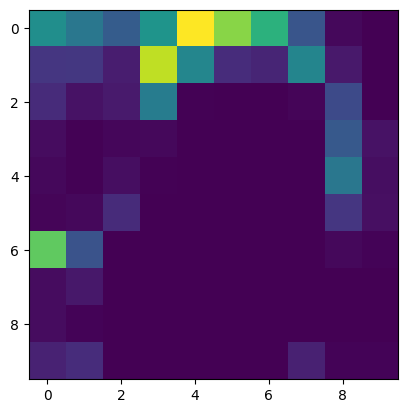

Female 



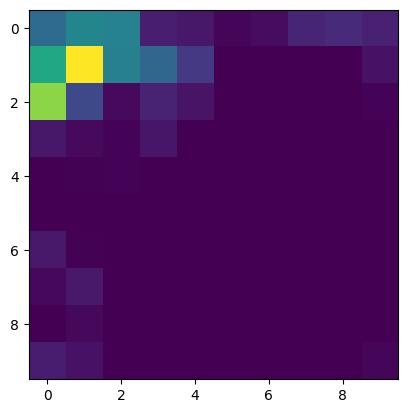

Average heatmaps for grades 1 

Male 



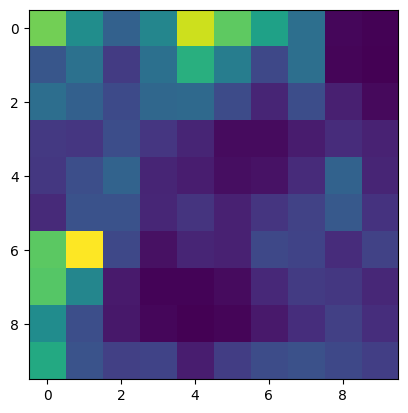

Female 



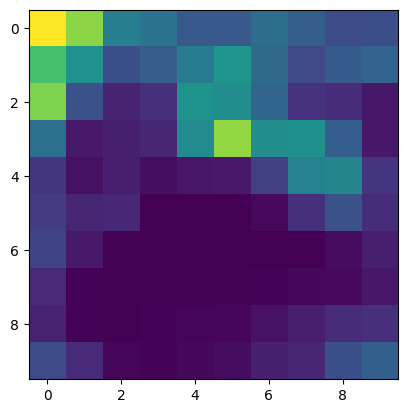

Average heatmaps for grades 2 

Male 



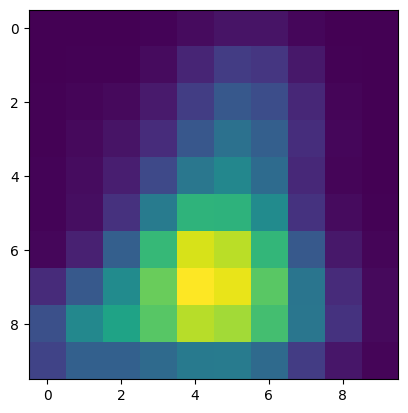

Female 



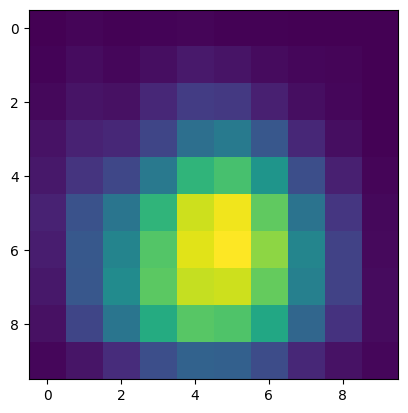

Average heatmaps for grades 3 

Male 



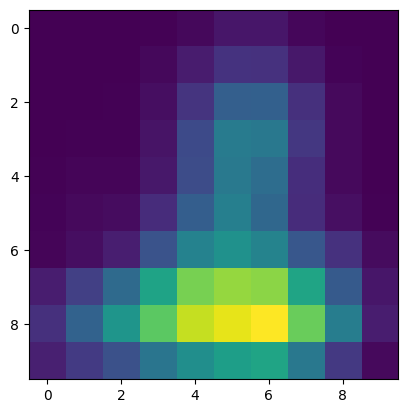

Female 



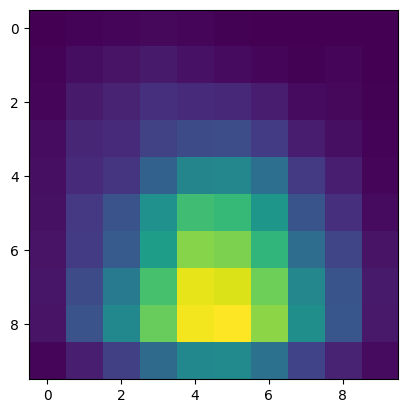

In [22]:
for i in range(4):
    print("Average heatmaps for grades %d \n" % (i))
    
    print("Male \n")
    try:
        plt.imshow(male_out[i][0])
        plt.show()
    except:
        print("no samples found")
        
    print("Female \n")
    try:
        plt.imshow(female_out[i][0])
        plt.show()
    except:
        print("no samples found")
    

# Pickle Data

In [24]:
import pickle

In [25]:
with open('male_heatmaps.pkl', 'wb') as fh:
    pickle.dump(male_out, fh)

In [26]:
with open('female_heatmaps.pkl', 'wb') as fh:
    pickle.dump(female_out, fh)

# Analyze Data

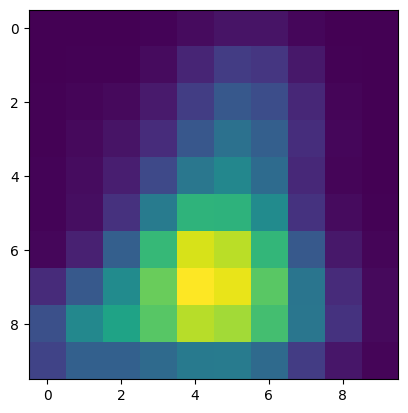

In [27]:
plt.imshow(male_out[2][0])
plt.show()

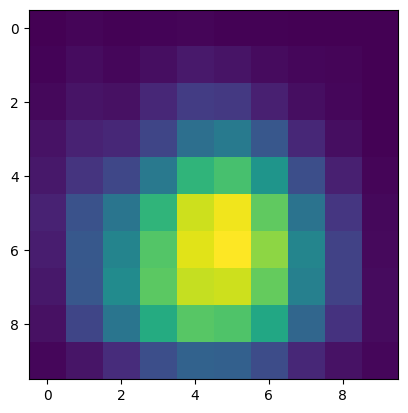

In [28]:
plt.imshow(female_out[2][0])
plt.show()

In [29]:
female_out[2][0].dtype

dtype('float64')

In [31]:
np.max(female_out[2][0])

0.7076295856395518

In [32]:
np.max(male_out[2][0])

0.7068065346281571

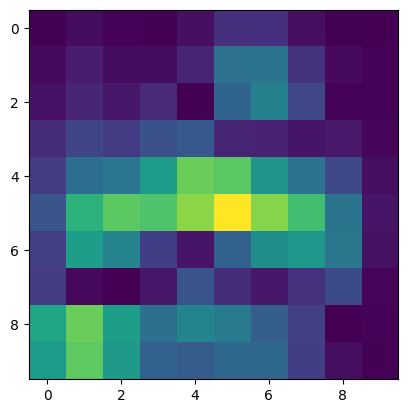

In [30]:
diff_2 = np.abs(female_out[2][0] - male_out[2][0])
plt.imshow(diff_2)
plt.show()

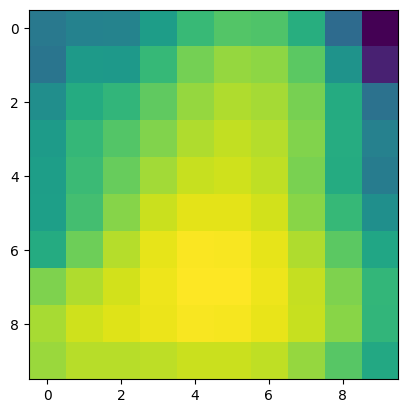

In [33]:
plt.imshow(np.log(male_out[2][0]))

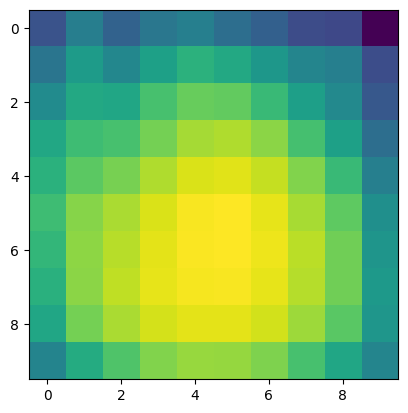

In [34]:
plt.imshow(np.log(female_out[2][0]))

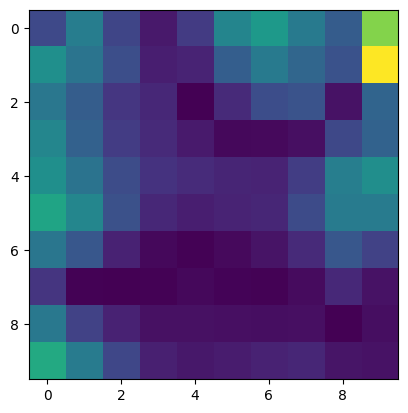

In [38]:
diff_2 = np.abs(np.log(female_out[2][0]) - np.log(male_out[2][0]))
plt.imshow(diff_2)
plt.show()

In [36]:
np.max(diff_2)

4.114321802866931

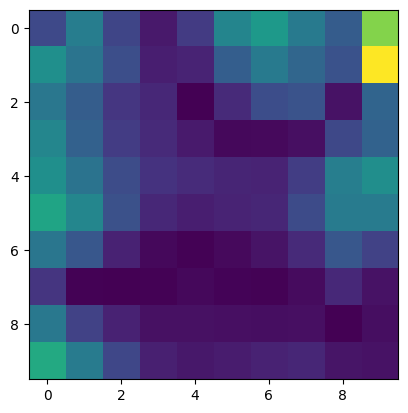

In [39]:
diff_2 = np.abs(np.log(male_out[2][0]) - np.log(female_out[2][0]))
plt.imshow(diff_2)
plt.show()

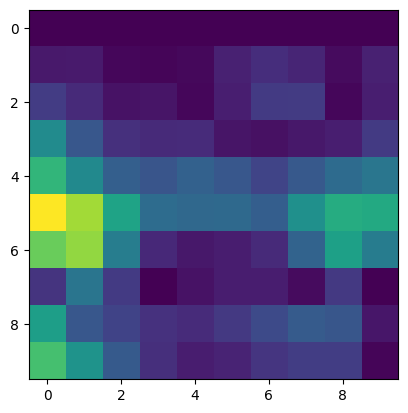

In [46]:
diff_2 = np.abs(sample1 - sample2)
plt.imshow(diff_2)
plt.show()

In [73]:
def min_max_scale(X):
    Xf = X.flatten()
    X_std = (X - np.min(Xf)) / (np.max(Xf) - np.min(Xf))
    return X_std

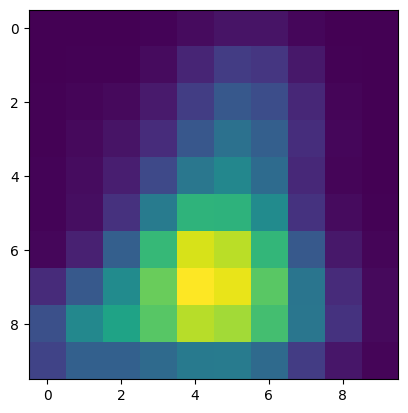

In [74]:
male_mm = min_max_scale(male_out[2][0])
plt.imshow(male_mm)

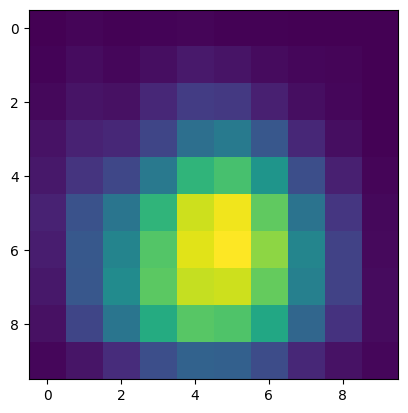

In [75]:
female_mm = min_max_scale(female_out[2][0])
plt.imshow(female_mm)

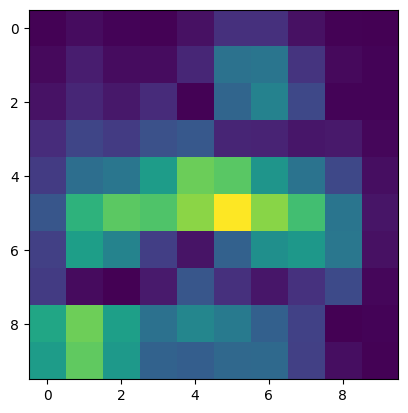

In [77]:
diff_3 = np.abs(male_mm - female_mm)
plt.imshow(diff_3)
plt.show()